<a href="https://colab.research.google.com/github/Madeline0912/mjpeterson/blob/master/Extra_Feature_Importance_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Random Forest


# Setup Functions

In [ ]:
#@title Run to Set Up
!pip install -U wget
!rm -rf data.zip data lib
!mkdir lib

import wget
wget.download('https://github.com/comp-hci-lab/BDSI_2021_ML/raw/master/lib/config.yaml', 'lib/config.yaml')
wget.download('https://github.com/comp-hci-lab/BDSI_2021_ML/raw/master/lib/helper.py', 'lib/helper.py')
wget.download('https://github.com/comp-hci-lab/BDSI_2021_ML/raw/master/data.zip', 'data.zip')

import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=dafac559cef5892f0aac2a9485d4e865a3aaba07933125e912ae6d78b767b545
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics, exceptions

from lib.helper import load_data
from lib.helper import load_data, config
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
N = 2500 # we are selecting first 2500 participant for this tutorial (you can choose upto 10k)
raw_data, df_labels = load_data(N)

Loading files from disk: 100%|██████████| 2500/2500 [00:07<00:00, 322.85it/s]


In [ ]:
#@title Define preprocessing functions. { display-mode: "form" }
#@markdown - `impute_missing_data(X)`
#@markdown - `normalize_feature_matrix(X)`
#@markdown - `generate_feature_vector(X)`
#@markdown - `series_to_supervised(data,var_name)`

from sklearn.impute import SimpleImputer
import pdb
from itertools import product


def impute_missing_data(X):
    """
    For each feature column, impute missing values  (np.nan) with the
    population mean for that feature.

    Args:
        X: np.array, shape (N, d). X could contain missing values
    Returns:
        X: np.array, shape (N, d). X does not contain any missing values
    """
    return SimpleImputer(strategy='constant',fill_value=-1).fit_transform(X)


def normalize_feature_matrix(X):
    """
    For each feature column, normalize all values to range [0, 1].

    Args:
        X: np.array, shape (N, d).
    Returns:
        X: np.array, shape (N, d). Values are normalized per column.
    """
    from sklearn.preprocessing import MinMaxScaler
    return MinMaxScaler().fit_transform(X)


def generate_feature_vector(df, window_number=1):
    """
    Reads a dataframe containing all measurements for a single patient
    within the first 48 hours of the ICU admission, and convert it into
    a feature vector.

    Args:
        df: pd.Dataframe, with columns [Time, Variable, Value]
        window_number: number of time frame windows to create

    Returns:
        a python dictionary of format {feature_name: feature_value}
        for example, {'Age': 32, 'Gender': 0, 'mean_HR': 84, ...}
    """
    static_variables = config['invariant']
    timeseries_variables = config['timeseries']

    # Replace unknow values
    df = df.replace({-1: np.nan})

    # Add windows to dataframe
    df = add_windows(df,window_number)

    # Split time invariant and time series
    static, timeseries = df.iloc[0:5], df.iloc[5:].copy()
    static = static.pivot('Time', 'Variable', 'Value')

    # Setup static and timeseries
    feature_dict = static.iloc[0].to_dict()

    stats = ['mean','missing']

    timeseries_dict = {};
    windows = list(range(0,window_number))

    for stat in stats:
      timeseries[stat+"Name"] = timeseries[['Variable','Window']].apply(lambda x:x[0]+stat+str(x[1]),axis=1)
      window_labels = [stat+str(w) for w in windows]
      labels = [e1+str(e2) for e1,e2 in product(timeseries_variables, window_labels)]
      if stat == 'missing':
        timeseries_dict.update(dict.fromkeys(labels,1))
      else:
        timeseries_dict.update(dict.fromkeys(labels,np.nan))

    means = timeseries[["meanName",'Value']].groupby(["meanName"]).mean()
    mean_values = means['Value'].values.tolist()
    timeseries_dict.update(dict(zip(means.index,mean_values)))

    # mins = timeseries[["minName",'Value']].groupby(["minName"]).min()
    # min_values = mins['Value'].values.tolist()
    # timeseries_dict.update(dict(zip(mins.index,min_values)))

    # maxs = timeseries[["maxName",'Value']].groupby(["maxName"]).max()
    # max_values = maxs['Value'].values.tolist()
    # timeseries_dict.update(dict(zip(maxs.index,max_values)))

    missing = timeseries[["missingName",'Value']].groupby(["missingName"]).mean()
    print(missing)
    #timeseries_dict.update(dict(zip(missing.index,missing.astype(int))))

    feature_dict.update(timeseries_dict)


    return feature_dict




def add_windows(df,num=1,total=48):
  """
  Args:
    df -- the dataframe to add column to
    num -- number of windows over the 48 hour period"""

  window_size = int(total/num)

  #df['Window'] = df['Time'].apply(lambda x : int(int(x.split(':')[0])/window_size))
  df['Window'] = df['Time'].apply(lambda x : int(x[0:2])//window_size)

  return df






In [ ]:
# test feature vector on single dataframe
IDs = sorted(raw_data.keys())
ID = IDs[0]
df = raw_data[ID]
vec = generate_feature_vector(df,12)

                         Value
missingName                   
BUNmissing2          13.000000
BUNmissing8           8.000000
Creatininemissing2    0.800000
Creatininemissing8    0.700000
GCSmissing0          15.000000
...                        ...
Urinemissing7       212.500000
Urinemissing8       162.500000
Urinemissing9       206.666667
WBCmissing2          11.200000
WBCmissing8           9.400000

[117 rows x 1 columns]


In [ ]:
features = [generate_feature_vector(df,window_number=6) for _, df in tqdm(sorted(raw_data.items()),desc="generating feature vectors",leave=True,position=0)]

generating feature vectors:   0%|          | 4/2500 [00:00<01:04, 38.62it/s]

                         Value
missingName                   
BUNmissing1          13.000000
BUNmissing4           8.000000
Creatininemissing1    0.800000
Creatininemissing4    0.700000
GCSmissing0          15.000000
...                        ...
Urinemissing3       185.000000
Urinemissing4       181.428571
Urinemissing5       320.000000
WBCmissing1          11.200000
WBCmissing4           9.400000

[69 rows x 1 columns]
                     Value
missingName               
BUNmissing0         16.000
BUNmissing1         18.000
BUNmissing5         21.000
Creatininemissing0   0.800
Creatininemissing1   1.200
...                    ...
WBCmissing1         13.100
WBCmissing5         13.300
pHmissing0           7.398
pHmissing1           7.400
pHmissing5           7.385

[93 rows x 1 columns]
              Value
missingName        
ALPmissing0  127.00
ALPmissing1  105.00
ALTmissing0   91.00
ALTmissing1   75.00
ASTmissing0  235.00
...             ...
WBCmissing0    4.20
WBCmissing1    3.70


generating feature vectors:   0%|          | 12/2500 [00:00<01:11, 35.03it/s]

                     Value
missingName               
ALPmissing0      47.000000
ALTmissing0      46.000000
ASTmissing0      82.000000
Albuminmissing0   1.900000
BUNmissing0      74.000000
...                    ...
pHmissing1        7.265000
pHmissing2        7.172500
pHmissing3        7.220000
pHmissing4        7.336667
pHmissing5        7.360000

[124 rows x 1 columns]
                    Value
missingName              
BUNmissing1          21.0
BUNmissing4          23.0
Creatininemissing1    0.7
Creatininemissing4    0.7
GCSmissing0          15.0
...                   ...
Urinemissing1       100.0
Urinemissing2       300.0
Urinemissing3       300.0
Urinemissing4       200.0
WBCmissing1          15.2

[64 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         19.000000
BUNmissing2         17.000000
BUNmissing5         22.000000
Creatininemissing0   1.100000
Creatininemissing2   1.000000
...                       ...
WBCmissing5         11.8

generating feature vectors:   1%|          | 20/2500 [00:00<01:13, 33.63it/s]

                        Value
missingName                  
BUNmissing0         21.000000
BUNmissing1         17.000000
BUNmissing4         18.000000
Creatininemissing0   1.000000
Creatininemissing1   1.000000
...                       ...
pHmissing0           7.332857
pHmissing1           7.390000
pHmissing3           7.450000
pHmissing4           7.470000
pHmissing5           7.490000

[97 rows x 1 columns]
                      Value
missingName                
BUNmissing0          34.750
BUNmissing1          36.250
BUNmissing4          47.000
Creatininemissing0    1.800
Creatininemissing1    1.975
...                     ...
Urinemissing5       292.500
Urinemissing6       280.000
WBCmissing1           9.400
WBCmissing4          10.300
pHmissing1            7.350

[99 rows x 1 columns]
                     Value
missingName               
Albuminmissing1   2.600000
BUNmissing0      31.000000
BUNmissing1      29.000000
BUNmissing3      31.000000
BUNmissing4      32.000000
...        

generating feature vectors:   1%|          | 28/2500 [00:00<01:13, 33.53it/s]

                        Value
missingName                  
BUNmissing2         27.000000
BUNmissing5         32.000000
Creatininemissing2   1.400000
Creatininemissing5   1.200000
FiO2missing0         0.666667
...                       ...
Urinemissing3       29.166667
Urinemissing4       60.000000
Urinemissing5       69.000000
WBCmissing2         17.100000
WBCmissing5         12.200000

[75 rows x 1 columns]
                    Value
missingName              
BUNmissing0     62.666667
BUNmissing1     55.000000
BUNmissing2     48.000000
BUNmissing3     42.000000
BUNmissing4     35.000000
...                   ...
Urinemissing4   65.714286
Urinemissing5  103.333333
WBCmissing0     15.300000
WBCmissing1     13.900000
WBCmissing4      9.700000

[98 rows x 1 columns]
                         Value
missingName                   
BUNmissing0           9.000000
BUNmissing1          10.000000
BUNmissing2           9.000000
BUNmissing4           8.000000
Creatininemissing0    0.500000
Creatinin

generating feature vectors:   1%|▏         | 36/2500 [00:01<01:13, 33.63it/s]

                        Value
missingName                  
BUNmissing1         23.000000
BUNmissing4         31.000000
Creatininemissing1   0.400000
Creatininemissing4   0.400000
FiO2missing0         0.466667
...                       ...
WBCmissing1         10.000000
WBCmissing4         10.000000
pHmissing0           7.430000
pHmissing1           7.440000
pHmissing5           7.390000

[84 rows x 1 columns]
                     Value
missingName               
BUNmissing1         68.000
Creatininemissing1   1.000
DiasABPmissing0     50.000
DiasABPmissing1     53.400
DiasABPmissing2     58.125
...                    ...
Tempmissing4        36.800
Tempmissing5        36.550
WBCmissing0          4.900
WBCmissing1          5.600
WBCmissing3          6.800

[63 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         21.000000
BUNmissing1         17.000000
BUNmissing5         14.000000
Creatininemissing0   0.900000
Creatininemissing1   1.200000
...

generating feature vectors:   2%|▏         | 44/2500 [00:01<01:11, 34.15it/s]

                  Value
missingName            
ALPmissing0      149.00
ALTmissing0       23.00
ASTmissing0       33.00
Albuminmissing0    2.70
BUNmissing0       71.00
...                 ...
Urinemissing3    117.50
Urinemissing4    162.50
Urinemissing5    113.75
WBCmissing1        7.20
WBCmissing4        2.30

[90 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         10.500000
BUNmissing4         15.000000
Creatininemissing1   0.550000
Creatininemissing4   0.700000
DiasABPmissing0     72.000000
...                       ...
WBCmissing4          8.500000
pHmissing0           7.411667
pHmissing1           7.375000
pHmissing2           7.415000
pHmissing3           7.370000

[82 rows x 1 columns]
                   Value
missingName             
ALPmissing0      140.000
ALTmissing0       18.000
ASTmissing0       11.000
Albuminmissing0    3.400
BUNmissing0      121.000
...                  ...
WBCmissing2        7.900
WBCmissing4        6.300
pH

generating feature vectors:   2%|▏         | 52/2500 [00:01<01:12, 33.84it/s]

                        Value
missingName                  
BUNmissing0         28.000000
BUNmissing2         20.000000
BUNmissing4         18.000000
Creatininemissing0   1.000000
Creatininemissing2   0.900000
...                       ...
pHmissing0           7.360000
pHmissing1           7.326667
pHmissing2           7.390000
pHmissing3           7.390000
pHmissing4           7.400000

[92 rows x 1 columns]
                    Value
missingName              
ALPmissing0     59.000000
ALTmissing0      5.000000
ASTmissing0     27.000000
BUNmissing0     44.000000
BUNmissing3     17.000000
...                   ...
Urinemissing4  292.142857
Urinemissing5  217.142857
WBCmissing0     21.425000
WBCmissing3     13.700000
WBCmissing4     15.400000

[79 rows x 1 columns]
                    Value
missingName              
BUNmissing0         40.00
BUNmissing1         32.00
BUNmissing4         18.00
Creatininemissing0   1.30
Creatininemissing1   1.00
...                   ...
Urinemissing5     

generating feature vectors:   2%|▏         | 56/2500 [00:01<01:13, 33.15it/s]

                   Value
missingName             
ALPmissing2       76.500
ALTmissing2      102.500
ASTmissing2      163.500
Albuminmissing2    2.700
BUNmissing0       16.000
...                  ...
pHmissing0         7.300
pHmissing1         7.405
pHmissing2         7.386
pHmissing3         7.405
pHmissing4         7.390

[120 rows x 1 columns]
                        Value
missingName                  
BUNmissing1          6.000000
BUNmissing4          9.000000
Creatininemissing1   0.500000
Creatininemissing4   0.500000
DiasABPmissing0     59.833333
...                       ...
WBCmissing4         10.100000
pHmissing0           7.397500
pHmissing1           7.430000
pHmissing2           7.470000
pHmissing5           7.490000

[83 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          11.000000
BUNmissing3          11.000000
Creatininemissing0    0.700000
Creatininemissing3    0.600000
DiasABPmissing0      67.833333
...                  

generating feature vectors:   3%|▎         | 64/2500 [00:01<01:18, 31.17it/s]

                        Value
missingName                  
Albuminmissing1      2.600000
Albuminmissing5      2.700000
BUNmissing1         30.000000
BUNmissing5         38.000000
Creatininemissing1   2.200000
...                       ...
Urinemissing5       34.166667
WBCmissing1         13.500000
WBCmissing5         16.900000
pHmissing0           7.460000
pHmissing1           7.430000

[85 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         14.000000
BUNmissing1         14.000000
BUNmissing3         14.000000
Creatininemissing0   0.700000
Creatininemissing1   0.800000
...                       ...
WBCmissing1         11.700000
WBCmissing3         12.100000
pHmissing1           7.383333
pHmissing2           7.315000
pHmissing3           7.410000

[92 rows x 1 columns]
                    Value
missingName              
ALPmissing1    142.000000
ALPmissing4    122.000000
ALTmissing1     16.000000
ALTmissing4     18.000000
ASTmissing1     57

generating feature vectors:   3%|▎         | 72/2500 [00:02<01:15, 32.30it/s]

                          Value
missingName                    
BUNmissing0           21.000000
BUNmissing3           22.000000
Cholesterolmissing0  151.000000
Creatininemissing0     0.700000
Creatininemissing3     0.800000
...                         ...
Urinemissing5         47.857143
WBCmissing0            8.700000
WBCmissing3           11.900000
pHmissing0             7.486667
pHmissing1             7.440000

[93 rows x 1 columns]
                   Value
missingName             
ALPmissing0      80.0000
ALTmissing0      13.0000
ASTmissing0      27.0000
Albuminmissing0   2.9000
BUNmissing0      21.5000
...                  ...
WBCmissing5      25.3000
pHmissing2        7.3075
pHmissing3        7.2500
pHmissing4        7.2350
pHmissing5        7.2300

[108 rows x 1 columns]
                     Value
missingName               
BUNmissing0          13.00
BUNmissing3           8.00
Creatininemissing0    0.60
Creatininemissing3    0.50
GCSmissing0          15.00
...                    

generating feature vectors:   3%|▎         | 80/2500 [00:02<01:14, 32.48it/s]

                 Value
missingName           
ALPmissing0       93.0
ALTmissing0       15.0
ASTmissing0       22.0
Albuminmissing0    4.0
BUNmissing0       21.0
...                ...
WBCmissing0        4.4
WBCmissing1        4.4
WBCmissing2        4.8
WBCmissing3        5.1
WBCmissing5        4.6

[100 rows x 1 columns]
              Value
missingName        
ALPmissing0  46.000
ALPmissing5  64.000
ALTmissing0  13.000
ALTmissing5  43.000
ASTmissing0  15.000
...             ...
pHmissing1    7.420
pHmissing2    7.475
pHmissing3    7.400
pHmissing4    7.380
pHmissing5    7.370

[128 rows x 1 columns]
                 Value
missingName           
ALPmissing1  45.000000
ALPmissing4  43.000000
ALTmissing1  48.000000
ALTmissing4  34.000000
ASTmissing1  69.000000
...                ...
pHmissing1    7.245000
pHmissing2    7.285000
pHmissing3    7.415000
pHmissing4    7.430000
pHmissing5    7.336667

[119 rows x 1 columns]
                 Value
missingName           
ALPmissing0  41.000000
A

generating feature vectors:   4%|▎         | 88/2500 [00:02<01:13, 32.74it/s]

                 Value
missingName           
ALPmissing0  67.000000
ALTmissing0  12.000000
ASTmissing0  17.000000
BUNmissing0  20.000000
BUNmissing1  21.000000
...                ...
pHmissing1    7.500000
pHmissing2    7.303333
pHmissing3    7.365000
pHmissing4    7.380000
pHmissing5    7.353333

[128 rows x 1 columns]
              Value
missingName        
ALPmissing0  274.00
ALPmissing1  248.00
ALTmissing0  263.00
ALTmissing1  218.00
ASTmissing0   59.00
...             ...
pHmissing0     7.35
pHmissing1     7.36
pHmissing3     7.39
pHmissing4     7.41
pHmissing5     7.43

[125 rows x 1 columns]
                       Value
missingName                 
DiasABPmissing0    63.272727
DiasABPmissing1    60.333333
DiasABPmissing2    67.250000
DiasABPmissing3    69.714286
DiasABPmissing4    76.714286
DiasABPmissing5    76.333333
FiO2missing0        0.666667
FiO2missing1        0.600000
FiO2missing2        0.600000
FiO2missing3        0.600000
FiO2missing4        0.600000
FiO2missing5    

generating feature vectors:   4%|▍         | 96/2500 [00:02<01:14, 32.36it/s]

              Value
missingName        
BUNmissing0  28.000
BUNmissing1  30.000
BUNmissing2  42.000
BUNmissing4  48.000
BUNmissing5  48.000
...             ...
WBCmissing2   8.600
WBCmissing4   8.200
pHmissing0    7.245
pHmissing1    7.305
pHmissing4    7.350

[114 rows x 1 columns]
                   Value
missingName             
ALPmissing4       44.000
ALTmissing4      139.000
ASTmissing4      158.000
Albuminmissing5    2.100
BUNmissing1       19.000
...                  ...
WBCmissing1       19.000
WBCmissing4       13.500
WBCmissing5       11.400
pHmissing1         7.390
pHmissing5         7.388

[89 rows x 1 columns]
                        Value
missingName                  
ALPmissing1         53.000000
ALTmissing1         27.000000
ASTmissing1         41.000000
BUNmissing3         41.500000
BUNmissing5         48.000000
...                       ...
TroponinTmissing5    1.640000
Urinemissing0      127.000000
WBCmissing3         13.650000
WBCmissing5         15.200000
pHmissin

generating feature vectors:   4%|▍         | 104/2500 [00:03<01:13, 32.64it/s]

                     Value
missingName               
ALPmissing0      74.000000
ALTmissing0      24.000000
ASTmissing0      59.000000
Albuminmissing0   3.600000
BUNmissing0      27.000000
...                    ...
WBCmissing4      14.400000
pHmissing2        7.408000
pHmissing3        7.421667
pHmissing4        7.420000
pHmissing5        7.450000

[108 rows x 1 columns]
                      Value
missingName                
BUNmissing0         19.0000
BUNmissing2         20.0000
BUNmissing4         22.0000
BUNmissing5         24.0000
Creatininemissing0   0.8000
...                     ...
pHmissing1           7.4325
pHmissing2           7.4450
pHmissing3           7.4000
pHmissing4           7.4000
pHmissing5           7.3800

[124 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          12.000000
BUNmissing1          13.000000
BUNmissing3          14.000000
Creatininemissing0    0.600000
Creatininemissing1    0.600000
Creatininemissing3  

generating feature vectors:   4%|▍         | 108/2500 [00:03<01:15, 31.77it/s]

                        Value
missingName                  
BUNmissing0         11.000000
BUNmissing1         12.000000
BUNmissing4         20.000000
Creatininemissing0   0.500000
Creatininemissing1   0.800000
...                       ...
WBCmissing1         22.750000
WBCmissing4         26.400000
pHmissing0           7.397500
pHmissing1           7.406667
pHmissing2           7.430000

[94 rows x 1 columns]
              Value
missingName        
ALPmissing0  103.00
ALPmissing3   96.00
ALTmissing0   54.00
ALTmissing3   61.00
ASTmissing0   74.00
...             ...
WBCmissing3   15.40
pHmissing0     7.37
pHmissing2     7.30
pHmissing3     7.35
pHmissing5     7.34

[130 rows x 1 columns]
                 Value
missingName           
ALPmissing0  38.000000
ALPmissing1  34.000000
ALPmissing3  43.000000
ALPmissing4  42.000000
ALTmissing0  10.000000
...                ...
pHmissing0    7.328000
pHmissing1    7.356667
pHmissing2    7.490000
pHmissing3    7.450000
pHmissing4    7.400000

[14

generating feature vectors:   5%|▍         | 116/2500 [00:03<01:16, 31.33it/s]

                         Value
missingName                   
BUNmissing1          28.000000
BUNmissing4          21.000000
Creatininemissing1    0.700000
Creatininemissing4    0.600000
GCSmissing0          15.000000
...                        ...
Urinemissing3       245.000000
Urinemissing4       143.750000
Urinemissing5       148.333333
WBCmissing1           4.700000
WBCmissing4           6.900000

[71 rows x 1 columns]
                  Value
missingName            
ALPmissing0       61.00
ALTmissing0       41.00
ASTmissing0      160.00
ASTmissing4       84.00
Albuminmissing0    2.70
...                 ...
WBCmissing0       12.00
WBCmissing1       10.80
WBCmissing4        9.00
pHmissing1         7.51
pHmissing4         7.45

[114 rows x 1 columns]
                 Value
missingName           
ALPmissing3      21.00
ALTmissing3      60.00
ASTmissing3      45.00
Albuminmissing3   3.30
BUNmissing2      24.00
...                ...
WBCmissing3      12.10
WBCmissing4      10.30
pHmissin

generating feature vectors:   5%|▍         | 124/2500 [00:03<01:15, 31.53it/s]

                     Value
missingName               
BUNmissing0         26.000
BUNmissing1         26.000
BUNmissing4         29.000
Creatininemissing0   2.700
Creatininemissing1   2.800
...                    ...
Urinemissing5       50.000
WBCmissing0          7.100
WBCmissing1          7.100
WBCmissing4          4.900
pHmissing0           7.295

[84 rows x 1 columns]
                     Value
missingName               
ALPmissing1      47.000000
ALTmissing1      27.000000
ASTmissing1      88.000000
Albuminmissing1   2.900000
BUNmissing0      14.000000
...                    ...
pHmissing1        7.470000
pHmissing2        7.446667
pHmissing3        7.425000
pHmissing4        7.430000
pHmissing5        7.445000

[134 rows x 1 columns]
                    Value
missingName              
ALPmissing0     67.000000
ALTmissing0     33.000000
ASTmissing0     80.000000
BUNmissing0      6.000000
BUNmissing2      7.000000
...                   ...
Urinemissing3  383.333333
Urinemissing5  50

generating feature vectors:   5%|▌         | 132/2500 [00:04<01:14, 31.58it/s]

                        Value
missingName                  
BUNmissing1         14.000000
BUNmissing4         18.000000
Creatininemissing1   0.700000
Creatininemissing4   0.600000
GCSmissing0         10.000000
...                       ...
Urinemissing3       33.857143
Urinemissing4       41.875000
Urinemissing5       48.750000
WBCmissing1         14.600000
WBCmissing4         13.300000

[68 rows x 1 columns]
                 Value
missingName           
ALPmissing1    509.000
ALPmissing4    423.000
ALTmissing1     59.000
ALTmissing4     62.500
ASTmissing1     88.000
...                ...
Urinemissing4   18.625
Urinemissing5   14.000
WBCmissing1      7.300
WBCmissing4      8.300
WBCmissing5      8.500

[87 rows x 1 columns]
               Value
missingName         
ALPmissing0     76.0
ALPmissing3     64.0
ALTmissing0     14.0
ALTmissing3     12.0
ASTmissing0     14.0
...              ...
Urinemissing3  200.0
Urinemissing4  250.0
Urinemissing5  100.0
WBCmissing0      7.3
WBCmissing3  

generating feature vectors:   6%|▌         | 140/2500 [00:04<01:15, 31.10it/s]

                  Value
missingName            
ALPmissing0   63.000000
ALPmissing3   72.000000
ALTmissing0  423.000000
ALTmissing3  276.000000
ASTmissing0  487.000000
...                 ...
WBCmissing3   15.900000
pHmissing0     7.270000
pHmissing1     7.386667
pHmissing4     7.360000
pHmissing5     7.380000

[120 rows x 1 columns]
                  Value
missingName            
ALPmissing2      53.000
ALTmissing2      23.000
ASTmissing2      11.000
Albuminmissing2   3.100
BUNmissing1      30.000
...                 ...
WBCmissing2      10.200
WBCmissing5       8.600
pHmissing0        7.490
pHmissing1        7.575
pHmissing2        7.405

[123 rows x 1 columns]
                 Value
missingName           
ALPmissing0      48.00
ALTmissing0       8.00
ASTmissing0      11.00
Albuminmissing0   3.10
BUNmissing0      12.00
...                ...
pHmissing0        7.39
pHmissing2        7.39
pHmissing3        7.40
pHmissing4        7.44
pHmissing5        7.45

[129 rows x 1 columns]
     

generating feature vectors:   6%|▌         | 148/2500 [00:04<01:14, 31.56it/s]

                    Value
missingName              
ALPmissing0    111.000000
ALPmissing1    108.000000
ALTmissing0     24.000000
ALTmissing1     23.000000
ASTmissing0     23.000000
...                   ...
Urinemissing5   53.333333
WBCmissing0     13.400000
WBCmissing1     13.000000
WBCmissing3      8.100000
WBCmissing5      9.400000

[94 rows x 1 columns]
                         Value
missingName                   
BUNmissing1          13.000000
BUNmissing4          18.000000
Creatininemissing1    0.600000
Creatininemissing4    0.800000
DiasABPmissing5      67.500000
...                        ...
Urinemissing4        54.285714
Urinemissing5       144.000000
WBCmissing1          14.200000
WBCmissing2          15.300000
WBCmissing4          14.600000

[70 rows x 1 columns]
              Value
missingName        
ALPmissing1  75.000
ALTmissing1  59.000
ASTmissing1  40.000
BUNmissing1  17.000
BUNmissing4  16.000
...             ...
pHmissing1    7.455
pHmissing2    7.470
pHmissing3   

generating feature vectors:   6%|▌         | 156/2500 [00:04<01:13, 32.01it/s]

               Value
missingName         
ALPmissing0   99.000
ALPmissing1   97.000
ALPmissing2  105.000
ALPmissing4   97.000
ALTmissing0    9.000
...              ...
pHmissing1     7.470
pHmissing2     7.440
pHmissing3     7.390
pHmissing4     7.385
pHmissing5     7.360

[145 rows x 1 columns]
                     Value
missingName               
BUNmissing0         20.000
BUNmissing2         18.000
Creatininemissing0   1.000
Creatininemissing2   1.100
Creatininemissing5   0.900
...                    ...
pHmissing1           7.328
pHmissing2           7.285
pHmissing3           7.300
pHmissing4           7.370
pHmissing5           7.410

[109 rows x 1 columns]
               Value
missingName         
ALPmissing1     97.0
ALPmissing4     82.0
ALTmissing1     84.0
ALTmissing4     82.0
ASTmissing1    141.0
...              ...
Urinemissing3   94.0
Urinemissing4   75.0
Urinemissing5  244.0
WBCmissing1     11.0
WBCmissing4      7.9

[83 rows x 1 columns]
             Value
missingName  

generating feature vectors:   7%|▋         | 164/2500 [00:05<01:12, 32.40it/s]

                    Value
missingName              
BUNmissing1         19.00
BUNmissing3         20.00
BUNmissing4         18.00
Creatininemissing1   0.70
Creatininemissing3   0.80
...                   ...
pHmissing0           7.41
pHmissing2           7.40
pHmissing3           7.34
pHmissing4           7.46
pHmissing5           7.39

[109 rows x 1 columns]
                    Value
missingName              
BUNmissing0          28.0
BUNmissing2          28.0
BUNmissing4          34.0
Creatininemissing0    1.8
Creatininemissing2    1.7
...                   ...
Urinemissing4       242.5
Urinemissing5        71.0
WBCmissing0          14.0
WBCmissing2          10.0
WBCmissing4          12.3

[81 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         14.000000
BUNmissing3         17.000000
Creatininemissing0   0.900000
Creatininemissing3   1.000000
DiasABPmissing0     62.555556
...                       ...
pHmissing0           7.350000
pHmissi

generating feature vectors:   7%|▋         | 172/2500 [00:05<01:14, 31.45it/s]

                    Value
missingName              
ALPmissing1    363.000000
ALPmissing2    341.000000
ALTmissing1     48.500000
ALTmissing2     43.000000
ASTmissing1     67.000000
...                   ...
Urinemissing5   51.428571
WBCmissing1     30.350000
WBCmissing2     22.200000
pHmissing1       7.310000
pHmissing2       7.340000

[114 rows x 1 columns]
                       Value
missingName                 
BUNmissing1         7.000000
BUNmissing2         5.000000
BUNmissing4         6.000000
BUNmissing5         6.000000
Creatininemissing1  0.800000
...                      ...
pHmissing1          7.420000
pHmissing2          7.450000
pHmissing3          7.450000
pHmissing4          7.505000
pHmissing5          7.476667

[120 rows x 1 columns]
               Value
missingName         
ALPmissing1    717.0
ALPmissing3    703.0
ALPmissing4    717.0
ALTmissing1     52.0
ALTmissing3     47.0
...              ...
Urinemissing3   50.0
Urinemissing4  160.0
Urinemissing5  190.0
WBCmis

generating feature vectors:   7%|▋         | 180/2500 [00:05<01:11, 32.53it/s]

                        Value
missingName                  
BUNmissing0         15.000000
BUNmissing1         13.000000
BUNmissing4         11.000000
Creatininemissing0   1.000000
Creatininemissing1   1.100000
...                       ...
pHmissing0           7.390000
pHmissing1           7.366667
pHmissing2           7.415000
pHmissing3           7.420000
pHmissing4           7.470000

[106 rows x 1 columns]
                  Value
missingName            
ALPmissing0       55.00
ALTmissing0       30.00
ASTmissing0      153.00
Albuminmissing0    3.70
BUNmissing0       19.00
...                 ...
Urinemissing5    320.00
WBCmissing0       11.40
WBCmissing1       10.20
WBCmissing3        9.20
pHmissing2         7.41

[90 rows x 1 columns]
                     Value
missingName               
ALPmissing0      88.000000
ALTmissing0      19.000000
ASTmissing0      25.000000
Albuminmissing0   2.800000
BUNmissing0      59.500000
...                    ...
pHmissing1        7.386667
pHmissin

generating feature vectors:   8%|▊         | 188/2500 [00:05<01:10, 32.70it/s]

                 Value
missingName           
ALPmissing0  92.000000
ALPmissing1  87.000000
ALTmissing0  29.000000
ALTmissing1  55.000000
ASTmissing0  57.000000
...                ...
WBCmissing3  13.150000
WBCmissing4  10.600000
pHmissing3    7.383333
pHmissing4    7.370000
pHmissing5    7.370000

[118 rows x 1 columns]
                        Value
missingName                  
Albuminmissing2      1.800000
BUNmissing2         20.000000
BUNmissing5         19.000000
Creatininemissing2   1.100000
Creatininemissing5   0.900000
...                       ...
pHmissing1           7.332500
pHmissing2           7.336667
pHmissing3           7.346667
pHmissing4           7.320000
pHmissing5           7.330000

[108 rows x 1 columns]
                    Value
missingName              
BUNmissing2          7.00
BUNmissing5          6.00
Creatininemissing2   0.50
Creatininemissing5   0.50
DiasABPmissing0     75.80
...                   ...
WBCmissing5          7.00
pHmissing0           7.34
pHm

generating feature vectors:   8%|▊         | 192/2500 [00:05<01:10, 32.69it/s]

                      Value
missingName                
ALPmissing0      106.000000
ALTmissing0       54.000000
ASTmissing0       40.000000
Albuminmissing0    4.400000
BUNmissing0       21.000000
...                     ...
pHmissing1         7.453333
pHmissing2         7.426667
pHmissing3         7.400000
pHmissing4         7.420000
pHmissing5         7.410000

[129 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         14.000000
BUNmissing1         12.000000
BUNmissing4         14.000000
Creatininemissing0   0.700000
Creatininemissing1   0.700000
...                       ...
WBCmissing1         15.900000
WBCmissing4         11.300000
pHmissing0           7.366667
pHmissing1           7.410000
pHmissing2           7.440000

[93 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         18.000000
BUNmissing2         19.000000
BUNmissing5         22.000000
Creatininemissing0   1.000000
Creatininemissing2 

generating feature vectors:   8%|▊         | 200/2500 [00:06<01:10, 32.45it/s]

                      Value
missingName                
Albuminmissing3        3.00
BUNmissing0           30.00
BUNmissing3           41.00
Cholesterolmissing0  152.00
Creatininemissing0     5.80
...                     ...
Urinemissing5         18.00
WBCmissing0            9.00
WBCmissing3           10.70
pHmissing3             7.41
pHmissing4             7.45

[96 rows x 1 columns]
                     Value
missingName               
ALPmissing2      60.000000
ALTmissing2      43.000000
ASTmissing2      38.000000
Albuminmissing2   3.100000
BUNmissing0      32.000000
...                    ...
pHmissing1        7.408000
pHmissing2        7.406667
pHmissing3        7.385000
pHmissing4        7.405000
pHmissing5        7.410000

[122 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         24.000000
BUNmissing1         28.500000
BUNmissing4         21.000000
Creatininemissing0   4.600000
Creatininemissing1   5.200000
...                       ..

generating feature vectors:   8%|▊         | 208/2500 [00:06<01:09, 33.12it/s]

                    Value
missingName              
BUNmissing0     79.000000
BUNmissing1     61.000000
BUNmissing2     44.000000
BUNmissing4     25.000000
BUNmissing5     20.000000
...                   ...
Urinemissing4  228.571429
Urinemissing5  198.000000
WBCmissing1     14.800000
WBCmissing2     11.100000
WBCmissing4      6.900000

[96 rows x 1 columns]
                    Value
missingName              
BUNmissing1         46.00
BUNmissing4         58.00
BUNmissing5         23.00
Creatininemissing1   8.40
Creatininemissing4  10.20
...                   ...
TroponinImissing5    1.40
WBCmissing1         10.40
WBCmissing3         14.20
WBCmissing4         17.60
pHmissing0           7.32

[77 rows x 1 columns]
                 Value
missingName           
ALPmissing0      254.0
ALTmissing0       35.0
ASTmissing0       18.0
Albuminmissing0    3.1
BUNmissing0        7.0
...                ...
Urinemissing4    100.0
Urinemissing5    200.0
WBCmissing0       12.1
WBCmissing1       11.4
WB

generating feature vectors:   9%|▊         | 216/2500 [00:06<01:08, 33.53it/s]

              Value
missingName        
ALPmissing0  38.000
ALPmissing1  45.000
ALPmissing2  56.000
ALPmissing5  46.000
ALTmissing0  28.500
...             ...
pHmissing1    7.275
pHmissing2    7.335
pHmissing3    7.360
pHmissing4    7.430
pHmissing5    7.395

[152 rows x 1 columns]
                         Value
missingName                   
BUNmissing1          11.000000
BUNmissing4          10.000000
Creatininemissing1    0.900000
Creatininemissing4    0.700000
GCSmissing0          15.000000
...                        ...
Urinemissing3       238.333333
Urinemissing4       367.500000
Urinemissing5       312.500000
WBCmissing1           7.500000
WBCmissing4           6.800000

[63 rows x 1 columns]
               Value
missingName         
ALPmissing0  142.000
ALPmissing1  137.000
ALPmissing4  114.000
ALTmissing0   24.000
ALTmissing1   23.000
...              ...
WBCmissing1   19.900
WBCmissing4    9.500
pHmissing0     7.390
pHmissing1     7.465
pHmissing3     7.480

[111 rows x 1 co

generating feature vectors:   9%|▉         | 224/2500 [00:06<01:09, 32.82it/s]

                    Value
missingName              
ALPmissing2    148.000000
ALPmissing5     20.000000
ALTmissing2     44.000000
ALTmissing5      5.000000
ASTmissing2     51.000000
...                   ...
Urinemissing3  266.666667
Urinemissing4  250.000000
Urinemissing5  300.000000
WBCmissing2      5.600000
WBCmissing5      4.500000

[77 rows x 1 columns]
                 Value
missingName           
ALPmissing1     66.000
ALPmissing4     67.000
ALTmissing1     13.000
ALTmissing4     16.000
ASTmissing1     21.000
...                ...
Urinemissing4  280.000
Urinemissing5  192.500
WBCmissing4      7.500
pHmissing0       7.340
pHmissing2       7.405

[97 rows x 1 columns]
                     Value
missingName               
BUNmissing0         16.000
BUNmissing4         26.000
BUNmissing5         27.000
Creatininemissing0   0.950
Creatininemissing4   1.400
...                    ...
pHmissing1           7.380
pHmissing2           7.410
pHmissing3           7.435
pHmissing4          

generating feature vectors:   9%|▉         | 232/2500 [00:07<01:08, 32.90it/s]

                        Value
missingName                  
BUNmissing1          9.000000
BUNmissing3         10.666667
Creatininemissing1   0.600000
Creatininemissing3   0.600000
FiO2missing1         1.000000
...                       ...
Urinemissing4       88.750000
Urinemissing5       75.000000
WBCmissing1          8.200000
WBCmissing3          9.200000
pHmissing3           7.410000

[71 rows x 1 columns]
               Value
missingName         
ALPmissing3     67.0
ALTmissing3     25.0
ASTmissing3     19.0
BUNmissing0     12.0
BUNmissing3      8.0
...              ...
Urinemissing3  777.5
Urinemissing4  675.0
Urinemissing5  900.0
WBCmissing3      3.9
WBCmissing5      5.3

[78 rows x 1 columns]
                    Value
missingName              
ALPmissing0        160.00
ALPmissing4        138.00
ALTmissing0         98.00
ALTmissing4         72.00
ASTmissing0         65.00
...                   ...
TroponinTmissing0    0.82
TroponinTmissing3    0.88
TroponinTmissing4    0.90
WBCmi

generating feature vectors:  10%|▉         | 240/2500 [00:07<01:11, 31.77it/s]

                        Value
missingName                  
BUNmissing0         14.000000
BUNmissing1         11.000000
BUNmissing5          8.000000
Creatininemissing0   0.700000
Creatininemissing1   0.700000
...                       ...
WBCmissing5          8.700000
pHmissing0           7.396667
pHmissing1           7.370000
pHmissing2           7.390000
pHmissing3           7.410000

[91 rows x 1 columns]
                    Value
missingName              
BUNmissing0         11.00
BUNmissing1         12.00
Creatininemissing0   0.60
Creatininemissing1   0.90
Creatininemissing4   0.70
...                   ...
pHmissing1           7.42
pHmissing2           7.45
pHmissing3           7.48
pHmissing4           7.47
pHmissing5           7.47

[96 rows x 1 columns]
                         Value
missingName                   
BUNmissing1          10.000000
BUNmissing4           8.000000
Creatininemissing1    1.000000
Creatininemissing4    0.900000
FiO2missing1          0.600000
...      

generating feature vectors:  10%|▉         | 248/2500 [00:07<01:10, 31.90it/s]

               Value
missingName         
ALPmissing0     78.0
ALPmissing1     77.0
ALPmissing4     86.0
ALTmissing0     40.0
ALTmissing1     40.0
...              ...
Urinemissing5   61.0
WBCmissing0     27.5
WBCmissing1     30.0
WBCmissing3     27.2
WBCmissing4     24.8

[103 rows x 1 columns]
                    Value
missingName              
ALPmissing0     73.000000
ALPmissing3     64.000000
ALTmissing0    287.000000
ALTmissing3    112.000000
ASTmissing0    637.000000
...                   ...
Urinemissing4   88.571429
Urinemissing5  101.875000
WBCmissing0     11.200000
WBCmissing3      8.000000
pHmissing1       7.330000

[105 rows x 1 columns]
             Value
missingName       
ALPmissing0  41.00
ALPmissing1  40.00
ALTmissing0  40.00
ALTmissing1  37.00
ASTmissing0  57.00
...            ...
WBCmissing1   7.00
WBCmissing4   7.00
pHmissing0    7.42
pHmissing1    7.43
pHmissing3    7.42

[105 rows x 1 columns]
                      Value
missingName                
BUNmissing2   

generating feature vectors:  10%|█         | 256/2500 [00:07<01:09, 32.45it/s]

                      Value
missingName                
ALPmissing0       74.000000
ALTmissing0      209.000000
ASTmissing0      165.000000
Albuminmissing0    3.100000
BUNmissing0       40.000000
...                     ...
Urinemissing4     56.666667
Urinemissing5    225.000000
WBCmissing0       12.500000
WBCmissing1       13.100000
WBCmissing4       10.800000

[84 rows x 1 columns]
                 Value
missingName           
ALPmissing0     65.000
ALTmissing0     11.000
ASTmissing0     17.000
BUNmissing0     24.000
BUNmissing3     37.000
...                ...
Urinemissing4  550.000
Urinemissing5  612.500
WBCmissing0      8.800
WBCmissing3     23.500
pHmissing0       7.285

[88 rows x 1 columns]
                     Value
missingName               
BUNmissing0          25.00
BUNmissing2          24.00
BUNmissing5          25.00
Creatininemissing0    1.70
Creatininemissing2    1.60
...                    ...
Urinemissing5       280.00
WBCmissing0           6.30
WBCmissing2          

generating feature vectors:  10%|█         | 260/2500 [00:08<01:09, 32.30it/s]

                       Value
missingName                 
BUNmissing0          11.0000
BUNmissing1          11.0000
BUNmissing5           9.0000
Creatininemissing0    0.3000
Creatininemissing1    0.4000
...                      ...
Urinemissing5       128.0000
WBCmissing1           5.5000
WBCmissing5           6.4000
pHmissing0            7.3725
pHmissing1            7.3800

[78 rows x 1 columns]
                     Value
missingName               
BUNmissing0         11.000
BUNmissing1         11.000
BUNmissing4         13.000
Creatininemissing0   0.600
Creatininemissing1   0.600
...                    ...
pHmissing0           7.356
pHmissing1           7.380
pHmissing2           7.460
pHmissing4           7.460
pHmissing5           7.495

[89 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         25.000000
BUNmissing4         18.000000
Creatininemissing1   0.900000
Creatininemissing4   0.700000
DiasABPmissing0     54.375000
...             

generating feature vectors:  11%|█         | 268/2500 [00:08<01:10, 31.88it/s]

                 Value
missingName           
ALPmissing0  44.000000
ALPmissing3  64.000000
ALTmissing0  29.000000
ALTmissing3  30.000000
ASTmissing0  25.000000
...                ...
pHmissing0    7.418000
pHmissing1    7.420000
pHmissing3    7.473333
pHmissing4    7.460000
pHmissing5    7.445000

[112 rows x 1 columns]
                  Value
missingName            
ALPmissing0  160.000000
ALPmissing1  288.666667
ALPmissing2  322.000000
ALPmissing3  326.000000
ALPmissing4  351.000000
...                 ...
pHmissing1     7.283333
pHmissing2     7.393333
pHmissing3     7.497500
pHmissing4     7.510000
pHmissing5     7.490000

[159 rows x 1 columns]
                         Value
missingName                   
BUNmissing1          10.000000
BUNmissing3          12.000000
Creatininemissing1    1.400000
Creatininemissing3    1.700000
DiasABPmissing0      62.333333
...                        ...
Urinemissing3       128.333333
Urinemissing4       156.666667
Urinemissing5       152.500000


generating feature vectors:  11%|█         | 276/2500 [00:08<01:10, 31.70it/s]

                        Value
missingName                  
BUNmissing1         22.000000
BUNmissing2         21.000000
BUNmissing5         15.000000
Creatininemissing1   1.700000
Creatininemissing2   1.200000
...                       ...
WBCmissing5         14.700000
pHmissing1           7.305000
pHmissing3           7.255000
pHmissing4           7.300000
pHmissing5           7.263333

[91 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          15.000000
BUNmissing3          12.000000
Creatininemissing0    0.800000
Creatininemissing3    0.800000
DiasABPmissing1      54.785714
...                        ...
Urinemissing5       235.000000
WBCmissing0          13.700000
WBCmissing3          13.800000
pHmissing2            7.430000
pHmissing3            7.410000

[87 rows x 1 columns]
                 Value
missingName           
ALPmissing0      102.0
ALTmissing0       16.0
ASTmissing0       28.0
Albuminmissing0    3.1
BUNmissing0       31.0


generating feature vectors:  11%|█▏        | 284/2500 [00:08<01:06, 33.19it/s]

                      Value
missingName                
BUNmissing0         11.0000
BUNmissing2         13.0000
BUNmissing3         13.0000
Creatininemissing0   0.7500
Creatininemissing2   0.8000
...                     ...
WBCmissing2          9.0000
WBCmissing3          8.3000
pHmissing0           7.3075
pHmissing1           7.3600
pHmissing2           7.3800

[114 rows x 1 columns]
             Value
missingName       
ALPmissing1  52.00
ALTmissing1  16.00
ASTmissing1  47.00
BUNmissing1  13.00
BUNmissing4  11.00
...            ...
pHmissing1    7.48
pHmissing2    7.46
pHmissing3    7.49
pHmissing4    7.47
pHmissing5    7.48

[101 rows x 1 columns]
                    Value
missingName              
BUNmissing0         23.00
BUNmissing2         20.00
BUNmissing5         19.00
Creatininemissing0   0.70
Creatininemissing2   0.80
...                   ...
pHmissing1           7.35
pHmissing2           7.42
pHmissing3           7.44
pHmissing4           7.40
pHmissing5           7.41

[9

generating feature vectors:  12%|█▏        | 292/2500 [00:09<01:07, 32.66it/s]

             Value
missingName       
ALPmissing0  63.00
ALTmissing0  16.00
ASTmissing0  68.00
BUNmissing0  17.00
BUNmissing2  19.00
...            ...
WBCmissing3  10.30
pHmissing0    7.37
pHmissing1    7.44
pHmissing2    7.47
pHmissing3    7.47

[112 rows x 1 columns]
                     Value
missingName               
BUNmissing0         16.000
BUNmissing1         18.000
BUNmissing4         27.000
Creatininemissing0   0.900
Creatininemissing1   0.900
...                    ...
pHmissing1           7.400
pHmissing2           7.370
pHmissing3           7.395
pHmissing4           7.390
pHmissing5           7.400

[107 rows x 1 columns]
              Value
missingName        
ALPmissing1   67.00
ALPmissing2   70.00
ALTmissing1  159.00
ALTmissing2  138.00
ASTmissing1  838.00
...             ...
pHmissing0     7.38
pHmissing1     7.37
pHmissing2     7.42
pHmissing3     7.39
pHmissing4     7.44

[122 rows x 1 columns]
                  Value
missingName            
ALPmissing0  120.50000

generating feature vectors:  12%|█▏        | 300/2500 [00:09<01:06, 32.97it/s]

                     Value
missingName               
BUNmissing0         21.000
BUNmissing1         22.000
BUNmissing4         22.000
Creatininemissing0   1.000
Creatininemissing1   1.000
...                    ...
pHmissing1           7.296
pHmissing2           7.330
pHmissing3           7.330
pHmissing4           7.370
pHmissing5           7.370

[91 rows x 1 columns]
                    Value
missingName              
BUNmissing1         37.00
BUNmissing4         30.00
Creatininemissing1   1.30
Creatininemissing4   1.30
FiO2missing0         0.45
...                   ...
Urinemissing5       71.50
WBCmissing1         19.40
WBCmissing4         14.20
WBCmissing5         14.40
pHmissing0           7.45

[73 rows x 1 columns]
                     Value
missingName               
BUNmissing0         12.000
BUNmissing1         16.000
BUNmissing3         19.000
BUNmissing4         19.000
Creatininemissing0   0.500
...                    ...
Urinemissing4       75.000
Urinemissing5       50

generating feature vectors:  12%|█▏        | 304/2500 [00:09<01:09, 31.56it/s]

                   Value
missingName             
ALPmissing0      143.000
ALTmissing0       12.000
ASTmissing0       12.000
Albuminmissing0    2.100
BUNmissing0       13.000
...                  ...
WBCmissing3        9.900
pHmissing0         7.410
pHmissing2         7.395
pHmissing3         7.430
pHmissing4         7.410

[104 rows x 1 columns]
             Value
missingName       
ALPmissing1  43.00
ALPmissing4  38.00
ALTmissing1  22.00
ALTmissing4  19.00
ASTmissing1  51.00
...            ...
pHmissing1    7.42
pHmissing2    7.48
pHmissing3    7.48
pHmissing4    7.48
pHmissing5    7.49

[142 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          40.500000
BUNmissing3          50.000000
Creatininemissing0    1.650000
Creatininemissing3    1.900000
GCSmissing0          15.000000
...                        ...
Urinemissing3       175.000000
Urinemissing4       112.500000
Urinemissing5       166.666667
WBCmissing0           9.900000
WBCmissi

generating feature vectors:  12%|█▏        | 308/2500 [00:09<01:09, 31.47it/s]

                        Value
missingName                  
BUNmissing0         19.000000
BUNmissing2         23.000000
BUNmissing5         20.000000
Creatininemissing0   2.200000
Creatininemissing2   1.200000
...                       ...
pHmissing1           7.280000
pHmissing2           7.310000
pHmissing3           7.300000
pHmissing4           7.260000
pHmissing5           7.103333

[97 rows x 1 columns]
                Value
missingName          
ALPmissing1     68.00
ALTmissing1     19.00
ASTmissing1     40.00
BUNmissing0     14.00
BUNmissing1     11.00
...               ...
Urinemissing3  115.00
Urinemissing4  143.75
Urinemissing5  182.00
WBCmissing0      5.40
WBCmissing1      5.70

[84 rows x 1 columns]
                    Value
missingName              
BUNmissing0          8.00
BUNmissing1          7.00
BUNmissing3          8.00
Creatininemissing0   0.60
Creatininemissing1   0.70
...                   ...
WBCmissing0         11.20
WBCmissing3         12.20
pHmissing0        

generating feature vectors:  13%|█▎        | 315/2500 [00:09<01:20, 27.18it/s]

                        Value
missingName                  
BUNmissing2         11.000000
BUNmissing5         13.000000
Creatininemissing2   0.900000
Creatininemissing5   0.700000
DiasABPmissing4     71.428571
...                       ...
WBCmissing2         15.700000
WBCmissing5         12.300000
pHmissing3           7.470000
pHmissing4           7.450000
pHmissing5           7.490000

[87 rows x 1 columns]
                         Value
missingName                   
BUNmissing3          13.000000
BUNmissing5          13.000000
Creatininemissing3    0.500000
Creatininemissing5    0.400000
FiO2missing2          0.350000
GCSmissing0          14.666667
GCSmissing1          15.000000
GCSmissing2          15.000000
GCSmissing3          15.000000
Glucosemissing3     104.000000
Glucosemissing5     126.000000
HCO3missing3         26.000000
HCO3missing5         24.000000
HCTmissing3          23.000000
HCTmissing5          29.700000
HRmissing0           83.375000
HRmissing1           97.71428

generating feature vectors:  13%|█▎        | 321/2500 [00:10<01:18, 27.67it/s]

                    Value
missingName              
Albuminmissing2      2.70
BUNmissing0         26.00
BUNmissing1         28.00
BUNmissing3         31.00
Creatininemissing0   1.00
...                   ...
pHmissing1           7.41
pHmissing2           7.52
pHmissing3           7.45
pHmissing4           7.40
pHmissing5           7.42

[115 rows x 1 columns]
                     Value
missingName               
ALPmissing0      48.000000
ALTmissing0      26.000000
ASTmissing0      46.000000
Albuminmissing0   2.500000
BUNmissing0      26.000000
...                    ...
pHmissing1        7.280000
pHmissing2        7.365000
pHmissing3        7.410000
pHmissing4        7.433333
pHmissing5        7.390000

[143 rows x 1 columns]
             Value
missingName       
ALPmissing1   72.0
ALPmissing5   70.0
ALTmissing1    4.0
ALTmissing5    6.0
ASTmissing1   11.0
...            ...
WBCmissing0   10.4
WBCmissing1   11.4
WBCmissing2   11.8
WBCmissing4   13.2
WBCmissing5   11.4

[109 rows x 1 c

generating feature vectors:  13%|█▎        | 329/2500 [00:10<01:10, 30.77it/s]

                      Value
missingName                
ALPmissing0      139.000000
ALTmissing0       27.000000
ASTmissing0       41.000000
Albuminmissing0    3.600000
BUNmissing0      116.000000
...                     ...
Urinemissing4     18.333333
Urinemissing5     11.666667
WBCmissing0       20.800000
WBCmissing2       13.900000
WBCmissing3       14.100000

[87 rows x 1 columns]
                     Value
missingName               
Albuminmissing4      3.000
BUNmissing0         18.000
BUNmissing1         27.000
BUNmissing4         34.000
Creatininemissing0   0.800
...                    ...
pHmissing1           7.370
pHmissing2           7.340
pHmissing3           7.280
pHmissing4           7.290
pHmissing5           7.265

[110 rows x 1 columns]
                    Value
missingName              
Albuminmissing4      3.60
BUNmissing1         23.00
BUNmissing4         12.00
Creatininemissing1   0.80
Creatininemissing4   0.60
...                   ...
WBCmissing4         10.70
pHmi

generating feature vectors:  13%|█▎        | 337/2500 [00:10<01:08, 31.67it/s]

                        Value
missingName                  
BUNmissing0         22.000000
BUNmissing2         23.000000
BUNmissing5         28.000000
Creatininemissing0   1.300000
Creatininemissing2   1.500000
...                       ...
WBCmissing2         13.900000
WBCmissing5         13.600000
pHmissing0           7.412857
pHmissing1           7.440000
pHmissing2           7.430000

[63 rows x 1 columns]
                    Value
missingName              
BUNmissing0         12.00
BUNmissing1         10.00
BUNmissing3          4.50
Bilirubinmissing0    0.30
Creatininemissing0   0.70
...                   ...
WBCmissing2          9.30
WBCmissing3         11.20
pHmissing0           7.36
pHmissing2           7.47
pHmissing4           7.41

[102 rows x 1 columns]
              Value
missingName        
ALPmissing0  214.00
ALTmissing0   26.00
ASTmissing0   41.00
BUNmissing0   38.50
BUNmissing2   35.00
...             ...
pHmissing0     7.39
pHmissing1     7.38
pHmissing2     7.38
pHmis

generating feature vectors:  14%|█▍        | 345/2500 [00:10<01:08, 31.28it/s]

                      Value
missingName                
ALPmissing0       39.500000
ALTmissing0       25.500000
ASTmissing0       17.500000
Albuminmissing0    2.800000
BUNmissing0      152.500000
...                     ...
pHmissing1         7.360000
pHmissing2         7.410000
pHmissing3         7.420000
pHmissing4         7.440000
pHmissing5         7.353333

[146 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         17.000000
BUNmissing1         16.000000
BUNmissing4         17.000000
Creatininemissing0   0.900000
Creatininemissing1   1.200000
...                       ...
WBCmissing0         10.450000
WBCmissing1         13.800000
WBCmissing4         14.700000
pHmissing0           7.357143
pHmissing1           7.400000

[83 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         16.000000
BUNmissing2         19.000000
BUNmissing5         21.000000
Creatininemissing0   0.800000
Creatininemissing2 

generating feature vectors:  14%|█▍        | 349/2500 [00:10<01:12, 29.80it/s]

                    Value
missingName              
ALPmissing0       50.5000
ALTmissing0       62.0000
ASTmissing0      147.0000
Albuminmissing0    4.2000
BUNmissing0       12.0000
...                   ...
WBCmissing5       10.2000
pHmissing2         7.3850
pHmissing3         7.3975
pHmissing4         7.3650
pHmissing5         7.4200

[71 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         11.000000
BUNmissing2         15.000000
BUNmissing4         16.000000
BUNmissing5         19.000000
Creatininemissing0   0.900000
...                       ...
pHmissing1           7.352000
pHmissing2           7.380000
pHmissing3           7.346667
pHmissing4           7.380000
pHmissing5           7.370000

[118 rows x 1 columns]
                  Value
missingName            
ALPmissing4      87.000
ALTmissing4      10.000
ASTmissing4      15.000
Albuminmissing1   2.100
Albuminmissing4   1.700
...                 ...
pHmissing0        7.290
pHmissing

generating feature vectors:  14%|█▍        | 357/2500 [00:11<01:09, 30.71it/s]

                    Value
missingName              
Albuminmissing0      2.80
BUNmissing0         66.00
BUNmissing5         69.00
Creatininemissing0   1.80
Creatininemissing5   1.70
...                   ...
Urinemissing4       43.00
Urinemissing5       78.00
WBCmissing0          9.00
WBCmissing5          7.10
pHmissing1           7.22

[74 rows x 1 columns]
                       Value
missingName                 
BUNmissing0           16.000
BUNmissing1           16.000
BUNmissing3           19.500
Cholesterolmissing0  189.000
Creatininemissing0     0.900
...                      ...
WBCmissing1           10.600
WBCmissing3           10.400
pHmissing0             7.445
pHmissing4             7.450
pHmissing5             7.420

[101 rows x 1 columns]
                    Value
missingName              
BUNmissing1         30.00
BUNmissing4         28.00
Creatininemissing1   1.20
Creatininemissing4   1.10
FiO2missing0         0.65
...                   ...
WBCmissing1          8.70
WBCm

generating feature vectors:  15%|█▍        | 365/2500 [00:11<01:08, 31.14it/s]

               Value
missingName         
ALPmissing0  671.000
ALPmissing3  591.000
ALTmissing0   57.000
ALTmissing3   54.000
ASTmissing0  200.000
...              ...
pHmissing1     7.450
pHmissing2     7.415
pHmissing3     7.325
pHmissing4     7.310
pHmissing5     7.305

[113 rows x 1 columns]
                  Value
missingName            
ALPmissing1   67.000000
ALPmissing2   58.000000
ALTmissing1  208.000000
ALTmissing2  181.000000
ASTmissing1  100.000000
...                 ...
pHmissing1     7.396667
pHmissing2     7.435000
pHmissing3     7.370000
pHmissing4     7.371667
pHmissing5     7.425000

[126 rows x 1 columns]
                  Value
missingName            
ALPmissing3      760.00
ALTmissing3       20.00
ASTmissing3       29.00
Albuminmissing3    2.60
BUNmissing0       56.00
...                 ...
WBCmissing3        9.20
pHmissing0         7.47
pHmissing1         7.47
pHmissing2         7.42
pHmissing4         7.44

[112 rows x 1 columns]
                    Value
missi

generating feature vectors:  15%|█▍        | 373/2500 [00:11<01:06, 31.95it/s]

                    Value
missingName              
ALPmissing0    112.000000
ALTmissing0     23.000000
ASTmissing0     30.000000
BUNmissing0      7.000000
BUNmissing2      5.000000
...                   ...
Urinemissing4  144.285714
Urinemissing5  179.000000
WBCmissing0      4.400000
WBCmissing3      4.600000
pHmissing0       7.415000

[93 rows x 1 columns]
                     Value
missingName               
BUNmissing0         11.000
BUNmissing1         11.000
BUNmissing4         19.000
Creatininemissing0   0.400
Creatininemissing1   0.400
...                    ...
WBCmissing4          6.400
pHmissing0           7.470
pHmissing1           7.460
pHmissing4           7.435
pHmissing5           7.330

[102 rows x 1 columns]
                       Value
missingName                 
BUNmissing0           11.000
BUNmissing3           10.000
BUNmissing4           11.000
Cholesterolmissing0  216.000
Creatininemissing0     0.900
...                      ...
pHmissing0             7.350
pHm

generating feature vectors:  15%|█▌        | 381/2500 [00:11<01:07, 31.45it/s]

                     Value
missingName               
BUNmissing2         34.000
BUNmissing5         36.000
Creatininemissing2   2.000
Creatininemissing5   2.300
DiasABPmissing0     54.560
...                    ...
WBCmissing5         14.600
pHmissing0           7.400
pHmissing1           7.365
pHmissing4           7.430
pHmissing5           7.440

[82 rows x 1 columns]
                     Value
missingName               
BUNmissing2          56.00
BUNmissing3          65.00
BUNmissing5          68.00
Creatininemissing0    2.10
Creatininemissing2    2.10
...                    ...
Urinemissing4       156.25
Urinemissing5        51.00
WBCmissing0          12.40
WBCmissing2          11.70
WBCmissing5          18.00

[71 rows x 1 columns]
                     Value
missingName               
BUNmissing2         23.000
BUNmissing4         31.000
Creatininemissing2   0.700
Creatininemissing4   0.800
DiasABPmissing0     62.625
...                    ...
pHmissing1           7.400
pHmissing

generating feature vectors:  15%|█▌        | 385/2500 [00:12<01:07, 31.16it/s]

                  Value
missingName            
ALPmissing0      102.00
ALTmissing0       17.00
ASTmissing0       21.00
Albuminmissing0    4.30
BUNmissing0       26.00
...                 ...
WBCmissing3       13.90
pHmissing0         7.41
pHmissing1         7.40
pHmissing3         7.43
pHmissing4         7.42

[101 rows x 1 columns]
                 Value
missingName           
ALPmissing2  80.000000
ALPmissing4  59.000000
ALPmissing5  69.000000
ALTmissing2  18.000000
ALTmissing4  13.000000
...                ...
pHmissing1    7.338333
pHmissing2    7.293333
pHmissing3    7.270000
pHmissing4    7.350000
pHmissing5    7.250000

[144 rows x 1 columns]
                     Value
missingName               
ALPmissing0      86.000000
ALTmissing0      23.000000
ASTmissing0      30.000000
Albuminmissing0   3.500000
BUNmissing0      70.000000
...                    ...
Urinemissing4    73.333333
Urinemissing5    81.000000
WBCmissing0       6.700000
WBCmissing4       7.500000
WBCmissing5      

generating feature vectors:  16%|█▌        | 393/2500 [00:12<01:09, 30.40it/s]

                     Value
missingName               
BUNmissing0         13.000
BUNmissing2         17.000
BUNmissing5         21.000
Creatininemissing0   0.700
Creatininemissing2   1.000
...                    ...
pHmissing1           7.370
pHmissing2           7.365
pHmissing3           7.385
pHmissing4           7.420
pHmissing5           7.410

[98 rows x 1 columns]
                  Value
missingName            
ALPmissing0      442.00
ALTmissing0      184.00
ASTmissing0       74.00
Albuminmissing0    3.80
BUNmissing0       34.00
...                 ...
Urinemissing5    207.00
WBCmissing0       28.40
WBCmissing4       16.50
pHmissing0         7.49
pHmissing1         7.46

[76 rows x 1 columns]
                        Value
missingName                  
GCSmissing0         15.000000
GCSmissing1         15.000000
GCSmissing2         15.000000
GCSmissing3         15.000000
GCSmissing4         15.000000
GCSmissing5         15.000000
HRmissing0          77.714286
HRmissing1          6

generating feature vectors:  16%|█▌        | 401/2500 [00:12<01:05, 31.82it/s]

                     Value
missingName               
BUNmissing1         20.000
BUNmissing3         23.000
BUNmissing5         29.000
Creatininemissing1   1.200
Creatininemissing3   1.200
...                    ...
WBCmissing3         11.200
pHmissing1           7.435
pHmissing2           7.390
pHmissing4           7.340
pHmissing5           7.330

[98 rows x 1 columns]
                 Value
missingName           
ALPmissing0  73.000000
ALPmissing1  38.000000
ALPmissing2  36.000000
ALPmissing3  39.000000
ALPmissing4  39.000000
...                ...
pHmissing1    7.190000
pHmissing2    7.231667
pHmissing3    7.175000
pHmissing4    7.166667
pHmissing5    7.140000

[183 rows x 1 columns]
                         Value
missingName                   
BUNmissing1          33.000000
BUNmissing5          20.000000
Creatininemissing1    1.650000
Creatininemissing5    1.500000
DiasABPmissing0      64.666667
...                        ...
Urinemissing3       168.000000
Urinemissing4       111.

generating feature vectors:  16%|█▋        | 409/2500 [00:12<01:07, 31.19it/s]

              Value
missingName        
ALPmissing0  422.00
ALPmissing3  421.00
ALTmissing0   23.00
ALTmissing3   20.00
ASTmissing0   26.00
...             ...
pHmissing0     7.47
pHmissing1     7.48
pHmissing2     7.38
pHmissing3     7.42
pHmissing4     7.45

[121 rows x 1 columns]
                   Value
missingName             
ALPmissing1    91.000000
ALPmissing4    73.000000
ALTmissing1    66.000000
ALTmissing4    43.000000
ASTmissing1    50.000000
...                  ...
Urinemissing5  49.166667
WBCmissing0     8.900000
WBCmissing1     7.600000
WBCmissing4     3.600000
pHmissing0      7.420000

[100 rows x 1 columns]
             Value
missingName       
ALPmissing0  98.00
ALPmissing3  79.00
ALTmissing0  20.00
ALTmissing3  19.00
ASTmissing0  28.00
...            ...
WBCmissing4   7.60
pHmissing0    7.47
pHmissing1    7.50
pHmissing3    7.49
pHmissing4    7.49

[127 rows x 1 columns]
              Value
missingName        
ALPmissing2  113.00
ALPmissing5   81.00
ALTmissing2  160

generating feature vectors:  17%|█▋        | 417/2500 [00:13<01:07, 30.86it/s]

                    Value
missingName              
BUNmissing0         16.00
BUNmissing1         21.00
BUNmissing2         23.00
BUNmissing4         23.00
Creatininemissing0   0.60
...                   ...
pHmissing0           7.50
pHmissing1           7.48
pHmissing2           7.47
pHmissing3           7.42
pHmissing5           7.43

[106 rows x 1 columns]
                 Value
missingName           
ALPmissing1      99.00
ALTmissing1      25.00
ASTmissing1      34.00
Albuminmissing1   2.40
BUNmissing1      39.00
...                ...
Urinemissing5    78.00
WBCmissing1       8.00
WBCmissing4       7.50
pHmissing0        7.38
pHmissing5        7.40

[95 rows x 1 columns]
                      Value
missingName                
BUNmissing1         20.0000
BUNmissing2         19.0000
BUNmissing4         22.0000
BUNmissing5         24.0000
Creatininemissing1   0.9000
...                     ...
pHmissing1           7.3725
pHmissing2           7.3475
pHmissing3           7.3300
pHmissin

generating feature vectors:  17%|█▋        | 421/2500 [00:13<01:08, 30.42it/s]

              Value
missingName        
ALPmissing1  113.00
ALPmissing4  108.00
ALTmissing1    7.00
ALTmissing4    8.00
ASTmissing1   14.00
...             ...
WBCmissing5   11.80
pHmissing2     7.45
pHmissing3     7.45
pHmissing4     7.41
pHmissing5     7.41

[122 rows x 1 columns]
                    Value
missingName              
BUNmissing1          10.0
BUNmissing2          12.0
BUNmissing4          16.0
Creatininemissing1    0.6
Creatininemissing2    0.8
...                   ...
Urinemissing4        68.4
Urinemissing5        60.0
WBCmissing0          14.1
WBCmissing1          19.7
WBCmissing4          16.8

[81 rows x 1 columns]
                  Value
missingName            
ALPmissing0   39.000000
ALPmissing1   43.000000
ALTmissing0   87.000000
ALTmissing1  114.000000
ASTmissing0  313.000000
...                 ...
pHmissing1     7.415000
pHmissing2     7.391429
pHmissing3     7.420000
pHmissing4     7.380000
pHmissing5     7.363333

[125 rows x 1 columns]
                   

generating feature vectors:  17%|█▋        | 429/2500 [00:13<01:03, 32.52it/s]

                  Value
missingName            
ALPmissing0      46.000
ALTmissing0      13.000
ASTmissing0      17.000
Albuminmissing0   3.600
BUNmissing0      36.500
...                 ...
pHmissing0        7.425
pHmissing1        7.465
pHmissing2        7.470
pHmissing3        7.410
pHmissing4        7.400

[98 rows x 1 columns]
                     Value
missingName               
DiasABPmissing0  47.333333
DiasABPmissing1  49.000000
DiasABPmissing2  52.000000
DiasABPmissing3  56.111111
DiasABPmissing4  61.125000
...                    ...
pHmissing1        7.415000
pHmissing2        7.330000
pHmissing3        7.420000
pHmissing4        7.345000
pHmissing5        7.305000

[81 rows x 1 columns]
                  Value
missingName            
ALPmissing0      97.000
ALTmissing0      27.000
ASTmissing0      40.000
Albuminmissing0   1.100
Albuminmissing4   1.200
...                 ...
WBCmissing0       8.800
WBCmissing4      11.000
pHmissing1        7.525
pHmissing2        7.480
pHm

generating feature vectors:  17%|█▋        | 437/2500 [00:13<01:02, 32.76it/s]

               Value
missingName         
ALPmissing1    47.00
ALTmissing1    18.00
ASTmissing1    28.00
BUNmissing0    21.00
BUNmissing1    23.00
...              ...
Urinemissing5  75.00
WBCmissing0    18.60
WBCmissing1    14.90
WBCmissing4    15.00
pHmissing0      7.33

[91 rows x 1 columns]
               Value
missingName         
ALPmissing1  117.000
ALTmissing1   26.000
ASTmissing1   37.000
BUNmissing0   47.000
BUNmissing1   46.000
...              ...
pHmissing0     7.350
pHmissing1     7.390
pHmissing2     7.400
pHmissing4     7.385
pHmissing5     7.400

[121 rows x 1 columns]
                     Value
missingName               
ALPmissing0      76.000000
ALTmissing0      35.000000
ASTmissing0      46.000000
Albuminmissing1   2.100000
BUNmissing0      18.000000
...                    ...
pHmissing0        7.295000
pHmissing2        7.290000
pHmissing3        7.233333
pHmissing4        7.230000
pHmissing5        7.256667

[112 rows x 1 columns]
                         Value
m

generating feature vectors:  18%|█▊        | 445/2500 [00:13<01:02, 32.99it/s]

                  Value
missingName            
ALPmissing0      132.00
ALTmissing0       17.00
Albuminmissing0    4.00
BUNmissing0       32.00
BUNmissing1       30.00
...                 ...
WBCmissing1        8.60
WBCmissing2       10.20
WBCmissing3        8.70
WBCmissing5        7.60
pHmissing5         7.48

[92 rows x 1 columns]
                    Value
missingName              
BUNmissing1         19.00
BUNmissing4         23.00
Creatininemissing1   1.00
Creatininemissing4   1.10
DiasABPmissing5     61.50
...                   ...
pHmissing0           7.51
pHmissing1           7.47
pHmissing3           7.50
pHmissing4           7.44
pHmissing5           7.43

[92 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         13.000000
BUNmissing4         14.000000
Creatininemissing1   0.700000
Creatininemissing4   0.700000
DiasABPmissing0     70.300000
...                       ...
pHmissing0           7.353333
pHmissing1           7.355000
pHmi

generating feature vectors:  18%|█▊        | 453/2500 [00:14<01:03, 32.39it/s]

                         Value
missingName                   
BUNmissing0          40.000000
BUNmissing2          45.000000
BUNmissing3          47.000000
Creatininemissing0    2.800000
Creatininemissing2    2.900000
...                        ...
Urinemissing4       118.571429
Urinemissing5       191.000000
WBCmissing0           5.200000
WBCmissing2          12.100000
WBCmissing3          13.700000

[80 rows x 1 columns]
                 Value
missingName           
ALPmissing0       80.0
ALTmissing0       30.0
ASTmissing0       23.0
Albuminmissing4    2.8
BUNmissing0       24.0
...                ...
Urinemissing5    161.5
WBCmissing0       18.6
WBCmissing1       17.6
WBCmissing4       12.7
WBCmissing5       12.3

[89 rows x 1 columns]
                          Value
missingName                    
BUNmissing0           17.000000
BUNmissing1           17.000000
BUNmissing4           18.000000
Cholesterolmissing1  192.000000
Creatininemissing0     0.700000
...                         

generating feature vectors:  18%|█▊        | 461/2500 [00:14<01:05, 31.27it/s]

                    Value
missingName              
BUNmissing2          19.0
BUNmissing5          15.0
Bilirubinmissing2     0.7
Creatininemissing2    0.8
Creatininemissing5    0.6
...                   ...
Urinemissing4       112.5
Urinemissing5       115.0
WBCmissing0          14.8
WBCmissing2           9.4
WBCmissing5           8.1

[69 rows x 1 columns]
               Value
missingName         
ALPmissing0     75.0
ALPmissing3     74.0
ALTmissing0     65.0
ALTmissing3    128.0
ASTmissing0     79.0
...              ...
Urinemissing3   90.0
Urinemissing4  155.0
Urinemissing5   80.0
WBCmissing0      3.3
WBCmissing3      4.5

[79 rows x 1 columns]
                     Value
missingName               
Albuminmissing5   3.600000
BUNmissing1      17.000000
BUNmissing2      14.000000
BUNmissing4      20.000000
BUNmissing5      23.000000
...                    ...
pHmissing1        7.460000
pHmissing2        7.420000
pHmissing3        7.450000
pHmissing4        7.493333
pHmissing5        7

generating feature vectors:  19%|█▉        | 469/2500 [00:14<01:02, 32.40it/s]

                         Value
missingName                   
BUNmissing1          18.000000
BUNmissing4          30.000000
Creatininemissing1    1.000000
Creatininemissing4    1.200000
FiO2missing0          1.000000
...                        ...
Urinemissing3       165.000000
Urinemissing4       202.500000
Urinemissing5       222.857143
WBCmissing1          33.600000
WBCmissing4          20.300000

[70 rows x 1 columns]
                 Value
missingName           
ALPmissing3      54.00
ALTmissing3       5.00
ASTmissing3      10.00
Albuminmissing3   3.70
BUNmissing0      26.50
...                ...
WBCmissing0       5.35
WBCmissing3      11.10
WBCmissing4      11.40
pHmissing1        7.46
pHmissing3        7.40

[95 rows x 1 columns]
                Value
missingName          
ALPmissing1  229.0000
ALPmissing3  171.0000
ALPmissing4  232.0000
ALTmissing1   20.0000
ALTmissing3  613.0000
...               ...
pHmissing1     7.4900
pHmissing2     7.1450
pHmissing3     7.2525
pHmissing4

generating feature vectors:  19%|█▉        | 477/2500 [00:14<01:01, 33.14it/s]

                          Value
missingName                    
BUNmissing0           14.000000
BUNmissing3           16.000000
Cholesterolmissing0  189.000000
Creatininemissing0     1.000000
Creatininemissing3     1.100000
...                         ...
Urinemissing4         50.000000
Urinemissing5        123.333333
WBCmissing0            9.000000
WBCmissing2           12.100000
WBCmissing3           11.250000

[80 rows x 1 columns]
                    Value
missingName              
BUNmissing1          20.0
BUNmissing4          23.0
Creatininemissing1    0.9
Creatininemissing4    1.2
Glucosemissing1     105.0
Glucosemissing4      98.0
HCO3missing1         31.0
HCO3missing4         32.0
HCTmissing1          26.1
HCTmissing2          27.9
HCTmissing4          21.7
Kmissing1             3.6
Kmissing4             4.2
Mgmissing1            1.4
Mgmissing4            2.2
Namissing1          139.0
Namissing4          141.0
Plateletsmissing1   112.0
Plateletsmissing4   114.0
WBCmissing1    

generating feature vectors:  19%|█▉        | 481/2500 [00:15<01:00, 33.24it/s]

                    Value
missingName              
ALPmissing0     82.000000
ALPmissing1     76.000000
ALPmissing4     63.000000
ALTmissing0    122.000000
ALTmissing1    100.000000
...                   ...
Urinemissing4  208.333333
Urinemissing5  171.428571
WBCmissing0      9.700000
WBCmissing1      9.300000
WBCmissing4      9.900000

[90 rows x 1 columns]
                 Value
missingName           
ALTmissing4  11.000000
ASTmissing4  48.000000
BUNmissing0  27.500000
BUNmissing1  29.000000
BUNmissing4  28.000000
...                ...
pHmissing1    7.410000
pHmissing2    7.455000
pHmissing3    7.480000
pHmissing4    7.426667
pHmissing5    7.460000

[115 rows x 1 columns]
                         Value
missingName                   
BUNmissing1          17.000000
BUNmissing3          14.000000
Creatininemissing1    0.800000
Creatininemissing3    0.900000
GCSmissing0          15.000000
GCSmissing1          15.000000
GCSmissing2          15.000000
GCSmissing3          15.000000
GCSmis

generating feature vectors:  20%|█▉        | 489/2500 [00:15<01:01, 32.49it/s]

             Value
missingName       
BUNmissing0  68.50
BUNmissing2  74.00
BUNmissing3  66.00
BUNmissing4  68.00
BUNmissing5  65.00
...            ...
pHmissing0    7.31
pHmissing1    7.31
pHmissing3    7.28
pHmissing4    7.25
pHmissing5    7.32

[118 rows x 1 columns]
                   Value
missingName             
ALPmissing1      84.0000
ALTmissing1      42.0000
ASTmissing1      56.0000
Albuminmissing2   2.2000
BUNmissing0      60.0000
...                  ...
pHmissing1        7.2525
pHmissing2        7.3125
pHmissing3        7.3400
pHmissing4        7.3100
pHmissing5        7.2140

[148 rows x 1 columns]
                  Value
missingName            
ALPmissing4      75.000
ALTmissing4      15.000
ASTmissing4      23.000
Albuminmissing4   3.600
BUNmissing0      13.000
...                 ...
WBCmissing4       7.600
pHmissing0        7.440
pHmissing2        7.400
pHmissing4        7.425
pHmissing5        7.450

[105 rows x 1 columns]
                         Value
missingName  

generating feature vectors:  20%|█▉        | 497/2500 [00:15<01:03, 31.42it/s]

               Value
missingName         
ALPmissing0   70.000
ALPmissing2   99.000
ALPmissing5  152.000
ALTmissing0  125.000
ALTmissing2  123.000
...              ...
pHmissing1     7.235
pHmissing2     7.240
pHmissing3     7.295
pHmissing4     7.300
pHmissing5     7.330

[142 rows x 1 columns]
                    Value
missingName              
Albuminmissing5       2.9
BUNmissing0          35.0
BUNmissing2          23.0
BUNmissing5          16.0
Creatininemissing0    0.5
...                   ...
Urinemissing4       450.0
Urinemissing5       325.0
WBCmissing0           8.5
WBCmissing2          10.1
WBCmissing5          11.4

[79 rows x 1 columns]
                     Value
missingName               
BUNmissing1         19.000
BUNmissing4         23.000
Creatininemissing1   0.800
Creatininemissing4   0.900
DiasABPmissing0     75.375
...                    ...
WBCmissing1         15.900
WBCmissing4         13.100
pHmissing0           7.430
pHmissing1           7.440
pHmissing4        

generating feature vectors:  20%|██        | 505/2500 [00:15<01:00, 32.84it/s]

                         Value
missingName                   
ALTmissing0           7.000000
ASTmissing0          11.000000
BUNmissing0          10.000000
BUNmissing3          10.500000
Creatininemissing0    0.550000
...                        ...
Urinemissing5       122.142857
WBCmissing0          10.300000
WBCmissing3          13.100000
pHmissing0            7.415000
pHmissing3            7.485000

[94 rows x 1 columns]
                        Value
missingName                  
DiasABPmissing0     86.000000
DiasABPmissing1     87.285714
DiasABPmissing2     84.833333
DiasABPmissing3     87.272727
DiasABPmissing4     81.000000
DiasABPmissing5     81.666667
FiO2missing2         0.400000
FiO2missing3         0.400000
FiO2missing4         0.700000
GCSmissing0         13.500000
GCSmissing1         13.000000
GCSmissing2         11.000000
GCSmissing3         12.000000
GCSmissing4         13.000000
GCSmissing5          9.000000
HRmissing0         112.555556
HRmissing1         106.000000
HRmi

generating feature vectors:  20%|██        | 509/2500 [00:15<01:01, 32.30it/s]

                     Value
missingName               
Albuminmissing0       3.60
BUNmissing0          51.00
BUNmissing2          42.00
BUNmissing4          37.00
Creatininemissing0    4.10
...                    ...
Urinemissing5       130.00
WBCmissing0          17.50
WBCmissing4          11.30
pHmissing2            7.36
pHmissing4            7.31

[85 rows x 1 columns]
                     Value
missingName               
Albuminmissing5      2.300
BUNmissing2         10.000
BUNmissing5          9.500
Creatininemissing2   1.000
Creatininemissing5   0.900
...                    ...
Urinemissing4       38.250
Urinemissing5       44.875
WBCmissing2          7.400
WBCmissing4          7.500
WBCmissing5          7.900

[76 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         22.000000
BUNmissing1         29.000000
BUNmissing4         39.000000
Creatininemissing0   0.800000
Creatininemissing1   1.000000
...                       ...
WBCmissing1 

generating feature vectors:  21%|██        | 517/2500 [00:16<01:02, 31.68it/s]

             Value
missingName       
ALPmissing0  56.00
ALPmissing2  52.00
ALPmissing3  48.00
ALPmissing5  49.00
ALTmissing0  15.00
...            ...
WBCmissing2  13.20
WBCmissing5  17.30
pHmissing0    7.31
pHmissing3    7.32
pHmissing5    7.27

[141 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         21.000000
BUNmissing3         17.000000
Creatininemissing0   1.000000
Creatininemissing3   0.900000
DiasABPmissing0     47.411765
...                       ...
pHmissing1           7.347500
pHmissing2           7.360000
pHmissing3           7.195000
pHmissing4           7.352000
pHmissing5           7.380000

[102 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          33.000000
BUNmissing2          33.000000
BUNmissing3          34.000000
BUNmissing5          33.000000
Creatininemissing0    2.100000
...                        ...
Urinemissing0       386.666667
Urinemissing1       270.000000
WBCmi

generating feature vectors:  21%|██        | 525/2500 [00:16<01:03, 31.25it/s]

                    Value
missingName              
BUNmissing0          9.00
BUNmissing2         12.00
BUNmissing5         17.00
Creatininemissing0   0.30
Creatininemissing2   0.50
...                   ...
WBCmissing5         12.20
pHmissing0           7.39
pHmissing1           7.44
pHmissing2           7.43
pHmissing3           7.44

[81 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         20.000000
BUNmissing4         17.000000
Creatininemissing1   0.600000
Creatininemissing4   0.600000
DiasABPmissing0     58.285714
...                       ...
WBCmissing4         11.550000
pHmissing0           7.360000
pHmissing1           7.353333
pHmissing2           7.360000
pHmissing3           7.420000

[89 rows x 1 columns]
                     Value
missingName               
BUNmissing0          12.00
BUNmissing3           6.00
Creatininemissing0    0.50
Creatininemissing3    0.50
DiasABPmissing0      82.25
...                    ...
Urinemissi

generating feature vectors:  21%|██▏       | 533/2500 [00:16<01:00, 32.55it/s]

                        Value
missingName                  
BUNmissing3         31.000000
Creatininemissing3   1.000000
DiasABPmissing4     52.500000
DiasABPmissing5     48.750000
FiO2missing2         0.950000
...                       ...
Urinemissing4       53.333333
Urinemissing5       42.000000
WBCmissing3         26.900000
pHmissing4           7.425000
pHmissing5           7.380000

[67 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         29.000000
BUNmissing4         37.000000
Creatininemissing1   1.000000
Creatininemissing4   1.100000
GCSmissing0         14.625000
...                       ...
Urinemissing4       55.833333
Urinemissing5       35.400000
WBCmissing1          4.700000
WBCmissing4          3.200000
WBCmissing5          3.100000

[77 rows x 1 columns]
                    Value
missingName              
BUNmissing1          13.0
BUNmissing2          13.0
BUNmissing5          12.0
Creatininemissing1    1.0
Creatininemissing2

generating feature vectors:  21%|██▏       | 537/2500 [00:16<01:01, 32.08it/s]

                        Value
missingName                  
BUNmissing0         16.000000
BUNmissing1         15.000000
BUNmissing4         19.000000
Creatininemissing0   0.600000
Creatininemissing1   0.500000
...                       ...
Urinemissing5       39.285714
WBCmissing0         11.100000
WBCmissing1          9.100000
WBCmissing4         11.600000
pHmissing0           7.470000

[83 rows x 1 columns]
                 Value
missingName           
ALPmissing0  86.000000
ALPmissing5  64.000000
ALTmissing0  43.000000
ALTmissing5  35.000000
ASTmissing0  66.000000
...                ...
pHmissing0    7.480000
pHmissing2    7.487143
pHmissing3    7.420000
pHmissing4    7.410000
pHmissing5    7.410000

[110 rows x 1 columns]
                 Value
missingName           
ALPmissing2      114.0
ALTmissing2       24.0
ASTmissing2       41.0
Albuminmissing2    3.1
BUNmissing1       22.0
...                ...
WBCmissing0        3.7
WBCmissing1        2.7
WBCmissing2        2.8
WBCmissing3

generating feature vectors:  22%|██▏       | 545/2500 [00:17<01:02, 31.26it/s]

                        Value
missingName                  
BUNmissing0         14.000000
BUNmissing2         14.000000
BUNmissing5         18.000000
Creatininemissing0   0.900000
Creatininemissing2   0.900000
...                       ...
WBCmissing5          7.500000
pHmissing0           7.375714
pHmissing1           7.355000
pHmissing2           7.380000
pHmissing3           7.450000

[103 rows x 1 columns]
                      Value
missingName                
BUNmissing0           39.00
BUNmissing3           30.00
Cholesterolmissing0  154.00
Creatininemissing0     1.10
Creatininemissing3     1.00
...                     ...
WBCmissing0            7.90
WBCmissing3            6.80
pHmissing0             7.37
pHmissing1             7.47
pHmissing4             7.45

[90 rows x 1 columns]
                 Value
missingName           
ALPmissing0      36.00
ALTmissing0      50.00
ASTmissing0      26.00
Albuminmissing0   4.10
BUNmissing0      27.00
...                ...
WBCmissing0    

generating feature vectors:  22%|██▏       | 553/2500 [00:17<01:02, 31.33it/s]

                 Value
missingName           
ALPmissing0  47.000000
ALPmissing1  42.000000
ALPmissing2  42.500000
ALPmissing3  49.000000
ALPmissing4  60.500000
...                ...
pHmissing1    7.372857
pHmissing2    7.434000
pHmissing3    7.450000
pHmissing4    7.423333
pHmissing5    7.390000

[171 rows x 1 columns]
                  Value
missingName            
ALPmissing0      48.000
ALTmissing0      31.500
ASTmissing0      31.500
Albuminmissing0   2.600
BUNmissing0      38.000
...                 ...
WBCmissing4      21.400
pHmissing0        7.420
pHmissing2        7.375
pHmissing4        7.480
pHmissing5        7.400

[111 rows x 1 columns]
                         Value
missingName                   
Albuminmissing0       2.700000
BUNmissing0          33.000000
BUNmissing1          36.000000
BUNmissing4          39.500000
Creatininemissing0    1.500000
...                        ...
Urinemissing3        15.625000
Urinemissing4        20.714286
Urinemissing5       106.666667


generating feature vectors:  22%|██▏       | 557/2500 [00:17<01:04, 30.12it/s]

              Value
missingName        
ALPmissing1  40.000
ALPmissing4  47.000
ALTmissing1  21.000
ALTmissing2  24.000
ALTmissing4  28.000
...             ...
pHmissing1    7.430
pHmissing2    7.430
pHmissing3    7.430
pHmissing4    7.470
pHmissing5    7.485

[161 rows x 1 columns]
                      Value
missingName                
BUNmissing0         17.0000
BUNmissing2         19.0000
BUNmissing4         21.0000
BUNmissing5         19.0000
Creatininemissing0   0.9000
...                     ...
WBCmissing5         13.4000
pHmissing0           7.3840
pHmissing1           7.3575
pHmissing2           7.3700
pHmissing5           7.3500

[102 rows x 1 columns]
                         Value
missingName                   
BUNmissing1           8.000000
BUNmissing4           6.000000
Creatininemissing1    0.300000
Creatininemissing4    0.500000
GCSmissing0          15.000000
...                        ...
Urinemissing3       140.000000
Urinemissing4       233.333333
Urinemissing5     

generating feature vectors:  23%|██▎       | 565/2500 [00:17<01:03, 30.29it/s]

                        Value
missingName                  
BUNmissing2         15.000000
BUNmissing4         14.000000
Creatininemissing2   0.900000
Creatininemissing4   0.800000
DiasABPmissing0     59.105263
...                       ...
WBCmissing2         16.700000
WBCmissing4         11.500000
pHmissing0           7.363333
pHmissing3           7.430000
pHmissing5           7.460000

[71 rows x 1 columns]
                     Value
missingName               
BUNmissing0         22.000
BUNmissing1         22.000
BUNmissing3         14.000
BUNmissing5         14.000
Creatininemissing0   1.000
...                    ...
WBCmissing3          7.600
WBCmissing5          7.400
pHmissing0           7.285
pHmissing1           7.360
pHmissing2           7.360

[115 rows x 1 columns]
                       Value
missingName                 
BUNmissing0           60.000
BUNmissing2           53.000
BUNmissing3           52.000
Cholesterolmissing0  147.000
Creatininemissing0     2.000
...      

generating feature vectors:  23%|██▎       | 573/2500 [00:18<01:04, 30.08it/s]

                  Value
missingName            
ALPmissing0  313.000000
ALPmissing4  248.000000
ALTmissing0    7.000000
ALTmissing4   13.000000
ASTmissing0   17.000000
...                 ...
pHmissing0     7.300000
pHmissing1     7.323333
pHmissing3     7.400000
pHmissing4     7.370000
pHmissing5     7.410000

[128 rows x 1 columns]
                     Value
missingName               
BUNmissing0         16.000
BUNmissing2         23.000
BUNmissing5         22.000
Creatininemissing0   0.900
Creatininemissing2   0.900
...                    ...
pHmissing1           7.490
pHmissing2           7.475
pHmissing3           7.480
pHmissing4           7.430
pHmissing5           7.450

[129 rows x 1 columns]
              Value
missingName        
ALPmissing3  39.000
ALTmissing3  42.000
ASTmissing3  42.000
BUNmissing1  29.000
BUNmissing2  33.000
...             ...
pHmissing0    7.480
pHmissing1    7.490
pHmissing2    7.460
pHmissing3    7.490
pHmissing4    7.485

[118 rows x 1 columns]
     

generating feature vectors:  23%|██▎       | 581/2500 [00:18<01:03, 29.99it/s]

                 Value
missingName           
ALPmissing0  61.000000
ALPmissing4  35.000000
ALTmissing0  22.000000
ALTmissing4  18.000000
ASTmissing0  17.000000
...                ...
WBCmissing4   8.400000
pHmissing2    7.473333
pHmissing3    7.302000
pHmissing4    7.350000
pHmissing5    7.435000

[110 rows x 1 columns]
                      Value
missingName                
BUNmissing2          14.000
Creatininemissing2    0.900
FiO2missing0          0.375
FiO2missing1          0.350
FiO2missing2          0.350
...                     ...
Urinemissing4       120.000
Urinemissing5       165.000
WBCmissing2           2.300
pHmissing3            7.425
pHmissing4            7.460

[65 rows x 1 columns]
                   Value
missingName             
ALPmissing3      106.000
ALTmissing3       17.000
ASTmissing3       38.000
Albuminmissing0    2.700
Albuminmissing3    2.500
...                  ...
Urinemissing4    164.375
Urinemissing5    305.000
WBCmissing0       57.300
WBCmissing1    

generating feature vectors:  24%|██▎       | 589/2500 [00:18<01:01, 31.06it/s]

                      Value
missingName                
BUNmissing0         25.0000
BUNmissing2         19.0000
BUNmissing5         14.0000
Creatininemissing0   0.8000
Creatininemissing2   0.8000
...                     ...
WBCmissing5         19.6000
pHmissing0           7.3625
pHmissing1           7.3800
pHmissing2           7.3850
pHmissing3           7.4350

[100 rows x 1 columns]
                Value
missingName          
ALPmissing1     64.00
ALPmissing4     63.00
ALTmissing1     64.00
ALTmissing4     67.00
ASTmissing1    105.50
...               ...
Urinemissing5   53.75
WBCmissing0      6.00
WBCmissing1      6.50
WBCmissing4      8.60
pHmissing0       7.42

[96 rows x 1 columns]
                       Value
missingName                 
BUNmissing0         13.00000
BUNmissing1         14.00000
BUNmissing5         19.00000
Creatininemissing0   0.55000
Creatininemissing1   0.80000
...                      ...
pHmissing0           7.38375
pHmissing1           7.39000
pHmissing2   

generating feature vectors:  24%|██▍       | 597/2500 [00:18<00:58, 32.40it/s]

                        Value
missingName                  
BUNmissing0         15.000000
BUNmissing3         12.000000
Creatininemissing0   0.800000
Creatininemissing3   0.800000
DiasABPmissing0     60.090909
...                       ...
Urinemissing5       75.714286
WBCmissing0          9.200000
WBCmissing3         11.400000
pHmissing0           7.350000
pHmissing1           7.420000

[90 rows x 1 columns]
                 Value
missingName           
ALPmissing0  78.000000
ALPmissing1  73.000000
ALTmissing0  24.000000
ALTmissing1  21.000000
ASTmissing0  16.000000
...                ...
WBCmissing4  15.500000
pHmissing2    7.388000
pHmissing3    7.333333
pHmissing4    7.380000
pHmissing5    7.365000

[110 rows x 1 columns]
                        Value
missingName                  
Albuminmissing1      2.400000
BUNmissing1         25.000000
BUNmissing4         23.000000
Creatininemissing1   0.700000
Creatininemissing4   0.600000
...                       ...
Urinemissing3       68.5

generating feature vectors:  24%|██▍       | 601/2500 [00:18<00:58, 32.67it/s]

             Value
missingName       
ALPmissing2  45.00
ALPmissing4  45.00
ALTmissing2  30.00
ALTmissing4  25.00
ASTmissing2  38.00
...            ...
pHmissing0    7.34
pHmissing1    7.36
pHmissing2    7.34
pHmissing3    7.38
pHmissing4    7.36

[126 rows x 1 columns]
                    Value
missingName              
BUNmissing1         14.00
BUNmissing2         14.00
BUNmissing4         16.00
Creatininemissing1   0.80
Creatininemissing2   1.00
...                   ...
Urinemissing5       75.00
WBCmissing1          7.90
WBCmissing2          9.40
WBCmissing4          9.70
pHmissing2           7.37

[84 rows x 1 columns]
                  Value
missingName            
Albuminmissing4   3.600
BUNmissing0      34.000
BUNmissing2      46.000
BUNmissing3      48.000
BUNmissing4      48.000
...                 ...
pHmissing1        7.270
pHmissing2        7.285
pHmissing3        7.330
pHmissing4        7.325
pHmissing5        7.350

[122 rows x 1 columns]
                   Value
missing

generating feature vectors:  24%|██▍       | 609/2500 [00:19<01:00, 31.40it/s]

                     Value
missingName               
BUNmissing0         20.000
BUNmissing2         23.000
BUNmissing3         24.000
BUNmissing5         27.000
Creatininemissing0   0.900
...                    ...
pHmissing1           7.350
pHmissing2           7.385
pHmissing3           7.370
pHmissing4           7.385
pHmissing5           7.420

[114 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         11.500000
BUNmissing1         16.000000
BUNmissing4         15.000000
Creatininemissing0   0.700000
Creatininemissing1   0.600000
...                       ...
WBCmissing4         11.900000
pHmissing0           7.306667
pHmissing1           7.420000
pHmissing2           7.430000
pHmissing5           7.460000

[98 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          59.000000
BUNmissing3          65.000000
Creatininemissing0    2.800000
Creatininemissing3    2.800000
DiasABPmissing0      57.08

generating feature vectors:  25%|██▍       | 617/2500 [00:19<01:02, 30.18it/s]

                     Value
missingName               
ALPmissing0      69.000000
ALTmissing0      45.000000
ASTmissing0      35.000000
Albuminmissing0   3.700000
BUNmissing0      30.000000
...                    ...
WBCmissing3       8.900000
pHmissing1        7.480000
pHmissing2        7.434000
pHmissing3        7.346667
pHmissing4        7.330000

[106 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         14.000000
BUNmissing1         15.000000
BUNmissing4         16.000000
Creatininemissing0   0.800000
Creatininemissing1   0.800000
...                       ...
pHmissing0           7.431250
pHmissing1           7.423333
pHmissing2           7.440000
pHmissing3           7.400000
pHmissing5           7.430000

[91 rows x 1 columns]
                    Value
missingName              
BUNmissing1          44.0
BUNmissing4          22.0
Creatininemissing1   11.3
Creatininemissing4    6.5
GCSmissing0          15.0
...                   ...
Urin

generating feature vectors:  25%|██▌       | 625/2500 [00:19<00:59, 31.69it/s]

                  Value
missingName            
ALPmissing0      83.000
ALTmissing0      35.000
ASTmissing0      50.000
Albuminmissing0   4.000
BUNmissing0      12.000
...                 ...
pHmissing0        7.390
pHmissing1        7.360
pHmissing2        7.390
pHmissing3        7.420
pHmissing4        7.395

[98 rows x 1 columns]
                      Value
missingName                
BUNmissing1         18.0000
BUNmissing3         13.0000
BUNmissing5         14.0000
Creatininemissing1   0.9000
Creatininemissing3   0.8000
...                     ...
WBCmissing5         13.0000
pHmissing1           7.3700
pHmissing2           7.4375
pHmissing3           7.3900
pHmissing4           7.4200

[86 rows x 1 columns]
                Value
missingName          
ALPmissing0     82.00
ALPmissing1     75.00
ALPmissing4     83.00
ALTmissing0    330.00
ALTmissing1    292.00
...               ...
Urinemissing5  138.00
WBCmissing0      8.30
WBCmissing1     10.90
WBCmissing4     11.80
pHmissing0    

generating feature vectors:  25%|██▌       | 629/2500 [00:19<01:00, 31.00it/s]

                     Value
missingName               
BUNmissing0         11.000
BUNmissing1          9.000
BUNmissing4         12.000
Creatininemissing0   0.800
Creatininemissing1   0.800
...                    ...
pHmissing1           7.395
pHmissing2           7.405
pHmissing3           7.400
pHmissing4           7.430
pHmissing5           7.450

[102 rows x 1 columns]
                 Value
missingName           
ALPmissing5      58.00
ALTmissing5      22.00
ASTmissing5      41.00
Albuminmissing5   3.10
BUNmissing1      21.00
...                ...
WBCmissing1      16.10
WBCmissing2      16.90
WBCmissing3      18.50
WBCmissing5      19.00
pHmissing0        7.35

[87 rows x 1 columns]
                  Value
missingName            
ALPmissing0       69.00
ALTmissing0       14.00
ASTmissing0       15.00
Albuminmissing0    3.50
BUNmissing0       26.00
...                 ...
Urinemissing3    362.50
Urinemissing5    220.00
WBCmissing0        7.90
WBCmissing2        7.60
WBCmissing4    

generating feature vectors:  25%|██▌       | 637/2500 [00:20<01:00, 31.00it/s]

                        Value
missingName                  
BUNmissing0         10.000000
BUNmissing1         13.000000
BUNmissing4         18.000000
Creatininemissing0   0.700000
Creatininemissing1   0.800000
...                       ...
pHmissing1           7.410000
pHmissing2           7.483333
pHmissing3           7.500000
pHmissing4           7.495000
pHmissing5           7.520000

[103 rows x 1 columns]
                     Value
missingName               
BUNmissing0         55.000
BUNmissing2         27.000
BUNmissing5         19.500
Creatininemissing0   1.100
Creatininemissing2   1.000
...                    ...
pHmissing0           7.450
pHmissing1           7.450
pHmissing2           7.445
pHmissing4           7.460
pHmissing5           7.450

[117 rows x 1 columns]
                 Value
missingName           
ALPmissing0      47.00
ALTmissing0      42.00
ASTmissing0      49.00
Albuminmissing0   3.05
BUNmissing0      10.00
...                ...
WBCmissing0      12.70
WBCm

generating feature vectors:  26%|██▌       | 645/2500 [00:20<01:00, 30.76it/s]

              Value
missingName        
ALPmissing4  50.000
ALTmissing4  46.000
ASTmissing4  54.000
BUNmissing2  12.000
BUNmissing5  15.000
...             ...
pHmissing1    7.360
pHmissing2    7.435
pHmissing3    7.425
pHmissing4    7.440
pHmissing5    7.445

[100 rows x 1 columns]
                    Value
missingName              
BUNmissing0         21.00
BUNmissing2         25.00
BUNmissing3         29.00
BUNmissing5         37.00
Creatininemissing0   2.00
...                   ...
pHmissing1           7.25
pHmissing2           7.36
pHmissing3           7.41
pHmissing4           7.33
pHmissing5           7.31

[113 rows x 1 columns]
                      Value
missingName                
ALPmissing0       43.000000
ALTmissing0       11.000000
ASTmissing0       25.000000
Albuminmissing0    3.300000
BUNmissing1       18.000000
...                     ...
Urinemissing4    355.833333
Urinemissing5    120.000000
WBCmissing1        3.800000
WBCmissing4        6.900000
pHmissing0        

generating feature vectors:  26%|██▌       | 653/2500 [00:20<00:59, 30.94it/s]

                 Value
missingName           
ALPmissing3  33.000000
ALTmissing3  12.000000
ASTmissing3  15.000000
BUNmissing0  15.000000
BUNmissing1  16.000000
...                ...
pHmissing0    7.540000
pHmissing1    7.415000
pHmissing2    7.425000
pHmissing3    7.463333
pHmissing4    7.420000

[112 rows x 1 columns]
               Value
missingName         
ALPmissing0     55.0
ALTmissing0     12.0
ASTmissing0     19.0
BUNmissing0     75.0
BUNmissing3     75.0
...              ...
Urinemissing4   87.5
Urinemissing5   67.5
WBCmissing0     16.2
WBCmissing3     11.9
WBCmissing5     12.5

[82 rows x 1 columns]
                        Value
missingName                  
FiO2missing0         0.450000
FiO2missing1         0.375000
FiO2missing2         0.350000
GCSmissing0          8.600000
GCSmissing1         14.000000
GCSmissing2         15.000000
GCSmissing3         14.000000
GCSmissing4         15.000000
GCSmissing5         15.000000
HRmissing0          97.300000
HRmissing1         10

generating feature vectors:  26%|██▋       | 661/2500 [00:20<00:58, 31.48it/s]

                     Value
missingName               
ALPmissing4      51.000000
ALTmissing4      17.000000
ASTmissing4      28.000000
Albuminmissing4   2.400000
BUNmissing0      16.000000
...                    ...
pHmissing1        7.430000
pHmissing2        7.296667
pHmissing3        7.390000
pHmissing4        7.453333
pHmissing5        7.407500

[131 rows x 1 columns]
                 Value
missingName           
ALPmissing5      49.00
ALTmissing5      26.00
ASTmissing5      57.00
Albuminmissing5   3.10
BUNmissing0       9.50
...                ...
WBCmissing3      12.80
WBCmissing5      11.30
pHmissing0        7.39
pHmissing3        7.39
pHmissing5        7.35

[102 rows x 1 columns]
              Value
missingName        
ALPmissing0  346.00
ALPmissing3  295.00
ALTmissing0   75.00
ALTmissing3   55.00
ASTmissing0   87.00
...             ...
pHmissing1     7.38
pHmissing2     7.37
pHmissing3     7.45
pHmissing4     7.34
pHmissing5     7.30

[123 rows x 1 columns]
                Va

generating feature vectors:  27%|██▋       | 669/2500 [00:21<01:01, 30.01it/s]

                     Value
missingName               
BUNmissing1          27.00
BUNmissing5          27.00
Cholesterolmissing1  95.00
Creatininemissing1    1.50
Creatininemissing5    1.40
...                    ...
Urinemissing5        30.25
WBCmissing1          13.30
WBCmissing5          13.70
pHmissing0            7.43
pHmissing5            7.41

[81 rows x 1 columns]
                  Value
missingName            
ALPmissing0      139.00
ALTmissing0       15.00
ASTmissing0       17.00
Albuminmissing0    3.20
BUNmissing0       12.00
...                 ...
WBCmissing5        6.80
pHmissing0         7.33
pHmissing1         7.33
pHmissing2         7.38
pHmissing3         7.35

[109 rows x 1 columns]
                    Value
missingName              
BUNmissing0         47.00
BUNmissing3         24.00
Creatininemissing0   8.50
Creatininemissing3   4.80
DiasABPmissing0     68.00
...                   ...
WBCmissing3          7.30
pHmissing0           7.31
pHmissing1           7.45
pHmi

generating feature vectors:  27%|██▋       | 677/2500 [00:21<00:57, 31.92it/s]

                    Value
missingName              
BUNmissing0         10.00
BUNmissing2          9.00
BUNmissing3         10.00
Creatininemissing0   0.80
Creatininemissing2   0.80
...                   ...
WBCmissing2          9.40
WBCmissing3         10.70
pHmissing0           7.40
pHmissing1           7.44
pHmissing2           7.42

[89 rows x 1 columns]
                        Value
missingName                  
GCSmissing0         15.000000
GCSmissing1         15.000000
GCSmissing2         15.000000
GCSmissing3         15.000000
GCSmissing4         15.000000
HRmissing0          66.375000
HRmissing1          53.375000
HRmissing2          64.400000
HRmissing3          60.250000
HRmissing4          54.000000
HRmissing5          54.500000
NIDiasABPmissing0   58.625000
NIDiasABPmissing1   56.750000
NIDiasABPmissing2   59.500000
NIDiasABPmissing3   57.666667
NIDiasABPmissing4   55.000000
NIDiasABPmissing5   54.500000
NIMAPmissing0       73.500000
NIMAPmissing1       71.083750
NIMAPmiss

generating feature vectors:  27%|██▋       | 681/2500 [00:21<00:57, 31.39it/s]

                      Value
missingName                
ALPmissing0       79.000000
ALTmissing0       20.000000
ASTmissing0       18.000000
Albuminmissing0    3.700000
BUNmissing0       35.000000
...                     ...
Urinemissing3    200.000000
Urinemissing4    283.333333
Urinemissing5    266.666667
WBCmissing0       11.100000
WBCmissing4       10.000000

[72 rows x 1 columns]
                     Value
missingName               
BUNmissing1         16.500
BUNmissing2         18.000
BUNmissing5         18.000
Bilirubinmissing5    0.200
Creatininemissing1   1.150
...                    ...
WBCmissing5         17.400
pHmissing1           7.040
pHmissing2           7.315
pHmissing3           7.420
pHmissing5           7.475

[100 rows x 1 columns]
                 Value
missingName           
BUNmissing0  18.000000
BUNmissing1  21.000000
BUNmissing2  23.000000
BUNmissing3  26.000000
BUNmissing5  29.000000
...                ...
pHmissing0    7.348571
pHmissing1    7.346667
pHmissin

generating feature vectors:  28%|██▊       | 689/2500 [00:21<00:56, 32.27it/s]

                   Value
missingName             
ALPmissing1    83.000000
ALPmissing5    73.000000
ALTmissing1    12.000000
ALTmissing5    13.000000
ASTmissing1    15.000000
...                  ...
Urinemissing3  70.000000
Urinemissing4  66.250000
Urinemissing5  30.833333
WBCmissing1     7.300000
WBCmissing5     4.600000

[88 rows x 1 columns]
                    Value
missingName              
BUNmissing1          12.0
BUNmissing3          10.0
Creatininemissing1    1.2
Creatininemissing3    1.0
GCSmissing0          15.0
...                   ...
Urinemissing3       250.0
Urinemissing4       210.0
Urinemissing5       325.0
WBCmissing1          11.2
WBCmissing3           5.8

[71 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          14.000000
BUNmissing3          12.000000
Creatininemissing0    0.850000
Creatininemissing3    0.900000
DiasABPmissing0      57.500000
...                        ...
Urinemissing3       107.857143
Urinemissing

generating feature vectors:  28%|██▊       | 697/2500 [00:22<00:58, 30.89it/s]

                    Value
missingName              
ALPmissing1    250.000000
ALTmissing1    194.000000
ASTmissing1     60.000000
BUNmissing1     20.000000
BUNmissing3     20.000000
...                   ...
Urinemissing3   10.166667
Urinemissing4   24.875000
Urinemissing5   38.200000
WBCmissing1     10.700000
WBCmissing4      9.400000

[77 rows x 1 columns]
                 Value
missingName           
ALPmissing2      64.00
ALTmissing2      19.00
ASTmissing2      13.00
Albuminmissing2   3.30
BUNmissing1      56.00
...                ...
pHmissing1        7.36
pHmissing2        7.40
pHmissing3        7.47
pHmissing4        7.32
pHmissing5        7.37

[122 rows x 1 columns]
                         Value
missingName                   
BUNmissing1          66.000000
BUNmissing5          75.000000
Creatininemissing1    2.200000
Creatininemissing5    2.700000
GCSmissing0          15.000000
...                        ...
Urinemissing2       217.857143
Urinemissing3        98.625000
Urinem

generating feature vectors:  28%|██▊       | 705/2500 [00:22<00:58, 30.85it/s]

                         Value
missingName                   
BUNmissing0           6.000000
BUNmissing1           8.000000
BUNmissing4           8.000000
Creatininemissing0    0.400000
Creatininemissing1    0.500000
...                        ...
Urinemissing4       256.666667
Urinemissing5       275.833333
WBCmissing0          10.300000
WBCmissing1          12.900000
WBCmissing4          15.200000

[78 rows x 1 columns]
                     Value
missingName               
Albuminmissing0      3.100
BUNmissing0         11.500
BUNmissing1         12.000
BUNmissing4         11.000
Creatininemissing0   0.500
...                    ...
WBCmissing4         11.200
pHmissing0           7.380
pHmissing1           7.380
pHmissing2           7.425
pHmissing4           7.440

[104 rows x 1 columns]
                        Value
missingName                  
DiasABPmissing3     58.000000
FiO2missing3         0.400000
FiO2missing4         0.400000
GCSmissing0         15.000000
GCSmissing1        

generating feature vectors:  28%|██▊       | 709/2500 [00:22<01:00, 29.43it/s]

                    Value
missingName              
BUNmissing0         20.00
BUNmissing1         20.00
BUNmissing4         20.00
BUNmissing5         18.00
Creatininemissing0   1.00
...                   ...
WBCmissing0         15.10
WBCmissing1         12.00
WBCmissing4         10.10
pHmissing0           7.40
pHmissing4           7.43

[99 rows x 1 columns]
                      Value
missingName                
BUNmissing0         13.0000
BUNmissing1         15.0000
BUNmissing4         19.0000
Creatininemissing0   0.9000
Creatininemissing1   1.1000
...                     ...
WBCmissing0         15.9500
WBCmissing1         11.0000
WBCmissing4         11.8000
pHmissing0           7.3325
pHmissing1           7.4100

[96 rows x 1 columns]
                  Value
missingName            
ALPmissing1       43.00
ALTmissing1       26.00
ASTmissing1       50.00
Albuminmissing1    3.60
BUNmissing0        9.00
...                 ...
Urinemissing5    330.00
WBCmissing1       12.50
WBCmissing3 

generating feature vectors:  29%|██▊       | 717/2500 [00:22<00:57, 31.03it/s]

                 Value
missingName           
ALPmissing4       89.0
ALTmissing4       44.0
ASTmissing4       58.0
Albuminmissing4    3.6
BUNmissing1       62.0
...                ...
Urinemissing0      0.0
WBCmissing1        5.6
WBCmissing2        5.0
WBCmissing3        7.5
WBCmissing4        6.5

[93 rows x 1 columns]
                    Value
missingName              
BUNmissing0         18.00
BUNmissing1         12.00
BUNmissing4          7.00
Creatininemissing0   0.70
Creatininemissing1   0.70
...                   ...
pHmissing1           7.41
pHmissing2           7.42
pHmissing3           7.47
pHmissing4           7.46
pHmissing5           7.41

[105 rows x 1 columns]
                     Value
missingName               
Albuminmissing0   4.000000
Albuminmissing2   3.600000
BUNmissing0      39.000000
BUNmissing2      42.000000
BUNmissing4      20.000000
...                    ...
pHmissing0        7.310000
pHmissing1        7.490000
pHmissing2        7.396667
pHmissing3        7

generating feature vectors:  29%|██▉       | 725/2500 [00:22<00:54, 32.53it/s]

                      Value
missingName                
DiasABPmissing0   55.545455
DiasABPmissing1   62.600000
DiasABPmissing2   72.250000
DiasABPmissing3   67.875000
DiasABPmissing4   63.875000
...                     ...
Urinemissing5    400.000000
pHmissing0         7.355000
pHmissing1         7.370000
pHmissing2         7.400000
pHmissing4         7.450000

[81 rows x 1 columns]
                      Value
missingName                
ALPmissing4      149.000000
ALTmissing4       76.000000
ASTmissing4       28.000000
Albuminmissing4    3.600000
Albuminmissing5    3.400000
...                     ...
Urinemissing5    185.833333
WBCmissing1       13.200000
WBCmissing4        7.700000
pHmissing0         7.210000
pHmissing4         7.446667

[101 rows x 1 columns]
                  Value
missingName            
ALPmissing0  116.000000
ALTmissing0   18.000000
ASTmissing0   22.000000
BUNmissing0   29.000000
BUNmissing2   34.000000
...                 ...
pHmissing0     7.340000
pHmissing

generating feature vectors:  29%|██▉       | 733/2500 [00:23<00:55, 31.95it/s]

                        Value
missingName                  
BUNmissing2         36.000000
BUNmissing4         45.000000
Creatininemissing2   1.400000
Creatininemissing4   1.700000
DiasABPmissing0     54.176471
...                       ...
WBCmissing2         10.900000
WBCmissing5          6.400000
pHmissing0           7.445000
pHmissing1           7.435000
pHmissing4           7.340000

[83 rows x 1 columns]
                 Value
missingName           
ALPmissing0    207.000
ALPmissing3    159.000
ALTmissing0     32.000
ALTmissing3     27.000
ASTmissing0     35.000
...                ...
Urinemissing3   76.250
Urinemissing4   25.600
Urinemissing5   27.125
WBCmissing0     16.300
WBCmissing3     10.700

[81 rows x 1 columns]
                 Value
missingName           
ALPmissing0      76.00
ALTmissing0       9.00
ASTmissing0      13.00
Albuminmissing0   3.40
BUNmissing0      22.00
...                ...
WBCmissing3       9.50
pHmissing0        7.40
pHmissing1        7.43
pHmissing3  

generating feature vectors:  30%|██▉       | 741/2500 [00:23<00:56, 31.14it/s]

             Value
missingName       
ALPmissing1  67.00
ALPmissing4  59.00
ALTmissing1  18.00
ALTmissing4  13.00
ASTmissing1  25.00
...            ...
WBCmissing0   9.60
WBCmissing1   8.20
WBCmissing4   9.10
pHmissing3    7.41
pHmissing4    7.38

[108 rows x 1 columns]
                 Value
missingName           
ALPmissing5      91.00
ALTmissing5      14.00
ASTmissing5      24.00
Albuminmissing5   2.90
BUNmissing0      36.00
...                ...
WBCmissing0       9.30
WBCmissing1       9.00
WBCmissing2       8.95
pHmissing0        7.38
pHmissing3        7.45

[111 rows x 1 columns]
                      Value
missingName                
ALPmissing5      109.000000
ALTmissing5       18.000000
ASTmissing5       15.000000
Albuminmissing5    3.200000
BUNmissing0       33.000000
...                     ...
Tempmissing4      37.033333
Tempmissing5      36.900000
WBCmissing0        2.500000
WBCmissing3        3.900000
WBCmissing5        6.300000

[78 rows x 1 columns]
                   

generating feature vectors:  30%|██▉       | 749/2500 [00:23<00:53, 32.55it/s]

                  Value
missingName            
ALPmissing2  128.000000
ALTmissing2   10.000000
ASTmissing2   25.000000
BUNmissing0   28.000000
BUNmissing2   35.000000
...                 ...
WBCmissing2   11.900000
WBCmissing4    8.100000
WBCmissing5   16.100000
pHmissing4     7.386667
pHmissing5     7.360000

[77 rows x 1 columns]
                     Value
missingName               
ALPmissing5      53.000000
ALTmissing5      57.000000
ASTmissing5      58.000000
Albuminmissing5   3.000000
BUNmissing2      16.000000
...                    ...
WBCmissing5       8.200000
pHmissing0        7.390000
pHmissing1        7.460000
pHmissing2        7.483333
pHmissing3        7.480000

[98 rows x 1 columns]
              Value
missingName        
ALPmissing0   73.00
ALTmissing0   87.50
ASTmissing0  106.00
BUNmissing0   17.50
BUNmissing2   20.00
...             ...
WBCmissing5   11.30
pHmissing0     7.39
pHmissing2     7.39
pHmissing4     7.38
pHmissing5     7.41

[114 rows x 1 columns]
       

generating feature vectors:  30%|███       | 757/2500 [00:23<00:52, 33.32it/s]

                          Value
missingName                    
ALTmissing1           13.000000
ASTmissing1           16.000000
BUNmissing1           45.000000
BUNmissing4           43.000000
Cholesterolmissing1  114.000000
...                         ...
Urinemissing4         29.375000
Urinemissing5         29.857143
WBCmissing0           11.000000
WBCmissing1            9.000000
WBCmissing4           13.500000

[81 rows x 1 columns]
                      Value
missingName                
BUNmissing0         20.0000
BUNmissing2         16.0000
BUNmissing5         20.0000
Creatininemissing0   0.6000
Creatininemissing2   0.6000
...                     ...
pHmissing1           7.3925
pHmissing2           7.4000
pHmissing3           7.4050
pHmissing4           7.4300
pHmissing5           7.4000

[92 rows x 1 columns]
                    Value
missingName              
ALTmissing2         45.00
ASTmissing2        144.00
BUNmissing0         78.00
BUNmissing2         45.00
BUNmissing5       

generating feature vectors:  30%|███       | 761/2500 [00:24<00:53, 32.73it/s]

                 Value
missingName           
Albuminmissing0   3.90
BUNmissing0      34.00
BUNmissing1      35.00
BUNmissing2      37.00
BUNmissing5      34.00
...                ...
pHmissing0        7.44
pHmissing1        7.38
pHmissing2        7.37
pHmissing3        7.40
pHmissing5        7.47

[109 rows x 1 columns]
                     Value
missingName               
Albuminmissing0   4.100000
Albuminmissing3   3.900000
BUNmissing0      14.000000
BUNmissing1      12.000000
BUNmissing3      11.000000
...                    ...
pHmissing0        7.486667
pHmissing1        7.485000
pHmissing3        7.420000
pHmissing4        7.420000
pHmissing5        7.450000

[106 rows x 1 columns]
                 Value
missingName           
ALPmissing1       59.0
ALTmissing1       27.0
ASTmissing1       27.0
Albuminmissing1    3.6
BUNmissing1        8.0
...                ...
Urinemissing4     64.0
Urinemissing5    300.0
WBCmissing1       17.1
WBCmissing4       14.0
pHmissing0         7.3

[8

generating feature vectors:  31%|███       | 769/2500 [00:24<00:53, 32.10it/s]

                  Value
missingName            
ALPmissing0  294.000000
ALPmissing1  251.000000
ALPmissing2  254.000000
ALPmissing4  267.500000
ALPmissing5  243.000000
...                 ...
pHmissing0     7.320000
pHmissing2     7.335000
pHmissing3     7.302500
pHmissing4     7.236667
pHmissing5     7.310000

[153 rows x 1 columns]
                  Value
missingName            
ALPmissing5   79.000000
ALTmissing5  312.000000
ASTmissing5  241.000000
BUNmissing0   44.000000
BUNmissing1   44.000000
...                 ...
pHmissing1     7.306667
pHmissing2     7.227500
pHmissing3     7.290000
pHmissing4     7.300000
pHmissing5     7.255000

[132 rows x 1 columns]
                      Value
missingName                
ALPmissing0      389.000000
ALTmissing0      319.000000
ASTmissing0       68.000000
Albuminmissing0    4.200000
BUNmissing0       11.000000
...                     ...
Urinemissing4    213.333333
Urinemissing5    340.000000
WBCmissing0        4.500000
WBCmissing2        2

generating feature vectors:  31%|███       | 777/2500 [00:24<00:53, 32.29it/s]

                        Value
missingName                  
BUNmissing0         19.000000
BUNmissing2         25.000000
BUNmissing3         34.000000
BUNmissing4         45.000000
Creatininemissing0   0.700000
...                       ...
WBCmissing2         12.600000
WBCmissing4         13.400000
pHmissing0           7.455000
pHmissing1           7.403333
pHmissing4           7.410000

[90 rows x 1 columns]
               Value
missingName         
ALPmissing2    321.0
ALTmissing2     18.0
ASTmissing2     35.0
BUNmissing0     15.0
BUNmissing2     16.0
...              ...
Urinemissing2   12.5
Urinemissing4  100.0
Urinemissing5   75.0
WBCmissing2     10.2
WBCmissing5     11.1

[79 rows x 1 columns]
              Value
missingName        
ALPmissing0  53.000
ALPmissing1  51.000
ALPmissing4  59.000
ALTmissing0  25.000
ALTmissing1  25.000
...             ...
WBCmissing4  12.500
pHmissing0    7.275
pHmissing1    7.370
pHmissing3    7.410
pHmissing5    7.380

[115 rows x 1 columns]
       

generating feature vectors:  31%|███▏      | 785/2500 [00:24<00:51, 32.99it/s]

                    Value
missingName              
ALPmissing0     68.000000
ALTmissing0     14.000000
ALTmissing4     14.000000
ASTmissing0     19.000000
ASTmissing4     18.000000
...                   ...
Urinemissing3  103.000000
Urinemissing4  245.714286
Urinemissing5   53.333333
WBCmissing1     15.100000
WBCmissing4     16.700000

[83 rows x 1 columns]
                 Value
missingName           
Albuminmissing1   2.90
BUNmissing0      46.00
BUNmissing1      35.00
BUNmissing3      44.00
BUNmissing4      46.00
...                ...
WBCmissing1      12.50
WBCmissing3       9.20
WBCmissing4       9.40
pHmissing0        7.42
pHmissing1        7.45

[98 rows x 1 columns]
                    Value
missingName              
BUNmissing2          20.0
BUNmissing5          17.0
Creatininemissing2    0.9
Creatininemissing5    0.8
GCSmissing0          15.0
...                   ...
Urinemissing2       550.0
Urinemissing4       250.0
Urinemissing5       437.5
WBCmissing2          15.5
WBCmi

generating feature vectors:  32%|███▏      | 793/2500 [00:25<00:53, 31.94it/s]

                 Value
missingName           
ALPmissing0       93.0
ALTmissing0       14.0
ASTmissing0       19.0
Albuminmissing0    2.4
BUNmissing0       26.0
...                ...
Urinemissing4     40.0
Urinemissing5     65.0
WBCmissing0       23.5
WBCmissing2       19.1
WBCmissing5       15.9

[86 rows x 1 columns]
                         Value
missingName                   
BUNmissing1          49.000000
BUNmissing2          48.000000
BUNmissing4          54.000000
Creatininemissing1    2.100000
Creatininemissing2    1.900000
...                        ...
Urinemissing4       121.250000
Urinemissing5        95.833333
WBCmissing1          10.100000
WBCmissing4           8.200000
pHmissing0            7.443333

[87 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         51.000000
BUNmissing1         59.000000
BUNmissing2         65.000000
BUNmissing4         75.000000
Creatininemissing0   1.850000
...                       ...
WBCmissing2 

generating feature vectors:  32%|███▏      | 797/2500 [00:25<00:56, 30.21it/s]

              Value
missingName        
ALPmissing0  75.000
ALPmissing1  78.500
ALPmissing2  85.000
ALPmissing3  87.000
ALPmissing4  87.000
...             ...
WBCmissing5   6.500
pHmissing0    7.510
pHmissing1    7.485
pHmissing2    7.480
pHmissing4    7.510

[147 rows x 1 columns]
                      Value
missingName                
BUNmissing0          28.000
BUNmissing2          39.000
BUNmissing5          47.000
Creatininemissing0    5.700
Creatininemissing2    5.600
...                     ...
Urinemissing4       163.125
Urinemissing5        65.625
WBCmissing0          15.500
WBCmissing2          11.500
WBCmissing5           5.500

[89 rows x 1 columns]
                     Value
missingName               
ALPmissing3      99.000000
ALTmissing3      20.000000
ASTmissing3      34.000000
Albuminmissing0   4.200000
Albuminmissing1   4.000000
...                    ...
pHmissing1        7.486667
pHmissing2        7.455000
pHmissing3        7.450000
pHmissing4        7.445000
pHmis

generating feature vectors:  32%|███▏      | 805/2500 [00:25<00:54, 31.17it/s]

                        Value
missingName                  
BUNmissing0         14.000000
BUNmissing3         13.000000
Creatininemissing0   0.500000
Creatininemissing3   0.600000
DiasABPmissing4     69.142857
...                       ...
WBCmissing0         10.700000
WBCmissing3         15.900000
WBCmissing4          9.700000
pHmissing3           7.500000
pHmissing4           7.470000

[84 rows x 1 columns]
                    Value
missingName              
Albuminmissing0      2.70
BUNmissing0         47.00
BUNmissing2         50.00
BUNmissing5         54.00
Creatininemissing0   1.25
...                   ...
WBCmissing5          8.70
pHmissing0           7.37
pHmissing3           7.46
pHmissing4           7.38
pHmissing5           7.45

[107 rows x 1 columns]
                  Value
missingName            
ALPmissing0   61.000000
ALPmissing1   56.000000
ALPmissing2   47.000000
ALPmissing4   47.000000
ALTmissing0  492.500000
...                 ...
pHmissing1     7.415000
pHmissing

generating feature vectors:  33%|███▎      | 813/2500 [00:25<00:52, 32.17it/s]

                     Value
missingName               
BUNmissing0         12.000
BUNmissing1         11.000
BUNmissing3         10.000
BUNmissing4          9.000
Creatininemissing0   0.700
...                    ...
pHmissing0           7.420
pHmissing1           7.420
pHmissing2           7.460
pHmissing3           7.405
pHmissing4           7.410

[102 rows x 1 columns]
                    Value
missingName              
BUNmissing2          13.0
BUNmissing5          10.0
Creatininemissing2    0.9
Creatininemissing5    0.8
DiasABPmissing0      53.5
...                   ...
Urinemissing3       400.0
Urinemissing4       300.0
Urinemissing5       400.0
WBCmissing2          12.3
WBCmissing5           9.7

[76 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         18.000000
BUNmissing3         21.000000
Creatininemissing0   0.700000
Creatininemissing3   0.700000
DiasABPmissing0     55.769231
...                       ...
WBCmissing0         10.2

generating feature vectors:  33%|███▎      | 821/2500 [00:25<00:50, 32.98it/s]

                        Value
missingName                  
BUNmissing0          9.000000
BUNmissing3          6.500000
Creatininemissing0   0.600000
Creatininemissing3   0.550000
DiasABPmissing0     58.181818
...                       ...
WBCmissing0         21.100000
WBCmissing3         15.900000
pHmissing1           7.350000
pHmissing2           7.390000
pHmissing3           7.373333

[83 rows x 1 columns]
                Value
missingName          
ALPmissing0   106.000
ALPmissing4    82.000
ALTmissing0   445.000
ALTmissing4   566.000
ASTmissing0  1119.000
...               ...
pHmissing1      7.435
pHmissing2      7.360
pHmissing3      7.360
pHmissing4      7.380
pHmissing5      7.340

[149 rows x 1 columns]
             Value
missingName       
ALPmissing0  97.00
ALPmissing2  98.00
ALTmissing0  67.00
ALTmissing2  58.00
ASTmissing0  88.00
...            ...
WBCmissing0  10.80
WBCmissing2  10.30
WBCmissing4   9.20
pHmissing0    7.44
pHmissing2    7.39

[93 rows x 1 columns]
       

generating feature vectors:  33%|███▎      | 825/2500 [00:26<00:50, 33.13it/s]

                         Value
missingName                   
BUNmissing1          22.000000
BUNmissing3          21.000000
Creatininemissing1    0.900000
Creatininemissing3    0.700000
DiasABPmissing0      38.750000
...                        ...
Urinemissing3        70.833333
Urinemissing4       100.000000
Urinemissing5       140.000000
WBCmissing1           9.500000
WBCmissing3          10.300000

[71 rows x 1 columns]
                         Value
missingName                   
BUNmissing1          13.000000
BUNmissing2           8.000000
BUNmissing5           5.000000
Creatininemissing1    0.600000
Creatininemissing2    0.600000
...                        ...
Urinemissing4       121.428571
Urinemissing5        81.666667
WBCmissing2          10.600000
WBCmissing5           8.100000
pHmissing0            7.470000

[80 rows x 1 columns]
                     Value
missingName               
BUNmissing0          18.50
BUNmissing1          16.00
BUNmissing3          17.00
BUNmissing4  

generating feature vectors:  33%|███▎      | 833/2500 [00:26<00:54, 30.87it/s]

                        Value
missingName                  
BUNmissing2         14.000000
BUNmissing5         18.000000
Creatininemissing2   0.900000
Creatininemissing5   0.900000
DiasABPmissing0     58.636364
...                       ...
pHmissing1           7.300000
pHmissing2           7.330000
pHmissing3           7.400000
pHmissing4           7.350000
pHmissing5           7.340000

[100 rows x 1 columns]
              Value
missingName        
ALPmissing0  96.000
ALPmissing1  95.000
ALPmissing4  92.000
ALTmissing0  34.000
ALTmissing1  28.000
...             ...
WBCmissing4   8.500
pHmissing1    7.160
pHmissing2    7.305
pHmissing3    7.270
pHmissing4    7.410

[129 rows x 1 columns]
                        Value
missingName                  
BUNmissing0          9.000000
BUNmissing2          9.000000
BUNmissing5         12.000000
Creatininemissing0   0.300000
Creatininemissing2   0.400000
...                       ...
WBCmissing2          8.900000
WBCmissing5         11.100000
pH

generating feature vectors:  34%|███▎      | 841/2500 [00:26<00:52, 31.51it/s]

              Value
missingName        
BUNmissing0  126.00
BUNmissing1  126.00
BUNmissing3  132.00
BUNmissing4  132.00
BUNmissing5  128.00
...             ...
WBCmissing3    0.20
WBCmissing4    0.10
WBCmissing5    0.10
pHmissing1     7.27
pHmissing3     7.26

[103 rows x 1 columns]
                         Value
missingName                   
Albuminmissing0       3.500000
BUNmissing0          18.000000
Creatininemissing0    1.000000
DiasABPmissing0      61.666667
DiasABPmissing1      62.142857
...                        ...
Urinemissing3       126.800000
Urinemissing4       147.500000
Urinemissing5        95.000000
WBCmissing0          22.700000
pHmissing0            7.390000

[68 rows x 1 columns]
              Value
missingName        
ALPmissing0  107.00
ALPmissing3  108.00
ALPmissing4  126.00
ALTmissing0   35.00
ALTmissing3   35.00
...             ...
pHmissing0     7.34
pHmissing1     7.37
pHmissing2     7.40
pHmissing3     7.40
pHmissing4     7.39

[120 rows x 1 columns]
      

generating feature vectors:  34%|███▍      | 849/2500 [00:26<00:52, 31.40it/s]

                        Value
missingName                  
BUNmissing0         12.000000
BUNmissing1          9.000000
BUNmissing4         10.000000
Creatininemissing0   0.800000
Creatininemissing1   0.800000
...                       ...
WBCmissing0         17.500000
WBCmissing1         22.100000
WBCmissing4         14.200000
pHmissing0           7.336667
pHmissing1           7.325000

[85 rows x 1 columns]
                     Value
missingName               
BUNmissing0         28.000
BUNmissing2         31.000
BUNmissing3         31.000
BUNmissing5         35.000
Creatininemissing0   0.900
...                    ...
WBCmissing3         14.600
WBCmissing4         12.300
WBCmissing5         13.000
pHmissing0           7.435
pHmissing5           7.430

[109 rows x 1 columns]
                    Value
missingName              
ALPmissing0    113.000000
ALTmissing0     17.000000
ASTmissing0     24.000000
BUNmissing0     25.000000
BUNmissing2     24.000000
...                   ...
Urin

generating feature vectors:  34%|███▍      | 853/2500 [00:26<00:53, 30.92it/s]

                      Value
missingName                
ALPmissing0       74.000000
ALTmissing0       22.000000
ASTmissing0       79.000000
Albuminmissing0    3.400000
BUNmissing0       12.000000
...                     ...
Urinemissing3    188.000000
Urinemissing4     62.142857
Urinemissing5    134.000000
WBCmissing0        5.200000
WBCmissing3        4.100000

[73 rows x 1 columns]
                    Value
missingName              
BUNmissing0          19.0
BUNmissing2          10.0
Creatininemissing0    0.8
Creatininemissing2    0.8
FiO2missing0          0.5
...                   ...
Urinemissing3        99.0
Urinemissing4        50.0
Urinemissing5       350.0
WBCmissing0          18.5
WBCmissing2          13.8

[67 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         13.000000
BUNmissing2         13.000000
BUNmissing5         20.000000
Creatininemissing0   0.600000
Creatininemissing2   0.700000
...                       ...
pHmissing1  

generating feature vectors:  34%|███▍      | 861/2500 [00:27<00:53, 30.86it/s]

                     Value
missingName               
BUNmissing1          34.00
BUNmissing3          33.00
Creatininemissing1    1.80
Creatininemissing3    2.00
GCSmissing0          15.00
...                    ...
Urinemissing5       181.25
WBCmissing1          19.00
WBCmissing3          24.10
WBCmissing4          23.30
WBCmissing5          25.40

[69 rows x 1 columns]
                 Value
missingName           
ALPmissing2  79.000000
ALPmissing3  81.000000
ALPmissing4  72.500000
ALPmissing5  69.000000
ALTmissing2  11.500000
...                ...
pHmissing0    7.246667
pHmissing1    7.270000
pHmissing3    7.240000
pHmissing4    7.280000
pHmissing5    7.290000

[165 rows x 1 columns]
              Value
missingName        
ALPmissing2  50.000
ALPmissing4  67.000
ALTmissing2   9.000
ALTmissing4   3.000
ASTmissing2  18.000
...             ...
WBCmissing3  11.600
WBCmissing4  16.800
pHmissing3    7.315
pHmissing4    7.390
pHmissing5    7.340

[115 rows x 1 columns]
                 Va

generating feature vectors:  35%|███▍      | 869/2500 [00:27<00:54, 30.16it/s]

                  Value
missingName            
Albuminmissing2   2.600
Albuminmissing5   2.500
BUNmissing0      14.000
BUNmissing2      18.000
BUNmissing4      13.000
...                 ...
pHmissing1        7.395
pHmissing2        7.420
pHmissing3        7.440
pHmissing4        7.430
pHmissing5        7.400

[129 rows x 1 columns]
                  Value
missingName            
Albuminmissing0   4.000
Albuminmissing3   4.000
BUNmissing0      15.000
BUNmissing3      18.000
BUNmissing5      17.000
...                 ...
WBCmissing3       9.000
WBCmissing5       9.600
pHmissing0        7.430
pHmissing4        7.450
pHmissing5        7.465

[99 rows x 1 columns]
                      Value
missingName                
ALPmissing0       88.000000
ALTmissing0       67.000000
ASTmissing0      136.000000
Albuminmissing0    3.300000
BUNmissing0       20.000000
...                     ...
WBCmissing3        7.600000
WBCmissing4        7.000000
pHmissing0         7.413333
pHmissing1         7.

generating feature vectors:  35%|███▌      | 877/2500 [00:27<00:52, 31.14it/s]

                    Value
missingName              
BUNmissing0         60.00
BUNmissing1         59.00
BUNmissing4         57.00
Creatininemissing0   3.00
Creatininemissing1   3.30
...                   ...
WBCmissing0          7.00
WBCmissing1          7.80
WBCmissing2          8.10
WBCmissing4         10.80
pHmissing0           7.32

[97 rows x 1 columns]
             Value
missingName       
ALPmissing0   80.0
ALPmissing1   78.0
ALPmissing4   82.0
ALTmissing0   31.0
ALTmissing1   29.0
...            ...
WBCmissing0   17.6
WBCmissing1   14.8
WBCmissing2   14.9
WBCmissing4   14.0
WBCmissing5   15.8

[123 rows x 1 columns]
               Value
missingName         
ALTmissing0    15.00
ASTmissing0    15.00
BUNmissing0    38.00
BUNmissing2    37.00
BUNmissing5    35.00
...              ...
Urinemissing5  92.00
WBCmissing0    22.50
WBCmissing2    16.10
WBCmissing5    10.00
pHmissing1      7.44

[87 rows x 1 columns]
                         Value
missingName                   
BUNmissing

generating feature vectors:  35%|███▌      | 885/2500 [00:28<00:51, 31.48it/s]

                  Value
missingName            
ALPmissing0      62.000
ALTmissing0      12.000
ASTmissing0       7.000
Albuminmissing0   2.800
Albuminmissing1   2.200
...                 ...
pHmissing1        7.270
pHmissing2        7.240
pHmissing3        7.280
pHmissing4        7.225
pHmissing5        7.210

[139 rows x 1 columns]
                    Value
missingName              
Albuminmissing0      3.10
BUNmissing0         21.00
BUNmissing2         18.00
BUNmissing5         18.00
Creatininemissing0   1.30
...                   ...
pHmissing1           7.44
pHmissing2           7.37
pHmissing3           7.38
pHmissing4           7.44
pHmissing5           7.42

[108 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         17.000000
BUNmissing3         19.000000
Creatininemissing1   1.000000
Creatininemissing3   1.200000
GCSmissing0         14.000000
...                       ...
Urinemissing2       49.250000
Urinemissing3       32.714286
Ur

generating feature vectors:  36%|███▌      | 893/2500 [00:28<00:50, 31.59it/s]

                    Value
missingName              
BUNmissing1         36.00
BUNmissing2         37.00
BUNmissing4         37.50
BUNmissing5         39.00
Creatininemissing1   1.70
...                   ...
WBCmissing1         11.50
WBCmissing2         14.00
WBCmissing5          8.20
pHmissing2           7.26
pHmissing4           7.25

[89 rows x 1 columns]
                    Value
missingName              
BUNmissing1          20.0
BUNmissing4          29.0
Creatininemissing1    5.3
Creatininemissing4    7.2
GCSmissing0          15.0
...                   ...
Tempmissing4         36.9
Tempmissing5         36.3
Urinemissing4       200.0
WBCmissing1          10.3
WBCmissing4          12.6

[69 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         21.000000
BUNmissing1         23.000000
BUNmissing3         26.000000
BUNmissing4         29.000000
Creatininemissing0   1.000000
...                       ...
WBCmissing4         12.700000
pHmissin

generating feature vectors:  36%|███▌      | 897/2500 [00:28<00:51, 30.86it/s]

                     Value
missingName               
Albuminmissing6      1.900
BUNmissing0         20.000
BUNmissing2         12.000
BUNmissing6         16.000
Creatininemissing0   2.500
...                    ...
pHmissing1           7.380
pHmissing2           7.330
pHmissing3           7.370
pHmissing4           7.310
pHmissing5           7.305

[118 rows x 1 columns]
                    Value
missingName              
BUNmissing1           9.0
BUNmissing3           9.0
Creatininemissing1    0.7
Creatininemissing3    0.8
FiO2missing1          0.7
...                   ...
Urinemissing4       230.0
Urinemissing5       157.5
WBCmissing0          13.5
WBCmissing1          13.5
WBCmissing3          10.8

[75 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          15.000000
BUNmissing1          18.000000
BUNmissing4          12.000000
Creatininemissing0    0.500000
Creatininemissing1    0.600000
...                        ...
Urinemissing4   

generating feature vectors:  36%|███▌      | 905/2500 [00:28<00:52, 30.36it/s]

             Value
missingName       
ALPmissing0  40.00
ALPmissing1  35.00
ALPmissing4  37.00
ALTmissing0  18.00
ALTmissing1  17.00
...            ...
WBCmissing3   7.00
WBCmissing4   6.20
pHmissing0    7.30
pHmissing1    7.37
pHmissing5    7.41

[133 rows x 1 columns]
                 Value
missingName           
ALPmissing0    101.000
ALTmissing0     38.000
ASTmissing0     41.000
BUNmissing0     32.000
BUNmissing1     27.000
...                ...
Urinemissing4   58.125
Urinemissing5   61.000
WBCmissing0     28.400
WBCmissing1     27.000
WBCmissing3     24.100

[89 rows x 1 columns]
                         Value
missingName                   
Albuminmissing0       3.100000
BUNmissing0          24.000000
BUNmissing3          14.000000
BUNmissing4          11.000000
Creatininemissing0    1.000000
...                        ...
Urinemissing4        60.000000
Urinemissing5       191.666667
WBCmissing0           7.900000
WBCmissing3           7.800000
WBCmissing4           9.900000

[81

generating feature vectors:  36%|███▋      | 912/2500 [00:28<00:53, 29.67it/s]

                      Value
missingName                
BUNmissing1           18.00
BUNmissing5            9.00
Cholesterolmissing1  124.00
Creatininemissing1     1.00
Creatininemissing5     0.80
...                     ...
WBCmissing1           18.70
WBCmissing5           14.20
pHmissing0             7.44
pHmissing1             7.42
pHmissing2             7.41

[86 rows x 1 columns]
                     Value
missingName               
ALPmissing2      42.000000
ALTmissing2      18.000000
ASTmissing2      51.000000
Albuminmissing2   2.700000
BUNmissing0      22.000000
...                    ...
pHmissing1        7.340000
pHmissing2        7.333333
pHmissing3        7.395000
pHmissing4        7.355000
pHmissing5        7.345000

[119 rows x 1 columns]
                  Value
missingName            
Albuminmissing4   1.900
BUNmissing1      56.000
BUNmissing2      59.000
BUNmissing4      61.000
BUNmissing5      59.000
...                 ...
WBCmissing0      28.700
WBCmissing2      31.90

generating feature vectors:  37%|███▋      | 919/2500 [00:29<00:52, 30.07it/s]

                    Value
missingName              
BUNmissing2          14.0
BUNmissing4          18.0
BUNmissing5          17.0
Creatininemissing2    0.9
Creatininemissing4    1.2
...                   ...
Urinemissing5        29.0
WBCmissing0           4.7
WBCmissing2          10.9
WBCmissing4          10.8
WBCmissing5          11.9

[82 rows x 1 columns]
                  Value
missingName            
ALPmissing3       58.00
ALTmissing3       11.00
ASTmissing3       37.00
Albuminmissing3    2.60
BUNmissing0      118.50
...                 ...
WBCmissing1       13.40
WBCmissing2        8.00
WBCmissing3       11.10
pHmissing0         7.36
pHmissing3         7.30

[125 rows x 1 columns]
                Value
missingName          
ALPmissing5     65.00
ALTmissing5     29.00
ASTmissing5     11.00
BUNmissing3     11.00
BUNmissing5      9.00
...               ...
Urinemissing4  222.50
Urinemissing5  200.00
WBCmissing3     20.60
WBCmissing5     16.30
pHmissing0       7.36

[73 rows x 1 col

generating feature vectors:  37%|███▋      | 927/2500 [00:29<00:49, 31.61it/s]


                     Value
missingName               
ALPmissing4      42.000000
ALTmissing4      24.000000
ASTmissing4      67.000000
Albuminmissing4   2.400000
BUNmissing2      28.000000
...                    ...
WBCmissing4       8.750000
pHmissing2        7.318571
pHmissing3        7.354000
pHmissing4        7.403333
pHmissing5        7.355000

[87 rows x 1 columns]
               Value
missingName         
ALPmissing0     56.0
ALTmissing0     69.0
ASTmissing0    321.0
BUNmissing0     13.0
BUNmissing2     10.0
...              ...
Urinemissing3   47.5
Urinemissing5  400.0
WBCmissing0     13.4
WBCmissing2     12.6
WBCmissing5      8.0

[87 rows x 1 columns]
               Value
missingName         
ALPmissing5     76.0
ALTmissing5     26.0
ASTmissing5     14.0
BUNmissing0      9.0
BUNmissing2     10.0
...              ...
Urinemissing5    0.0
WBCmissing0     14.1
WBCmissing2      9.6
WBCmissing5      9.5
pHmissing3       7.4

[86 rows x 1 columns]
                     Value
missin

generating feature vectors:  37%|███▋      | 931/2500 [00:29<00:50, 30.80it/s]

              Value
missingName        
ALPmissing0  95.000
ALPmissing2  83.000
ALTmissing0  60.000
ALTmissing2  45.000
ASTmissing0  74.000
...             ...
WBCmissing4   5.900
pHmissing0    7.445
pHmissing1    7.500
pHmissing2    7.500
pHmissing4    7.440

[118 rows x 1 columns]
                      Value
missingName                
ALPmissing2       81.000000
ALTmissing2      175.000000
ASTmissing2      189.000000
Albuminmissing2    3.100000
BUNmissing0       23.000000
...                     ...
pHmissing0         7.356667
pHmissing2         7.340000
pHmissing3         7.350000
pHmissing4         7.300000
pHmissing5         7.337500

[117 rows x 1 columns]
                      Value
missingName                
ALTmissing1          8.0000
ASTmissing1         14.0000
BUNmissing1         14.0000
BUNmissing4         20.0000
Creatininemissing1   0.8000
...                     ...
pHmissing0           7.3875
pHmissing1           7.3675
pHmissing2           7.3900
pHmissing3          

generating feature vectors:  38%|███▊      | 939/2500 [00:29<00:49, 31.63it/s]

                      Value
missingName                
BUNmissing0          13.000
BUNmissing4          14.000
Creatininemissing0    1.000
Creatininemissing4    1.200
DiasABPmissing4      80.375
...                     ...
Urinemissing3        50.625
Urinemissing4        65.000
Urinemissing5       116.875
WBCmissing0           5.900
WBCmissing4           7.300

[70 rows x 1 columns]
               Value
missingName         
ALPmissing0   96.000
ALPmissing2   90.000
ALPmissing5   80.000
ALTmissing0  254.000
ALTmissing2  209.000
...              ...
pHmissing0     7.320
pHmissing2     7.360
pHmissing3     7.330
pHmissing4     7.350
pHmissing5     7.355

[129 rows x 1 columns]
             Value
missingName       
ALPmissing1  47.00
ALPmissing2  51.00
ALPmissing4  61.00
ALTmissing0  14.00
ALTmissing1  16.00
...            ...
WBCmissing4   8.95
WBCmissing5   9.50
pHmissing0    7.27
pHmissing1    7.41
pHmissing2    7.41

[144 rows x 1 columns]
                        Value
missingName    

generating feature vectors:  38%|███▊      | 947/2500 [00:30<00:48, 31.78it/s]

                 Value
missingName           
ALPmissing0       47.0
ALTmissing0       12.0
ASTmissing0       17.0
Albuminmissing0    3.3
BUNmissing0       31.0
...                ...
Urinemissing4    247.5
Urinemissing5    160.0
WBCmissing0       14.1
WBCmissing1       11.1
WBCmissing4       10.6

[78 rows x 1 columns]
                Value
missingName          
ALPmissing0    118.00
ALPmissing1    100.00
ALPmissing4     90.00
ALTmissing0     29.00
ALTmissing4     55.00
...               ...
Urinemissing3  141.25
Urinemissing4  137.50
Urinemissing5  122.50
WBCmissing1     16.10
WBCmissing4     10.30

[101 rows x 1 columns]
                        Value
missingName                  
GCSmissing0         15.000000
GCSmissing1         15.000000
GCSmissing2         15.000000
GCSmissing3         15.000000
GCSmissing4         15.000000
GCSmissing5         15.000000
HCTmissing1         26.100000
HRmissing0         113.333333
HRmissing1         105.500000
HRmissing2         108.375000
HRmissin

generating feature vectors:  38%|███▊      | 955/2500 [00:30<00:49, 31.35it/s]

                    Value
missingName              
ALPmissing2     44.000000
ALTmissing2    226.000000
ASTmissing2    173.000000
BUNmissing0     14.000000
BUNmissing2     15.000000
...                   ...
Urinemissing5  100.000000
WBCmissing0     25.850000
WBCmissing3     18.950000
WBCmissing5     18.200000
pHmissing0       7.316667

[95 rows x 1 columns]
                  Value
missingName            
ALPmissing0       76.00
ALTmissing0       27.00
ASTmissing0       23.00
Albuminmissing0    3.30
Albuminmissing2    3.30
...                 ...
Urinemissing5    171.25
WBCmissing0        7.90
WBCmissing2       10.00
WBCmissing5        6.80
pHmissing1         7.40

[87 rows x 1 columns]
                 Value
missingName           
Albuminmissing0    3.8
BUNmissing0        8.0
BUNmissing2        6.0
BUNmissing3        7.0
BUNmissing5        8.0
...                ...
WBCmissing0        7.9
WBCmissing2       10.8
WBCmissing3        9.1
WBCmissing4        8.7
WBCmissing5        7.3

[104

generating feature vectors:  39%|███▊      | 963/2500 [00:30<00:48, 32.01it/s]

                     Value
missingName               
Albuminmissing1   3.300000
BUNmissing0      15.000000
BUNmissing1      12.000000
BUNmissing3      13.000000
BUNmissing4      12.000000
...                    ...
pHmissing0        7.216667
pHmissing1        7.340000
pHmissing2        7.335000
pHmissing3        7.400000
pHmissing4        7.360000

[120 rows x 1 columns]
                     Value
missingName               
BUNmissing0          16.00
BUNmissing3          14.00
Creatininemissing0    0.90
Creatininemissing3    0.70
DiasABPmissing2      58.00
...                    ...
Urinemissing3       116.25
Urinemissing4       158.00
Urinemissing5       105.00
WBCmissing0           9.20
WBCmissing3          11.10

[72 rows x 1 columns]
              Value
missingName        
ALPmissing0   43.00
ALPmissing3   41.00
ALTmissing0  146.00
ALTmissing3  110.00
ASTmissing0  164.00
...             ...
WBCmissing0   13.20
WBCmissing3   10.20
pHmissing0     7.34
pHmissing3     7.47
pHmissing4 

generating feature vectors:  39%|███▊      | 967/2500 [00:30<00:47, 32.40it/s]

                  Value
missingName            
Albuminmissing0   2.400
BUNmissing0      16.000
BUNmissing1      12.000
BUNmissing2       9.500
BUNmissing4       7.000
...                 ...
pHmissing1        7.350
pHmissing2        7.390
pHmissing3        7.380
pHmissing4        7.390
pHmissing5        7.455

[114 rows x 1 columns]
                 Value
missingName           
ALPmissing0  58.000000
ALPmissing2  48.000000
ALPmissing5  51.000000
ALTmissing0  27.000000
ALTmissing2  17.000000
...                ...
WBCmissing2  10.900000
WBCmissing5   8.900000
pHmissing3    7.416667
pHmissing4    7.420000
pHmissing5    7.435000

[124 rows x 1 columns]
                  Value
missingName            
ALPmissing0  246.000000
ALPmissing1  181.000000
ALPmissing2  132.500000
ALPmissing5  130.000000
ALTmissing0   31.000000
...                 ...
pHmissing1     7.293333
pHmissing2     7.406667
pHmissing3     7.400000
pHmissing4     7.420000
pHmissing5     7.440000

[130 rows x 1 columns]
     

generating feature vectors:  39%|███▉      | 975/2500 [00:30<00:47, 32.03it/s]

                     Value
missingName               
ALPmissing1      65.000000
ALTmissing1      19.000000
ASTmissing1      18.000000
Albuminmissing1   3.600000
BUNmissing1      20.000000
...                    ...
WBCmissing1       6.800000
WBCmissing4       6.100000
pHmissing1        7.380000
pHmissing4        7.373333
pHmissing5        7.306000

[70 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         13.000000
BUNmissing3         10.000000
BUNmissing4         12.000000
Creatininemissing1   0.900000
Creatininemissing3   0.500000
...                       ...
Urinemissing3       57.142857
Urinemissing4       42.875000
Urinemissing5       45.833333
WBCmissing1         15.100000
WBCmissing3         12.700000

[85 rows x 1 columns]
                 Value
missingName           
ALPmissing0      65.00
ALTmissing0      27.50
ASTmissing0      25.00
Albuminmissing0   3.40
BUNmissing0      31.50
...                ...
WBCmissing0       7.60
WBCmis

generating feature vectors:  39%|███▉      | 983/2500 [00:31<00:47, 31.66it/s]

                     Value
missingName               
BUNmissing0         14.000
BUNmissing1         13.000
BUNmissing3         18.000
BUNmissing4         19.000
Creatininemissing0   0.700
...                    ...
WBCmissing4         14.100
pHmissing0           7.452
pHmissing1           7.320
pHmissing2           7.340
pHmissing3           7.370

[103 rows x 1 columns]
                     Value
missingName               
BUNmissing0         22.000
BUNmissing1         18.000
BUNmissing3         14.000
BUNmissing5         14.000
Creatininemissing0   0.800
...                    ...
WBCmissing1         20.100
WBCmissing3         19.100
pHmissing0           7.395
pHmissing1           7.440
pHmissing5           7.470

[105 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          95.000000
BUNmissing2          57.000000
BUNmissing5          31.000000
Creatininemissing0    1.600000
Creatininemissing2    1.300000
...                        ...
Ur

generating feature vectors:  40%|███▉      | 991/2500 [00:31<00:48, 31.18it/s]

                      Value
missingName                
ALPmissing0      188.000000
ALTmissing0       21.000000
ASTmissing0       24.000000
Albuminmissing0    2.400000
BUNmissing0        7.000000
...                     ...
pHmissing1         7.353333
pHmissing2         7.370000
pHmissing3         7.246000
pHmissing4         7.315000
pHmissing5         7.363333

[125 rows x 1 columns]
                     Value
missingName               
BUNmissing0          6.000
BUNmissing2          3.000
BUNmissing3          4.000
Creatininemissing0   0.600
Creatininemissing2   0.600
...                    ...
WBCmissing0         14.900
WBCmissing2         10.400
WBCmissing3          9.300
pHmissing2           7.375
pHmissing3           7.480

[92 rows x 1 columns]
                    Value
missingName              
BUNmissing0         57.00
BUNmissing1         56.00
BUNmissing3         58.00
BUNmissing4         61.00
Creatininemissing0   1.90
...                   ...
WBCmissing1         20.80
WBCm

generating feature vectors:  40%|███▉      | 999/2500 [00:31<00:46, 32.58it/s]

                     Value
missingName               
DiasABPmissing0  55.000000
DiasABPmissing1  53.500000
DiasABPmissing2  63.000000
DiasABPmissing3  61.500000
DiasABPmissing4  63.625000
...                    ...
Urinemissing4    57.875000
Urinemissing5    46.833333
pHmissing0        7.320000
pHmissing1        7.340000
pHmissing4        7.373333

[72 rows x 1 columns]
                     Value
missingName               
BUNmissing0          19.00
BUNmissing1          19.00
BUNmissing3          29.00
Creatininemissing0    0.70
Creatininemissing1    0.90
Creatininemissing3    1.10
Glucosemissing0      87.00
Glucosemissing1      93.00
Glucosemissing3     184.00
HCO3missing0         23.00
HCO3missing1         26.00
HCO3missing3         21.00
HCTmissing0          19.00
HCTmissing1          26.60
HCTmissing3          31.30
HCTmissing4          30.10
HCTmissing5          30.40
Kmissing0             2.70
Kmissing1             6.35
Kmissing3             4.50
Mgmissing1            2.05
Mgmis

generating feature vectors:  40%|████      | 1007/2500 [00:31<00:46, 32.27it/s]

             Value
missingName       
ALPmissing4  66.00
ALTmissing4  26.00
ASTmissing4  77.00
BUNmissing0  12.00
BUNmissing2  13.00
...            ...
WBCmissing5  16.00
pHmissing0    7.28
pHmissing1    7.35
pHmissing3    7.43
pHmissing5    7.43

[114 rows x 1 columns]
                     Value
missingName               
Albuminmissing4   2.650000
BUNmissing0      23.000000
BUNmissing2      31.000000
BUNmissing3      36.000000
BUNmissing4      39.000000
...                    ...
pHmissing1        7.265000
pHmissing2        7.330000
pHmissing3        7.335000
pHmissing4        7.246667
pHmissing5        7.275000

[108 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         54.000000
BUNmissing2         53.000000
BUNmissing4         49.000000
Creatininemissing1   5.400000
Creatininemissing2   4.800000
...                       ...
WBCmissing2          9.500000
WBCmissing3          7.300000
WBCmissing4          6.600000
pHmissing0           7.3

generating feature vectors:  40%|████      | 1011/2500 [00:32<00:47, 31.25it/s]

              Value
missingName        
ALPmissing0  73.000
ALPmissing5  46.000
ALTmissing0  40.000
ALTmissing2  55.000
ALTmissing5  67.000
...             ...
pHmissing0    7.316
pHmissing1    7.424
pHmissing2    7.470
pHmissing3    7.465
pHmissing4    7.510

[142 rows x 1 columns]
                    Value
missingName              
BUNmissing0         16.00
BUNmissing2         16.00
BUNmissing3         16.00
Creatininemissing0   0.90
Creatininemissing2   0.90
...                   ...
Urinemissing5       80.00
WBCmissing0         11.70
WBCmissing2         11.00
WBCmissing3          9.40
pHmissing2           7.46

[91 rows x 1 columns]
              Value
missingName        
ALPmissing0  56.000
ALPmissing2  55.000
ALPmissing3  55.000
ALPmissing5  81.000
ALTmissing0  42.000
...             ...
pHmissing1    7.356
pHmissing2    7.328
pHmissing3    7.400
pHmissing4    7.340
pHmissing5    7.455

[154 rows x 1 columns]
             Value
missingName       
ALPmissing0   53.0
ALPmissing3   

generating feature vectors:  41%|████      | 1019/2500 [00:32<00:46, 31.58it/s]

                         Value
missingName                   
BUNmissing1          12.000000
BUNmissing4          17.000000
Bilirubinmissing1     0.500000
Creatininemissing1    0.600000
Creatininemissing4    0.600000
...                        ...
Urinemissing5       453.333333
WBCmissing1           2.400000
WBCmissing2           1.900000
WBCmissing4           1.900000
WBCmissing5           3.200000

[80 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         19.000000
BUNmissing2         23.000000
BUNmissing5         24.000000
Creatininemissing0   1.200000
Creatininemissing2   1.400000
...                       ...
WBCmissing2         22.600000
WBCmissing5         16.200000
pHmissing0           7.342857
pHmissing1           7.380000
pHmissing4           7.410000

[88 rows x 1 columns]
                          Value
missingName                    
BUNmissing2            9.000000
BUNmissing5           14.000000
Cholesterolmissing0  243.000000
C

generating feature vectors:  41%|████      | 1027/2500 [00:32<00:44, 32.89it/s]

                         Value
missingName                   
ALPmissing0          89.000000
ALTmissing0          40.000000
ASTmissing0          32.000000
BUNmissing2           4.000000
BUNmissing4           5.000000
Bilirubinmissing0     0.900000
Creatininemissing2    0.400000
Creatininemissing4    0.100000
Glucosemissing2      86.000000
Glucosemissing4     182.000000
HCO3missing0         24.000000
HCO3missing2         20.000000
HCO3missing4         25.000000
HCTmissing2          20.066667
HCTmissing4          27.550000
Kmissing0             4.300000
Kmissing2             3.500000
Kmissing4             4.200000
Lactatemissing0       1.700000
Lactatemissing2       0.700000
Mgmissing2            1.300000
Mgmissing4            1.300000
Namissing0          136.000000
Namissing2          135.000000
Namissing4          133.000000
Plateletsmissing2    26.000000
Plateletsmissing4    24.500000
WBCmissing2           0.700000
WBCmissing4           0.750000
                        Value
missingNa

generating feature vectors:  41%|████▏     | 1035/2500 [00:32<00:49, 29.84it/s]

                 Value
missingName           
ALPmissing0  99.000000
ALPmissing1  99.000000
ALTmissing0  22.000000
ALTmissing1  21.000000
ASTmissing0  88.000000
...                ...
WBCmissing4  10.600000
pHmissing0    7.500000
pHmissing3    7.490000
pHmissing4    7.473333
pHmissing5    7.440000

[112 rows x 1 columns]
                 Value
missingName           
ALPmissing0    103.000
ALPmissing3     94.000
ALTmissing0    596.000
ALTmissing3    392.000
ASTmissing0    511.000
...                ...
Urinemissing4   35.625
Urinemissing5   55.000
WBCmissing0     17.600
WBCmissing3     14.700
pHmissing0       7.440

[88 rows x 1 columns]
                  Value
missingName            
ALPmissing0      85.000
ALTmissing0      14.000
ASTmissing0      36.000
Albuminmissing0   2.800
BUNmissing0       5.000
...                 ...
WBCmissing1      11.900
WBCmissing4       9.900
pHmissing0        7.460
pHmissing3        7.460
pHmissing4        7.445

[111 rows x 1 columns]
                 Va

generating feature vectors:  42%|████▏     | 1043/2500 [00:33<00:48, 30.31it/s]

                     Value
missingName               
BUNmissing0          8.000
BUNmissing1          8.000
BUNmissing4         13.000
Creatininemissing0   0.600
Creatininemissing1   0.500
...                    ...
Urinemissing5       57.500
WBCmissing0         23.900
WBCmissing1         24.200
WBCmissing4         19.900
pHmissing0           7.385

[92 rows x 1 columns]
               Value
missingName         
ALPmissing1  135.000
ALPmissing4  123.000
ALTmissing1  339.000
ALTmissing2  278.000
ALTmissing4  231.000
...              ...
WBCmissing4    4.300
pHmissing0     7.465
pHmissing1     7.460
pHmissing3     7.540
pHmissing4     7.510

[119 rows x 1 columns]
                  Value
missingName            
ALPmissing0      59.000
ALTmissing0      16.000
ASTmissing0      30.000
Albuminmissing0   4.000
BUNmissing0      60.000
...                 ...
pHmissing1        7.415
pHmissing2        7.355
pHmissing3        7.460
pHmissing4        7.370
pHmissing5        7.390

[116 rows x 1 co

generating feature vectors:  42%|████▏     | 1047/2500 [00:33<00:50, 28.96it/s]

                 Value
missingName           
ALPmissing0      69.00
ALTmissing0      50.00
ASTmissing0      84.00
Albuminmissing0   2.60
Albuminmissing5   2.50
...                ...
WBCmissing0      12.40
WBCmissing1       8.60
WBCmissing2       7.40
WBCmissing5       2.90
pHmissing0        7.36

[97 rows x 1 columns]
                 Value
missingName           
ALPmissing2  59.000000
ALTmissing2  12.000000
ASTmissing2  35.000000
BUNmissing0   3.000000
BUNmissing1   4.000000
...                ...
pHmissing1    7.190000
pHmissing2    7.230000
pHmissing3    7.246667
pHmissing4    7.270000
pHmissing5    7.280000

[132 rows x 1 columns]
               Value
missingName         
ALPmissing0     64.0
ALTmissing0     20.0
ASTmissing0     22.0
BUNmissing1     33.0
BUNmissing2     36.0
...              ...
Urinemissing4  136.0
Urinemissing5  116.0
WBCmissing0      7.4
WBCmissing1      7.6
WBCmissing4      7.7

[87 rows x 1 columns]
                 Value
missingName           
ALPmissing1  

generating feature vectors:  42%|████▏     | 1054/2500 [00:33<00:49, 29.43it/s]

              Value
missingName        
ALPmissing0  85.000
ALPmissing2  70.000
ALPmissing3  75.000
ALPmissing4  88.000
ALPmissing5  96.000
...             ...
WBCmissing5   6.900
pHmissing0    7.330
pHmissing2    7.420
pHmissing3    7.435
pHmissing5    7.320

[147 rows x 1 columns]
                         Value
missingName                   
Albuminmissing3       3.000000
BUNmissing0         116.000000
BUNmissing3         116.000000
Creatininemissing0    4.900000
Creatininemissing3    5.400000
...                        ...
pHmissing1            7.300000
pHmissing2            7.230000
pHmissing3            7.273333
pHmissing4            7.270000
pHmissing5            7.270000

[105 rows x 1 columns]
                 Value
missingName           
ALPmissing1      97.00
ALTmissing1      12.00
ASTmissing1      24.00
Albuminmissing1   2.10
BUNmissing1      35.00
...                ...
pHmissing0        7.36
pHmissing1        7.36
pHmissing2        7.40
pHmissing4        7.41
pHmissing5   

generating feature vectors:  42%|████▏     | 1062/2500 [00:33<00:48, 29.77it/s]

                    Value
missingName              
ALPmissing0        174.00
ALTmissing0         18.00
ASTmissing0         19.00
Albuminmissing0      2.80
BUNmissing0        145.00
...                   ...
TroponinImissing2   34.00
TroponinImissing5   20.50
WBCmissing2          9.50
WBCmissing5         11.30
pHmissing2           7.38

[98 rows x 1 columns]
                        Value
missingName                  
Albuminmissing3      3.200000
BUNmissing0         26.000000
BUNmissing1         23.000000
BUNmissing3         21.000000
Creatininemissing0   1.200000
...                       ...
Urinemissing2       42.500000
Urinemissing3       28.428571
Urinemissing4       78.375000
Urinemissing5       65.000000
WBCmissing3          9.700000

[81 rows x 1 columns]
                 Value
missingName           
Albuminmissing5    3.5
BUNmissing0       31.0
BUNmissing1       31.0
BUNmissing2       30.0
BUNmissing3       42.0
...                ...
WBCmissing0       17.1
WBCmissing1       1

generating feature vectors:  43%|████▎     | 1069/2500 [00:33<00:47, 30.25it/s]

                    Value
missingName              
BUNmissing0         12.00
BUNmissing3         11.00
Creatininemissing0   0.60
Creatininemissing1   0.55
Creatininemissing3   0.50
...                   ...
pHmissing0           7.41
pHmissing1           7.43
pHmissing2           7.43
pHmissing3           7.43
pHmissing4           7.43

[86 rows x 1 columns]
                     Value
missingName               
ALPmissing0      43.000000
ALTmissing0      12.000000
ASTmissing0      12.000000
Albuminmissing0   2.700000
BUNmissing0      19.000000
...                    ...
WBCmissing3      14.400000
pHmissing0        7.300000
pHmissing1        7.363333
pHmissing2        7.413333
pHmissing3        7.440000

[138 rows x 1 columns]
                     Value
missingName               
Albuminmissing3   3.200000
BUNmissing0      18.000000
BUNmissing1      20.000000
BUNmissing2      24.000000
BUNmissing3      25.000000
...                    ...
pHmissing0        7.295000
pHmissing1        7.3

generating feature vectors:  43%|████▎     | 1077/2500 [00:34<00:45, 31.43it/s]

                      Value
missingName                
BUNmissing0         14.0000
BUNmissing1         16.0000
BUNmissing5         26.0000
Creatininemissing0   0.6000
Creatininemissing1   0.9000
...                     ...
WBCmissing5         13.9000
pHmissing0           7.4000
pHmissing1           7.3675
pHmissing2           7.3800
pHmissing3           7.3300

[88 rows x 1 columns]
               Value
missingName         
ALPmissing0  109.000
ALPmissing1   76.000
ALTmissing0   12.000
ALTmissing1   10.000
ASTmissing0   44.000
...              ...
WBCmissing4    4.400
pHmissing0     7.445
pHmissing1     7.490
pHmissing2     7.490
pHmissing5     7.480

[131 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         13.000000
BUNmissing1         10.000000
BUNmissing4         19.000000
Creatininemissing0   0.500000
Creatininemissing1   0.300000
...                       ...
pHmissing1           7.360000
pHmissing2           7.376667
pHmissing3      

generating feature vectors:  43%|████▎     | 1085/2500 [00:34<00:45, 31.44it/s]

                    Value
missingName              
BUNmissing1         19.00
BUNmissing3         26.00
BUNmissing4         32.00
Creatininemissing1   2.30
Creatininemissing3   3.40
...                   ...
WBCmissing1         13.00
WBCmissing3         12.60
WBCmissing4         12.40
pHmissing0           7.38
pHmissing5           7.38

[95 rows x 1 columns]
                    Value
missingName              
BUNmissing0          48.0
BUNmissing1          44.0
BUNmissing2          31.0
BUNmissing4          28.0
Creatininemissing0    1.2
Creatininemissing1    1.2
Creatininemissing2    1.0
Creatininemissing4    1.1
Glucosemissing0     142.0
Glucosemissing1     120.0
Glucosemissing2     148.0
Glucosemissing4     120.0
HCO3missing0         17.0
HCO3missing1         18.0
HCO3missing2         21.0
HCO3missing4         25.0
HCTmissing0          26.3
HCTmissing1          25.8
HCTmissing2          27.6
HCTmissing3          28.7
HCTmissing4          29.2
HCTmissing5          26.9
Kmissing0      

generating feature vectors:  44%|████▎     | 1093/2500 [00:34<00:44, 31.31it/s]

                    Value
missingName              
BUNmissing0         15.00
BUNmissing2         13.00
BUNmissing5         12.00
Creatininemissing0   0.70
Creatininemissing2   0.70
...                   ...
WBCmissing5          8.60
pHmissing0           7.34
pHmissing1           7.42
pHmissing2           7.43
pHmissing4           7.45

[89 rows x 1 columns]
                  Value
missingName            
ALPmissing0   67.000000
ALPmissing2   65.000000
ALTmissing0  394.000000
ALTmissing2  218.000000
ASTmissing0  505.000000
...                 ...
WBCmissing2    7.000000
WBCmissing5    9.400000
pHmissing3     7.406667
pHmissing4     7.460000
pHmissing5     7.485000

[119 rows x 1 columns]
              Value
missingName        
ALPmissing0  88.000
ALTmissing0  46.000
ASTmissing0  79.000
BUNmissing0  13.000
BUNmissing3  10.000
...             ...
pHmissing1    7.200
pHmissing2    7.400
pHmissing3    7.410
pHmissing4    7.450
pHmissing5    7.355

[103 rows x 1 columns]
              Value

generating feature vectors:  44%|████▍     | 1097/2500 [00:34<00:44, 31.38it/s]

                   Value
missingName             
ALPmissing0       40.000
ALTmissing0       60.000
ASTmissing0      111.000
Albuminmissing0    3.100
BUNmissing0        9.000
...                  ...
WBCmissing4        8.000
pHmissing0         7.330
pHmissing1         7.380
pHmissing3         7.385
pHmissing4         7.390

[110 rows x 1 columns]
              Value
missingName        
ALPmissing0  108.00
ALPmissing2  129.00
ALPmissing5  124.00
ALTmissing0   44.00
ALTmissing2   45.00
...             ...
WBCmissing1   22.00
WBCmissing2   22.30
WBCmissing5   21.00
pHmissing0     7.39
pHmissing5     7.37

[125 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         12.000000
BUNmissing2         11.000000
BUNmissing5         21.000000
Creatininemissing1   0.600000
Creatininemissing2   0.600000
...                       ...
pHmissing0           7.288571
pHmissing2           7.410000
pHmissing3           7.430000
pHmissing4           7.430000
pHmissi

generating feature vectors:  44%|████▍     | 1105/2500 [00:35<00:45, 30.78it/s]

                     Value
missingName               
BUNmissing0         51.000
BUNmissing1         62.000
BUNmissing3         74.000
BUNmissing4         76.000
Creatininemissing0   6.750
...                    ...
WBCmissing4          8.900
pHmissing0           7.255
pHmissing1           7.290
pHmissing3           7.230
pHmissing4           7.180

[112 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         20.000000
BUNmissing3         21.000000
Creatininemissing0   1.400000
Creatininemissing3   1.300000
DiasABPmissing0     53.642857
...                       ...
pHmissing0           7.350000
pHmissing1           7.370000
pHmissing2           7.350000
pHmissing3           7.370000
pHmissing4           7.400000

[97 rows x 1 columns]
                     Value
missingName               
BUNmissing0         10.000
BUNmissing1         12.000
BUNmissing4         18.000
Creatininemissing0   0.600
Creatininemissing1   0.700
...                    

generating feature vectors:  45%|████▍     | 1113/2500 [00:35<00:43, 31.61it/s]

                        Value
missingName                  
BUNmissing0         10.000000
BUNmissing1         13.000000
BUNmissing4         13.000000
Creatininemissing0   0.500000
Creatininemissing1   0.800000
...                       ...
WBCmissing1          5.400000
WBCmissing4          9.000000
pHmissing0           7.392500
pHmissing1           7.453333
pHmissing2           7.440000

[86 rows x 1 columns]
             Value
missingName       
BUNmissing0  24.50
BUNmissing1  23.00
BUNmissing2  23.00
BUNmissing3  22.00
BUNmissing4  22.00
...            ...
WBCmissing4  17.50
pHmissing0    7.34
pHmissing1    7.41
pHmissing2    7.42
pHmissing4    7.38

[135 rows x 1 columns]
                    Value
missingName              
BUNmissing2          33.0
BUNmissing5          37.0
Creatininemissing2    2.7
Creatininemissing5    3.1
GCSmissing0          15.0
...                   ...
Urinemissing4       112.5
Urinemissing5       150.0
WBCmissing1           6.4
WBCmissing2           6.9
WBCm

generating feature vectors:  45%|████▍     | 1121/2500 [00:35<00:44, 31.01it/s]

                 Value
missingName           
ALPmissing2  76.000000
ALPmissing5  80.000000
ALTmissing2  64.000000
ALTmissing5  64.000000
ASTmissing2  40.000000
...                ...
WBCmissing4  12.100000
WBCmissing5  10.500000
pHmissing0    7.353333
pHmissing2    7.410000
pHmissing3    7.430000

[120 rows x 1 columns]
                Value
missingName          
ALPmissing2     53.00
ALPmissing5     59.00
ALTmissing2    179.00
ALTmissing5    140.00
ASTmissing2     93.00
...               ...
Urinemissing3  138.75
Urinemissing4  167.50
Urinemissing5  191.25
WBCmissing2     11.50
WBCmissing5      8.20

[87 rows x 1 columns]
                    Value
missingName              
ALPmissing0          77.0
ALPmissing3          74.0
ALTmissing0          38.0
ALTmissing3          64.0
ASTmissing0          54.0
ASTmissing3         122.0
Albuminmissing0       4.1
Albuminmissing3       3.9
BUNmissing0          10.0
BUNmissing3           4.0
Bilirubinmissing0     1.3
Bilirubinmissing3     1.7
Crea

generating feature vectors:  45%|████▌     | 1125/2500 [00:35<00:44, 31.23it/s]

                         Value
missingName                   
BUNmissing1          30.000000
BUNmissing2          25.000000
BUNmissing5          29.000000
Creatininemissing1    2.000000
Creatininemissing2    1.700000
...                        ...
Urinemissing4       175.000000
Urinemissing5       183.333333
WBCmissing1           8.700000
WBCmissing2          10.700000
WBCmissing5          10.400000

[79 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         51.000000
BUNmissing1         51.000000
BUNmissing3         53.000000
BUNmissing4         57.000000
Creatininemissing0   1.500000
...                       ...
pHmissing1           7.313333
pHmissing2           7.323333
pHmissing3           7.350000
pHmissing4           7.390000
pHmissing5           7.436667

[106 rows x 1 columns]
                      Value
missingName                
BUNmissing0         13.0000
BUNmissing2         11.0000
BUNmissing5         12.0000
Creatininemissing0  

generating feature vectors:  45%|████▌     | 1133/2500 [00:36<00:45, 29.96it/s]

                        Value
missingName                  
BUNmissing0         15.000000
BUNmissing2         18.000000
BUNmissing5         21.000000
Creatininemissing0   0.600000
Creatininemissing2   0.800000
...                       ...
WBCmissing2          8.100000
WBCmissing5         11.700000
pHmissing0           7.308750
pHmissing1           7.376667
pHmissing2           7.380000

[86 rows x 1 columns]
                      Value
missingName                
BUNmissing1         10.0000
BUNmissing2          8.0000
BUNmissing4          8.0000
Creatininemissing1   0.7000
Creatininemissing2   0.5000
...                     ...
WBCmissing4         11.2000
pHmissing1           7.4700
pHmissing2           7.4025
pHmissing3           7.3900
pHmissing4           7.3900

[89 rows x 1 columns]
                 Value
missingName           
ALPmissing0  82.000000
ALPmissing3  48.000000
ALTmissing0  21.000000
ALTmissing3  19.000000
ASTmissing0  68.000000
...                ...
WBCmissing0   7.

generating feature vectors:  46%|████▌     | 1141/2500 [00:36<00:44, 30.30it/s]

                   Value
missingName             
BUNmissing0     6.250000
BUNmissing1     6.500000
BUNmissing2     8.000000
BUNmissing3     6.500000
BUNmissing5     8.000000
...                  ...
Urinemissing5  19.333333
WBCmissing0     8.600000
WBCmissing1     7.500000
WBCmissing2     8.600000
WBCmissing3     8.400000

[97 rows x 1 columns]
                        Value
missingName                  
Albuminmissing0      1.700000
BUNmissing0          8.000000
BUNmissing2          7.000000
BUNmissing5          5.000000
Creatininemissing0   0.500000
...                       ...
Urinemissing5       42.142857
WBCmissing0         15.700000
WBCmissing2         11.100000
WBCmissing5          9.300000
pHmissing0           7.480000

[82 rows x 1 columns]
                    Value
missingName              
ALPmissing0    170.500000
ALPmissing2    143.000000
ALPmissing5    175.000000
ALTmissing0    760.500000
ALTmissing2    414.000000
...                   ...
Urinemissing4  333.333333
Urine

generating feature vectors:  46%|████▌     | 1149/2500 [00:36<00:43, 30.79it/s]

                      Value
missingName                
ALPmissing0       89.000000
ALTmissing0       33.000000
ASTmissing0       42.000000
Albuminmissing0    2.300000
BUNmissing0        4.500000
...                     ...
Urinemissing3    333.333333
Urinemissing4    300.000000
Urinemissing5    350.000000
WBCmissing0        8.800000
WBCmissing3        9.100000

[73 rows x 1 columns]
                  Value
missingName            
ALPmissing0      104.00
ALTmissing0      206.00
ASTmissing0      255.00
Albuminmissing0    3.50
BUNmissing0       68.00
...                 ...
WBCmissing5       45.20
pHmissing0         7.08
pHmissing1         7.31
pHmissing2         7.36
pHmissing3         7.32

[125 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          49.000000
BUNmissing1          40.000000
BUNmissing4          34.000000
Creatininemissing0    2.100000
Creatininemissing1    1.700000
...                        ...
Urinemissing5       133.33333

generating feature vectors:  46%|████▋     | 1157/2500 [00:36<00:42, 31.79it/s]

                         Value
missingName                   
BUNmissing1          15.000000
BUNmissing2          14.000000
BUNmissing4          15.000000
BUNmissing5          15.000000
Creatininemissing1    1.100000
...                        ...
Urinemissing3       206.250000
Urinemissing4       441.666667
Urinemissing5       437.500000
WBCmissing2          12.400000
WBCmissing5          10.200000

[78 rows x 1 columns]
                    Value
missingName              
ALPmissing1     82.000000
ALPmissing3     80.000000
ALTmissing1     30.000000
ALTmissing3     28.000000
ASTmissing1     32.000000
...                   ...
Urinemissing3  210.000000
Urinemissing4   58.333333
Urinemissing5  132.500000
WBCmissing1      6.900000
WBCmissing3      7.200000

[84 rows x 1 columns]
                    Value
missingName              
BUNmissing0          8.00
BUNmissing1         15.00
BUNmissing3         13.00
BUNmissing4         15.00
Creatininemissing0   0.40
...                   ...
WBCmi

generating feature vectors:  47%|████▋     | 1165/2500 [00:37<00:43, 30.93it/s]

               Value
missingName         
ALPmissing0  290.000
ALPmissing3  279.000
ALTmissing0   27.000
ALTmissing3   38.000
ASTmissing0   37.000
...              ...
pHmissing1     7.340
pHmissing2     7.350
pHmissing3     7.315
pHmissing4     7.320
pHmissing5     7.370

[117 rows x 1 columns]
               Value
missingName         
ALPmissing0    144.0
ALPmissing4    139.0
ALTmissing0     61.0
ALTmissing4     65.0
ASTmissing0    141.0
...              ...
Urinemissing4  200.0
Urinemissing5  150.0
WBCmissing0      5.7
WBCmissing1      5.6
WBCmissing4      7.3

[89 rows x 1 columns]
                 Value
missingName           
ALPmissing0      66.00
ALTmissing0      20.00
ASTmissing0      32.00
Albuminmissing0   2.60
BUNmissing0      10.00
...                ...
WBCmissing0       5.10
WBCmissing1       8.50
WBCmissing4       7.10
pHmissing0        7.38
pHmissing1        7.42

[105 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          1

generating feature vectors:  47%|████▋     | 1169/2500 [00:37<00:42, 31.06it/s]

                     Value
missingName               
BUNmissing0         15.000
BUNmissing2         16.000
BUNmissing3         15.000
BUNmissing5         14.000
Creatininemissing0   0.700
...                    ...
pHmissing1           7.500
pHmissing2           7.425
pHmissing3           7.440
pHmissing4           7.490
pHmissing5           7.480

[124 rows x 1 columns]
                     Value
missingName               
ALPmissing0      22.000000
ALTmissing0      10.000000
ASTmissing0      12.000000
Albuminmissing0   2.300000
BUNmissing0      32.666667
...                    ...
WBCmissing0      12.300000
WBCmissing1      18.700000
WBCmissing2      16.000000
WBCmissing3      16.533333
WBCmissing4      17.600000

[104 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         11.000000
BUNmissing1         12.000000
BUNmissing3         11.000000
BUNmissing4         12.000000
Creatininemissing0   0.800000
...                       ...
pHmissing0

generating feature vectors:  47%|████▋     | 1177/2500 [00:37<00:44, 29.52it/s]

                 Value
missingName           
ALPmissing0     167.00
ALPmissing1     136.00
ALPmissing4     133.00
ALTmissing0    1017.00
ALTmissing1     681.00
...                ...
Urinemissing5   250.00
WBCmissing0      16.90
WBCmissing1      13.20
WBCmissing4       9.70
pHmissing0        7.36

[101 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         15.000000
BUNmissing2         13.000000
BUNmissing5         15.000000
Creatininemissing0   0.900000
Creatininemissing2   0.700000
...                       ...
Urinemissing5       87.333333
WBCmissing0          8.200000
WBCmissing2          7.400000
pHmissing1           7.420000
pHmissing2           7.420000

[98 rows x 1 columns]
               Value
missingName         
ALPmissing0  167.000
ALPmissing1  130.500
ALPmissing4  112.000
ALPmissing5  123.000
ALTmissing0   14.000
...              ...
pHmissing1     7.250
pHmissing2     7.342
pHmissing3     7.340
pHmissing4     7.350
pHmissing5  

generating feature vectors:  47%|████▋     | 1184/2500 [00:37<00:44, 29.37it/s]

                     Value
missingName               
BUNmissing1         118.00
BUNmissing3         126.00
BUNmissing5         127.00
Creatininemissing1    9.10
Creatininemissing3   10.10
...                    ...
Tempmissing5         36.60
TroponinTmissing1     0.14
WBCmissing1           5.00
WBCmissing3           7.10
WBCmissing5           6.40

[74 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         10.000000
BUNmissing1         10.000000
BUNmissing4          9.000000
Creatininemissing0   0.900000
Creatininemissing1   0.800000
...                       ...
Urinemissing5       63.666667
WBCmissing0         18.400000
WBCmissing1         13.300000
WBCmissing4         12.000000
pHmissing0           7.400000

[82 rows x 1 columns]
                    Value
missingName              
BUNmissing0         15.00
BUNmissing1         12.00
BUNmissing4          7.00
Creatininemissing0   1.00
Creatininemissing1   0.90
...                   ...
WBCmi

generating feature vectors:  48%|████▊     | 1190/2500 [00:37<00:44, 29.29it/s]

                        Value
missingName                  
BUNmissing0         27.000000
BUNmissing1         28.000000
BUNmissing2         31.000000
BUNmissing4         40.000000
Creatininemissing0   1.100000
...                       ...
pHmissing0           7.360000
pHmissing1           7.356667
pHmissing2           7.325000
pHmissing3           7.320000
pHmissing4           7.350000

[100 rows x 1 columns]
                  Value
missingName            
ALPmissing2  108.000000
ALPmissing3   93.000000
ALPmissing4   99.000000
ALTmissing2   99.000000
ALTmissing3  139.000000
...                 ...
pHmissing1     7.405000
pHmissing2     7.373333
pHmissing3     7.450000
pHmissing4     7.398333
pHmissing5     7.403333

[149 rows x 1 columns]
                   Value
missingName             
ALPmissing1    55.000000
ALTmissing1    10.000000
ASTmissing1    16.000000
BUNmissing1    24.000000
BUNmissing4    24.000000
...                  ...
Urinemissing3  73.571429
Urinemissing4  62.375000


generating feature vectors:  48%|████▊     | 1198/2500 [00:38<00:43, 29.65it/s]

                        Value
missingName                  
BUNmissing0         19.000000
BUNmissing2         18.000000
BUNmissing5         18.000000
Creatininemissing0   0.800000
Creatininemissing2   0.900000
...                       ...
WBCmissing0         23.000000
WBCmissing2         19.200000
WBCmissing5         20.200000
pHmissing0           7.378333
pHmissing1           7.375000

[85 rows x 1 columns]
                 Value
missingName           
ALPmissing0  98.000000
ALPmissing2  97.000000
ALTmissing0  23.000000
ALTmissing2  20.000000
ASTmissing0  20.000000
...                ...
pHmissing1    7.420000
pHmissing2    7.420000
pHmissing3    7.396667
pHmissing4    7.400000
pHmissing5    7.380000

[127 rows x 1 columns]
                  Value
missingName            
Albuminmissing1   3.000
Albuminmissing5   2.600
BUNmissing0      15.500
BUNmissing1      16.000
BUNmissing2      16.000
...                 ...
WBCmissing4      23.700
WBCmissing5      26.100
pHmissing1        7.385


generating feature vectors:  48%|████▊     | 1204/2500 [00:38<00:44, 29.30it/s]

                         Value
missingName                   
BUNmissing1          18.000000
BUNmissing4          14.000000
Creatininemissing1    0.800000
Creatininemissing4    0.700000
DiasABPmissing0      66.700000
...                        ...
Urinemissing4        50.000000
Urinemissing5       163.333333
WBCmissing1          11.900000
WBCmissing4          12.000000
pHmissing4            7.420000

[82 rows x 1 columns]
                 Value
missingName           
ALPmissing0  60.000000
ALTmissing0  10.000000
ASTmissing0  42.000000
BUNmissing0  17.000000
BUNmissing1  17.000000
...                ...
pHmissing0    7.406667
pHmissing1    7.380000
pHmissing2    7.463333
pHmissing3    7.456667
pHmissing5    7.420000

[108 rows x 1 columns]
                      Value
missingName                
BUNmissing0         14.0000
BUNmissing1         12.0000
BUNmissing2         10.5000
BUNmissing3         10.0000
Creatininemissing0   1.0500
...                     ...
WBCmissing5         19.3000

generating feature vectors:  48%|████▊     | 1212/2500 [00:38<00:42, 30.35it/s]

                     Value
missingName               
BUNmissing2          13.00
BUNmissing5          13.00
Creatininemissing2    1.00
Creatininemissing5    0.90
GCSmissing0          15.00
...                    ...
Tempmissing5         36.50
Urinemissing0       350.00
WBCmissing2          18.20
WBCmissing5          16.30
pHmissing0            7.41

[69 rows x 1 columns]
                  Value
missingName            
Albuminmissing4   2.500
BUNmissing0      63.000
BUNmissing1      62.000
BUNmissing2      69.000
BUNmissing4      73.000
...                 ...
WBCmissing4      17.400
pHmissing0        7.390
pHmissing1        7.410
pHmissing2        7.425
pHmissing5        7.420

[112 rows x 1 columns]
                    Value
missingName              
BUNmissing0         89.00
BUNmissing2         73.00
BUNmissing3         68.00
BUNmissing5         58.00
Creatininemissing0   2.50
...                   ...
WBCmissing0         10.70
WBCmissing2         10.50
WBCmissing5         12.30
pHmi

generating feature vectors:  49%|████▉     | 1220/2500 [00:38<00:42, 30.26it/s]

                    Value
missingName              
BUNmissing0         18.00
BUNmissing3         18.00
Creatininemissing0   1.20
Creatininemissing3   1.00
DiasABPmissing0     71.70
...                   ...
WBCmissing0         11.80
WBCmissing3          8.50
pHmissing0           7.41
pHmissing1           7.45
pHmissing3           7.48

[90 rows x 1 columns]
                    Value
missingName              
Albuminmissing4      3.00
BUNmissing0         20.00
BUNmissing3         14.00
Creatininemissing0   0.70
Creatininemissing3   0.60
...                   ...
WBCmissing3          9.00
pHmissing0           7.39
pHmissing2           7.44
pHmissing3           7.53
pHmissing5           7.45

[97 rows x 1 columns]
                  Value
missingName            
ALPmissing0      77.000
ALTmissing0      14.000
ASTmissing0      33.000
Albuminmissing0   3.000
BUNmissing0      12.000
...                 ...
pHmissing0        7.385
pHmissing1        7.380
pHmissing3        7.400
pHmissing4    

generating feature vectors:  49%|████▉     | 1224/2500 [00:39<00:42, 30.06it/s]

                        Value
missingName                  
BUNmissing0         11.500000
BUNmissing3          9.000000
Creatininemissing0   1.400000
Creatininemissing3   1.100000
DiasABPmissing0     62.384615
...                       ...
WBCmissing3          9.600000
WBCmissing5          8.700000
pHmissing0           7.303333
pHmissing3           7.380000
pHmissing4           7.415000

[100 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         46.000000
BUNmissing4         31.000000
Creatininemissing0   1.400000
Creatininemissing4   1.000000
GCSmissing0          6.333333
...                       ...
Urinemissing3       80.000000
Urinemissing4       66.875000
Urinemissing5       92.500000
WBCmissing0          5.800000
WBCmissing5          6.700000

[69 rows x 1 columns]
             Value
missingName       
ALPmissing0  49.00
ALTmissing0  17.00
ASTmissing0  29.00
BUNmissing0  24.00
BUNmissing2  25.00
...            ...
pHmissing0    7.47
pH

generating feature vectors:  49%|████▉     | 1231/2500 [00:39<00:45, 27.77it/s]

              Value
missingName        
ALPmissing1  74.000
ALTmissing1  26.000
ASTmissing1  71.000
BUNmissing0  16.000
BUNmissing1  16.000
...             ...
pHmissing1    7.350
pHmissing2    7.390
pHmissing3    7.460
pHmissing4    7.475
pHmissing5    7.485

[126 rows x 1 columns]
                    Value
missingName              
BUNmissing1          51.0
BUNmissing2          50.0
BUNmissing5          46.0
Creatininemissing1    1.4
Creatininemissing2    1.5
...                   ...
Urinemissing4        55.5
Urinemissing5        51.0
WBCmissing1          33.2
WBCmissing2          32.7
WBCmissing5          10.2

[84 rows x 1 columns]
                     Value
missingName               
Albuminmissing0       3.90
BUNmissing0          15.50
BUNmissing3          16.00
Creatininemissing0    0.95
Creatininemissing3    1.00
...                    ...
Urinemissing4       146.25
Urinemissing5       222.50
WBCmissing0           8.70
WBCmissing3          10.50
pHmissing0            7.46

[76

generating feature vectors:  49%|████▉     | 1237/2500 [00:39<00:45, 27.55it/s]

                    Value
missingName              
BUNmissing0         13.00
BUNmissing3         14.00
BUNmissing5         12.00
Creatininemissing0   0.90
Creatininemissing3   0.90
...                   ...
WBCmissing0         10.40
WBCmissing3         11.90
WBCmissing5         12.40
pHmissing0           7.38
pHmissing3           7.43

[102 rows x 1 columns]
                         Value
missingName                   
Albuminmissing1       2.700000
BUNmissing0          81.000000
BUNmissing1          74.000000
BUNmissing3          53.000000
Creatininemissing0    1.700000
...                        ...
Urinemissing3       110.000000
Urinemissing4       240.000000
Urinemissing5       139.000000
WBCmissing1          16.700000
pHmissing1            7.236667

[85 rows x 1 columns]
                     Value
missingName               
BUNmissing0         15.000
BUNmissing2         12.000
BUNmissing5         17.000
Creatininemissing0   1.200
Creatininemissing2   1.400
...                    

generating feature vectors:  50%|████▉     | 1245/2500 [00:39<00:41, 29.99it/s]

                    Value
missingName              
BUNmissing0          36.0
BUNmissing1          36.0
BUNmissing4          35.0
Creatininemissing0    1.2
Creatininemissing1    1.2
...                   ...
Urinemissing5        70.0
WBCmissing0          19.9
WBCmissing1          15.1
WBCmissing3          10.1
WBCmissing4          10.1

[83 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         15.000000
BUNmissing3         16.000000
Creatininemissing0   0.700000
Creatininemissing3   0.600000
DiasABPmissing0     51.937500
...                       ...
WBCmissing0         11.700000
WBCmissing3          8.400000
pHmissing0           7.336667
pHmissing2           7.370000
pHmissing3           7.400000

[82 rows x 1 columns]
               Value
missingName         
ALPmissing1  191.000
ALTmissing1   42.000
ASTmissing1   23.000
BUNmissing1    9.000
BUNmissing5   13.000
...              ...
pHmissing1     7.420
pHmissing2     7.435
pHmissing3     7

generating feature vectors:  50%|█████     | 1253/2500 [00:40<00:40, 30.66it/s]

                  Value
missingName            
ALPmissing5   34.000000
ALTmissing5  630.000000
ASTmissing5  504.000000
BUNmissing1   22.000000
BUNmissing4   27.000000
...                 ...
pHmissing1     7.420000
pHmissing2     7.373333
pHmissing3     7.377500
pHmissing4     7.390000
pHmissing5     7.430000

[99 rows x 1 columns]
                    Value
missingName              
BUNmissing0         13.00
BUNmissing3         14.00
Creatininemissing0   0.70
Creatininemissing3   0.60
DiasABPmissing0     55.50
...                   ...
WBCmissing3         17.05
pHmissing0           7.44
pHmissing1           7.44
pHmissing3           7.44
pHmissing4           7.40

[96 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         70.000000
BUNmissing2         67.000000
BUNmissing5         57.000000
Creatininemissing0  11.700000
Creatininemissing2  12.100000
...                       ...
pHmissing1           7.316667
pHmissing2           7.300000
pHmi

generating feature vectors:  50%|█████     | 1261/2500 [00:40<00:40, 30.69it/s]

                      Value
missingName                
ALPmissing2       43.000000
ALTmissing2       42.000000
ASTmissing2       34.000000
Albuminmissing2    3.400000
BUNmissing0        8.000000
...                     ...
Urinemissing5    233.333333
WBCmissing1        9.900000
WBCmissing2       11.100000
WBCmissing5        7.900000
pHmissing0         7.310000

[108 rows x 1 columns]
                        Value
missingName                  
Albuminmissing0      3.900000
BUNmissing0         16.000000
BUNmissing3         16.000000
BUNmissing4         16.000000
Creatininemissing0   0.900000
...                       ...
WBCmissing4          8.300000
pHmissing2           7.416000
pHmissing3           7.376000
pHmissing4           7.403333
pHmissing5           7.450000

[67 rows x 1 columns]
              Value
missingName        
ALPmissing0  171.00
ALPmissing1  149.00
ALPmissing2  206.00
ALPmissing3  253.00
ALTmissing0  182.00
...             ...
WBCmissing1    8.90
WBCmissing2   11.30

generating feature vectors:  51%|█████     | 1265/2500 [00:40<00:41, 29.91it/s]

                      Value
missingName                
ALPmissing0       48.000000
ALTmissing0       14.000000
ASTmissing0       39.000000
Albuminmissing0    3.600000
BUNmissing0       60.000000
...                     ...
Urinemissing5    166.666667
WBCmissing0       14.600000
WBCmissing3        7.400000
pHmissing0         7.275000
pHmissing3         7.410000

[93 rows x 1 columns]
                      Value
missingName                
ALPmissing0       54.000000
ALTmissing0        6.000000
ASTmissing0       17.000000
Albuminmissing0    3.600000
BUNmissing0       13.000000
...                     ...
Urinemissing5    115.714286
WBCmissing0        6.200000
WBCmissing1        4.900000
WBCmissing4        6.200000
pHmissing0         7.440000

[116 rows x 1 columns]
                    Value
missingName              
BUNmissing0         15.00
BUNmissing1         12.00
BUNmissing4         15.00
Creatininemissing0   0.70
Creatininemissing1   1.00
...                   ...
WBCmissing0      

generating feature vectors:  51%|█████     | 1273/2500 [00:40<00:41, 29.71it/s]

                     Value
missingName               
BUNmissing1          23.00
BUNmissing4          23.00
Creatininemissing1    1.40
Creatininemissing4    1.20
GCSmissing0          15.00
...                    ...
Urinemissing3        66.25
Urinemissing4        90.00
Urinemissing5       120.00
WBCmissing1           8.50
WBCmissing4           8.30

[71 rows x 1 columns]
                  Value
missingName            
ALPmissing0  125.000000
ALPmissing1  167.000000
ALPmissing2  187.000000
ALPmissing3  182.000000
ALPmissing4  179.000000
...                 ...
pHmissing0     7.350000
pHmissing1     7.385000
pHmissing2     7.386667
pHmissing3     7.410000
pHmissing5     7.430000

[162 rows x 1 columns]
                  Value
missingName            
ALPmissing2  138.000000
ALPmissing5   92.000000
ALTmissing2   31.000000
ALTmissing5  470.000000
ASTmissing2   65.000000
...                 ...
pHmissing1     7.276667
pHmissing2     7.216000
pHmissing3     7.270000
pHmissing4     7.095000
pH

generating feature vectors:  51%|█████     | 1281/2500 [00:40<00:38, 31.42it/s]

              Value
missingName        
ALPmissing0  61.500
ALPmissing1  58.500
ALPmissing2  59.500
ALPmissing3  61.500
ALPmissing4  65.000
...             ...
pHmissing1    7.435
pHmissing2    7.490
pHmissing3    7.390
pHmissing4    7.405
pHmissing5    7.470

[165 rows x 1 columns]
                     Value
missingName               
ALPmissing1         105.00
ALTmissing1           9.00
ASTmissing1          27.00
BUNmissing0          11.00
BUNmissing1          11.00
BUNmissing3           9.00
BUNmissing4          10.00
BUNmissing5          13.00
Bilirubinmissing1     0.30
Creatininemissing0    1.30
Creatininemissing1    0.70
Creatininemissing3    0.70
Creatininemissing4    0.50
Creatininemissing5    0.50
Glucosemissing0      85.00
Glucosemissing1      76.00
Glucosemissing3      80.00
Glucosemissing4      93.00
Glucosemissing5      96.00
HCO3missing0         22.00
HCO3missing1         20.00
HCO3missing3         24.00
HCO3missing4         24.00
HCO3missing5         24.00
HCTmissing0   

generating feature vectors:  52%|█████▏    | 1289/2500 [00:41<00:36, 32.99it/s]

                 Value
missingName           
ALPmissing1  45.000000
ALPmissing3  48.000000
ALPmissing4  43.000000
ALTmissing1  20.000000
ALTmissing3  22.000000
...                ...
pHmissing1    7.356667
pHmissing2    7.360000
pHmissing3    7.400000
pHmissing4    7.445000
pHmissing5    7.470000

[114 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          13.000000
BUNmissing3          15.000000
Creatininemissing0    0.400000
Creatininemissing3    0.500000
DiasABPmissing0      65.875000
...                        ...
Urinemissing3        73.333333
Urinemissing4       120.000000
Urinemissing5       117.500000
WBCmissing0           7.600000
WBCmissing3           7.700000

[71 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         14.000000
BUNmissing2         15.000000
BUNmissing4         19.000000
Creatininemissing0   0.900000
Creatininemissing2   1.100000
...                       ...
WBCmissing4

generating feature vectors:  52%|█████▏    | 1293/2500 [00:41<00:37, 32.13it/s]

                        Value
missingName                  
BUNmissing0         18.000000
BUNmissing1         14.000000
BUNmissing5         16.000000
Creatininemissing0   0.600000
Creatininemissing1   0.700000
...                       ...
WBCmissing1         18.500000
WBCmissing5         17.900000
pHmissing0           7.325000
pHmissing1           7.366667
pHmissing2           7.390000

[91 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         31.000000
BUNmissing2         25.000000
BUNmissing5         31.000000
Creatininemissing0   1.100000
Creatininemissing2   1.000000
...                       ...
WBCmissing5         18.900000
pHmissing0           7.365000
pHmissing1           7.360000
pHmissing2           7.383333
pHmissing3           7.450000

[89 rows x 1 columns]
                    Value
missingName              
ALPmissing0    105.000000
ALPmissing1     99.000000
ALPmissing4     87.000000
ALTmissing0     47.000000
ALTmissing1     41

generating feature vectors:  52%|█████▏    | 1301/2500 [00:41<00:37, 32.00it/s]

                     Value
missingName               
BUNmissing1         39.000
BUNmissing4         40.000
Creatininemissing1   1.300
Creatininemissing4   1.100
DiasABPmissing2     54.000
...                    ...
WBCmissing4          5.100
pHmissing0           7.185
pHmissing1           7.330
pHmissing2           7.250
pHmissing4           7.265

[86 rows x 1 columns]
                  Value
missingName            
ALPmissing4      38.000
ALTmissing4      40.000
ASTmissing4      36.000
Albuminmissing0   3.500
BUNmissing0      41.500
...                 ...
WBCmissing1      26.200
WBCmissing4      34.300
pHmissing0        7.350
pHmissing1        7.365
pHmissing3        7.410

[105 rows x 1 columns]
                    Value
missingName              
ALPmissing1          37.0
ALTmissing1          11.0
ASTmissing1          11.0
Albuminmissing1       3.2
BUNmissing1          11.0
BUNmissing4           6.0
Bilirubinmissing1     0.2
Creatininemissing1    0.9
Creatininemissing4    1.0
Gluc

generating feature vectors:  52%|█████▏    | 1309/2500 [00:41<00:37, 32.00it/s]

                     Value
missingName               
BUNmissing0         17.000
BUNmissing2         14.000
BUNmissing4         15.000
Creatininemissing0   0.900
Creatininemissing2   0.800
...                    ...
WBCmissing0         19.100
WBCmissing2         16.300
WBCmissing4         16.300
pHmissing0           7.352
pHmissing1           7.420

[83 rows x 1 columns]
                  Value
missingName            
ALPmissing0      106.00
ALTmissing0      109.00
ASTmissing0      115.00
Albuminmissing0    3.70
BUNmissing0      101.00
...                 ...
WBCmissing1        4.50
WBCmissing4        4.80
pHmissing1         7.51
pHmissing2         7.49
pHmissing5         7.45

[105 rows x 1 columns]
                 Value
missingName           
ALTmissing5      13.00
ASTmissing5      13.00
Albuminmissing2   2.40
BUNmissing0       8.00
BUNmissing1       7.00
...                ...
WBCmissing1      29.50
WBCmissing2      23.60
WBCmissing4      18.10
WBCmissing5      21.40
pHmissing0    

generating feature vectors:  53%|█████▎    | 1317/2500 [00:42<00:36, 32.05it/s]

                      Value
missingName                
BUNmissing1          78.000
BUNmissing3          65.000
BUNmissing5          66.000
Creatininemissing1    3.050
Creatininemissing3    2.800
Creatininemissing5    2.700
Glucosemissing1     137.000
Glucosemissing3     283.000
Glucosemissing5      97.000
HCO3missing1         22.000
HCO3missing3         24.000
HCO3missing5         24.000
HCTmissing1          32.300
HCTmissing5          32.600
Kmissing1             4.800
Kmissing3             4.400
Kmissing5             4.400
Mgmissing1            2.300
Mgmissing5            2.200
Namissing1          137.000
Namissing3          141.000
Namissing5          141.000
Plateletsmissing1   228.000
Plateletsmissing5   206.000
TroponinTmissing1     0.085
WBCmissing1           4.500
WBCmissing5           4.700
                     Value
missingName               
Albuminmissing0      2.400
BUNmissing0          7.000
BUNmissing3          5.000
BUNmissing5          6.000
Creatininemissing0   0.800

generating feature vectors:  53%|█████▎    | 1325/2500 [00:42<00:37, 31.38it/s]

                 Value
missingName           
ALPmissing0  75.000000
ALPmissing1  66.000000
ALTmissing0  43.000000
ALTmissing1  38.000000
ASTmissing0  38.000000
...                ...
pHmissing1    7.335000
pHmissing2    7.406667
pHmissing3    7.430000
pHmissing4    7.440000
pHmissing5    7.460000

[125 rows x 1 columns]
                      Value
missingName                
BUNmissing0         19.0000
BUNmissing1         19.0000
BUNmissing4         31.0000
Creatininemissing0   0.8000
Creatininemissing1   0.9000
...                     ...
WBCmissing3         12.2000
WBCmissing4         13.2000
pHmissing0           7.4000
pHmissing1           7.2975
pHmissing2           7.3300

[101 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         18.000000
BUNmissing1         18.000000
BUNmissing3         16.000000
Creatininemissing0   1.300000
Creatininemissing1   1.200000
...                       ...
WBCmissing3          7.400000
WBCmissing5        

generating feature vectors:  53%|█████▎    | 1333/2500 [00:42<00:38, 30.66it/s]

                      Value
missingName                
Albuminmissing3     2.40000
BUNmissing0        18.50000
BUNmissing1        24.00000
BUNmissing3        33.50000
Bilirubinmissing3   0.50000
...                     ...
WBCmissing0        16.90000
WBCmissing1        14.00000
WBCmissing3        13.10000
pHmissing0          7.12375
pHmissing1          7.43500

[98 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         12.000000
BUNmissing2         15.000000
BUNmissing5         28.000000
Creatininemissing0   0.700000
Creatininemissing2   0.800000
...                       ...
WBCmissing5          8.100000
pHmissing0           7.395000
pHmissing1           7.343333
pHmissing2           7.350000
pHmissing5           7.390000

[89 rows x 1 columns]
                Value
missingName          
ALPmissing0   92.0000
ALPmissing3   61.0000
ALTmissing0   91.0000
ALTmissing3  100.0000
ASTmissing0   46.0000
...               ...
WBCmissing4   21.7000
pH

generating feature vectors:  54%|█████▎    | 1341/2500 [00:42<00:38, 30.21it/s]

                    Value
missingName              
BUNmissing1         12.00
BUNmissing4         14.00
Creatininemissing1   0.70
Creatininemissing4   0.60
DiasABPmissing5     83.00
...                   ...
Urinemissing5       32.00
WBCmissing1         10.50
WBCmissing4         10.00
pHmissing0           7.35
pHmissing3           7.39

[87 rows x 1 columns]
                        Value
missingName                  
BUNmissing2         20.000000
BUNmissing3         20.000000
BUNmissing5         20.000000
Creatininemissing2   1.200000
Creatininemissing3   1.200000
...                       ...
Urinemissing5       82.857143
WBCmissing2          9.500000
WBCmissing5          8.800000
pHmissing0           7.430000
pHmissing1           7.450000

[99 rows x 1 columns]
                    Value
missingName              
ALPmissing0        128.00
ALTmissing0         20.00
ASTmissing0         24.00
Albuminmissing0      2.40
BUNmissing0         42.00
...                   ...
TroponinTmissing2 

generating feature vectors:  54%|█████▍    | 1349/2500 [00:43<00:36, 31.59it/s]

                  Value
missingName            
ALPmissing0      56.000
ALTmissing0      30.000
ASTmissing0      24.000
Albuminmissing0   4.100
Albuminmissing1   3.800
...                 ...
WBCmissing1       9.100
WBCmissing4       8.900
pHmissing0        7.370
pHmissing2        7.365
pHmissing4        7.400

[104 rows x 1 columns]
                     Value
missingName               
BUNmissing0         16.000
BUNmissing1         13.000
BUNmissing2         10.000
BUNmissing4         11.000
Creatininemissing0   0.900
...                    ...
WBCmissing4         11.400
pHmissing0           7.325
pHmissing1           7.420
pHmissing2           7.410
pHmissing3           7.410

[79 rows x 1 columns]
                 Value
missingName           
Albuminmissing4   3.10
BUNmissing0      18.00
BUNmissing1      16.00
BUNmissing2      12.00
BUNmissing3      10.00
...                ...
WBCmissing1       9.50
WBCmissing2       6.60
WBCmissing4       6.70
pHmissing0        7.35
pHmissing5    

generating feature vectors:  54%|█████▍    | 1353/2500 [00:43<00:39, 29.13it/s]

               Value
missingName         
ALPmissing0  91.0000
ALTmissing0  28.0000
ASTmissing0  37.0000
BUNmissing0  14.0000
BUNmissing1  14.0000
...              ...
WBCmissing3   6.8000
pHmissing0    7.3875
pHmissing1    7.4100
pHmissing2    7.4800
pHmissing3    7.4100

[108 rows x 1 columns]
                     Value
missingName               
ALPmissing0      82.000000
ALTmissing0      41.000000
ASTmissing0      28.000000
Albuminmissing0   2.200000
Albuminmissing1   2.200000
...                    ...
Urinemissing4    42.500000
Urinemissing5    48.333333
WBCmissing1      10.700000
WBCmissing4      10.900000
pHmissing0        7.320000

[106 rows x 1 columns]
                     Value
missingName               
DiasABPmissing2  63.833333
DiasABPmissing3  66.625000
DiasABPmissing4  64.555556
DiasABPmissing5  75.300000
FiO2missing0      0.400000
...                    ...
pHmissing1        7.420000
pHmissing2        7.405000
pHmissing3        7.410000
pHmissing4        7.410000
pHmi

generating feature vectors:  54%|█████▍    | 1359/2500 [00:43<00:42, 27.07it/s]

                        Value
missingName                  
BUNmissing2         56.000000
BUNmissing5         67.000000
Creatininemissing2   1.900000
Creatininemissing5   1.800000
FiO2missing0         1.000000
...                       ...
Urinemissing3       70.000000
Urinemissing4       83.333333
Urinemissing5       76.666667
WBCmissing2         15.300000
WBCmissing5         16.100000

[71 rows x 1 columns]
                      Value
missingName                
ALPmissing0       92.000000
ALTmissing0       27.000000
ASTmissing0       74.000000
Albuminmissing0    2.600000
BUNmissing0       15.500000
...                     ...
Urinemissing3    683.333333
Urinemissing4    300.000000
Urinemissing5    237.500000
WBCmissing0        5.050000
WBCmissing4        4.400000

[83 rows x 1 columns]
                    Value
missingName              
BUNmissing0         41.00
BUNmissing2         35.00
BUNmissing5         34.00
Creatininemissing0   1.40
Creatininemissing2   1.10
...               

generating feature vectors:  55%|█████▍    | 1365/2500 [00:43<00:40, 27.93it/s]

                    Value
missingName              
ALPmissing0    137.000000
ALPmissing3     96.000000
ALPmissing4    104.000000
ALTmissing0    251.000000
ALTmissing1    193.000000
...                   ...
Urinemissing3  258.333333
Urinemissing4  366.666667
Urinemissing5  225.000000
WBCmissing0     12.500000
WBCmissing3      4.300000

[103 rows x 1 columns]
                     Value
missingName               
BUNmissing1         14.500
BUNmissing3         14.000
BUNmissing4         12.000
Creatininemissing1   1.050
Creatininemissing3   1.000
...                    ...
WBCmissing4          9.800
pHmissing0           7.390
pHmissing1           7.355
pHmissing3           7.380
pHmissing4           7.440

[98 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         16.000000
BUNmissing2         17.000000
BUNmissing3         20.000000
Creatininemissing0   0.900000
Creatininemissing2   1.200000
...                       ...
WBCmissing3         18.2

generating feature vectors:  55%|█████▍    | 1373/2500 [00:43<00:37, 29.96it/s]

                    Value
missingName              
BUNmissing0         10.00
BUNmissing1          8.00
BUNmissing2          8.00
BUNmissing4          7.00
Creatininemissing0   0.90
...                   ...
pHmissing0           7.32
pHmissing1           7.38
pHmissing2           7.41
pHmissing4           7.42
pHmissing5           7.40

[115 rows x 1 columns]
                      Value
missingName                
BUNmissing0         22.0000
BUNmissing3         32.0000
Creatininemissing0   1.0000
Creatininemissing3   0.9000
DiasABPmissing0     52.8750
...                     ...
pHmissing0           7.4075
pHmissing1           7.4200
pHmissing2           7.4700
pHmissing3           7.4450
pHmissing4           7.4300

[104 rows x 1 columns]
               Value
missingName         
ALPmissing0     72.0
ALPmissing1     68.0
ALPmissing4     56.0
ALPmissing5     54.0
ALTmissing0     36.0
...              ...
Urinemissing4  400.0
Urinemissing5  350.0
WBCmissing1      6.7
WBCmissing4      3.

generating feature vectors:  55%|█████▌    | 1381/2500 [00:44<00:35, 31.30it/s]

                 Value
missingName           
ALPmissing0  77.000000
ALPmissing1  64.000000
ALPmissing3  52.000000
ALTmissing0  14.000000
ALTmissing1  12.000000
...                ...
WBCmissing1  20.050000
WBCmissing3  17.100000
pHmissing0    7.340000
pHmissing1    7.343333
pHmissing2    7.420000

[110 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         16.000000
BUNmissing1         17.000000
BUNmissing3         23.000000
BUNmissing4         25.000000
Creatininemissing0   0.800000
...                       ...
pHmissing0           7.406667
pHmissing1           7.365000
pHmissing2           7.400000
pHmissing3           7.400000
pHmissing4           7.400000

[99 rows x 1 columns]
                      Value
missingName                
Albuminmissing0    3.100000
BUNmissing0       67.000000
BUNmissing2       61.000000
BUNmissing3       66.000000
BUNmissing5       62.000000
...                     ...
Urinemissing4    116.250000
Urinemissing

generating feature vectors:  56%|█████▌    | 1389/2500 [00:44<00:35, 31.59it/s]

                     Value
missingName               
BUNmissing0         17.000
BUNmissing4         19.000
Creatininemissing0   1.100
Creatininemissing4   1.200
DiasABPmissing0     67.125
...                    ...
WBCmissing0         19.200
WBCmissing4         23.900
pHmissing0           7.350
pHmissing4           7.440
pHmissing5           7.420

[95 rows x 1 columns]
                        Value
missingName                  
GCSmissing0         15.000000
GCSmissing1         15.000000
GCSmissing2         15.000000
HRmissing0          89.428571
HRmissing1          77.555556
HRmissing2          92.333333
NIDiasABPmissing0   69.428571
NIDiasABPmissing1   71.625000
NIDiasABPmissing2   70.666667
NIMAPmissing0       88.001429
NIMAPmissing1       88.958750
NIMAPmissing2       90.670000
NISysABPmissing0   125.142857
NISysABPmissing1   123.625000
NISysABPmissing2   130.666667
RespRatemissing0    16.000000
RespRatemissing1    15.777778
RespRatemissing2    20.333333
Tempmissing0        37.250

generating feature vectors:  56%|█████▌    | 1393/2500 [00:44<00:35, 31.44it/s]

                    Value
missingName              
ALPmissing0    135.500000
ALPmissing3    110.000000
ALTmissing0     46.500000
ALTmissing3     30.000000
ASTmissing0     52.500000
...                   ...
Urinemissing5  313.333333
WBCmissing0     19.800000
WBCmissing3     17.000000
WBCmissing5     19.300000
pHmissing4       7.480000

[91 rows x 1 columns]
                     Value
missingName               
BUNmissing1          20.00
BUNmissing4          16.00
Creatininemissing1    0.90
Creatininemissing4    0.80
FiO2missing0          0.85
...                    ...
Urinemissing4       187.50
Urinemissing5       100.00
WBCmissing1           0.70
WBCmissing4           1.60
pHmissing0            7.38

[71 rows x 1 columns]
                  Value
missingName            
ALPmissing2  152.000000
ALPmissing5  138.000000
ALTmissing2  224.000000
ALTmissing5  150.000000
ASTmissing2   31.000000
...                 ...
pHmissing1     7.453333
pHmissing2     7.430000
pHmissing3     7.460000
p

generating feature vectors:  56%|█████▌    | 1401/2500 [00:44<00:34, 31.52it/s]

               Value
missingName         
ALPmissing0     78.0
ALPmissing1     84.0
ALPmissing2     79.0
ALPmissing3     85.0
ALTmissing0      5.0
...              ...
Urinemissing3  205.0
Urinemissing4  225.0
Urinemissing5  140.0
WBCmissing0      5.5
WBCmissing3     11.1

[91 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         25.000000
BUNmissing1         28.000000
BUNmissing4         24.000000
Creatininemissing0   1.300000
Creatininemissing1   1.500000
...                       ...
Urinemissing5       26.428571
WBCmissing0         18.300000
WBCmissing1          8.800000
WBCmissing4          9.500000
pHmissing0           7.630000

[88 rows x 1 columns]
                   Value
missingName             
ALPmissing0      164.000
ALTmissing0       21.000
ASTmissing0       61.000
Albuminmissing0    2.200
BUNmissing0       15.000
...                  ...
WBCmissing3       20.200
pHmissing0         7.300
pHmissing2         7.385
pHmissing3      

generating feature vectors:  56%|█████▋    | 1409/2500 [00:45<00:34, 31.38it/s]

                   Value
missingName             
ALPmissing0      117.000
ALTmissing0       25.000
ASTmissing0       57.000
Albuminmissing0    2.100
BUNmissing0       26.000
...                  ...
pHmissing1         7.360
pHmissing2         7.330
pHmissing3         7.365
pHmissing4         7.330
pHmissing5         7.330

[98 rows x 1 columns]
                   Value
missingName             
ALPmissing0   101.666667
ALPmissing3   152.000000
ALTmissing0  3643.666667
ALTmissing3  4872.000000
ASTmissing0  4186.666667
...                  ...
pHmissing1      7.400000
pHmissing2      7.480000
pHmissing3      7.440000
pHmissing4      7.466667
pHmissing5      7.410000

[134 rows x 1 columns]
             Value
missingName       
ALPmissing0  78.00
ALPmissing2  70.00
ALPmissing3  66.00
ALTmissing0  63.00
ALTmissing2  66.00
...            ...
pHmissing0    7.14
pHmissing1    7.14
pHmissing3    7.33
pHmissing4    7.31
pHmissing5    7.42

[130 rows x 1 columns]
                      Value
miss

generating feature vectors:  57%|█████▋    | 1417/2500 [00:45<00:34, 31.25it/s]

                        Value
missingName                  
BUNmissing0         12.000000
BUNmissing1         12.000000
BUNmissing4         10.000000
Creatininemissing0   0.500000
Creatininemissing1   0.500000
...                       ...
Urinemissing4       20.714286
Urinemissing5       58.125000
WBCmissing0         17.200000
WBCmissing1         15.300000
WBCmissing4         10.800000

[78 rows x 1 columns]
                     Value
missingName               
BUNmissing0         17.000
BUNmissing1         16.000
BUNmissing4         20.000
Creatininemissing0   1.000
Creatininemissing1   0.900
...                    ...
pHmissing0           7.290
pHmissing1           7.292
pHmissing3           7.390
pHmissing4           7.450
pHmissing5           7.410

[100 rows x 1 columns]
                  Value
missingName            
ALPmissing1      49.000
ALTmissing1      40.000
ASTmissing1      19.000
Albuminmissing1   2.900
BUNmissing1      26.500
...                 ...
WBCmissing1      11.

generating feature vectors:  57%|█████▋    | 1421/2500 [00:45<00:35, 30.22it/s]

                 Value
missingName           
ALPmissing0  77.000000
ALTmissing0  13.000000
ASTmissing0  34.000000
BUNmissing0  24.000000
BUNmissing3  24.000000
...                ...
pHmissing0    7.333333
pHmissing1    7.400000
pHmissing2    7.370000
pHmissing3    7.400000
pHmissing4    7.420000

[107 rows x 1 columns]
                     Value
missingName               
BUNmissing2         11.500
BUNmissing4          8.000
Creatininemissing2   0.550
Creatininemissing4   0.600
DiasABPmissing0     64.500
...                    ...
WBCmissing4         14.200
pHmissing1           7.440
pHmissing2           7.482
pHmissing3           7.400
pHmissing4           7.435

[97 rows x 1 columns]
                      Value
missingName                
ALPmissing0       69.000000
ALTmissing0        4.000000
ASTmissing0       10.000000
Albuminmissing0    2.700000
BUNmissing0       28.000000
...                     ...
Urinemissing2     94.571429
Urinemissing3     75.714286
Urinemissing4     56.66

generating feature vectors:  57%|█████▋    | 1429/2500 [00:45<00:35, 30.51it/s]

                     Value
missingName               
Albuminmissing0       3.40
BUNmissing0          12.00
BUNmissing1          12.00
BUNmissing4          12.00
Creatininemissing0    0.90
...                    ...
Urinemissing5       525.00
WBCmissing0           9.90
WBCmissing1           8.60
WBCmissing4           8.20
pHmissing0            7.47

[89 rows x 1 columns]
                        Value
missingName                  
BUNmissing0          8.000000
BUNmissing1         11.000000
BUNmissing4         13.000000
Creatininemissing0   0.500000
Creatininemissing1   0.700000
...                       ...
WBCmissing4          8.900000
pHmissing0           7.446667
pHmissing1           7.440000
pHmissing2           7.364000
pHmissing3           7.430000

[107 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         14.000000
BUNmissing1         11.000000
BUNmissing4         11.000000
Creatininemissing0   0.700000
Creatininemissing1   0.900000
..

generating feature vectors:  57%|█████▋    | 1437/2500 [00:45<00:33, 31.57it/s]

                  Value
missingName            
ALTmissing0      187.00
ASTmissing0      127.00
Albuminmissing0    3.40
BUNmissing0       24.00
BUNmissing1       23.00
...                 ...
WBCmissing2       10.15
WBCmissing5        7.80
pHmissing0         7.37
pHmissing1         7.38
pHmissing3         7.42

[104 rows x 1 columns]
                    Value
missingName              
BUNmissing0         35.00
BUNmissing2         35.00
BUNmissing3         34.00
BUNmissing5         33.00
Creatininemissing0   1.60
...                   ...
pHmissing0           7.39
pHmissing1           7.42
pHmissing2           7.43
pHmissing4           7.39
pHmissing5           7.42

[114 rows x 1 columns]
              Value
missingName        
BUNmissing0  17.000
BUNmissing1  16.000
BUNmissing3  15.000
BUNmissing4  12.000
BUNmissing5  12.000
...             ...
pHmissing1    7.480
pHmissing2    7.475
pHmissing3    7.470
pHmissing4    7.480
pHmissing5    7.460

[130 rows x 1 columns]
             Value

generating feature vectors:  58%|█████▊    | 1445/2500 [00:46<00:33, 31.54it/s]

                       Value
missingName                 
BUNmissing0           32.000
BUNmissing1           38.000
BUNmissing3           42.000
BUNmissing5           40.000
Cholesterolmissing5  133.000
...                      ...
Urinemissing5         22.875
WBCmissing0           15.300
WBCmissing1           15.900
WBCmissing3           13.600
WBCmissing5           13.600

[99 rows x 1 columns]
             Value
missingName       
ALTmissing0  18.00
ASTmissing0  38.00
BUNmissing0  45.00
BUNmissing1  52.00
BUNmissing2  61.50
...            ...
WBCmissing0   8.70
WBCmissing1   9.30
WBCmissing4   7.40
pHmissing1    7.39
pHmissing4    7.36

[104 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          34.000000
BUNmissing3          32.000000
Creatininemissing0    1.400000
Creatininemissing3    1.300000
FiO2missing0          0.520000
...                        ...
Urinemissing4       220.555556
Urinemissing5        93.750000
WBCmissing0        

generating feature vectors:  58%|█████▊    | 1453/2500 [00:46<00:32, 31.74it/s]

                    Value
missingName              
BUNmissing0          14.0
BUNmissing1          14.0
BUNmissing2          15.0
BUNmissing5          22.0
Creatininemissing0    0.7
...                   ...
Urinemissing4       185.0
WBCmissing0           8.6
WBCmissing2           8.0
WBCmissing3           8.0
WBCmissing5           7.6

[92 rows x 1 columns]
                 Value
missingName           
ALPmissing0       95.0
ALTmissing0       42.0
ASTmissing0       20.0
Albuminmissing0    4.1
BUNmissing0       18.0
...                ...
Urinemissing5    300.0
WBCmissing0        7.8
WBCmissing1        7.7
WBCmissing2        7.4
WBCmissing4        7.9

[85 rows x 1 columns]
                        Value
missingName                  
BUNmissing3         44.000000
BUNmissing4         51.000000
Creatininemissing3   2.600000
Creatininemissing4   3.100000
DiasABPmissing3     61.000000
...                       ...
Urinemissing5       23.000000
WBCmissing3         22.700000
pHmissing1       

generating feature vectors:  58%|█████▊    | 1461/2500 [00:46<00:33, 30.96it/s]

                        Value
missingName                  
BUNmissing0         11.000000
BUNmissing1         13.000000
BUNmissing5         20.000000
Creatininemissing0   0.600000
Creatininemissing1   0.700000
...                       ...
WBCmissing0          8.400000
WBCmissing1         14.800000
WBCmissing5         10.000000
pHmissing0           7.411667
pHmissing1           7.375000

[68 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         12.500000
BUNmissing3         13.000000
Creatininemissing0   0.900000
Creatininemissing3   0.800000
DiasABPmissing0     56.166667
...                       ...
pHmissing0           7.340000
pHmissing1           7.420000
pHmissing3           7.420000
pHmissing4           7.360000
pHmissing5           7.390000

[94 rows x 1 columns]
                        Value
missingName                  
Albuminmissing3      2.500000
BUNmissing1         16.000000
BUNmissing3         16.000000
Creatininemissing1   0.4

generating feature vectors:  59%|█████▉    | 1469/2500 [00:47<00:32, 31.64it/s]

                      Value
missingName                
ALPmissing1      114.000000
ALTmissing1       16.000000
ASTmissing1       37.000000
Albuminmissing1    1.900000
BUNmissing0        9.000000
...                     ...
pHmissing1         7.270000
pHmissing2         7.310000
pHmissing3         7.286667
pHmissing4         7.276667
pHmissing5         7.280000

[127 rows x 1 columns]
              Value
missingName        
ALPmissing0  65.000
ALPmissing1  50.000
ALTmissing0  17.000
ALTmissing1  18.000
ASTmissing0  25.000
...             ...
WBCmissing0  25.500
WBCmissing3  16.000
pHmissing0    7.340
pHmissing1    7.475
pHmissing5    7.400

[112 rows x 1 columns]
                  Value
missingName            
ALPmissing0   36.000000
ALPmissing1   33.000000
ALPmissing3   42.000000
ALPmissing5   50.000000
ALTmissing0  267.000000
...                 ...
pHmissing0     7.153333
pHmissing1     7.255000
pHmissing2     7.425000
pHmissing3     7.340000
pHmissing5     7.275000

[152 rows x 1 c

generating feature vectors:  59%|█████▉    | 1473/2500 [00:47<00:32, 31.22it/s]

                Value
missingName          
ALPmissing1    151.00
ALPmissing4    161.00
ALTmissing0     78.00
ALTmissing1     68.00
ALTmissing4     82.00
...               ...
Urinemissing5   50.00
WBCmissing0      9.90
WBCmissing1      9.10
WBCmissing5      9.20
pHmissing0       7.43

[107 rows x 1 columns]
                  Value
missingName            
ALPmissing4   76.000000
ALTmissing4  339.000000
ASTmissing4  500.000000
BUNmissing0   26.000000
BUNmissing1   26.000000
...                 ...
pHmissing1     7.396667
pHmissing2     7.340000
pHmissing3     7.320000
pHmissing4     7.340000
pHmissing5     7.380000

[115 rows x 1 columns]
                        Value
missingName                  
BUNmissing0          9.000000
BUNmissing2         10.000000
BUNmissing5         15.000000
Creatininemissing0   0.800000
Creatininemissing2   0.900000
...                       ...
pHmissing1           7.350000
pHmissing2           7.400000
pHmissing3           7.343333
pHmissing4           7.2

generating feature vectors:  59%|█████▉    | 1481/2500 [00:47<00:34, 29.26it/s]

               Value
missingName         
ALPmissing0  102.000
ALPmissing1   85.000
ALPmissing5   60.000
ALTmissing0    3.000
ALTmissing1    1.000
...              ...
pHmissing1     7.370
pHmissing2     7.354
pHmissing3     7.370
pHmissing4     7.365
pHmissing5     7.370

[120 rows x 1 columns]
              Value
missingName        
ALPmissing2  41.000
ALTmissing2  12.000
ASTmissing2  38.000
BUNmissing0  14.000
BUNmissing2  18.000
...             ...
pHmissing1    7.375
pHmissing2    7.375
pHmissing3    7.360
pHmissing4    7.445
pHmissing5    7.405

[124 rows x 1 columns]
                 Value
missingName           
ALPmissing1      74.00
ALTmissing1      10.00
ASTmissing1      20.00
Albuminmissing1   3.80
BUNmissing1      15.00
...                ...
pHmissing0        7.49
pHmissing1        7.46
pHmissing2        7.42
pHmissing3        7.42
pHmissing5        7.43

[104 rows x 1 columns]
                     Value
missingName               
ALPmissing4      38.000000
ALTmissing4    

generating feature vectors:  60%|█████▉    | 1488/2500 [00:47<00:33, 30.14it/s]

              Value
missingName        
ALPmissing2  105.00
ALPmissing5  109.00
ALTmissing2   19.00
ALTmissing5   45.00
ASTmissing2   44.00
...             ...
WBCmissing2   11.80
WBCmissing5    9.20
pHmissing3     7.47
pHmissing4     7.49
pHmissing5     7.53

[96 rows x 1 columns]
                   Value
missingName             
ALPmissing2        82.00
ALTmissing2        44.00
ASTmissing2        32.00
BUNmissing0        84.00
BUNmissing1        42.00
...                  ...
Tempmissing5       36.35
TroponinTmissing1   0.07
WBCmissing1         9.00
WBCmissing2         8.90
WBCmissing5        10.20

[85 rows x 1 columns]
                 Value
missingName           
ALPmissing0      35.00
ALTmissing0      23.00
ASTmissing0      39.00
Albuminmissing0   2.50
BUNmissing0      22.00
...                ...
pHmissing0        7.40
pHmissing2        7.35
pHmissing3        7.49
pHmissing4        7.45
pHmissing5        7.45

[98 rows x 1 columns]
                        Value
missingName      

generating feature vectors:  60%|█████▉    | 1496/2500 [00:47<00:32, 31.34it/s]

                         Value
missingName                   
Albuminmissing3       4.000000
BUNmissing0          12.000000
BUNmissing3          12.000000
Creatininemissing0    0.600000
Creatininemissing3    0.700000
...                        ...
Urinemissing2        88.750000
Urinemissing4       366.666667
Urinemissing5       225.000000
WBCmissing0          17.700000
WBCmissing3          10.300000

[70 rows x 1 columns]
                    Value
missingName              
ALPmissing1    186.000000
ALPmissing4    243.000000
ALTmissing1     85.000000
ALTmissing4    100.000000
ASTmissing1     80.000000
...                   ...
Urinemissing4  152.857143
Urinemissing5  114.285714
WBCmissing1      7.400000
WBCmissing3      8.800000
WBCmissing4      8.500000

[88 rows x 1 columns]
             Value
missingName       
ALPmissing4  67.00
ALPmissing5  78.00
ALTmissing4  11.00
ALTmissing5  10.00
ASTmissing4  31.00
...            ...
WBCmissing1  18.30
WBCmissing4  17.00
pHmissing1    7.33
pHmi

generating feature vectors:  60%|██████    | 1504/2500 [00:48<00:32, 30.66it/s]

                       Value
missingName                 
BUNmissing0         8.000000
BUNmissing1         8.000000
BUNmissing2         5.500000
BUNmissing5         4.000000
Creatininemissing0  0.500000
...                      ...
WBCmissing2         9.050000
WBCmissing5         8.100000
pHmissing1          7.406667
pHmissing2          7.430000
pHmissing4          7.460000

[108 rows x 1 columns]
              Value
missingName        
ALPmissing0  74.500
ALPmissing2  69.000
ALTmissing0  19.500
ALTmissing2  23.000
ASTmissing0  29.500
...             ...
pHmissing1    7.380
pHmissing2    7.315
pHmissing3    7.390
pHmissing4    7.345
pHmissing5    7.340

[125 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         19.000000
BUNmissing2         11.000000
BUNmissing5         17.000000
Creatininemissing0   0.800000
Creatininemissing2   0.700000
...                       ...
pHmissing0           7.485000
pHmissing1           7.305000
pHmissing2     

generating feature vectors:  60%|██████    | 1508/2500 [00:48<00:32, 30.42it/s]

                     Value
missingName               
Albuminmissing0   2.300000
Albuminmissing5   2.100000
BUNmissing0      25.000000
BUNmissing1      28.000000
BUNmissing2      28.000000
...                    ...
WBCmissing2       7.200000
WBCmissing5       5.100000
pHmissing0        7.340000
pHmissing1        7.400000
pHmissing5        7.376667

[98 rows x 1 columns]
                     Value
missingName               
BUNmissing0          11.50
BUNmissing1           5.00
BUNmissing2           3.00
BUNmissing4           3.00
Creatininemissing0    0.65
...                    ...
Urinemissing4       180.00
Urinemissing5       400.00
WBCmissing1           6.50
WBCmissing2           4.60
pHmissing0            7.32

[86 rows x 1 columns]
                     Value
missingName               
Albuminmissing2   2.600000
BUNmissing0      75.000000
BUNmissing1      65.000000
BUNmissing2      55.000000
BUNmissing5      49.000000
...                    ...
pHmissing1        7.413333
pHmissing

generating feature vectors:  61%|██████    | 1516/2500 [00:48<00:32, 30.16it/s]

                 Value
missingName           
Albuminmissing0    3.3
Albuminmissing4    2.7
BUNmissing0       16.0
BUNmissing2       19.0
BUNmissing3       17.0
...                ...
Urinemissing5     65.0
WBCmissing0        5.2
WBCmissing3        3.3
WBCmissing4        3.5
WBCmissing5        3.6

[97 rows x 1 columns]
                    Value
missingName              
BUNmissing0         10.00
BUNmissing3         14.00
Creatininemissing0   0.80
Creatininemissing3   0.80
GCSmissing0         14.00
...                   ...
WBCmissing0          9.30
WBCmissing2         20.10
WBCmissing3         20.40
pHmissing1           7.44
pHmissing4           7.38

[79 rows x 1 columns]
               Value
missingName         
ALPmissing0  116.000
ALPmissing1  126.000
ALPmissing2   81.000
ALPmissing3   84.000
ALPmissing4   85.000
...              ...
pHmissing0     7.375
pHmissing1     7.340
pHmissing2     7.360
pHmissing3     7.370
pHmissing4     7.375

[165 rows x 1 columns]
                    

generating feature vectors:  61%|██████    | 1524/2500 [00:48<00:31, 31.43it/s]

              Value
missingName        
ALPmissing0   59.00
ALTmissing0   60.00
ASTmissing0  370.00
BUNmissing0   16.00
BUNmissing1   15.00
...             ...
WBCmissing0   16.50
WBCmissing1   17.40
WBCmissing3   13.10
WBCmissing4   13.70
pHmissing0     7.34

[101 rows x 1 columns]
                  Value
missingName            
ALPmissing0  170.000000
ALPmissing2  142.000000
ALPmissing4  192.000000
ALTmissing0   72.500000
ALTmissing2  253.000000
...                 ...
pHmissing2     7.223333
pHmissing3     7.163333
pHmissing4     7.250000
pHmissing5     7.280000
pHmissing6     7.300000

[134 rows x 1 columns]
                        Value
missingName                  
BUNmissing2         16.000000
BUNmissing3         17.000000
BUNmissing5         17.000000
Creatininemissing2   1.300000
Creatininemissing3   1.300000
...                       ...
pHmissing1           7.308333
pHmissing2           7.382000
pHmissing3           7.440000
pHmissing4           7.460000
pHmissing5          

generating feature vectors:  61%|██████▏   | 1532/2500 [00:49<00:31, 31.05it/s]

                        Value
missingName                  
BUNmissing1         15.000000
BUNmissing4         19.000000
Creatininemissing1   0.600000
Creatininemissing4   0.700000
FiO2missing0         0.700000
...                       ...
Urinemissing4       29.285714
Urinemissing5       42.500000
WBCmissing1         19.600000
WBCmissing4         17.300000
pHmissing0           7.460000

[73 rows x 1 columns]
             Value
missingName       
ALPmissing1  81.00
ALTmissing1  39.00
ASTmissing1  79.00
BUNmissing0  84.00
BUNmissing1  89.00
...            ...
WBCmissing5  16.70
pHmissing0    7.43
pHmissing1    7.42
pHmissing2    7.39
pHmissing4    7.48

[110 rows x 1 columns]
                  Value
missingName            
ALPmissing4       79.00
ALTmissing4      410.00
ASTmissing4      377.00
Albuminmissing4    2.10
BUNmissing0       15.00
...                 ...
pHmissing1         7.36
pHmissing2         7.38
pHmissing3         7.41
pHmissing4         7.44
pHmissing5         7.44

[13

generating feature vectors:  62%|██████▏   | 1540/2500 [00:49<00:31, 30.75it/s]

                     Value
missingName               
BUNmissing0          16.00
BUNmissing1          16.00
BUNmissing4          13.00
Creatininemissing0    1.05
Creatininemissing1    1.00
...                    ...
Urinemissing4       512.50
Urinemissing5       450.00
WBCmissing0          19.80
WBCmissing1          10.70
WBCmissing4           9.80

[80 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         39.000000
BUNmissing3         32.000000
Creatininemissing0   0.500000
Creatininemissing3   0.500000
GCSmissing0         15.000000
...                       ...
Urinemissing3       44.375000
Urinemissing4       54.285714
Urinemissing5       69.285714
WBCmissing0          5.600000
WBCmissing3          7.000000

[67 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         23.000000
BUNmissing2         22.000000
BUNmissing5         25.000000
Creatininemissing0   0.900000
Creatininemissing2   1.100000
...

generating feature vectors:  62%|██████▏   | 1544/2500 [00:49<00:32, 29.31it/s]

                        Value
missingName                  
BUNmissing2         17.000000
BUNmissing5         12.000000
Creatininemissing2   0.900000
Creatininemissing5   0.900000
DiasABPmissing0     61.269231
...                       ...
pHmissing1           7.380000
pHmissing2           7.370000
pHmissing3           7.410000
pHmissing4           7.400000
pHmissing5           7.430000

[104 rows x 1 columns]
                     Value
missingName               
BUNmissing0         31.000
BUNmissing2         31.000
BUNmissing3         14.000
BUNmissing5         23.000
Creatininemissing0   5.600
...                    ...
WBCmissing3          8.800
WBCmissing5          8.700
pHmissing0           7.440
pHmissing1           7.300
pHmissing2           7.335

[99 rows x 1 columns]
                    Value
missingName              
Albuminmissing4      2.20
BUNmissing1         43.00
BUNmissing4         44.00
Creatininemissing1   2.00
Creatininemissing4   2.00
...                   ...
Urin

generating feature vectors:  62%|██████▏   | 1552/2500 [00:49<00:31, 29.85it/s]

                 Value
missingName           
ALPmissing0  75.000000
ALPmissing3  83.000000
ALTmissing0  44.000000
ALTmissing3  50.000000
ASTmissing0  86.000000
...                ...
pHmissing0    7.163333
pHmissing1    7.142500
pHmissing2    7.175000
pHmissing3    7.286667
pHmissing5    7.290000

[130 rows x 1 columns]
              Value
missingName        
ALPmissing0  74.000
ALPmissing1  68.000
ALTmissing0  34.500
ALTmissing1  29.000
ASTmissing0  77.500
...             ...
pHmissing0    7.420
pHmissing1    7.410
pHmissing2    7.335
pHmissing3    7.370
pHmissing5    7.370

[121 rows x 1 columns]
                      Value
missingName                
BUNmissing0           24.00
BUNmissing2           30.00
BUNmissing3           33.00
BUNmissing5           36.00
Cholesterolmissing0  194.00
...                     ...
WBCmissing0           10.80
WBCmissing2            8.30
WBCmissing5            7.60
pHmissing0             7.49
pHmissing3             7.45

[94 rows x 1 columns]
      

generating feature vectors:  62%|██████▏   | 1559/2500 [00:50<00:31, 29.43it/s]

                 Value
missingName           
Albuminmissing0   3.60
Albuminmissing1   3.40
BUNmissing0      20.00
BUNmissing2      22.00
BUNmissing3      22.00
...                ...
WBCmissing0      14.50
WBCmissing3      10.70
pHmissing0        7.36
pHmissing1        7.31
pHmissing5        7.40

[95 rows x 1 columns]
                Value
missingName          
ALPmissing0    63.000
ALPmissing2    64.000
ALPmissing5    69.000
ALTmissing0    24.000
ALTmissing2    24.000
...               ...
Urinemissing5  70.625
WBCmissing0    22.250
WBCmissing2    19.500
WBCmissing5    19.900
pHmissing3      7.400

[104 rows x 1 columns]
                         Value
missingName                   
BUNmissing1          12.000000
BUNmissing2          16.000000
BUNmissing4          15.000000
Creatininemissing1    0.800000
Creatininemissing2    0.900000
...                        ...
Urinemissing3       300.000000
Urinemissing4       283.333333
Urinemissing5       100.000000
WBCmissing1           4.500

generating feature vectors:  63%|██████▎   | 1566/2500 [00:50<00:31, 29.71it/s]

             Value
missingName       
ALPmissing4  38.00
ALTmissing4  28.00
ASTmissing4  42.00
BUNmissing0  17.00
BUNmissing1  13.00
...            ...
pHmissing0    7.50
pHmissing1    7.38
pHmissing2    7.41
pHmissing4    7.39
pHmissing5    7.37

[109 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          10.000000
BUNmissing3           6.000000
Creatininemissing0    1.000000
Creatininemissing3    0.800000
FiO2missing0          0.466667
...                        ...
Urinemissing4       283.750000
Urinemissing5       207.500000
WBCmissing0          10.900000
WBCmissing3           9.200000
pHmissing0            7.450000

[79 rows x 1 columns]
                     Value
missingName               
ALTmissing1      21.000000
ASTmissing1      24.000000
Albuminmissing1   2.900000
BUNmissing1      59.000000
BUNmissing5      56.000000
...                    ...
Urinemissing4    75.857143
Urinemissing5    85.000000
WBCmissing5      25.000000
pHmiss

generating feature vectors:  63%|██████▎   | 1572/2500 [00:50<00:31, 29.42it/s]

                      Value
missingName                
BUNmissing0         17.0000
BUNmissing2         15.0000
BUNmissing5         22.0000
Creatininemissing0   0.9000
Creatininemissing2   1.0000
...                     ...
WBCmissing2          9.3000
WBCmissing5          7.3000
pHmissing0           7.4625
pHmissing1           7.3800
pHmissing2           7.3800

[91 rows x 1 columns]
               Value
missingName         
ALPmissing0     32.0
ALTmissing0     13.0
ASTmissing0     23.0
BUNmissing0     10.0
BUNmissing2      7.0
...              ...
Urinemissing4  135.0
Urinemissing5  114.0
WBCmissing1     10.6
WBCmissing2     11.0
WBCmissing3      9.5

[88 rows x 1 columns]
              Value
missingName        
ALPmissing0   83.00
ALPmissing1   91.50
ALPmissing2  104.00
ALPmissing3   97.00
ALPmissing4   93.00
...             ...
WBCmissing1   10.90
WBCmissing2    9.40
WBCmissing3    7.00
WBCmissing4    6.80
pHmissing0     7.38

[131 rows x 1 columns]
                  Value
missingNa

generating feature vectors:  63%|██████▎   | 1579/2500 [00:50<00:31, 29.68it/s]

                  Value
missingName            
ALPmissing0  217.000000
ALPmissing5  169.000000
ALTmissing0   61.000000
ALTmissing2   84.000000
ALTmissing5  109.000000
...                 ...
WBCmissing5    8.900000
pHmissing0     7.273333
pHmissing1     7.363333
pHmissing3     7.380000
pHmissing5     7.340000

[120 rows x 1 columns]
                    Value
missingName              
ALPmissing0     72.000000
ALPmissing1     67.000000
ALTmissing0     17.000000
ALTmissing1     11.000000
ASTmissing0     13.000000
...                   ...
Urinemissing4  112.500000
Urinemissing5   59.857143
WBCmissing0     17.000000
WBCmissing1     15.600000
WBCmissing4     12.300000

[84 rows x 1 columns]
                    Value
missingName              
BUNmissing0          11.0
BUNmissing3          12.0
Creatininemissing0    0.7
Creatininemissing3    0.8
GCSmissing0          15.0
...                   ...
Urinemissing3       137.5
Urinemissing4       130.0
Urinemissing5       180.0
WBCmissing0      

generating feature vectors:  63%|██████▎   | 1586/2500 [00:50<00:29, 30.70it/s]

                   Value
missingName             
ALPmissing0      144.000
ALTmissing0       89.000
ASTmissing0       69.000
Albuminmissing0    3.100
BUNmissing0       20.000
...                  ...
WBCmissing3       23.700
pHmissing0         7.310
pHmissing1         7.275
pHmissing3         7.340
pHmissing4         7.350

[110 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         20.000000
BUNmissing4         17.000000
Creatininemissing1   1.400000
Creatininemissing4   1.200000
DiasABPmissing0     64.857143
...                       ...
pHmissing0           7.380000
pHmissing1           7.400000
pHmissing2           7.430000
pHmissing4           7.440000
pHmissing5           7.460000

[88 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          16.000000
BUNmissing2          10.000000
Creatininemissing0    0.900000
Creatininemissing2    0.700000
DiasABPmissing1      15.666667
...                  

generating feature vectors:  64%|██████▍   | 1594/2500 [00:51<00:28, 31.61it/s]

                      Value
missingName                
ALPmissing0      158.000000
ALTmissing0       19.000000
ASTmissing0       41.000000
Albuminmissing0    3.400000
BUNmissing0        6.000000
...                     ...
pHmissing1         7.350000
pHmissing2         7.346667
pHmissing3         7.320000
pHmissing4         7.300000
pHmissing5         7.237500

[114 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         20.000000
BUNmissing4         25.000000
Creatininemissing1   1.100000
Creatininemissing4   1.100000
DiasABPmissing0     49.300000
...                       ...
WBCmissing4         17.900000
pHmissing0           7.372000
pHmissing1           7.350000
pHmissing3           7.395000
pHmissing4           7.366667

[92 rows x 1 columns]
                     Value
missingName               
BUNmissing0         30.000
BUNmissing2         34.000
BUNmissing5         43.000
Creatininemissing0   6.600
Creatininemissing2   7.500
...       

generating feature vectors:  64%|██████▍   | 1602/2500 [00:51<00:29, 30.32it/s]

                        Value
missingName                  
BUNmissing0         43.000000
BUNmissing3         45.000000
Creatininemissing0   1.700000
Creatininemissing3   1.900000
DiasABPmissing0     52.666667
...                       ...
WBCmissing3          7.200000
pHmissing0           7.406667
pHmissing1           7.500000
pHmissing3           7.463333
pHmissing4           7.403333

[102 rows x 1 columns]
                  Value
missingName            
ALPmissing5      64.000
ALTmissing5      15.000
ASTmissing5      23.000
Albuminmissing5   2.500
BUNmissing1      71.000
...                 ...
pHmissing0        7.340
pHmissing1        7.350
pHmissing2        7.320
pHmissing4        7.380
pHmissing5        7.355

[102 rows x 1 columns]
                      Value
missingName                
BUNmissing0         11.0000
BUNmissing2         10.0000
BUNmissing5          9.0000
Creatininemissing0   0.5000
Creatininemissing2   0.7000
...                     ...
WBCmissing5         14.600

generating feature vectors:  64%|██████▍   | 1610/2500 [00:51<00:28, 30.75it/s]

                      Value
missingName                
ALPmissing0      192.000000
ALTmissing0       25.000000
ASTmissing0       38.500000
Albuminmissing0    2.850000
BUNmissing0       37.333333
...                     ...
pHmissing1         7.240000
pHmissing2         7.240000
pHmissing3         7.360000
pHmissing4         7.360000
pHmissing5         7.263333

[111 rows x 1 columns]
                         Value
missingName                   
BUNmissing2          11.000000
BUNmissing4          13.000000
Creatininemissing2    0.600000
Creatininemissing4    0.700000
DiasABPmissing0      61.736842
...                        ...
Urinemissing3        68.333333
Urinemissing4       109.285714
Urinemissing5        45.625000
WBCmissing4          14.000000
pHmissing0            7.365000

[79 rows x 1 columns]
                    Value
missingName              
BUNmissing2         16.00
BUNmissing3         13.00
BUNmissing5         15.00
Creatininemissing2   0.90
Creatininemissing3   0.70
... 

generating feature vectors:  65%|██████▍   | 1614/2500 [00:51<00:28, 31.07it/s]

                    Value
missingName              
BUNmissing2          45.0
BUNmissing5          25.0
Creatininemissing2    1.4
Creatininemissing5    1.2
GCSmissing0          15.0
...                   ...
Urinemissing5       157.5
WBCmissing0          10.1
WBCmissing1           9.3
WBCmissing2          11.3
WBCmissing5          12.7

[73 rows x 1 columns]
                     Value
missingName               
BUNmissing0         21.000
BUNmissing3         17.000
BUNmissing5         14.000
Creatininemissing0   0.700
Creatininemissing3   0.600
...                    ...
pHmissing0           7.240
pHmissing1           7.280
pHmissing2           7.255
pHmissing3           7.350
pHmissing5           7.350

[102 rows x 1 columns]
                  Value
missingName            
ALPmissing0      79.000
ALTmissing0      19.000
ASTmissing0      18.000
Albuminmissing0   3.300
BUNmissing0      50.000
...                 ...
WBCmissing5      20.900
pHmissing0        7.455
pHmissing1        7.400


generating feature vectors:  65%|██████▍   | 1622/2500 [00:52<00:28, 30.75it/s]

                   Value
missingName             
ALPmissing4    45.500000
ALPmissing5    49.000000
ALTmissing4  1869.000000
ALTmissing5  1932.000000
ASTmissing4  3036.000000
...                  ...
pHmissing1      7.385000
pHmissing2      7.440000
pHmissing3      7.430000
pHmissing4      7.465000
pHmissing5      7.386667

[120 rows x 1 columns]
                   Value
missingName             
ALPmissing0      103.000
ALTmissing0       14.000
ASTmissing0       37.000
Albuminmissing0    2.500
BUNmissing0       17.000
...                  ...
WBCmissing1       20.800
WBCmissing4       13.200
pHmissing0         7.485
pHmissing1         7.450
pHmissing3         7.430

[112 rows x 1 columns]
                    Value
missingName              
BUNmissing0          19.0
BUNmissing1          16.0
BUNmissing3          13.0
Creatininemissing0    0.9
Creatininemissing1    0.9
...                   ...
Urinemissing3       102.5
Urinemissing4       250.0
Urinemissing5        70.0
WBCmissing0     

generating feature vectors:  65%|██████▌   | 1630/2500 [00:52<00:27, 31.70it/s]

                   Value
missingName             
ALPmissing0       52.000
ALTmissing0       19.000
ASTmissing0       36.000
Albuminmissing0    4.000
BUNmissing0       16.000
...                  ...
Urinemissing5    175.000
WBCmissing0       19.600
WBCmissing3       22.400
pHmissing0         7.255
pHmissing1         7.355

[80 rows x 1 columns]
                    Value
missingName              
BUNmissing2         20.00
BUNmissing5         20.00
Creatininemissing2   0.60
Creatininemissing5   0.60
FiO2missing0         0.88
...                   ...
WBCmissing2         15.10
WBCmissing5         11.10
pHmissing0           7.33
pHmissing3           7.40
pHmissing5           7.24

[83 rows x 1 columns]
             Value
missingName       
ALPmissing0  56.00
ALTmissing0  36.00
ASTmissing0  88.00
BUNmissing0   9.00
BUNmissing1   6.00
...            ...
WBCmissing0   8.00
WBCmissing3  10.30
pHmissing0    7.40
pHmissing1    7.46
pHmissing3    7.45

[112 rows x 1 columns]
                    

generating feature vectors:  65%|██████▌   | 1634/2500 [00:52<00:27, 31.73it/s]

              Value
missingName        
ALPmissing0  58.000
ALPmissing2  60.000
ALTmissing0  12.000
ALTmissing2  20.000
ASTmissing0  22.000
...             ...
pHmissing1    7.350
pHmissing2    7.325
pHmissing3    7.330
pHmissing4    7.350
pHmissing5    7.390

[123 rows x 1 columns]
                    Value
missingName              
Albuminmissing0      4.00
BUNmissing0         10.00
BUNmissing2         12.00
BUNmissing4         11.00
Creatininemissing0   0.70
...                   ...
pHmissing0           7.39
pHmissing1           7.41
pHmissing2           7.41
pHmissing4           7.34
pHmissing5           7.36

[102 rows x 1 columns]
                  Value
missingName            
ALPmissing0      79.000
ALTmissing0      13.000
ASTmissing0      15.000
Albuminmissing0   3.900
BUNmissing0      15.000
...                 ...
WBCmissing2      10.700
WBCmissing4       8.400
pHmissing0        7.400
pHmissing1        7.395
pHmissing3        7.420

[104 rows x 1 columns]
                  

generating feature vectors:  66%|██████▌   | 1642/2500 [00:52<00:28, 30.12it/s]

                    Value
missingName              
BUNmissing0         19.00
BUNmissing2         18.00
BUNmissing5         23.00
Creatininemissing0   0.80
Creatininemissing2   1.00
...                   ...
WBCmissing5         15.50
pHmissing0           7.47
pHmissing1           7.56
pHmissing2           7.51
pHmissing3           7.46

[101 rows x 1 columns]
                     Value
missingName               
BUNmissing1         17.000
BUNmissing3         24.000
BUNmissing5         23.000
Creatininemissing1   1.000
Creatininemissing3   1.100
...                    ...
WBCmissing2         14.300
pHmissing0           7.328
pHmissing1           7.360
pHmissing3           7.420
pHmissing5           7.355

[84 rows x 1 columns]
                    Value
missingName              
Albuminmissing1      3.40
BUNmissing1         15.00
BUNmissing2         15.00
BUNmissing3         20.00
Creatininemissing1   0.90
...                   ...
pHmissing1           7.51
pHmissing2           7.47
pHmi

generating feature vectors:  66%|██████▌   | 1650/2500 [00:52<00:27, 30.93it/s]

                      Value
missingName                
BUNmissing0           26.00
BUNmissing1           23.00
BUNmissing4           21.00
Cholesterolmissing0  183.00
Creatininemissing0     1.20
...                     ...
Urinemissing4         98.75
Urinemissing5        135.00
WBCmissing0           13.50
WBCmissing1            9.80
WBCmissing4            7.60

[95 rows x 1 columns]
                    Value
missingName              
BUNmissing0          59.0
BUNmissing1          57.0
BUNmissing3          51.0
Creatininemissing0    3.6
Creatininemissing1    3.4
...                   ...
WBCmissing1           7.6
WBCmissing2           7.2
WBCmissing3           7.9
WBCmissing5           8.1
pHmissing5            7.4

[93 rows x 1 columns]
                 Value
missingName           
ALPmissing1  29.000000
ALPmissing3  42.000000
ALTmissing1  19.000000
ALTmissing3  66.000000
ASTmissing1  30.000000
...                ...
pHmissing1    7.476667
pHmissing2    7.386667
pHmissing3    7.385000

generating feature vectors:  66%|██████▋   | 1658/2500 [00:53<00:27, 30.84it/s]

                 Value
missingName           
ALPmissing0      65.00
ALTmissing0      23.00
ASTmissing0      49.00
Albuminmissing0   3.70
BUNmissing0      12.00
...                ...
WBCmissing2      10.25
WBCmissing5      10.30
pHmissing1        7.34
pHmissing2        7.35
pHmissing3        7.38

[103 rows x 1 columns]
             Value
missingName       
ALPmissing1  97.00
ALPmissing2  95.00
ALPmissing5  71.00
ALTmissing1  49.00
ALTmissing2  47.00
...            ...
WBCmissing2  15.70
WBCmissing5   8.20
pHmissing0    7.36
pHmissing1    7.39
pHmissing2    7.40

[115 rows x 1 columns]
                     Value
missingName               
BUNmissing0          8.000
BUNmissing1          9.000
BUNmissing5         10.000
Creatininemissing0   0.700
Creatininemissing1   0.800
...                    ...
WBCmissing1          9.400
WBCmissing5         10.000
pHmissing0           7.368
pHmissing1           7.375
pHmissing2           7.410

[89 rows x 1 columns]
                    Value
missin

generating feature vectors:  66%|██████▋   | 1662/2500 [00:53<00:27, 30.66it/s]

                        Value
missingName                  
BUNmissing2         15.000000
BUNmissing5         21.000000
Creatininemissing2   0.700000
Creatininemissing5   0.600000
DiasABPmissing2     66.000000
...                       ...
WBCmissing5          5.400000
pHmissing0           7.170000
pHmissing2           7.260000
pHmissing3           7.293333
pHmissing4           7.380000

[95 rows x 1 columns]
                     Value
missingName               
BUNmissing1         37.000
BUNmissing2         36.000
BUNmissing5         19.000
Creatininemissing1   0.900
Creatininemissing2   1.000
...                    ...
pHmissing0           7.330
pHmissing1           7.390
pHmissing2           7.375
pHmissing3           7.340
pHmissing4           7.360

[98 rows x 1 columns]
                  Value
missingName            
ALPmissing0   30.000000
ALPmissing4   56.000000
ALPmissing5   55.000000
ALTmissing0   77.000000
ALTmissing4  412.000000
...                 ...
pHmissing1     7.3700

generating feature vectors:  67%|██████▋   | 1670/2500 [00:53<00:27, 30.05it/s]

                 Value
missingName           
ALPmissing0      61.00
ALTmissing0      14.00
ASTmissing0      15.00
Albuminmissing0   2.90
BUNmissing0      27.00
...                ...
WBCmissing0       7.70
WBCmissing3       5.70
pHmissing0        7.47
pHmissing1        7.46
pHmissing3        7.45

[94 rows x 1 columns]
                  Value
missingName            
ALPmissing1   49.000000
ALPmissing4   46.000000
ALTmissing1   39.000000
ALTmissing4  267.000000
ASTmissing1  160.000000
...                 ...
pHmissing1     7.376667
pHmissing2     7.427500
pHmissing3     7.470000
pHmissing4     7.493333
pHmissing5     7.500000

[123 rows x 1 columns]
                    Value
missingName              
BUNmissing0          8.00
BUNmissing1          8.00
BUNmissing4          7.00
Creatininemissing0   0.40
Creatininemissing1   0.30
...                   ...
WBCmissing2         22.20
WBCmissing4         21.50
pHmissing0           7.31
pHmissing1           7.37
pHmissing2           7.36

[96

generating feature vectors:  67%|██████▋   | 1678/2500 [00:53<00:27, 29.69it/s]

                       Value
missingName                 
ALPmissing4       354.000000
ALTmissing4       169.000000
ASTmissing4      1364.000000
Albuminmissing4     1.700000
BUNmissing0        69.000000
...                      ...
pHmissing1          7.250000
pHmissing2          5.806667
pHmissing3          7.165000
pHmissing4          7.176667
pHmissing5          7.180000

[125 rows x 1 columns]
                    Value
missingName              
Albuminmissing4      3.40
BUNmissing0         20.00
BUNmissing1         22.00
BUNmissing4         22.00
Creatininemissing0   1.30
...                   ...
WBCmissing0          9.55
WBCmissing1          9.50
WBCmissing4         15.70
pHmissing1           7.39
pHmissing4           7.34

[88 rows x 1 columns]
                     Value
missingName               
BUNmissing0         12.000
BUNmissing1         10.000
BUNmissing4          9.000
Creatininemissing0   0.500
Creatininemissing1   0.600
...                    ...
pHmissing0           7

generating feature vectors:  67%|██████▋   | 1685/2500 [00:54<00:27, 30.15it/s]

               Value
missingName         
ALPmissing0  119.000
ALTmissing0   45.000
ASTmissing0   19.000
BUNmissing0   52.000
BUNmissing1   43.000
...              ...
pHmissing0     7.345
pHmissing1     7.365
pHmissing2     7.330
pHmissing4     7.435
pHmissing5     7.360

[128 rows x 1 columns]
                Value
missingName          
ALPmissing0  139.0000
ALPmissing3  101.0000
ALTmissing0   62.0000
ALTmissing3   44.0000
ASTmissing0   79.0000
...               ...
WBCmissing3    9.0000
pHmissing0     7.3750
pHmissing1     7.3775
pHmissing2     7.4800
pHmissing3     7.4100

[146 rows x 1 columns]
                     Value
missingName               
ALPmissing2      39.000000
ALTmissing2      27.000000
ASTmissing2      48.000000
Albuminmissing2   2.700000
BUNmissing0      24.000000
...                    ...
WBCmissing3       6.100000
WBCmissing4      14.600000
WBCmissing5      14.200000
pHmissing4        7.380000
pHmissing5        7.366667

[110 rows x 1 columns]
                  

generating feature vectors:  68%|██████▊   | 1689/2500 [00:54<00:25, 31.36it/s]

                    Value
missingName              
BUNmissing0         41.50
BUNmissing1         38.00
BUNmissing2         35.00
BUNmissing5         36.00
Creatininemissing0   4.75
...                   ...
WBCmissing0          8.70
WBCmissing2         12.00
WBCmissing4         10.70
WBCmissing5         11.30
pHmissing1           7.30

[84 rows x 1 columns]
                    Value
missingName              
BUNmissing1          11.0
BUNmissing3          13.0
Creatininemissing1    0.7
Creatininemissing3    0.7
GCSmissing0          15.0
...                   ...
Urinemissing4       120.0
Urinemissing5       350.0
WBCmissing0           8.0
WBCmissing1           8.4
WBCmissing3           9.7

[64 rows x 1 columns]
                     Value
missingName               
BUNmissing0          10.00
BUNmissing1          11.00
BUNmissing3           9.00
Bilirubinmissing3     0.50
Creatininemissing0    0.80
...                    ...
Urinemissing5       225.00
WBCmissing0          19.30
WBCmissi

generating feature vectors:  68%|██████▊   | 1697/2500 [00:54<00:25, 31.86it/s]

                        Value
missingName                  
BUNmissing2         22.000000
BUNmissing5         24.000000
Creatininemissing2   1.200000
Creatininemissing5   1.200000
DiasABPmissing1     53.687500
...                       ...
pHmissing1           7.443333
pHmissing2           7.415000
pHmissing3           7.430000
pHmissing4           7.430000
pHmissing5           7.410000

[99 rows x 1 columns]
                     Value
missingName               
ALPmissing3      40.000000
ALTmissing3      14.000000
ASTmissing3      26.000000
Albuminmissing3   2.700000
BUNmissing0      13.000000
...                    ...
WBCmissing0       9.433333
WBCmissing3      20.450000
WBCmissing4      21.600000
WBCmissing5      21.100000
pHmissing4        7.412500

[109 rows x 1 columns]
                    Value
missingName              
BUNmissing0         46.00
BUNmissing3         37.00
BUNmissing5         36.00
Creatininemissing0   1.60
Creatininemissing3   1.70
...                   ...
Urin

generating feature vectors:  68%|██████▊   | 1705/2500 [00:54<00:25, 30.89it/s]

                      Value
missingName                
BUNmissing0           30.00
BUNmissing1           27.00
BUNmissing4           30.00
Cholesterolmissing1  184.00
Creatininemissing0     1.00
...                     ...
WBCmissing0            9.80
WBCmissing1            9.60
WBCmissing4            9.00
pHmissing0             7.36
pHmissing1             7.41

[87 rows x 1 columns]
                Value
missingName          
ALPmissing2    118.00
ALTmissing2     52.00
ASTmissing2     68.00
BUNmissing0     12.00
BUNmissing2     10.00
...               ...
Urinemissing5  284.80
WBCmissing0     23.10
WBCmissing2     19.00
WBCmissing5     17.10
pHmissing0       7.38

[96 rows x 1 columns]
              Value
missingName        
ALPmissing1  104.00
ALTmissing1   37.00
ASTmissing1   71.00
BUNmissing0    8.00
BUNmissing1    8.00
...             ...
WBCmissing0    6.40
WBCmissing1    4.45
WBCmissing4    4.80
pHmissing0     7.46
pHmissing4     7.41

[106 rows x 1 columns]
                    

generating feature vectors:  69%|██████▊   | 1713/2500 [00:55<00:25, 31.37it/s]

                     Value
missingName               
ALPmissing2         36.000
ASTmissing2         24.000
BUNmissing2          8.000
BUNmissing5         12.000
Bilirubinmissing2    0.300
...                    ...
Urinemissing3      210.000
Urinemissing5      330.000
WBCmissing5          7.750
pHmissing0           7.386
pHmissing1           7.370

[64 rows x 1 columns]
                    Value
missingName              
Albuminmissing3       3.6
BUNmissing0          17.5
BUNmissing3          16.0
Creatininemissing0    1.3
Creatininemissing3    1.0
...                   ...
Urinemissing3       115.0
Urinemissing4       210.0
Urinemissing5       330.0
WBCmissing0          10.9
WBCmissing3           8.2

[76 rows x 1 columns]
                  Value
missingName            
ALPmissing0      60.000
ALTmissing0      13.000
ASTmissing0      24.000
Albuminmissing0   2.800
BUNmissing0      23.500
...                 ...
WBCmissing3       6.800
pHmissing0        7.305
pHmissing1        7.320
p

generating feature vectors:  69%|██████▉   | 1721/2500 [00:55<00:25, 30.38it/s]

                      Value
missingName                
BUNmissing0         22.0000
BUNmissing2         22.0000
BUNmissing5         22.0000
Creatininemissing0   0.9000
Creatininemissing2   0.8000
...                     ...
WBCmissing2          9.3000
WBCmissing5          8.3000
pHmissing0           7.3825
pHmissing1           7.3500
pHmissing2           7.3600

[92 rows x 1 columns]
                     Value
missingName               
Albuminmissing2   2.500000
BUNmissing0       8.000000
BUNmissing1       9.000000
BUNmissing2      10.000000
BUNmissing4      13.000000
...                    ...
pHmissing0        7.395000
pHmissing1        7.360000
pHmissing2        7.320000
pHmissing4        7.420000
pHmissing5        7.366667

[126 rows x 1 columns]
                      Value
missingName                
BUNmissing0           21.00
BUNmissing2           16.00
BUNmissing5           15.00
Creatininemissing0     1.55
Creatininemissing2     1.40
...                     ...
Urinemissing4 

generating feature vectors:  69%|██████▉   | 1729/2500 [00:55<00:24, 31.46it/s]

                    Value
missingName              
BUNmissing0         25.00
BUNmissing1         28.00
BUNmissing4         40.00
Creatininemissing0   1.30
Creatininemissing1   1.40
...                   ...
WBCmissing1         19.00
WBCmissing4         17.20
pHmissing0           7.45
pHmissing1           7.34
pHmissing3           7.38

[100 rows x 1 columns]
                 Value
missingName           
Albuminmissing0  3.000
BUNmissing0      8.000
BUNmissing1      9.000
BUNmissing3      7.000
BUNmissing4      7.000
...                ...
WBCmissing3      9.500
WBCmissing4      9.500
pHmissing0       7.345
pHmissing1       7.365
pHmissing2       7.370

[104 rows x 1 columns]
                    Value
missingName              
BUNmissing0          16.5
BUNmissing4          10.0
Creatininemissing0    0.9
Creatininemissing4    0.9
DiasABPmissing1      67.5
...                   ...
Urinemissing3       600.0
Urinemissing4       330.0
Urinemissing5       390.0
WBCmissing0          12.1
WBC

generating feature vectors:  69%|██████▉   | 1737/2500 [00:55<00:23, 32.51it/s]

                      Value
missingName                
Albuminmissing0    3.600000
Albuminmissing3    4.000000
BUNmissing0        7.000000
BUNmissing1        6.000000
BUNmissing4        3.000000
...                     ...
Urinemissing4    220.000000
Urinemissing5    268.571429
WBCmissing0       21.200000
WBCmissing1       15.300000
WBCmissing4       12.900000

[81 rows x 1 columns]
                     Value
missingName               
BUNmissing0         14.000
BUNmissing1         12.000
BUNmissing3         13.000
Creatininemissing0   0.700
Creatininemissing1   0.600
...                    ...
pHmissing0           7.445
pHmissing1           7.415
pHmissing2           7.435
pHmissing3           7.450
pHmissing4           7.460

[123 rows x 1 columns]
                  Value
missingName            
ALPmissing0      95.000
ALTmissing0      13.000
ASTmissing0      19.000
Albuminmissing0   3.700
BUNmissing0      30.000
...                 ...
pHmissing0        7.420
pHmissing1        7.42

generating feature vectors:  70%|██████▉   | 1741/2500 [00:55<00:24, 31.49it/s]

                  Value
missingName            
ALPmissing0      44.000
ALTmissing0      13.000
ASTmissing0      25.000
Albuminmissing0   3.100
BUNmissing0      19.000
...                 ...
pHmissing1        7.330
pHmissing2        7.310
pHmissing3        7.360
pHmissing4        7.445
pHmissing5        7.480

[125 rows x 1 columns]
                      Value
missingName                
ALPmissing0       80.000000
ALTmissing0       39.000000
ASTmissing0       39.000000
Albuminmissing0    4.200000
BUNmissing0       16.000000
...                     ...
Urinemissing3    250.000000
Urinemissing4    130.000000
Urinemissing5     44.333333
WBCmissing0       21.000000
WBCmissing3       15.400000

[76 rows x 1 columns]
                Value
missingName          
BUNmissing0     21.00
BUNmissing1     19.00
BUNmissing2     14.00
BUNmissing3     14.50
BUNmissing4     17.00
...               ...
Urinemissing5  122.00
WBCmissing0      5.30
WBCmissing1      6.40
WBCmissing4      5.80
pHmissing3   

generating feature vectors:  70%|██████▉   | 1749/2500 [00:56<00:24, 30.99it/s]

                     Value
missingName               
BUNmissing1         19.000
BUNmissing2         17.000
BUNmissing4         15.000
Creatininemissing1   0.600
Creatininemissing2   0.500
...                    ...
Urinemissing4       55.000
Urinemissing5       40.000
WBCmissing1         11.300
WBCmissing4         18.200
pHmissing5           7.348

[82 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         10.000000
BUNmissing1         10.000000
BUNmissing5         13.000000
Creatininemissing0   0.600000
Creatininemissing1   0.700000
...                       ...
WBCmissing5         12.100000
pHmissing0           7.376667
pHmissing1           7.360000
pHmissing3           7.375000
pHmissing5           7.420000

[88 rows x 1 columns]
                Value
missingName          
ALPmissing0     90.00
ALPmissing4     83.00
ALTmissing0     49.00
ALTmissing4     41.00
ASTmissing0    117.00
...               ...
Urinemissing4  132.00
Urinemissing5  

generating feature vectors:  70%|███████   | 1757/2500 [00:56<00:23, 30.97it/s]

                     Value
missingName               
Albuminmissing5   2.300000
BUNmissing0      12.000000
BUNmissing1       9.000000
BUNmissing2       8.500000
BUNmissing4       9.000000
...                    ...
pHmissing1        7.470000
pHmissing2        7.516667
pHmissing3        7.440000
pHmissing4        7.374000
pHmissing5        7.430000

[137 rows x 1 columns]
                          Value
missingName                    
BUNmissing0           10.000000
BUNmissing3            7.000000
BUNmissing4            5.000000
Cholesterolmissing0  230.000000
Creatininemissing0     0.600000
...                         ...
Urinemissing3        122.857143
Urinemissing4        242.857143
Urinemissing5        131.428571
WBCmissing0           11.000000
WBCmissing3           15.700000

[81 rows x 1 columns]
               Value
missingName         
ALPmissing0  62.0000
ALTmissing0   8.0000
ASTmissing0  18.0000
BUNmissing0  36.0000
BUNmissing3  31.0000
...              ...
pHmissing0    7.15

generating feature vectors:  71%|███████   | 1765/2500 [00:56<00:23, 31.34it/s]

                Value
missingName          
ALPmissing3    32.000
ALPmissing4    34.000
ALTmissing3   893.000
ALTmissing4  1130.000
ASTmissing3  1619.000
...               ...
pHmissing1      7.400
pHmissing2      7.350
pHmissing3      7.375
pHmissing4      7.380
pHmissing5      7.380

[128 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         23.000000
BUNmissing1         19.000000
BUNmissing4         22.000000
Creatininemissing0   0.900000
Creatininemissing1   0.900000
...                       ...
pHmissing0           7.370000
pHmissing1           7.396000
pHmissing2           7.383333
pHmissing3           7.390000
pHmissing4           7.400000

[97 rows x 1 columns]
                Value
missingName          
ALPmissing1  455.0000
ALPmissing2  443.0000
ALPmissing3  436.0000
ALPmissing4  328.0000
ALTmissing1  222.0000
...               ...
pHmissing0     7.3625
pHmissing1     7.3650
pHmissing2     7.3600
pHmissing4     7.4100
pHmissing5   

generating feature vectors:  71%|███████   | 1769/2500 [00:56<00:23, 30.78it/s]

                   Value
missingName             
ALPmissing0   450.000000
ALPmissing3   379.000000
ALTmissing0   366.000000
ALTmissing3   280.000000
ASTmissing0  1005.000000
...                  ...
pHmissing1      7.420000
pHmissing2      7.473333
pHmissing3      7.390000
pHmissing4      7.440000
pHmissing5      7.420000

[125 rows x 1 columns]
                 Value
missingName           
ALPmissing1  41.000000
ALPmissing2  41.000000
ALPmissing4  46.000000
ALPmissing5  45.000000
ALTmissing1  20.000000
...                ...
pHmissing1    7.336000
pHmissing2    7.393333
pHmissing3    7.390000
pHmissing4    7.395000
pHmissing5    7.385000

[137 rows x 1 columns]
               Value
missingName         
ALPmissing1    152.0
ALPmissing5    155.0
ALTmissing1    136.0
ALTmissing5    131.0
ASTmissing1    749.0
...              ...
Urinemissing6  160.0
WBCmissing0      9.4
WBCmissing1     10.2
WBCmissing3      9.0
WBCmissing5      9.3

[102 rows x 1 columns]
                       Value
mi

generating feature vectors:  71%|███████   | 1777/2500 [00:57<00:23, 30.85it/s]

                 Value
missingName           
ALPmissing0      31.00
ALTmissing0      11.00
ASTmissing0      16.00
Albuminmissing0   2.20
BUNmissing0       8.00
...                ...
WBCmissing0       6.10
WBCmissing1       7.00
WBCmissing4       7.40
pHmissing0        7.38
pHmissing1        7.36

[106 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         20.000000
BUNmissing4         21.000000
Creatininemissing1   1.000000
Creatininemissing4   1.100000
DiasABPmissing0     63.333333
...                       ...
WBCmissing0          1.600000
WBCmissing1          1.850000
WBCmissing2          1.750000
WBCmissing3          1.500000
WBCmissing4          1.600000

[87 rows x 1 columns]
               Value
missingName         
ALPmissing0     47.0
ALTmissing0     70.0
ASTmissing0     97.0
BUNmissing0     16.0
BUNmissing1     14.0
...              ...
Urinemissing4   67.5
Urinemissing5   40.0
WBCmissing0     10.6
WBCmissing1     11.7
WBCmissing4 

generating feature vectors:  71%|███████▏  | 1785/2500 [00:57<00:23, 30.89it/s]

                        Value
missingName                  
BUNmissing2         36.000000
BUNmissing4         40.000000
Creatininemissing2   1.300000
Creatininemissing4   1.600000
DiasABPmissing0     88.363636
...                       ...
WBCmissing4          7.900000
pHmissing0           7.360000
pHmissing1           7.350000
pHmissing2           7.360000
pHmissing4           7.380000

[103 rows x 1 columns]
                 Value
missingName           
ALPmissing2  33.000000
ALTmissing2  16.000000
ASTmissing2  28.000000
BUNmissing0  21.500000
BUNmissing1  16.000000
...                ...
pHmissing1    7.353333
pHmissing2    7.430000
pHmissing3    7.410000
pHmissing4    7.400000
pHmissing5    7.373333

[138 rows x 1 columns]
              Value
missingName        
ALPmissing1  338.00
ALPmissing3  356.00
ALPmissing4  349.00
ALPmissing5  355.50
ALTmissing1   67.00
...             ...
WBCmissing4    6.40
WBCmissing5    6.45
pHmissing1     7.39
pHmissing2     7.39
pHmissing3     7.45

[1

generating feature vectors:  72%|███████▏  | 1789/2500 [00:57<00:23, 30.19it/s]


                     Value
missingName               
BUNmissing2         14.000
BUNmissing5         13.000
Creatininemissing2   0.700
Creatininemissing5   0.700
DiasABPmissing0     55.250
...                    ...
WBCmissing5         10.500
pHmissing0           7.326
pHmissing3           7.400
pHmissing4           7.440
pHmissing5           7.470

[91 rows x 1 columns]
                      Value
missingName                
Albuminmissing1    2.800000
BUNmissing0       72.000000
BUNmissing1       77.000000
BUNmissing2       76.000000
BUNmissing4       63.000000
...                     ...
Urinemissing3    122.000000
Urinemissing4    126.666667
Urinemissing5    120.000000
WBCmissing1       21.500000
WBCmissing4       13.300000

[94 rows x 1 columns]
                      Value
missingName                
BUNmissing0         10.0000
BUNmissing1         12.0000
BUNmissing2         13.0000
BUNmissing4         13.0000
Creatininemissing0   0.5000
...                     ...
pHmissing1    

generating feature vectors:  72%|███████▏  | 1797/2500 [00:57<00:23, 29.84it/s]

                  Value
missingName            
ALPmissing0   89.000000
ALPmissing1  125.000000
ALPmissing2  135.000000
ALPmissing3  140.000000
ALPmissing4  121.000000
...                 ...
pHmissing1     7.486667
pHmissing2     7.493333
pHmissing3     7.485000
pHmissing4     7.420000
pHmissing5     7.403333

[162 rows x 1 columns]
                     Value
missingName               
BUNmissing1         11.000
BUNmissing2         14.000
BUNmissing3         15.000
BUNmissing4         17.000
Creatininemissing1   0.800
...                    ...
WBCmissing2         14.600
WBCmissing3         15.100
WBCmissing4         16.700
pHmissing2           7.294
pHmissing4           7.320

[101 rows x 1 columns]
              Value
missingName        
ALPmissing3   60.00
ALTmissing3  151.00
ASTmissing3  152.00
BUNmissing0   14.00
BUNmissing1   14.00
...             ...
pHmissing0     7.38
pHmissing1     7.43
pHmissing2     7.43
pHmissing3     7.47
pHmissing4     7.44

[119 rows x 1 columns]
     

generating feature vectors:  72%|███████▏  | 1803/2500 [00:57<00:23, 29.28it/s]

                        Value
missingName                  
BUNmissing0         13.000000
BUNmissing2         16.000000
BUNmissing5         23.000000
Creatininemissing0   0.700000
Creatininemissing2   0.900000
...                       ...
WBCmissing5         20.300000
pHmissing0           7.356000
pHmissing1           7.426667
pHmissing2           7.400000
pHmissing5           7.460000

[90 rows x 1 columns]
                         Value
missingName                   
Albuminmissing0       3.100000
BUNmissing0          17.000000
BUNmissing2          12.000000
BUNmissing5           8.000000
Creatininemissing0    1.000000
...                        ...
Urinemissing2        83.750000
Urinemissing3        52.500000
Urinemissing4        60.000000
Urinemissing5       154.166667
WBCmissing2           9.800000

[79 rows x 1 columns]
                      Value
missingName                
BUNmissing1         10.0000
BUNmissing3          8.0000
Creatininemissing1   1.0000
Creatininemissing3   

generating feature vectors:  72%|███████▏  | 1811/2500 [00:58<00:23, 29.76it/s]

                        Value
missingName                  
BUNmissing0         10.000000
BUNmissing2         10.000000
BUNmissing5          9.000000
Creatininemissing0   0.500000
Creatininemissing2   0.400000
...                       ...
pHmissing1           7.366667
pHmissing2           7.410000
pHmissing3           7.440000
pHmissing4           7.410000
pHmissing5           7.450000

[104 rows x 1 columns]
                   Value
missingName             
ALPmissing4       54.000
ALTmissing4      204.000
ASTmissing4      233.000
Albuminmissing0    4.500
BUNmissing0       28.500
...                  ...
WBCmissing2       15.050
WBCmissing4       14.000
pHmissing0         7.315
pHmissing2         7.405
pHmissing4         7.450

[108 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          11.500000
BUNmissing1           9.500000
BUNmissing2           8.000000
BUNmissing5           7.000000
Creatininemissing0    0.750000
...                 

generating feature vectors:  73%|███████▎  | 1819/2500 [00:58<00:21, 31.04it/s]

                 Value
missingName           
Albuminmissing2   3.50
BUNmissing2       3.00
BUNmissing3       2.00
BUNmissing4       2.00
BUNmissing5       2.00
...                ...
WBCmissing0      15.00
WBCmissing2       9.00
WBCmissing3      10.80
WBCmissing5       8.70
pHmissing0        7.34

[97 rows x 1 columns]
                     Value
missingName               
BUNmissing0         30.000
BUNmissing2         25.000
BUNmissing3         21.000
Creatininemissing0   0.900
Creatininemissing2   0.900
...                    ...
WBCmissing2          8.000
WBCmissing3          9.400
pHmissing0           7.400
pHmissing2           7.315
pHmissing3           7.360

[92 rows x 1 columns]
                     Value
missingName               
BUNmissing0          14.00
BUNmissing2          13.00
BUNmissing5          10.00
Creatininemissing0    0.90
Creatininemissing2    0.90
...                    ...
Urinemissing4       245.00
Urinemissing5       193.75
WBCmissing0           7.50
WBCmiss

generating feature vectors:  73%|███████▎  | 1827/2500 [00:58<00:22, 29.67it/s]

                     Value
missingName               
ALPmissing1      40.000000
ALTmissing1      24.000000
ASTmissing1      53.000000
Albuminmissing0   2.200000
BUNmissing0      18.666667
...                    ...
pHmissing0        7.255000
pHmissing1        7.278000
pHmissing2        7.332500
pHmissing3        7.310000
pHmissing4        7.390000

[137 rows x 1 columns]
                    Value
missingName              
ALPmissing1     50.000000
ALTmissing1     34.000000
ASTmissing1     28.000000
BUNmissing0     23.000000
BUNmissing1     24.000000
...                   ...
Urinemissing4  178.333333
Urinemissing5  175.000000
WBCmissing0     12.400000
WBCmissing1     11.300000
WBCmissing4      9.900000

[84 rows x 1 columns]
              Value
missingName        
ALPmissing1  73.000
ALTmissing1  13.000
ASTmissing1  18.000
BUNmissing1  15.000
BUNmissing4  13.000
...             ...
WBCmissing1   9.600
WBCmissing4  13.200
pHmissing3    7.470
pHmissing4    7.520
pHmissing5    7.475

[10

generating feature vectors:  73%|███████▎  | 1834/2500 [00:59<00:22, 29.26it/s]

                        Value
missingName                  
BUNmissing1         18.000000
BUNmissing2         20.000000
BUNmissing5         25.000000
Creatininemissing1   0.600000
Creatininemissing2   0.800000
...                       ...
pHmissing1           7.355000
pHmissing2           7.393333
pHmissing3           7.430000
pHmissing4           7.410000
pHmissing5           7.430000

[102 rows x 1 columns]
                 Value
missingName           
ALPmissing0  71.000000
ALPmissing1  64.000000
ALPmissing3  71.000000
ALTmissing0  41.000000
ALTmissing1  62.000000
...                ...
pHmissing1    7.450000
pHmissing2    7.426667
pHmissing3    7.440000
pHmissing4    7.455000
pHmissing5    7.480000

[156 rows x 1 columns]
                    Value
missingName              
BUNmissing0         10.00
BUNmissing2          9.00
BUNmissing5         11.00
Creatininemissing0   0.70
Creatininemissing2   0.70
...                   ...
pHmissing0           7.32
pHmissing1           7.38
pHm

generating feature vectors:  74%|███████▎  | 1841/2500 [00:59<00:21, 30.00it/s]

              Value
missingName        
ALPmissing1  145.00
ALPmissing4  148.00
ALTmissing1   43.00
ALTmissing4   43.00
ASTmissing1  106.00
...             ...
WBCmissing1    5.40
WBCmissing2    4.50
WBCmissing3    5.80
WBCmissing4    5.30
pHmissing5     7.32

[108 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         39.000000
BUNmissing3         37.000000
Creatininemissing1   1.100000
Creatininemissing3   0.900000
FiO2missing2         0.500000
...                       ...
Urinemissing2       25.833333
Urinemissing3       35.666667
Urinemissing4       60.000000
Urinemissing5       65.000000
WBCmissing3         21.700000

[68 rows x 1 columns]
                Value
missingName          
ALTmissing0     45.00
ASTmissing0    189.00
BUNmissing0     15.00
BUNmissing1     15.00
BUNmissing3     15.00
...               ...
Urinemissing5   74.00
WBCmissing0     13.90
WBCmissing1     13.10
WBCmissing3     11.70
pHmissing1       7.44

[93 rows x 1 col

generating feature vectors:  74%|███████▍  | 1849/2500 [00:59<00:20, 31.04it/s]

                          Value
missingName                    
BUNmissing2            9.000000
BUNmissing5           10.000000
Cholesterolmissing3  141.000000
Cholesterolmissing5  139.000000
Creatininemissing2     0.800000
...                         ...
pHmissing0             7.353750
pHmissing1             7.446667
pHmissing2             7.430000
pHmissing3             7.430000
pHmissing5             7.483333

[88 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         24.000000
BUNmissing3         32.000000
Creatininemissing0   1.400000
Creatininemissing3   1.600000
GCSmissing0         15.000000
...                       ...
Urinemissing4       63.571429
Urinemissing5       76.666667
WBCmissing0         10.150000
WBCmissing3          3.400000
pHmissing1           7.380000

[71 rows x 1 columns]
              Value
missingName        
ALPmissing0  310.00
ALPmissing1  338.00
ALPmissing4  435.00
ALTmissing0   35.50
ALTmissing1   38.00
...     

generating feature vectors:  74%|███████▍  | 1853/2500 [00:59<00:21, 30.61it/s]

                        Value
missingName                  
BUNmissing0         17.000000
BUNmissing2         15.000000
BUNmissing3         13.000000
BUNmissing5         11.000000
Creatininemissing0   1.400000
...                       ...
WBCmissing3          7.900000
pHmissing0           7.530000
pHmissing1           7.390000
pHmissing4           7.383333
pHmissing5           7.420000

[117 rows x 1 columns]
                  Value
missingName            
ALPmissing0      107.00
ALTmissing0       28.00
ASTmissing0      108.00
Albuminmissing0    3.50
BUNmissing0       30.00
...                 ...
Urinemissing4     85.00
Urinemissing5    240.00
WBCmissing0       10.90
WBCmissing3       14.10
pHmissing0         7.28

[98 rows x 1 columns]
              Value
missingName        
ALPmissing0   50.00
ALPmissing1   47.00
ALTmissing0  247.00
ALTmissing1  306.00
ASTmissing0  443.00
...             ...
WBCmissing0   20.30
WBCmissing1   11.30
WBCmissing2   10.00
WBCmissing3   12.10
pHmissing3 

generating feature vectors:  74%|███████▍  | 1861/2500 [00:59<00:20, 30.91it/s]

                 Value
missingName           
ALPmissing2  52.000000
ALTmissing2  15.000000
ASTmissing2  53.000000
BUNmissing0  20.000000
BUNmissing1  15.000000
...                ...
pHmissing1    7.420000
pHmissing2    7.420000
pHmissing3    7.390000
pHmissing4    7.366667
pHmissing5    7.325000

[129 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          19.500000
BUNmissing3           8.000000
Creatininemissing0    0.850000
Creatininemissing3    0.900000
FiO2missing0          0.300000
...                        ...
Urinemissing3       178.750000
Urinemissing4       241.250000
Urinemissing5        72.857143
WBCmissing0           9.050000
WBCmissing3          13.200000

[75 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          14.000000
BUNmissing3          18.000000
BUNmissing5          21.000000
Creatininemissing3    1.000000
Creatininemissing5    1.200000
...                        ...
Uri

generating feature vectors:  75%|███████▍  | 1869/2500 [01:00<00:20, 30.28it/s]

                  Value
missingName            
ALPmissing0   97.000000
ALPmissing4  109.000000
ALTmissing0  210.000000
ALTmissing4  108.000000
ASTmissing0   49.000000
...                 ...
pHmissing1     7.430000
pHmissing2     7.470000
pHmissing3     7.433333
pHmissing4     7.453333
pHmissing5     7.423333

[118 rows x 1 columns]
                      Value
missingName                
BUNmissing0         12.0000
BUNmissing2         12.0000
BUNmissing5         15.0000
Creatininemissing0   0.5000
Creatininemissing2   0.6000
...                     ...
WBCmissing2          9.2000
WBCmissing5         11.8000
pHmissing0           7.3775
pHmissing1           7.4600
pHmissing2           7.4200

[98 rows x 1 columns]
                  Value
missingName            
ALPmissing0  144.000000
ALPmissing1  100.000000
ALTmissing0   27.000000
ALTmissing1   18.000000
ASTmissing0   43.000000
...                 ...
pHmissing1     7.510000
pHmissing2     7.475000
pHmissing3     7.390000
pHmissing4   

generating feature vectors:  75%|███████▌  | 1876/2500 [01:00<00:21, 29.02it/s]

                        Value
missingName                  
BUNmissing2         35.000000
BUNmissing5         43.000000
Creatininemissing2   3.400000
Creatininemissing5   4.200000
DiasABPmissing0     63.200000
...                       ...
pHmissing1           7.278333
pHmissing2           7.400000
pHmissing3           7.365000
pHmissing4           7.310000
pHmissing5           7.340000

[91 rows x 1 columns]
                   Value
missingName             
ALPmissing3    67.000000
ALTmissing3   766.000000
ASTmissing3  2000.000000
BUNmissing0    21.000000
BUNmissing1    22.000000
...                  ...
pHmissing0      7.270000
pHmissing1      7.283333
pHmissing2      7.270000
pHmissing3      7.275000
pHmissing4      7.290000

[140 rows x 1 columns]
                    Value
missingName              
Albuminmissing1       3.1
BUNmissing0          18.0
BUNmissing1          18.0
BUNmissing3          16.0
Creatininemissing0    1.4
...                   ...
Urinemissing3       175.0
Urin

generating feature vectors:  75%|███████▌  | 1884/2500 [01:00<00:19, 30.96it/s]

                 Value
missingName           
ALPmissing0    356.000
ALPmissing3    325.000
ALTmissing0     79.500
ALTmissing3     69.000
ASTmissing0     78.500
...                ...
Urinemissing3   33.125
Urinemissing4   43.125
Urinemissing5  100.000
WBCmissing0     10.700
WBCmissing3      7.500

[78 rows x 1 columns]
                 Value
missingName           
ALPmissing1       61.0
ALTmissing1      346.0
ASTmissing1      265.0
Albuminmissing1    2.8
BUNmissing0       13.0
...                ...
Urinemissing4    160.0
Urinemissing5     42.0
WBCmissing0        8.0
WBCmissing1        7.5
WBCmissing4        6.4

[89 rows x 1 columns]
             Value
missingName       
ALPmissing0  78.00
ALPmissing3  58.00
ALTmissing0  22.00
ALTmissing3  21.00
ASTmissing0  28.00
...            ...
pHmissing1    7.39
pHmissing2    7.39
pHmissing3    7.38
pHmissing4    7.41
pHmissing5    7.42

[108 rows x 1 columns]
                  Value
missingName            
ALPmissing0      484.00
ALTmissing0  

generating feature vectors:  76%|███████▌  | 1888/2500 [01:00<00:20, 30.48it/s]

                    Value
missingName              
BUNmissing0         37.00
BUNmissing1         39.00
BUNmissing2         42.00
BUNmissing3         45.00
Creatininemissing0   2.70
...                   ...
WBCmissing1         12.70
WBCmissing2         13.30
WBCmissing3         13.25
pHmissing0           7.35
pHmissing1           7.34

[102 rows x 1 columns]
                        Value
missingName                  
BUNmissing2         18.000000
BUNmissing5         22.000000
Creatininemissing2   1.100000
Creatininemissing5   1.200000
DiasABPmissing0     55.470588
...                       ...
WBCmissing2         13.400000
WBCmissing5         12.800000
pHmissing0           7.428000
pHmissing1           7.410000
pHmissing2           7.390000

[78 rows x 1 columns]
                      Value
missingName                
Albuminmissing0       3.000
BUNmissing0         160.000
BUNmissing1         113.000
BUNmissing3          84.000
Creatininemissing0    7.700
...                     ...
W

generating feature vectors:  76%|███████▌  | 1896/2500 [01:01<00:19, 30.61it/s]

                    Value
missingName              
BUNmissing0          6.00
BUNmissing1          5.00
BUNmissing4          5.00
Creatininemissing0   0.50
Creatininemissing1   0.50
...                   ...
WBCmissing4         14.70
pHmissing0           7.44
pHmissing2           7.43
pHmissing3           7.41
pHmissing4           7.44

[101 rows x 1 columns]
                     Value
missingName               
ALPmissing0          60.00
ALPmissing1          58.00
ALPmissing4          57.00
ALTmissing0          24.50
ALTmissing1          23.00
ALTmissing4          23.00
ASTmissing0          38.50
ASTmissing1          29.00
ASTmissing4          23.00
Albuminmissing0       4.20
BUNmissing0           9.00
BUNmissing1          10.00
BUNmissing4          11.00
Bilirubinmissing0     1.45
Bilirubinmissing1     0.90
Bilirubinmissing4     0.30
Creatininemissing0    0.70
Creatininemissing1    0.60
Creatininemissing4    0.70
Glucosemissing0      83.00
Glucosemissing1     126.00
Glucosemissing4  

generating feature vectors:  76%|███████▌  | 1904/2500 [01:01<00:19, 29.85it/s]

                        Value
missingName                  
BUNmissing2         19.000000
BUNmissing5         20.000000
Creatininemissing2   1.100000
Creatininemissing5   1.300000
DiasABPmissing0     41.083333
...                       ...
pHmissing1           7.392500
pHmissing2           7.445000
pHmissing3           7.397500
pHmissing4           7.445000
pHmissing5           7.455000

[102 rows x 1 columns]
                      Value
missingName                
BUNmissing0         16.0000
BUNmissing2         15.0000
BUNmissing3         14.0000
BUNmissing4         15.5000
Creatininemissing0   1.2000
...                     ...
pHmissing1           7.3800
pHmissing2           7.3375
pHmissing3           7.3350
pHmissing4           7.3750
pHmissing5           7.4000

[114 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         34.000000
BUNmissing2         27.000000
BUNmissing5         27.000000
Creatininemissing0   0.800000
Creatininemissing2

generating feature vectors:  76%|███████▋  | 1911/2500 [01:01<00:19, 30.46it/s]

               Value
missingName         
BUNmissing0  14.0000
BUNmissing1  15.0000
BUNmissing2  19.0000
BUNmissing3  21.0000
BUNmissing4  24.0000
...              ...
pHmissing1    7.2940
pHmissing2    7.3550
pHmissing3    7.4000
pHmissing4    7.4300
pHmissing5    7.4875

[135 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         11.000000
BUNmissing1         11.000000
BUNmissing3         13.000000
BUNmissing4         15.000000
Creatininemissing0   0.700000
...                       ...
pHmissing0           7.310000
pHmissing1           7.293333
pHmissing2           7.320000
pHmissing3           7.380000
pHmissing4           7.390000

[113 rows x 1 columns]
                        Value
missingName                  
Albuminmissing0      2.700000
BUNmissing0         17.500000
BUNmissing2         10.000000
Creatininemissing0   0.850000
Creatininemissing2   1.000000
...                       ...
WBCmissing5          7.000000
pHmissing0         

generating feature vectors:  77%|███████▋  | 1919/2500 [01:01<00:19, 30.30it/s]

             Value
missingName       
ALPmissing0  77.00
ALPmissing1  76.00
ALTmissing0  76.00
ALTmissing1  63.00
ASTmissing0  95.00
...            ...
WBCmissing1   8.40
WBCmissing5   8.50
pHmissing0    7.32
pHmissing1    7.35
pHmissing2    7.35

[108 rows x 1 columns]
                    Value
missingName              
ALPmissing0     63.000000
ALTmissing0    235.000000
ASTmissing0    242.000000
BUNmissing0     11.500000
BUNmissing3     10.000000
...                   ...
Urinemissing5  246.250000
WBCmissing0     10.300000
WBCmissing3      8.100000
pHmissing0       7.386667
pHmissing1       7.370000

[86 rows x 1 columns]
                    Value
missingName              
BUNmissing0          9.00
BUNmissing1          8.00
BUNmissing4          7.00
Creatininemissing0   0.50
Creatininemissing1   0.60
...                   ...
pHmissing0           7.37
pHmissing1           7.37
pHmissing2           7.36
pHmissing3           7.39
pHmissing4           7.38

[105 rows x 1 columns]
      

generating feature vectors:  77%|███████▋  | 1923/2500 [01:01<00:19, 30.26it/s]

                     Value
missingName               
ALPmissing2      30.000000
ALTmissing2       7.000000
ASTmissing2      44.000000
Albuminmissing2   1.900000
BUNmissing0      32.000000
...                    ...
pHmissing1        7.400000
pHmissing2        7.345000
pHmissing3        7.382000
pHmissing4        7.360000
pHmissing5        7.386667

[127 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         14.000000
BUNmissing2         12.000000
BUNmissing5         15.000000
Creatininemissing0   0.400000
Creatininemissing2   0.600000
...                       ...
WBCmissing2         14.500000
WBCmissing5         16.000000
pHmissing0           7.416667
pHmissing1           7.360000
pHmissing5           7.430000

[94 rows x 1 columns]
                     Value
missingName               
BUNmissing0         22.000
BUNmissing2         21.000
BUNmissing3         19.000
Creatininemissing0   1.100
Creatininemissing2   1.100
...                    

generating feature vectors:  77%|███████▋  | 1931/2500 [01:02<00:18, 30.56it/s]

                    Value
missingName              
BUNmissing0         17.00
BUNmissing1         18.00
BUNmissing4         23.00
Creatininemissing0   1.00
Creatininemissing1   1.10
...                   ...
WBCmissing0         14.90
WBCmissing1         12.40
WBCmissing4          8.60
pHmissing0           7.37
pHmissing1           7.40

[105 rows x 1 columns]
                      Value
missingName                
BUNmissing0          8.0000
BUNmissing2         11.0000
BUNmissing5         14.0000
Creatininemissing0   0.5000
Creatininemissing2   0.6000
...                     ...
pHmissing0           7.4175
pHmissing2           7.3800
pHmissing3           7.4300
pHmissing4           7.4400
pHmissing5           7.3400

[92 rows x 1 columns]
                    Value
missingName              
ALPmissing1    153.000000
ALPmissing4    169.000000
ALTmissing1    259.000000
ALTmissing4    305.000000
ASTmissing1    373.000000
...                   ...
Urinemissing4    8.714286
Urinemissing5   5

generating feature vectors:  78%|███████▊  | 1939/2500 [01:02<00:18, 30.14it/s]

                        Value
missingName                  
BUNmissing0         12.000000
BUNmissing1         13.000000
BUNmissing3         16.000000
Creatininemissing0   0.900000
Creatininemissing1   0.800000
...                       ...
WBCmissing1         11.600000
WBCmissing3         10.800000
pHmissing0           7.423333
pHmissing2           7.390000
pHmissing3           7.420000

[99 rows x 1 columns]
                Value
missingName          
ALPmissing0   97.0000
ALPmissing3  105.0000
ALPmissing4   96.0000
ALPmissing5  105.0000
ALTmissing0  425.0000
...               ...
WBCmissing4   16.8500
WBCmissing5   20.5000
pHmissing3     7.2900
pHmissing4     7.2600
pHmissing5     7.1175

[139 rows x 1 columns]
                     Value
missingName               
BUNmissing0           5.50
BUNmissing4           5.00
Cholesterolmissing4  73.00
Creatininemissing0    0.60
Creatininemissing4    0.50
...                    ...
WBCmissing4           8.80
pHmissing0            7.37
pHmissi

generating feature vectors:  78%|███████▊  | 1946/2500 [01:02<00:19, 28.51it/s]

                     Value
missingName               
BUNmissing1          69.00
BUNmissing3          60.00
BUNmissing4          59.00
Creatininemissing1    2.50
Creatininemissing3    2.50
...                    ...
Urinemissing4       112.50
Urinemissing5        96.25
WBCmissing1           6.40
WBCmissing3           6.50
WBCmissing4           7.00

[75 rows x 1 columns]
                  Value
missingName            
ALPmissing2      128.00
ALTmissing2       99.00
ASTmissing2       55.00
Albuminmissing2    3.10
BUNmissing0        3.00
...                 ...
Urinemissing5     80.00
WBCmissing2        6.60
WBCmissing5        6.00
pHmissing0         7.41
pHmissing2         7.40

[97 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         16.000000
BUNmissing2         16.000000
BUNmissing5         12.000000
Creatininemissing0   0.600000
Creatininemissing2   1.000000
...                       ...
WBCmissing5         16.200000
pHmissing0           

generating feature vectors:  78%|███████▊  | 1953/2500 [01:03<00:19, 28.53it/s]

                    Value
missingName              
BUNmissing0         26.00
BUNmissing1         27.00
BUNmissing3         25.00
BUNmissing5         21.50
Creatininemissing0   1.20
...                   ...
WBCmissing3         13.70
pHmissing0           7.33
pHmissing2           7.38
pHmissing3           7.37
pHmissing5           7.43

[119 rows x 1 columns]
                 Value
missingName           
ALPmissing3  91.000000
ALTmissing3  25.000000
ASTmissing3  34.000000
BUNmissing0  70.000000
BUNmissing2  69.000000
...                ...
WBCmissing2  11.650000
WBCmissing3   9.400000
pHmissing2    7.203333
pHmissing3    7.305000
pHmissing4    7.310000

[94 rows x 1 columns]
               Value
missingName         
ALPmissing0  122.000
ALPmissing1  137.000
ALPmissing2  108.000
ALPmissing4   85.000
ALPmissing5   77.000
...              ...
WBCmissing5    9.600
pHmissing0     7.390
pHmissing1     7.365
pHmissing2     7.370
pHmissing4     7.360

[142 rows x 1 columns]
                  V

generating feature vectors:  78%|███████▊  | 1960/2500 [01:03<00:18, 29.23it/s]

                         Value
missingName                   
BUNmissing0          27.000000
BUNmissing3          23.000000
Creatininemissing0    1.200000
Creatininemissing3    1.100000
GCSmissing0          15.000000
...                        ...
Urinemissing3       332.500000
Urinemissing4       174.285714
Urinemissing5       160.000000
WBCmissing0           9.000000
WBCmissing3           8.700000

[69 rows x 1 columns]
                    Value
missingName              
BUNmissing0          26.0
BUNmissing1          26.0
BUNmissing4          25.0
Creatininemissing0    1.0
Creatininemissing1    0.9
...                   ...
Urinemissing4       362.5
Urinemissing5       500.0
WBCmissing0          16.5
WBCmissing1          10.3
WBCmissing4           8.5

[75 rows x 1 columns]
                 Value
missingName           
ALPmissing1  46.000000
ALPmissing4  49.000000
ALTmissing1  38.000000
ALTmissing4  36.000000
ASTmissing1  81.000000
...                ...
pHmissing1    7.408571
pHmiss

generating feature vectors:  79%|███████▊  | 1967/2500 [01:03<00:18, 28.68it/s]

                     Value
missingName               
Albuminmissing0   2.500000
BUNmissing0      14.000000
BUNmissing1      17.500000
BUNmissing3      20.000000
BUNmissing4      19.000000
...                    ...
pHmissing1        7.277500
pHmissing2        7.275000
pHmissing3        7.292500
pHmissing4        7.287500
pHmissing5        7.306667

[137 rows x 1 columns]
                     Value
missingName               
Albuminmissing4   2.200000
BUNmissing0      10.000000
BUNmissing1      11.000000
BUNmissing2      11.000000
BUNmissing4      10.000000
...                    ...
Tempmissing4     37.933333
Tempmissing5     37.050000
WBCmissing0       5.700000
WBCmissing1       4.800000
WBCmissing4       7.300000

[84 rows x 1 columns]
                     Value
missingName               
BUNmissing0          17.50
BUNmissing2          10.00
Creatininemissing0    1.20
Creatininemissing2    1.30
GCSmissing0          15.00
...                    ...
Urinemissing2       277.50
Urinemis

generating feature vectors:  79%|███████▉  | 1974/2500 [01:03<00:18, 28.08it/s]

              Value
missingName        
ALPmissing0  133.00
ALPmissing1  128.00
ALPmissing3  105.00
ALPmissing5  112.00
ALTmissing0   31.00
...             ...
WBCmissing3    9.10
WBCmissing5    8.00
pHmissing0     7.42
pHmissing1     7.38
pHmissing4     7.48

[135 rows x 1 columns]
                      Value
missingName                
Albuminmissing0        3.10
BUNmissing0           13.00
BUNmissing2           13.00
BUNmissing5           14.00
Cholesterolmissing2  145.00
...                     ...
pHmissing0             7.44
pHmissing1             7.43
pHmissing2             7.48
pHmissing3             7.49
pHmissing5             7.39

[111 rows x 1 columns]
                    Value
missingName              
ALPmissing0    203.000000
ALPmissing4    179.000000
ALTmissing0     87.000000
ALTmissing4     62.000000
ASTmissing0    135.000000
...                   ...
Urinemissing4   30.250000
Urinemissing5   24.166667
WBCmissing0     14.400000
WBCmissing1     13.500000
WBCmissing4     

generating feature vectors:  79%|███████▉  | 1978/2500 [01:03<00:17, 29.43it/s]

                          Value
missingName                    
BUNmissing1           16.000000
BUNmissing3           13.000000
Cholesterolmissing1  207.000000
Creatininemissing1     0.800000
Creatininemissing3     0.900000
...                         ...
Urinemissing5        205.714286
WBCmissing1            8.500000
WBCmissing3            7.100000
pHmissing4             7.460000
pHmissing5             7.375000

[78 rows x 1 columns]
                  Value
missingName            
ALPmissing0      48.000
ALTmissing0      14.000
ASTmissing0      14.000
Albuminmissing0   1.700
BUNmissing0      23.000
...                 ...
Urinemissing2     0.625
Urinemissing3     0.400
Urinemissing4     0.000
Urinemissing5     1.000
WBCmissing0       4.500

[65 rows x 1 columns]
                     Value
missingName               
BUNmissing0          23.00
BUNmissing1          21.00
BUNmissing4          20.00
BUNmissing5          20.00
Creatininemissing0    2.00
...                    ...
Urinemissi

generating feature vectors:  79%|███████▉  | 1986/2500 [01:04<00:16, 30.33it/s]

                         Value
missingName                   
BUNmissing1          11.000000
BUNmissing4          18.000000
Creatininemissing1    0.500000
Creatininemissing4    0.600000
DiasABPmissing0      61.444444
...                        ...
Urinemissing5       103.400000
WBCmissing1          12.800000
WBCmissing4          10.200000
pHmissing0            7.323333
pHmissing5            7.390000

[76 rows x 1 columns]
                         Value
missingName                   
BUNmissing1          10.000000
BUNmissing4           6.000000
Creatininemissing1    0.600000
Creatininemissing4    0.600000
GCSmissing0          15.000000
...                        ...
Urinemissing3       158.333333
Urinemissing4       172.000000
Urinemissing5       175.000000
WBCmissing1           6.000000
WBCmissing4           4.900000

[68 rows x 1 columns]
                     Value
missingName               
ALPmissing0      25.000000
ALTmissing0       7.000000
ASTmissing0      17.000000
Albuminmissin

generating feature vectors:  80%|███████▉  | 1994/2500 [01:04<00:16, 30.75it/s]

                 Value
missingName           
ALPmissing0  53.000000
ALPmissing1  31.000000
ALPmissing2  35.000000
ALTmissing0  24.000000
ALTmissing1  31.000000
...                ...
pHmissing1    7.250000
pHmissing2    7.290000
pHmissing3    7.350000
pHmissing4    7.253333
pHmissing5    7.335000

[160 rows x 1 columns]
               Value
missingName         
ALPmissing0  367.000
ALPmissing2  312.000
ALPmissing3  268.000
ALPmissing5  289.000
ALTmissing0  777.000
...              ...
WBCmissing6   15.200
pHmissing1     7.230
pHmissing2     7.260
pHmissing3     7.350
pHmissing4     7.195

[135 rows x 1 columns]
              Value
missingName        
ALPmissing0  65.000
ALPmissing3  71.000
ALPmissing4  73.000
ALTmissing0  63.000
ALTmissing3  43.000
...             ...
WBCmissing4  23.600
pHmissing0    7.470
pHmissing1    7.445
pHmissing2    7.440
pHmissing4    7.430

[121 rows x 1 columns]
                          Value
missingName                    
BUNmissing0           23.000000


generating feature vectors:  80%|███████▉  | 1998/2500 [01:04<00:16, 30.40it/s]

                        Value
missingName                  
Albuminmissing4      3.100000
BUNmissing1         19.000000
BUNmissing4         18.000000
Creatininemissing1   1.300000
Creatininemissing4   1.200000
...                       ...
Urinemissing3       79.285714
Urinemissing4       33.750000
Urinemissing5       67.500000
WBCmissing1          7.000000
WBCmissing4          5.900000

[80 rows x 1 columns]
                  Value
missingName            
ALPmissing2       62.00
ALTmissing2       35.00
ASTmissing2      119.00
Albuminmissing2    3.40
BUNmissing0       14.00
...                 ...
pHmissing1         7.47
pHmissing2         7.48
pHmissing3         7.46
pHmissing4         7.46
pHmissing5         7.45

[116 rows x 1 columns]
                   Value
missingName             
ALPmissing0    72.000000
ALTmissing0    19.000000
ASTmissing0    53.000000
BUNmissing0    50.000000
BUNmissing2    52.000000
...                  ...
Urinemissing3  53.571429
Urinemissing4  47.500000
U

generating feature vectors:  80%|████████  | 2005/2500 [01:04<00:16, 29.33it/s]

                         Value
missingName                   
BUNmissing2          18.000000
BUNmissing3          18.000000
BUNmissing5          16.000000
Creatininemissing2    0.800000
Creatininemissing3    0.900000
...                        ...
Urinemissing4       220.000000
Urinemissing5       133.333333
WBCmissing2          11.600000
WBCmissing3          10.500000
WBCmissing5          11.100000

[82 rows x 1 columns]
                 Value
missingName           
ALPmissing0  28.000000
ALTmissing0  17.000000
ASTmissing0  29.000000
BUNmissing0  10.000000
BUNmissing1   8.000000
...                ...
pHmissing1    7.344000
pHmissing2    7.375000
pHmissing3    7.423333
pHmissing4    7.415000
pHmissing5    7.443333

[121 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         47.000000
BUNmissing1         52.000000
BUNmissing3         57.000000
Creatininemissing0   3.800000
Creatininemissing1   4.000000
...                       ...
Tempmissing

generating feature vectors:  81%|████████  | 2013/2500 [01:05<00:16, 29.81it/s]

                    Value
missingName              
BUNmissing0           7.0
BUNmissing1           7.0
BUNmissing4          10.0
BUNmissing5           9.0
Creatininemissing0    0.6
...                   ...
Urinemissing5       225.0
WBCmissing0           2.2
WBCmissing1           2.7
WBCmissing4           2.8
WBCmissing5           2.8

[88 rows x 1 columns]
                 Value
missingName           
Albuminmissing2   3.30
BUNmissing0       5.50
BUNmissing1       7.00
BUNmissing2      12.00
BUNmissing3      12.00
...                ...
WBCmissing0      16.20
WBCmissing3      12.30
pHmissing0        7.32
pHmissing1        7.39
pHmissing3        7.42

[115 rows x 1 columns]
                         Value
missingName                   
BUNmissing3          12.000000
Creatininemissing3    0.900000
DiasABPmissing0      41.666667
DiasABPmissing1      46.833333
DiasABPmissing2      47.111111
...                        ...
Urinemissing2       700.000000
Urinemissing3       900.000000
Urinem

generating feature vectors:  81%|████████  | 2019/2500 [01:05<00:16, 29.07it/s]

                    Value
missingName              
BUNmissing1         17.00
BUNmissing2         17.00
BUNmissing4         15.00
Creatininemissing1   0.70
Creatininemissing2   0.70
...                   ...
WBCmissing1         15.10
WBCmissing2         12.40
WBCmissing4         14.80
pHmissing0           7.40
pHmissing1           7.41

[96 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          17.000000
BUNmissing3          13.000000
Creatininemissing0    0.800000
Creatininemissing3    0.700000
GCSmissing0          15.000000
...                        ...
Urinemissing2       308.333333
Urinemissing3       425.000000
Urinemissing4       350.000000
WBCmissing0           9.500000
WBCmissing3          10.400000

[63 rows x 1 columns]
                 Value
missingName           
ALPmissing0       67.0
ALTmissing0       13.0
ASTmissing0       20.0
Albuminmissing0    3.0
BUNmissing0       26.0
...                ...
Urinemissing4    105.0
Urinem

generating feature vectors:  81%|████████  | 2027/2500 [01:05<00:15, 29.94it/s]

                        Value
missingName                  
BUNmissing0         27.000000
BUNmissing1         24.000000
BUNmissing5         22.000000
Creatininemissing0   1.500000
Creatininemissing1   1.200000
...                       ...
WBCmissing5         17.400000
pHmissing0           7.380000
pHmissing1           7.380000
pHmissing2           7.343333
pHmissing4           7.335000

[93 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         14.000000
BUNmissing2         23.000000
BUNmissing4         30.000000
Creatininemissing0   0.700000
Creatininemissing2   1.000000
...                       ...
Urinemissing5       27.666667
WBCmissing0         22.600000
WBCmissing2         22.400000
WBCmissing4         25.600000
pHmissing0           7.330000

[85 rows x 1 columns]
                  Value
missingName            
ALPmissing5   43.000000
ALTmissing5   24.000000
ASTmissing5  458.000000
BUNmissing1   25.000000
BUNmissing2   28.000000
...   

generating feature vectors:  81%|████████  | 2031/2500 [01:05<00:15, 30.27it/s]

                  Value
missingName            
ALPmissing0  293.000000
ALPmissing1  240.000000
ALPmissing5  190.000000
ALTmissing0  262.000000
ALTmissing1  199.000000
...                 ...
WBCmissing5   20.400000
pHmissing0     7.273333
pHmissing1     7.340000
pHmissing3     7.370000
pHmissing4     7.410000

[127 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         23.000000
BUNmissing4         31.000000
Creatininemissing1   2.100000
Creatininemissing4   2.100000
DiasABPmissing0     67.181818
...                       ...
pHmissing0           7.300000
pHmissing1           7.260000
pHmissing2           7.375000
pHmissing3           7.390000
pHmissing4           7.380000

[97 rows x 1 columns]
                     Value
missingName               
BUNmissing2         17.000
BUNmissing5         23.000
Creatininemissing2   0.700
Creatininemissing5   0.900
DiasABPmissing0     52.250
...                    ...
pHmissing0           7.394
pHmissin

generating feature vectors:  82%|████████▏ | 2038/2500 [01:05<00:15, 29.47it/s]

               Value
missingName         
ALPmissing0   100.00
ALPmissing2    84.00
ALPmissing4   115.00
ALPmissing5   116.00
ALTmissing0  1890.00
...              ...
WBCmissing4    14.10
WBCmissing5    11.60
pHmissing2      7.33
pHmissing3      7.34
pHmissing5      7.66

[152 rows x 1 columns]
                    Value
missingName              
BUNmissing0          12.0
Creatininemissing0    0.7
GCSmissing0          15.0
GCSmissing1          15.0
GCSmissing2          15.0
...                   ...
Urinemissing4       557.5
Urinemissing5       550.0
WBCmissing0          15.5
WBCmissing1          12.2
WBCmissing2          12.6

[61 rows x 1 columns]
              Value
missingName        
ALPmissing0  125.00
ALPmissing2   67.00
ALPmissing5   72.00
ALTmissing0   17.00
ALTmissing2   20.00
...             ...
pHmissing0     7.32
pHmissing1     7.39
pHmissing2     7.48
pHmissing3     7.45
pHmissing4     7.47

[131 rows x 1 columns]
               Value
missingName         
ALPmissing1  151

generating feature vectors:  82%|████████▏ | 2044/2500 [01:06<00:15, 29.20it/s]

                        Value
missingName                  
BUNmissing0         24.000000
BUNmissing2         25.000000
BUNmissing3         27.000000
BUNmissing5         29.000000
Creatininemissing0   1.100000
...                       ...
WBCmissing5         16.200000
pHmissing0           7.347143
pHmissing1           7.385000
pHmissing2           7.425000
pHmissing3           7.420000

[107 rows x 1 columns]
                    Value
missingName              
ALTmissing0     26.000000
ASTmissing0     32.000000
BUNmissing0     65.000000
BUNmissing2     71.000000
BUNmissing3     75.000000
...                   ...
Urinemissing4  149.285714
Urinemissing5   95.833333
WBCmissing0     13.400000
WBCmissing2     16.600000
WBCmissing5     15.800000

[90 rows x 1 columns]
                  Value
missingName            
ALPmissing4      87.000
ALTmissing4       8.000
ASTmissing4      28.000
Albuminmissing4   2.700
BUNmissing1      14.000
...                 ...
WBCmissing1       8.300
WBCmissin

generating feature vectors:  82%|████████▏ | 2050/2500 [01:06<00:15, 29.04it/s]

                  Value
missingName            
ALPmissing0   34.000000
ALPmissing3   53.000000
ALTmissing0   19.000000
ALTmissing3  291.000000
ASTmissing0   42.000000
...                 ...
pHmissing1     7.275000
pHmissing2     7.353333
pHmissing3     7.375000
pHmissing4     7.260000
pHmissing5     7.360000

[133 rows x 1 columns]
                    Value
missingName              
ALPmissing0          64.0
ALPmissing3          70.0
ALTmissing0          14.0
ALTmissing3          11.0
ASTmissing0          26.0
ASTmissing3          19.0
Albuminmissing0       3.6
Albuminmissing3       3.4
BUNmissing0          15.0
BUNmissing3          10.0
BUNmissing5           8.0
Bilirubinmissing0     0.3
Bilirubinmissing3     0.4
Creatininemissing0    0.7
Creatininemissing3    0.6
Creatininemissing5    0.6
Glucosemissing0     100.0
Glucosemissing3     113.0
Glucosemissing5     125.0
HCO3missing0         24.0
HCO3missing3         26.0
HCO3missing5         24.0
HCTmissing0          32.6
HCTmissing3   

generating feature vectors:  82%|████████▏ | 2057/2500 [01:06<00:15, 28.95it/s]

               Value
missingName         
ALPmissing2  150.000
ALPmissing3  152.000
ALPmissing4  152.000
ALTmissing2   34.000
ALTmissing3   32.000
...              ...
WBCmissing2   17.600
WBCmissing3   12.800
WBCmissing4   12.300
pHmissing0     7.485
pHmissing3     7.370

[104 rows x 1 columns]
                    Value
missingName              
ALPmissing1          52.0
ALPmissing3          57.0
ALTmissing1         344.0
ALTmissing3         269.0
ASTmissing1         354.0
ASTmissing3         203.0
Albuminmissing3       3.5
BUNmissing3          13.0
Bilirubinmissing1     0.6
Bilirubinmissing3     0.5
Creatininemissing3    0.9
Glucosemissing3      87.0
HCO3missing3         25.0
HCTmissing3          33.7
Kmissing1             4.2
Kmissing3             3.8
Lactatemissing1       3.4
Lactatemissing2       1.5
Mgmissing1            1.9
Mgmissing3            1.8
Namissing3          135.0
Plateletsmissing3   150.0
WBCmissing3          21.1
                      Value
missingName              

generating feature vectors:  83%|████████▎ | 2063/2500 [01:06<00:17, 24.59it/s]

                 Value
missingName           
ALPmissing3  83.000000
ALTmissing3  14.000000
ASTmissing3  26.000000
BUNmissing0   9.000000
BUNmissing3   8.000000
...                ...
pHmissing1    7.390000
pHmissing2    7.410000
pHmissing3    7.390000
pHmissing4    7.433333
pHmissing5    7.445000

[119 rows x 1 columns]
               Value
missingName         
ALTmissing1  170.000
ASTmissing1  134.000
BUNmissing0   15.500
BUNmissing1   27.000
BUNmissing2   34.500
...              ...
pHmissing1     7.300
pHmissing2     7.300
pHmissing3     7.265
pHmissing4     7.275
pHmissing5     7.280

[153 rows x 1 columns]
                        Value
missingName                  
BUNmissing2         11.000000
BUNmissing5         17.000000
Creatininemissing2   1.200000
Creatininemissing5   1.200000
DiasABPmissing0     52.333333
...                       ...
pHmissing0           7.328750
pHmissing1           7.433333
pHmissing2           7.410000
pHmissing4           7.500000
pHmissing5          

generating feature vectors:  83%|████████▎ | 2070/2500 [01:07<00:16, 26.57it/s]

               Value
missingName         
ALPmissing1    78.00
ALPmissing5    86.00
ALTmissing1    15.00
ALTmissing5    15.00
ASTmissing1    38.00
...              ...
Urinemissing3  38.25
Urinemissing4  11.25
Urinemissing5  43.75
WBCmissing1     3.20
WBCmissing5     2.50

[90 rows x 1 columns]
                     Value
missingName               
BUNmissing0         25.000
BUNmissing1         26.000
BUNmissing2         25.000
BUNmissing4         27.000
Creatininemissing0   0.800
...                    ...
pHmissing0           7.355
pHmissing1           7.370
pHmissing2           7.385
pHmissing3           7.360
pHmissing4           7.345

[126 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         25.000000
BUNmissing1         19.000000
BUNmissing4         23.000000
Creatininemissing0   0.900000
Creatininemissing1   1.000000
...                       ...
WBCmissing1         15.200000
WBCmissing4         20.700000
pHmissing0           7.370000

generating feature vectors:  83%|████████▎ | 2077/2500 [01:07<00:14, 28.88it/s]

                          Value
missingName                    
BUNmissing0            7.000000
BUNmissing1            5.000000
BUNmissing4            7.000000
Cholesterolmissing0  190.000000
Creatininemissing0     0.550000
...                         ...
Urinemissing2        433.333333
Urinemissing3        300.000000
WBCmissing0            8.900000
WBCmissing1           11.100000
WBCmissing4           13.200000

[79 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         16.000000
BUNmissing2         18.000000
BUNmissing4         19.000000
Creatininemissing0   0.800000
Creatininemissing2   1.000000
...                       ...
pHmissing1           7.276667
pHmissing2           7.350000
pHmissing3           7.385000
pHmissing4           7.330000
pHmissing5           7.355000

[113 rows x 1 columns]
                  Value
missingName            
ALPmissing0      229.00
ALTmissing0        5.00
ASTmissing0       22.00
Albuminmissing0    2.90
Alb

generating feature vectors:  83%|████████▎ | 2080/2500 [01:07<00:17, 23.49it/s]

                       Value
missingName                 
BUNmissing0           18.000
BUNmissing1           18.000
BUNmissing4           17.000
Cholesterolmissing1  139.000
Creatininemissing0     1.200
...                      ...
pHmissing1             7.390
pHmissing2             7.375
pHmissing3             7.350
pHmissing4             7.350
pHmissing5             7.405

[114 rows x 1 columns]
                  Value
missingName            
ALPmissing0  144.000000
ALPmissing2  120.000000
ALPmissing4  113.000000
ALTmissing0  216.000000
ALTmissing2  151.000000
...                 ...
pHmissing0     7.426000
pHmissing1     7.473333
pHmissing2     7.450000
pHmissing3     7.410000
pHmissing5     7.430000

[131 rows x 1 columns]
                  Value
missingName            
ALPmissing2      62.000
ALTmissing2      33.000
ASTmissing2      58.000
Albuminmissing2   2.500
BUNmissing0      16.000
...                 ...
WBCmissing1       7.100
WBCmissing2       7.800
WBCmissing5       9.800

generating feature vectors:  83%|████████▎ | 2086/2500 [01:07<00:16, 25.52it/s]

                 Value
missingName           
ALPmissing0  99.000000
ALTmissing0  28.000000
ASTmissing0  46.000000
BUNmissing0  57.000000
BUNmissing2  61.000000
...                ...
pHmissing0    7.336667
pHmissing1    7.340000
pHmissing2    7.355000
pHmissing3    7.360000
pHmissing5    7.390000

[121 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         26.000000
BUNmissing5         31.000000
Creatininemissing1   1.000000
Creatininemissing5   1.000000
DiasABPmissing0     48.392857
...                       ...
WBCmissing5         12.500000
pHmissing0           7.354000
pHmissing1           7.345000
pHmissing2           7.370000
pHmissing5           7.420000

[95 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         11.000000
BUNmissing1          7.000000
BUNmissing4         11.000000
Creatininemissing0   0.500000
Creatininemissing1   0.500000
...                       ...
WBCmissing0         11.1

generating feature vectors:  84%|████████▎ | 2093/2500 [01:07<00:14, 27.35it/s]

                     Value
missingName               
Albuminmissing2      2.500
BUNmissing0         15.000
BUNmissing2         11.000
Creatininemissing0   0.600
Creatininemissing2   0.700
...                    ...
Urinemissing2       59.750
Urinemissing3       52.000
Urinemissing4       30.000
Urinemissing5       44.375
WBCmissing2          6.100

[67 rows x 1 columns]
                    Value
missingName              
BUNmissing1         10.00
BUNmissing3          8.00
Creatininemissing1   0.70
Creatininemissing3   0.60
DiasABPmissing0     61.00
...                   ...
WBCmissing1          8.80
WBCmissing2          6.70
WBCmissing3          7.20
pHmissing0           7.38
pHmissing1           7.40

[85 rows x 1 columns]
                  Value
missingName            
ALPmissing0      65.000
ALTmissing0      18.000
ASTmissing0      18.000
Albuminmissing0   2.500
BUNmissing0      11.000
...                 ...
WBCmissing1      10.500
WBCmissing4       8.600
pHmissing0        7.530
p

generating feature vectors:  84%|████████▍ | 2100/2500 [01:08<00:14, 28.08it/s]

                    Value
missingName              
BUNmissing0          4.00
BUNmissing1          4.00
BUNmissing4          4.00
Creatininemissing0   0.80
Creatininemissing1   0.80
...                   ...
WBCmissing4          8.80
pHmissing0           7.40
pHmissing1           7.42
pHmissing2           7.53
pHmissing4           7.48

[96 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         49.000000
BUNmissing3         52.000000
Creatininemissing0   2.900000
Creatininemissing3   3.400000
DiasABPmissing0     61.454545
...                       ...
WBCmissing0         10.100000
WBCmissing3          8.800000
pHmissing0           7.430000
pHmissing3           7.460000
pHmissing4           7.410000

[86 rows x 1 columns]
                    Value
missingName              
BUNmissing1         27.50
BUNmissing2         26.00
BUNmissing5         24.00
Creatininemissing1   1.10
Creatininemissing2   1.00
...                   ...
WBCmissing2       

generating feature vectors:  84%|████████▍ | 2106/2500 [01:08<00:14, 27.50it/s]

              Value
missingName        
ALPmissing0  164.00
ALPmissing2  159.00
ALPmissing5  188.00
ALTmissing0   91.00
ALTmissing2   65.00
...             ...
WBCmissing2    8.50
WBCmissing5    9.00
pHmissing0     7.28
pHmissing1     7.32
pHmissing2     7.34

[127 rows x 1 columns]
                     Value
missingName               
ALPmissing1      59.000000
ALTmissing1       8.000000
ASTmissing1      17.000000
Albuminmissing1   3.000000
BUNmissing0      13.000000
...                    ...
WBCmissing1      18.000000
WBCmissing4      16.000000
pHmissing0        7.366667
pHmissing1        7.416667
pHmissing2        7.400000

[108 rows x 1 columns]
                  Value
missingName            
Albuminmissing3   2.600
BUNmissing0      10.500
BUNmissing2       8.000
BUNmissing3       9.000
BUNmissing5      10.000
...                 ...
pHmissing1        7.455
pHmissing2        7.470
pHmissing3        7.470
pHmissing4        7.470
pHmissing5        7.470

[130 rows x 1 columns]
     

generating feature vectors:  85%|████████▍ | 2114/2500 [01:08<00:13, 28.52it/s]

                  Value
missingName            
ALPmissing1      76.000
ALTmissing1      17.000
ASTmissing1      21.000
Albuminmissing1   3.600
BUNmissing1      13.000
...                 ...
WBCmissing4       9.800
pHmissing1        7.425
pHmissing2        7.366
pHmissing3        7.350
pHmissing4        7.370

[97 rows x 1 columns]
                      Value
missingName                
BUNmissing0         21.0000
BUNmissing1         20.0000
BUNmissing4         20.0000
Creatininemissing0   0.8000
Creatininemissing1   0.9000
...                     ...
pHmissing1           7.4075
pHmissing2           7.4650
pHmissing3           7.4500
pHmissing4           7.4000
pHmissing5           7.4300

[106 rows x 1 columns]
                     Value
missingName               
BUNmissing0         17.000
BUNmissing2         16.000
BUNmissing5         20.000
Creatininemissing0   0.900
Creatininemissing2   0.900
...                    ...
WBCmissing2         16.500
WBCmissing5         16.600
pHmissi

generating feature vectors:  85%|████████▍ | 2121/2500 [01:08<00:12, 29.74it/s]

                    Value
missingName              
BUNmissing3          11.0
BUNmissing5          12.0
Creatininemissing3    1.0
Creatininemissing5    0.8
GCSmissing0          15.0
...                   ...
Urinemissing5       400.0
WBCmissing1          11.4
WBCmissing3          10.0
WBCmissing4           7.7
WBCmissing5          10.0

[76 rows x 1 columns]
                    Value
missingName              
ALPmissing0          68.0
ALPmissing2          66.0
ALPmissing5          61.0
ALTmissing0          15.0
ALTmissing2          17.0
ALTmissing5          15.0
ASTmissing0          44.0
ASTmissing2          46.0
ASTmissing5          36.0
Albuminmissing2       3.2
Albuminmissing5       3.0
BUNmissing1          12.0
BUNmissing2          12.0
BUNmissing5          14.0
Bilirubinmissing0     1.2
Bilirubinmissing2     1.7
Bilirubinmissing5     1.3
Creatininemissing1    0.6
Creatininemissing2    0.6
Creatininemissing5    0.7
Glucosemissing1     105.0
Glucosemissing2      97.0
Glucosemissing5

generating feature vectors:  85%|████████▌ | 2128/2500 [01:09<00:12, 30.30it/s]

                      Value
missingName                
ALPmissing0       79.000000
ALTmissing0      217.000000
ASTmissing0      754.000000
Albuminmissing0    3.300000
BUNmissing0       53.000000
...                     ...
pHmissing1         7.330000
pHmissing2         7.305000
pHmissing3         7.335000
pHmissing4         7.350000
pHmissing5         7.298333

[128 rows x 1 columns]
                  Value
missingName            
Albuminmissing0   2.600
BUNmissing0      17.000
BUNmissing1      16.000
BUNmissing2      15.000
BUNmissing4      14.000
...                 ...
pHmissing0        7.485
pHmissing1        7.530
pHmissing2        7.430
pHmissing3        7.425
pHmissing4        7.440

[119 rows x 1 columns]
                         Value
missingName                   
BUNmissing2          23.000000
BUNmissing5          22.000000
Creatininemissing2    0.700000
Creatininemissing5    0.700000
DiasABPmissing0      45.700000
...                        ...
Urinemissing3       242.5000

generating feature vectors:  85%|████████▌ | 2136/2500 [01:09<00:12, 30.05it/s]

                  Value
missingName            
ALPmissing1   43.000000
ALPmissing4   37.000000
ALTmissing1   27.000000
ALTmissing4   25.000000
ASTmissing1  100.000000
...                 ...
pHmissing1     7.282000
pHmissing2     7.396667
pHmissing3     7.292500
pHmissing4     7.345000
pHmissing5     7.390000

[137 rows x 1 columns]
                    Value
missingName              
BUNmissing0         10.00
BUNmissing3          8.00
BUNmissing5          7.00
Creatininemissing0   0.80
Creatininemissing3   0.70
...                   ...
WBCmissing0         13.65
WBCmissing3         10.80
pHmissing0           7.32
pHmissing1           7.42
pHmissing2           7.41

[97 rows x 1 columns]
                    Value
missingName              
ALPmissing1    122.000000
ALPmissing4    133.000000
ALTmissing1      8.000000
ALTmissing4      8.000000
ASTmissing1     16.000000
...                   ...
Urinemissing4  205.000000
Urinemissing5   76.142857
WBCmissing0     24.900000
WBCmissing1     2

generating feature vectors:  86%|████████▌ | 2140/2500 [01:09<00:12, 29.64it/s]

                    Value
missingName              
ALPmissing1     79.000000
ALTmissing1     12.000000
ASTmissing1     19.000000
BUNmissing1      9.000000
BUNmissing2      7.000000
...                   ...
Urinemissing3  425.000000
Urinemissing4  533.333333
Urinemissing5  366.666667
WBCmissing2     11.400000
pHmissing0       7.335000

[74 rows x 1 columns]
                      Value
missingName                
ALPmissing5       47.000000
ALTmissing5      248.000000
ASTmissing5      295.000000
Albuminmissing5    2.200000
BUNmissing0       20.000000
...                     ...
pHmissing1         7.300000
pHmissing2         7.257500
pHmissing3         7.286667
pHmissing4         7.360000
pHmissing5         7.415000

[155 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         30.000000
BUNmissing4         38.000000
Creatininemissing1   1.850000
Creatininemissing4   1.900000
DiasABPmissing0     55.444444
...                       ...
Urinemissin

generating feature vectors:  86%|████████▌ | 2148/2500 [01:09<00:11, 30.55it/s]

                      Value
missingName                
BUNmissing0           13.00
BUNmissing2            9.00
BUNmissing5            8.00
Cholesterolmissing0  180.00
Creatininemissing0     0.70
...                     ...
WBCmissing5           12.20
pHmissing0             7.41
pHmissing1             7.39
pHmissing2             7.40
pHmissing5             7.40

[107 rows x 1 columns]
                     Value
missingName               
ALPmissing1         138.00
ALPmissing5         145.00
ALTmissing1          31.00
ALTmissing5          30.00
ASTmissing1         184.00
ASTmissing5         343.00
Albuminmissing1       2.80
BUNmissing1          18.00
BUNmissing5          23.00
Bilirubinmissing1     2.40
Bilirubinmissing5     3.30
Creatininemissing1    0.60
Creatininemissing5    0.80
Glucosemissing1     140.00
Glucosemissing5      87.00
HCO3missing1         26.00
HCO3missing5         24.00
HCTmissing1          24.70
HCTmissing3          24.10
HCTmissing5          21.70
Kmissing1         

generating feature vectors:  86%|████████▌ | 2156/2500 [01:10<00:11, 30.39it/s]

                        Value
missingName                  
BUNmissing0         43.000000
BUNmissing1         37.000000
BUNmissing4         31.000000
BUNmissing5         33.000000
Creatininemissing0   1.300000
...                       ...
pHmissing1           7.300000
pHmissing2           7.310000
pHmissing3           7.293333
pHmissing4           7.405000
pHmissing5           7.390000

[133 rows x 1 columns]
                  Value
missingName            
ALPmissing2      136.00
ALTmissing2        7.00
ASTmissing2       15.00
Albuminmissing2    1.60
BUNmissing1       28.00
...                 ...
pHmissing0         7.39
pHmissing2         7.36
pHmissing3         7.41
pHmissing4         7.43
pHmissing5         7.41

[115 rows x 1 columns]
                 Value
missingName           
BUNmissing0  33.000000
BUNmissing2  40.000000
BUNmissing3  42.000000
BUNmissing4  41.000000
BUNmissing5  42.000000
...                ...
pHmissing1    7.420000
pHmissing2    7.400000
pHmissing3    7.4050

generating feature vectors:  87%|████████▋ | 2163/2500 [01:10<00:11, 28.39it/s]

                  Value
missingName            
ALPmissing0  102.000000
ALPmissing1   81.000000
ALTmissing0  102.000000
ALTmissing1   72.000000
ASTmissing0  108.000000
...                 ...
WBCmissing4   11.300000
pHmissing0     7.330000
pHmissing1     7.433333
pHmissing2     7.460000
pHmissing5     7.420000

[117 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         32.000000
BUNmissing3         34.000000
BUNmissing4         38.000000
Creatininemissing0   1.300000
Creatininemissing3   1.200000
...                       ...
WBCmissing3         13.500000
WBCmissing4         14.300000
pHmissing3           7.310000
pHmissing4           7.326667
pHmissing5           7.370000

[73 rows x 1 columns]
                    Value
missingName              
BUNmissing0         15.00
BUNmissing1         14.00
BUNmissing4         12.00
BUNmissing5         12.00
Creatininemissing0   0.80
...                   ...
WBCmissing5         13.80
pHmissing1       

generating feature vectors:  87%|████████▋ | 2170/2500 [01:10<00:11, 29.63it/s]

                    Value
missingName              
BUNmissing0         13.00
BUNmissing2         12.00
BUNmissing5          7.00
Creatininemissing0   0.80
Creatininemissing2   1.00
...                   ...
WBCmissing5         12.60
pHmissing0           7.43
pHmissing1           7.37
pHmissing3           7.37
pHmissing4           7.42

[101 rows x 1 columns]
                 Value
missingName           
ALPmissing1  30.000000
ALPmissing4  39.000000
ALTmissing1   9.000000
ALTmissing4   4.000000
ASTmissing1  26.000000
...                ...
WBCmissing4  11.300000
pHmissing0    7.344286
pHmissing1    7.322500
pHmissing2    7.316667
pHmissing3    7.310000

[105 rows x 1 columns]
                  Value
missingName            
ALPmissing2      56.000
ALTmissing2      17.000
ASTmissing2      67.000
Albuminmissing2   3.000
BUNmissing0      14.000
...                 ...
pHmissing1        7.316
pHmissing2        7.405
pHmissing3        7.430
pHmissing4        7.470
pHmissing5        7.450

[1

generating feature vectors:  87%|████████▋ | 2176/2500 [01:10<00:11, 27.70it/s]

                  Value
missingName            
ALPmissing0   74.000000
ALPmissing1   64.000000
ALTmissing0  533.000000
ALTmissing1  478.000000
ASTmissing0  785.000000
...                 ...
WBCmissing4   18.300000
pHmissing0     7.361667
pHmissing1     7.430000
pHmissing4     7.360000
pHmissing5     7.470000

[131 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         18.000000
BUNmissing2         13.000000
BUNmissing3         12.000000
Creatininemissing0   1.150000
Creatininemissing2   0.800000
...                       ...
pHmissing0           7.302500
pHmissing1           7.340000
pHmissing2           7.342500
pHmissing3           7.390000
pHmissing5           7.366667

[105 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         27.000000
BUNmissing1         27.000000
BUNmissing4         22.000000
Creatininemissing0   1.300000
Creatininemissing1   1.200000
...                       ...
Urinemissi

generating feature vectors:  87%|████████▋ | 2183/2500 [01:10<00:11, 28.75it/s]

                        Value
missingName                  
BUNmissing0         21.000000
BUNmissing3         30.000000
BUNmissing5         37.000000
Creatininemissing0   1.500000
Creatininemissing2   2.300000
...                       ...
WBCmissing3         14.300000
pHmissing0           7.342857
pHmissing1           7.462500
pHmissing3           7.400000
pHmissing5           7.400000

[98 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         17.000000
BUNmissing4         13.000000
Creatininemissing1   1.100000
Creatininemissing4   0.900000
GCSmissing0          9.500000
...                       ...
Urinemissing3       43.333333
Urinemissing4       47.666667
Urinemissing5       19.000000
WBCmissing1         10.200000
WBCmissing4          8.800000

[68 rows x 1 columns]
                    Value
missingName              
Albuminmissing3      2.40
BUNmissing0         32.00
BUNmissing3         30.00
Creatininemissing0   2.00
Creatininemissing3

generating feature vectors:  87%|████████▋ | 2187/2500 [01:11<00:10, 29.27it/s]

                        Value
missingName                  
BUNmissing2         17.000000
BUNmissing5         23.000000
Creatininemissing2   0.900000
Creatininemissing5   1.400000
DiasABPmissing0     56.736842
...                       ...
WBCmissing2         18.300000
WBCmissing5         14.700000
pHmissing0           7.383333
pHmissing1           7.355000
pHmissing4           7.310000

[75 rows x 1 columns]
               Value
missingName         
ALPmissing0    102.0
ALTmissing0     20.0
ASTmissing0     30.0
BUNmissing0     14.0
BUNmissing1     13.0
...              ...
Urinemissing3  275.0
Urinemissing4  300.0
Urinemissing5  295.0
WBCmissing1      4.7
WBCmissing4      4.2

[80 rows x 1 columns]
                     Value
missingName               
BUNmissing0         11.000
BUNmissing3         14.000
Creatininemissing0   0.500
Creatininemissing3   0.500
DiasABPmissing0     57.000
...                    ...
pHmissing0           7.370
pHmissing1           7.300
pHmissing2           

generating feature vectors:  88%|████████▊ | 2195/2500 [01:11<00:10, 30.38it/s]

                         Value
missingName                   
BUNmissing4          20.000000
Creatininemissing4    0.400000
GCSmissing0          15.000000
GCSmissing1          15.000000
GCSmissing2          15.000000
GCSmissing3          15.000000
GCSmissing4          15.000000
GCSmissing5          15.000000
Glucosemissing4     156.000000
HCO3missing4         23.000000
HCTmissing4          34.500000
HRmissing0          110.888889
HRmissing1           99.125000
HRmissing2          113.000000
HRmissing3          101.666667
HRmissing4           97.777778
HRmissing5          104.375000
Kmissing4             4.300000
Mgmissing4            2.200000
NIDiasABPmissing0    57.111111
NIDiasABPmissing1    57.000000
NIDiasABPmissing2    51.250000
NIDiasABPmissing3    54.666667
NIDiasABPmissing4    55.250000
NIDiasABPmissing5    49.333333
NIMAPmissing0        81.262222
NIMAPmissing1        79.125000
NIMAPmissing2        75.626250
NIMAPmissing3        75.371111
NIMAPmissing4        78.957500
NIMAPmis

generating feature vectors:  88%|████████▊ | 2202/2500 [01:11<00:10, 28.89it/s]

                      Value
missingName                
BUNmissing0         17.0000
BUNmissing1         21.0000
BUNmissing4         23.0000
Creatininemissing0   1.0000
Creatininemissing1   1.2000
...                     ...
pHmissing1           7.4300
pHmissing2           7.4400
pHmissing3           7.4650
pHmissing4           7.4575
pHmissing5           7.4800

[111 rows x 1 columns]
                     Value
missingName               
BUNmissing0         28.000
BUNmissing2         16.000
BUNmissing3         18.500
Creatininemissing0   4.700
Creatininemissing2   3.300
...                    ...
WBCmissing3          4.350
pHmissing0           7.370
pHmissing3           7.395
pHmissing4           7.315
pHmissing5           7.320

[96 rows x 1 columns]
                         Value
missingName                   
Albuminmissing4       2.600000
BUNmissing0          24.000000
BUNmissing4          21.000000
Creatininemissing0    0.700000
Creatininemissing4    0.500000
DiasABPmissing5      

generating feature vectors:  88%|████████▊ | 2208/2500 [01:11<00:10, 28.63it/s]

                     Value
missingName               
BUNmissing2         10.000
BUNmissing5         12.000
Creatininemissing2   0.600
Creatininemissing5   0.600
DiasABPmissing0     61.375
...                    ...
WBCmissing2         21.400
WBCmissing5         21.000
pHmissing0           7.370
pHmissing1           7.370
pHmissing2           7.390

[83 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         10.000000
BUNmissing1          9.000000
BUNmissing4         15.000000
Creatininemissing0   0.600000
Creatininemissing1   0.700000
...                       ...
pHmissing0           7.431667
pHmissing1           7.390000
pHmissing2           7.430000
pHmissing3           7.440000
pHmissing5           7.470000

[95 rows x 1 columns]
               Value
missingName         
ALPmissing2  104.000
ALPmissing5   98.000
ALTmissing2   39.000
ALTmissing5   36.000
ASTmissing2   73.000
...              ...
pHmissing1     7.435
pHmissing2     7.400
pHm

generating feature vectors:  89%|████████▊ | 2214/2500 [01:12<00:10, 27.33it/s]

                     Value
missingName               
ALPmissing0      82.000000
ALTmissing0      10.000000
ASTmissing0      14.000000
Albuminmissing0   2.100000
BUNmissing0      23.500000
...                    ...
WBCmissing3      12.200000
pHmissing0        7.253333
pHmissing1        7.380000
pHmissing2        7.450000
pHmissing3        7.430000

[102 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         50.000000
BUNmissing1         45.000000
BUNmissing2         47.000000
Creatininemissing0   2.300000
Creatininemissing1   2.200000
...                       ...
WBCmissing0          8.800000
WBCmissing1         16.700000
WBCmissing2         14.100000
pHmissing1           7.276667
pHmissing2           7.340000

[95 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         19.000000
BUNmissing4         29.000000
Creatininemissing1   1.000000
Creatininemissing4   1.400000
DiasABPmissing0     59.769231
..

generating feature vectors:  89%|████████▉ | 2221/2500 [01:12<00:09, 28.47it/s]

                     Value
missingName               
BUNmissing0          9.500
BUNmissing3          9.000
Creatininemissing0   0.650
Creatininemissing3   0.700
DiasABPmissing0     48.000
...                    ...
WBCmissing0         22.300
WBCmissing3         12.400
pHmissing0           7.415
pHmissing2           7.420
pHmissing3           7.430

[93 rows x 1 columns]
                     Value
missingName               
ALPmissing0      80.000000
ALTmissing0      12.000000
ASTmissing0      20.000000
Albuminmissing0   2.700000
Albuminmissing5   2.400000
...                    ...
pHmissing0        7.190000
pHmissing1        7.275000
pHmissing2        7.386667
pHmissing4        7.390000
pHmissing5        7.420000

[143 rows x 1 columns]
                Value
missingName          
ALPmissing1    417.00
ALPmissing4    361.00
ALTmissing1     70.00
ALTmissing4     15.00
ASTmissing1     55.00
...               ...
Urinemissing5  122.50
WBCmissing1     14.10
WBCmissing4     12.00
pHmissing

generating feature vectors:  89%|████████▉ | 2227/2500 [01:12<00:09, 27.82it/s]

                  Value
missingName            
ALPmissing0  113.000000
ALTmissing0   11.000000
ASTmissing0   22.000000
BUNmissing0   22.000000
BUNmissing2   17.000000
...                 ...
WBCmissing0   24.900000
WBCmissing3   25.100000
pHmissing0     7.305000
pHmissing3     7.340000
pHmissing4     7.356667

[100 rows x 1 columns]
                     Value
missingName               
BUNmissing0          29.00
BUNmissing1          32.00
BUNmissing2          33.00
BUNmissing4          42.00
Creatininemissing0    1.20
...                    ...
Urinemissing5       180.00
WBCmissing0          15.40
WBCmissing1          14.00
WBCmissing4          20.20
pHmissing4            7.49

[89 rows x 1 columns]
                          Value
missingName                    
BUNmissing0           14.000000
BUNmissing1           11.000000
BUNmissing4           11.000000
Cholesterolmissing1  211.000000
Creatininemissing0     0.700000
...                         ...
Urinemissing4         30.833333
Ur

generating feature vectors:  89%|████████▉ | 2234/2500 [01:12<00:09, 28.87it/s]

                      Value
missingName                
ALPmissing0       65.000000
ALTmissing0       39.000000
ASTmissing0       36.000000
Albuminmissing0    2.800000
BUNmissing0       57.000000
...                     ...
Urinemissing3    300.000000
Urinemissing4    200.000000
Urinemissing5    183.333333
WBCmissing0        9.000000
WBCmissing4        9.900000

[67 rows x 1 columns]
                 Value
missingName           
ALPmissing3  52.000000
ALTmissing3  39.000000
ASTmissing3  59.000000
BUNmissing0  16.000000
BUNmissing2  19.000000
...                ...
pHmissing1    7.255000
pHmissing2    7.270000
pHmissing3    7.370000
pHmissing4    7.383333
pHmissing5    7.420000

[113 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         20.000000
BUNmissing4         19.000000
Creatininemissing0   0.900000
Creatininemissing1   0.900000
Creatininemissing4   1.000000
...                       ...
Urinemissing4       43.666667
Urinemissing5       

generating feature vectors:  90%|████████▉ | 2240/2500 [01:12<00:09, 28.09it/s]

                     Value
missingName               
ALTmissing1         20.000
ASTmissing1         14.000
BUNmissing1          6.000
BUNmissing4         12.000
Creatininemissing1   0.600
...                    ...
WBCmissing0          6.900
WBCmissing1         13.400
WBCmissing4          8.500
pHmissing0           7.365
pHmissing1           7.370

[84 rows x 1 columns]
                 Value
missingName           
ALPmissing5       97.0
ALTmissing5       18.0
ASTmissing5       26.0
Albuminmissing5    2.6
BUNmissing0        8.0
...                ...
Urinemissing5    355.0
WBCmissing0        9.0
WBCmissing1        9.3
WBCmissing2        9.5
WBCmissing5        5.9

[102 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         39.000000
BUNmissing1         44.000000
BUNmissing4         57.000000
Creatininemissing0   1.900000
Creatininemissing1   2.100000
...                       ...
Urinemissing5       78.857143
WBCmissing0          6.600000
WBC

generating feature vectors:  90%|████████▉ | 2246/2500 [01:13<00:09, 27.61it/s]

                    Value
missingName              
BUNmissing0          9.00
BUNmissing1          8.00
BUNmissing2         11.00
BUNmissing5         18.00
Creatininemissing0   0.70
...                   ...
pHmissing1           7.42
pHmissing2           7.41
pHmissing3           7.41
pHmissing4           7.39
pHmissing5           7.43

[101 rows x 1 columns]
                    Value
missingName              
ALPmissing5    178.000000
ALTmissing5     99.000000
ASTmissing5     54.000000
BUNmissing0     16.000000
BUNmissing1     15.500000
...                   ...
Urinemissing5  215.769231
WBCmissing0     26.800000
WBCmissing1     22.100000
WBCmissing4     12.300000
WBCmissing5     11.700000

[94 rows x 1 columns]
                     Value
missingName               
BUNmissing0          8.000
BUNmissing2          7.000
BUNmissing3          8.000
BUNmissing5          8.000
Creatininemissing0   0.950
...                    ...
WBCmissing3         12.500
pHmissing1           7.365
pHmissi

generating feature vectors:  90%|█████████ | 2252/2500 [01:13<00:08, 27.64it/s]

                     Value
missingName               
BUNmissing0         14.000
BUNmissing2         14.000
BUNmissing5         13.000
Creatininemissing0   0.600
Creatininemissing2   1.000
...                    ...
pHmissing1           7.355
pHmissing2           7.410
pHmissing3           7.350
pHmissing4           7.420
pHmissing5           7.410

[111 rows x 1 columns]
               Value
missingName         
ALPmissing1     76.0
ALTmissing1     19.0
ASTmissing1     26.0
BUNmissing1     17.0
BUNmissing2     15.0
...              ...
Urinemissing5   60.0
WBCmissing0      3.9
WBCmissing2      5.2
WBCmissing3      5.9
WBCmissing4      5.0

[93 rows x 1 columns]
                Value
missingName          
ALPmissing0    247.00
ALPmissing1    239.00
ALTmissing0     34.00
ALTmissing1     34.00
ASTmissing0     49.00
...               ...
Urinemissing4   61.25
Urinemissing5  112.50
WBCmissing0     30.60
WBCmissing1     29.70
WBCmissing4     15.60

[88 rows x 1 columns]
              Value


generating feature vectors:  90%|█████████ | 2259/2500 [01:13<00:08, 28.19it/s]

                     Value
missingName               
BUNmissing0         11.000
BUNmissing2         11.000
BUNmissing5         14.000
Creatininemissing0   0.900
Creatininemissing2   1.100
...                    ...
pHmissing0           7.334
pHmissing1           7.375
pHmissing2           7.420
pHmissing3           7.430
pHmissing4           7.420

[107 rows x 1 columns]
                    Value
missingName              
BUNmissing0          7.00
BUNmissing1          9.00
BUNmissing4         12.00
Creatininemissing0   0.50
Creatininemissing1   0.50
...                   ...
WBCmissing4          6.40
pHmissing0           7.39
pHmissing1           7.39
pHmissing2           7.39
pHmissing5           7.38

[111 rows x 1 columns]
                  Value
missingName            
ALPmissing3       82.00
ALTmissing3       24.00
ASTmissing3       23.00
Albuminmissing0    1.70
Albuminmissing3    1.70
...                 ...
Urinemissing5    186.25
WBCmissing0       14.10
WBCmissing3       15.10

generating feature vectors:  91%|█████████ | 2266/2500 [01:13<00:08, 28.66it/s]

                 Value
missingName           
ALPmissing3  74.000000
ALTmissing3  33.000000
ASTmissing3  50.000000
BUNmissing1  25.000000
BUNmissing3  19.000000
...                ...
pHmissing1    7.480000
pHmissing2    7.480000
pHmissing3    7.486667
pHmissing4    7.510000
pHmissing5    7.480000

[108 rows x 1 columns]
                     Value
missingName               
ALPmissing1      46.000000
ALTmissing1      18.000000
ASTmissing1      37.000000
Albuminmissing1   2.900000
BUNmissing1      12.000000
...                    ...
pHmissing1        7.350000
pHmissing2        7.420000
pHmissing3        7.432500
pHmissing4        7.430000
pHmissing5        7.423333

[99 rows x 1 columns]
                 Value
missingName           
ALPmissing0  76.000000
ALTmissing0  13.000000
ASTmissing0  28.000000
BUNmissing0  87.000000
BUNmissing2  81.000000
...                ...
pHmissing1    7.323333
pHmissing2    7.300000
pHmissing3    7.300000
pHmissing4    7.370000
pHmissing5    7.336667

[14

generating feature vectors:  91%|█████████ | 2273/2500 [01:14<00:07, 28.53it/s]

               Value
missingName         
ALPmissing0  106.000
ALPmissing1   92.000
ALTmissing0  115.000
ALTmissing1  102.000
ASTmissing0  106.000
...              ...
pHmissing0     7.355
pHmissing1     7.435
pHmissing2     7.440
pHmissing4     7.360
pHmissing5     7.365

[127 rows x 1 columns]
                     Value
missingName               
ALPmissing5      62.000000
ALTmissing5      10.000000
ASTmissing5      15.000000
Albuminmissing5   3.700000
BUNmissing1      25.000000
...                    ...
Urinemissing5    90.714286
WBCmissing1       8.400000
WBCmissing2       9.500000
WBCmissing4       7.900000
WBCmissing5      11.600000

[87 rows x 1 columns]
                     Value
missingName               
BUNmissing1          13.00
BUNmissing3          14.00
Creatininemissing1    0.70
Creatininemissing3    0.70
FiO2missing0          0.38
...                    ...
Urinemissing4        54.00
Urinemissing5       132.50
WBCmissing1          10.40
WBCmissing3          12.80
pHmis

generating feature vectors:  91%|█████████ | 2280/2500 [01:14<00:07, 28.95it/s]

                 Value
missingName           
ALPmissing5      73.00
ALTmissing5      18.00
ASTmissing5      48.00
Albuminmissing3   2.00
Albuminmissing5   2.30
...                ...
WBCmissing2       8.20
WBCmissing5       9.85
pHmissing3        7.31
pHmissing4        7.33
pHmissing5        7.33

[112 rows x 1 columns]
                        Value
missingName                  
BUNmissing2         16.000000
BUNmissing5         26.000000
Creatininemissing2   1.100000
Creatininemissing5   1.600000
DiasABPmissing0     64.052632
...                       ...
WBCmissing2          9.000000
WBCmissing5          8.500000
pHmissing0           7.420000
pHmissing1           7.366000
pHmissing2           7.390000

[92 rows x 1 columns]
               Value
missingName         
ALPmissing0    117.0
ALPmissing3    117.0
ALPmissing5    106.0
ALTmissing0    229.0
ALTmissing3    232.0
...              ...
Urinemissing3   90.0
Urinemissing4   50.0
Urinemissing5   35.5
WBCmissing0      8.0
WBCmissing3 

generating feature vectors:  91%|█████████▏| 2287/2500 [01:14<00:07, 28.52it/s]

                        Value
missingName                  
BUNmissing0         15.000000
BUNmissing2         12.000000
BUNmissing3         10.000000
BUNmissing5         12.000000
Creatininemissing0   0.600000
...                       ...
pHmissing1           7.342500
pHmissing2           7.393333
pHmissing3           7.402000
pHmissing4           7.430000
pHmissing5           7.426667

[115 rows x 1 columns]
               Value
missingName         
ALPmissing0   33.500
ALPmissing1   35.000
ALPmissing4   41.000
ALTmissing0  157.500
ALTmissing1  101.000
...              ...
pHmissing0     7.415
pHmissing1     7.390
pHmissing2     7.385
pHmissing3     7.345
pHmissing4     7.370

[118 rows x 1 columns]
                         Value
missingName                   
BUNmissing1          19.500000
BUNmissing3          12.500000
BUNmissing4          14.000000
Creatininemissing1    1.000000
Creatininemissing3    0.700000
...                        ...
Urinemissing3       160.000000
Urinemissi

generating feature vectors:  92%|█████████▏| 2294/2500 [01:14<00:07, 28.85it/s]

                    Value
missingName              
BUNmissing0          7.00
BUNmissing1          8.00
BUNmissing4         12.00
Creatininemissing0   0.40
Creatininemissing1   0.40
...                   ...
WBCmissing1          7.60
WBCmissing4          6.50
pHmissing0           7.49
pHmissing1           7.44
pHmissing4           7.46

[99 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         18.000000
BUNmissing4         27.000000
Creatininemissing1   1.000000
Creatininemissing4   1.500000
DiasABPmissing0     55.300000
...                       ...
pHmissing1           7.403333
pHmissing2           7.380000
pHmissing3           7.410000
pHmissing4           7.430000
pHmissing5           7.410000

[95 rows x 1 columns]
                Value
missingName          
ALPmissing1     82.00
ALTmissing1     67.00
ASTmissing1    265.00
BUNmissing1     13.00
BUNmissing3     15.00
...               ...
Urinemissing4  150.00
Urinemissing5  193.75
WBCmis

generating feature vectors:  92%|█████████▏| 2300/2500 [01:15<00:07, 28.05it/s]

                    Value
missingName              
ALPmissing0    116.000000
ALTmissing0     11.000000
ASTmissing0     31.000000
BUNmissing0     66.000000
BUNmissing2     69.000000
...                   ...
Urinemissing3    8.400000
Urinemissing4    5.000000
Urinemissing5    3.333333
WBCmissing0     15.900000
WBCmissing4     10.900000

[85 rows x 1 columns]
                     Value
missingName               
ALPmissing1      53.000000
ALTmissing1      33.000000
ASTmissing1      40.000000
Albuminmissing1   2.600000
BUNmissing0      24.000000
...                    ...
pHmissing1        7.320000
pHmissing2        7.366667
pHmissing3        7.380000
pHmissing4        7.380000
pHmissing5        7.390000

[150 rows x 1 columns]
                 Value
missingName           
ALPmissing3      49.00
ALTmissing3      15.00
ASTmissing3      39.00
Albuminmissing3   3.20
BUNmissing0      24.00
...                ...
WBCmissing0      12.60
WBCmissing3       9.20
WBCmissing5      15.60
pHmissing0 

generating feature vectors:  92%|█████████▏| 2307/2500 [01:15<00:06, 28.69it/s]

                     Value
missingName               
DiasABPmissing0  62.000000
DiasABPmissing1  64.111111
DiasABPmissing2  70.714286
DiasABPmissing3  78.000000
DiasABPmissing4  69.571429
...                    ...
pHmissing0        7.353333
pHmissing1        7.380000
pHmissing3        7.420000
pHmissing4        7.340000
pHmissing5        7.365000

[68 rows x 1 columns]
                        Value
missingName                  
BUNmissing2         18.000000
BUNmissing5         28.000000
Creatininemissing2   1.000000
Creatininemissing5   1.400000
DiasABPmissing0     62.875000
...                       ...
WBCmissing5         20.000000
pHmissing0           7.364000
pHmissing1           7.326667
pHmissing2           7.386667
pHmissing3           7.430000

[89 rows x 1 columns]
                     Value
missingName               
ALPmissing0      46.000000
ALTmissing0      20.000000
ASTmissing0      26.000000
Albuminmissing0   3.700000
BUNmissing0      37.000000
...                    .

generating feature vectors:  93%|█████████▎| 2314/2500 [01:15<00:06, 29.83it/s]

                          Value
missingName                    
BUNmissing0           23.000000
BUNmissing3           23.000000
Cholesterolmissing0  202.000000
Creatininemissing0     1.000000
Creatininemissing3     1.100000
...                         ...
Urinemissing4        126.714286
Urinemissing5         62.500000
WBCmissing0           15.500000
WBCmissing3           11.900000
pHmissing1             7.400000

[82 rows x 1 columns]
                         Value
missingName                   
BUNmissing0          19.000000
BUNmissing3          18.000000
Creatininemissing0    0.900000
Creatininemissing3    0.700000
DiasABPmissing0      66.363636
...                        ...
Urinemissing3       463.750000
Urinemissing4       331.428571
Urinemissing5       281.666667
WBCmissing0          15.800000
WBCmissing3          14.100000

[74 rows x 1 columns]
                  Value
missingName            
ALPmissing0      130.00
ALTmissing0       26.00
ASTmissing0       27.00
Albuminmissing0

generating feature vectors:  93%|█████████▎| 2318/2500 [01:15<00:06, 29.13it/s]

                    Value
missingName              
BUNmissing1         55.00
BUNmissing3         53.00
BUNmissing4         51.00
Creatininemissing1   2.60
Creatininemissing3   2.40
...                   ...
WBCmissing4          5.90
pHmissing0           7.42
pHmissing1           7.44
pHmissing4           7.47
pHmissing5           7.47

[111 rows x 1 columns]
               Value
missingName         
ALPmissing0  113.000
ALPmissing5  107.000
ALTmissing0   20.000
ALTmissing5   15.000
ASTmissing0   40.000
...              ...
WBCmissing2   10.400
WBCmissing5   14.200
pHmissing0     7.390
pHmissing2     7.440
pHmissing3     7.375

[102 rows x 1 columns]
              Value
missingName        
BUNmissing0  12.000
BUNmissing1   9.000
BUNmissing2   8.000
BUNmissing3   7.000
BUNmissing4   9.000
...             ...
pHmissing0    7.410
pHmissing1    7.440
pHmissing3    7.435
pHmissing4    7.445
pHmissing5    7.450

[123 rows x 1 columns]
             Value
missingName       
ALPmissing4  59.00


generating feature vectors:  93%|█████████▎| 2326/2500 [01:15<00:05, 30.08it/s]

                       Value
missingName                 
ALPmissing4       110.000000
ALTmissing4      2992.000000
ASTmissing4      5087.000000
Albuminmissing4     3.100000
BUNmissing0         8.000000
...                      ...
pHmissing1          7.540000
pHmissing2          7.540000
pHmissing3          7.463333
pHmissing4          7.490000
pHmissing5          7.520000

[122 rows x 1 columns]
                     Value
missingName               
BUNmissing0         14.000
BUNmissing1         13.000
BUNmissing2         12.000
BUNmissing4         13.000
Creatininemissing0   0.600
...                    ...
WBCmissing4         11.800
pHmissing0           7.415
pHmissing1           7.390
pHmissing2           7.390
pHmissing4           7.460

[111 rows x 1 columns]
                     Value
missingName               
Albuminmissing1   3.500000
Albuminmissing2   2.800000
BUNmissing1      45.000000
BUNmissing2      40.000000
BUNmissing4      39.000000
...                    ...
WBCmissi

generating feature vectors:  93%|█████████▎| 2334/2500 [01:16<00:05, 30.20it/s]

                     Value
missingName               
BUNmissing0         15.000
BUNmissing1         11.000
BUNmissing5         10.000
Creatininemissing0   0.600
Creatininemissing1   0.600
...                    ...
WBCmissing1          9.800
WBCmissing5         10.000
pHmissing0           7.392
pHmissing1           7.420
pHmissing5           7.480

[87 rows x 1 columns]
                     Value
missingName               
BUNmissing0           15.0
BUNmissing2           13.0
BUNmissing3           13.0
Cholesterolmissing0  171.0
Creatininemissing0     1.1
...                    ...
WBCmissing0           10.4
WBCmissing1           10.4
WBCmissing2            9.7
WBCmissing3            8.8
WBCmissing5           10.0

[88 rows x 1 columns]
                 Value
missingName           
Albuminmissing2    3.1
BUNmissing0       78.0
BUNmissing1       70.0
BUNmissing2       68.0
BUNmissing4       58.0
...                ...
Urinemissing4    400.0
Urinemissing5    250.0
WBCmissing0        5.6

generating feature vectors:  94%|█████████▎| 2338/2500 [01:16<00:05, 29.86it/s]

                        Value
missingName                  
BUNmissing3         28.000000
BUNmissing5         28.500000
Creatininemissing3   0.900000
Creatininemissing5   1.200000
DiasABPmissing0     54.500000
...                       ...
Urinemissing5       46.375000
WBCmissing5         11.900000
pHmissing3           7.432000
pHmissing4           7.405000
pHmissing5           7.316667

[72 rows x 1 columns]
                     Value
missingName               
ALPmissing5          84.00
ALTmissing0          15.00
ALTmissing2          11.00
ALTmissing5          11.00
ASTmissing0          16.00
ASTmissing2          23.00
ASTmissing5          18.00
Albuminmissing0       3.00
BUNmissing0          13.00
BUNmissing2          16.00
BUNmissing4          13.00
BUNmissing5          10.00
Bilirubinmissing5     0.30
Creatininemissing0    0.80
Creatininemissing2    1.40
Creatininemissing4    1.40
Creatininemissing5    1.20
Glucosemissing0      92.00
Glucosemissing2     116.00
Glucosemissing4     

generating feature vectors:  94%|█████████▍| 2345/2500 [01:16<00:05, 28.46it/s]

                    Value
missingName              
BUNmissing0          17.0
BUNmissing1          20.0
BUNmissing4          29.0
Creatininemissing0    0.6
Creatininemissing1    0.5
...                   ...
Urinemissing4        42.0
Urinemissing5        57.0
WBCmissing0           5.9
WBCmissing1           5.3
WBCmissing4           5.4

[76 rows x 1 columns]
                 Value
missingName           
ALPmissing0  61.000000
ALPmissing1  62.000000
ALTmissing0  28.000000
ALTmissing1  26.000000
ASTmissing0  31.000000
...                ...
pHmissing1    7.393333
pHmissing2    7.423333
pHmissing3    7.450000
pHmissing4    7.430000
pHmissing5    7.420000

[120 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         10.000000
BUNmissing4          6.000000
Creatininemissing1   0.400000
Creatininemissing4   0.400000
DiasABPmissing0     53.700000
...                       ...
pHmissing0           7.436667
pHmissing1           7.410000
pHmissing2      

generating feature vectors:  94%|█████████▍| 2351/2500 [01:16<00:05, 28.85it/s]

                     Value
missingName               
ALPmissing5      81.000000
ALTmissing5       7.000000
ASTmissing5      24.000000
Albuminmissing5   2.700000
BUNmissing0      43.000000
...                    ...
pHmissing1        7.350000
pHmissing2        7.345000
pHmissing3        7.317500
pHmissing4        7.403333
pHmissing5        7.375000

[132 rows x 1 columns]
                     Value
missingName               
ALPmissing0      86.000000
ALTmissing0      29.000000
ASTmissing0      24.000000
Albuminmissing0   4.000000
BUNmissing0      22.000000
...                    ...
WBCmissing4       8.200000
pHmissing2        7.406000
pHmissing3        7.356000
pHmissing4        7.416667
pHmissing5        7.450000

[113 rows x 1 columns]
                      Value
missingName                
ALPmissing2       83.000000
ALTmissing2      159.000000
ASTmissing2      207.000000
Albuminmissing2    4.300000
BUNmissing0        8.000000
...                     ...
Urinemissing4     73.33333

generating feature vectors:  94%|█████████▍| 2358/2500 [01:17<00:05, 28.23it/s]

                     Value
missingName               
BUNmissing0         37.000
BUNmissing1         42.000
BUNmissing4         61.000
Creatininemissing0   2.500
Creatininemissing1   3.100
...                    ...
pHmissing1           7.270
pHmissing2           7.290
pHmissing3           7.250
pHmissing4           7.345
pHmissing5           7.325

[108 rows x 1 columns]
                    Value
missingName              
BUNmissing0          33.0
BUNmissing2          32.0
BUNmissing5          33.0
Creatininemissing0    1.4
Creatininemissing2    1.2
...                   ...
Urinemissing4        47.5
Urinemissing5        36.0
WBCmissing0          29.6
WBCmissing2          23.6
WBCmissing5          15.2

[82 rows x 1 columns]
                        Value
missingName                  
BUNmissing1         12.000000
BUNmissing4         15.000000
Creatininemissing1   0.900000
Creatininemissing4   1.000000
DiasABPmissing0     63.047619
...                       ...
WBCmissing4         11.7

generating feature vectors:  95%|█████████▍| 2364/2500 [01:17<00:04, 27.63it/s]

                     Value
missingName               
BUNmissing0          19.00
BUNmissing1          16.00
BUNmissing4          11.00
Creatininemissing0    0.90
Creatininemissing1    0.90
...                    ...
Urinemissing4       395.00
Urinemissing5       391.25
WBCmissing0          12.90
WBCmissing1          15.10
WBCmissing4          18.00

[84 rows x 1 columns]
                 Value
missingName           
ALPmissing0  93.000000
ALPmissing2  71.000000
ALPmissing4  79.000000
ALTmissing0  55.000000
ALTmissing2  68.000000
...                ...
pHmissing0    7.275000
pHmissing1    7.270000
pHmissing2    7.243333
pHmissing3    7.275000
pHmissing4    7.280000

[138 rows x 1 columns]
                     Value
missingName               
BUNmissing0         101.00
BUNmissing2          91.00
BUNmissing3          85.50
BUNmissing5          70.00
Creatininemissing0    3.35
...                    ...
Urinemissing4       102.50
Urinemissing5       134.00
WBCmissing0           9.50
WBCmis

generating feature vectors:  95%|█████████▍| 2371/2500 [01:17<00:04, 28.02it/s]

                 Value
missingName           
ALPmissing0       75.0
ALTmissing0       11.0
ASTmissing0       22.0
Albuminmissing0    4.1
BUNmissing0       38.0
...                ...
WBCmissing0       11.1
WBCmissing2       13.6
WBCmissing3       15.4
WBCmissing4       16.4
WBCmissing5       16.7

[116 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         14.000000
BUNmissing2         12.000000
BUNmissing5         13.000000
Creatininemissing0   0.700000
Creatininemissing2   0.700000
...                       ...
pHmissing0           7.311667
pHmissing1           7.345000
pHmissing2           7.400000
pHmissing3           7.390000
pHmissing5           7.440000

[89 rows x 1 columns]
              Value
missingName        
ALPmissing0  87.000
ALPmissing1  71.000
ALTmissing0  51.000
ALTmissing1  46.000
ASTmissing0  77.000
...             ...
WBCmissing4  10.000
pHmissing0    7.235
pHmissing1    7.305
pHmissing2    7.400
pHmissing4    7.390

[11

generating feature vectors:  95%|█████████▌| 2378/2500 [01:17<00:04, 29.24it/s]

                      Value
missingName                
BUNmissing1           9.000
BUNmissing3          11.000
BUNmissing4          13.000
Creatininemissing1    0.800
Creatininemissing3    0.700
Creatininemissing4    0.700
Glucosemissing1      92.000
Glucosemissing3     169.000
Glucosemissing4     149.000
HCO3missing1         29.000
HCO3missing3         21.000
HCO3missing4         23.000
HCTmissing1          33.200
HCTmissing3          31.700
HCTmissing4          30.700
Kmissing1             3.700
Kmissing3             4.100
Kmissing4             4.100
Lactatemissing2       1.380
Lactatemissing3       2.075
Mgmissing1            1.700
Mgmissing3            1.100
Mgmissing4            1.700
Namissing1          139.000
Namissing3          138.000
Namissing4          136.000
PaCO2missing4        36.000
PaO2missing4        195.500
Plateletsmissing1   178.000
Plateletsmissing3   160.000
Plateletsmissing4   169.000
SaO2missing4         98.500
WBCmissing1           4.400
WBCmissing3         

generating feature vectors:  95%|█████████▌| 2386/2500 [01:18<00:03, 30.05it/s]

                        Value
missingName                  
GCSmissing0         15.000000
GCSmissing1         13.500000
GCSmissing2         13.500000
GCSmissing3         13.666667
GCSmissing4         15.000000
GCSmissing5         15.000000
HRmissing0          92.545455
HRmissing1          90.000000
HRmissing2          89.571429
HRmissing3          91.400000
HRmissing4          89.857143
HRmissing5          89.916667
NIDiasABPmissing0   55.727273
NIDiasABPmissing1   55.000000
NIDiasABPmissing2   54.428571
NIDiasABPmissing3   65.000000
NIDiasABPmissing4   56.285714
NIDiasABPmissing5   53.000000
NIMAPmissing0       77.423636
NIMAPmissing1       78.035556
NIMAPmissing2       76.667143
NIMAPmissing3       82.994000
NIMAPmissing4       78.242857
NIMAPmissing5       74.424545
NISysABPmissing0   120.818182
NISysABPmissing1   124.111111
NISysABPmissing2   121.142857
NISysABPmissing3   119.000000
NISysABPmissing4   122.142857
NISysABPmissing5   117.272727
RespRatemissing0    18.800000
RespRatemi

generating feature vectors:  96%|█████████▌| 2393/2500 [01:18<00:03, 29.24it/s]

              Value
missingName        
ALPmissing0  162.00
ALPmissing2  144.00
ALPmissing3  129.00
ALTmissing0  149.00
ALTmissing2  165.00
...             ...
WBCmissing0   25.50
WBCmissing1   21.70
WBCmissing2   22.60
WBCmissing3   23.10
pHmissing0     7.42

[114 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         23.000000
BUNmissing1         21.000000
BUNmissing2         18.000000
BUNmissing5         17.000000
Creatininemissing0   1.200000
...                       ...
WBCmissing5         12.100000
pHmissing0           7.363333
pHmissing1           7.470000
pHmissing3           7.465000
pHmissing4           7.420000

[111 rows x 1 columns]
                    Value
missingName              
ALPmissing0     71.000000
ALPmissing1     72.000000
ALPmissing4     83.000000
ALTmissing0    122.000000
ALTmissing1    101.000000
...                   ...
Urinemissing4  470.000000
Urinemissing5  226.666667
WBCmissing0     45.100000
WBCmissing1     

generating feature vectors:  96%|█████████▌| 2400/2500 [01:18<00:03, 29.63it/s]

                       Value
missingName                 
BUNmissing0           14.000
BUNmissing1           16.000
BUNmissing3           15.000
Cholesterolmissing0  195.000
Creatininemissing0     0.800
...                      ...
pHmissing0             7.410
pHmissing1             7.425
pHmissing3             7.440
pHmissing4             7.400
pHmissing5             7.440

[106 rows x 1 columns]
                        Value
missingName                  
BUNmissing2         34.000000
BUNmissing5         35.000000
Creatininemissing2   1.600000
Creatininemissing5   1.700000
DiasABPmissing4     56.250000
...                       ...
pHmissing0           7.215000
pHmissing1           7.156667
pHmissing2           7.206667
pHmissing4           7.340000
pHmissing5           7.405000

[101 rows x 1 columns]
              Value
missingName        
ALPmissing0  315.00
ALPmissing1  333.00
ALTmissing0   27.00
ALTmissing1   33.00
ALTmissing4   30.00
...             ...
WBCmissing4    9.30
pHmis

generating feature vectors:  96%|█████████▋| 2407/2500 [01:18<00:03, 29.44it/s]

                    Value
missingName              
Albuminmissing0      3.50
BUNmissing0         34.00
BUNmissing1         29.00
BUNmissing5         30.00
Creatininemissing0   2.20
...                   ...
WBCmissing0         12.30
WBCmissing1         13.40
WBCmissing5         14.70
pHmissing0           7.37
pHmissing2           7.36

[94 rows x 1 columns]
                 Value
missingName           
ALPmissing0      65.00
ALTmissing0      13.00
ASTmissing0      15.00
Albuminmissing0   3.20
BUNmissing0      16.50
...                ...
WBCmissing4      14.40
pHmissing0        7.39
pHmissing1        7.40
pHmissing4        7.38
pHmissing5        7.43

[112 rows x 1 columns]
              Value
missingName        
ALPmissing2  116.00
ALPmissing5  107.00
ALTmissing2  718.00
ALTmissing5  435.00
ASTmissing2  435.00
...             ...
WBCmissing5   19.80
pHmissing0     7.34
pHmissing1     7.48
pHmissing2     7.42
pHmissing4     7.49

[117 rows x 1 columns]
                      Value
miss

generating feature vectors:  97%|█████████▋| 2413/2500 [01:18<00:03, 28.13it/s]

              Value
missingName        
ALPmissing3  61.000
ALTmissing3  27.000
ASTmissing3  98.000
BUNmissing0  23.000
BUNmissing3  22.000
...             ...
pHmissing1    7.340
pHmissing2    7.310
pHmissing3    7.385
pHmissing4    7.350
pHmissing5    7.350

[122 rows x 1 columns]
                 Value
missingName           
ALPmissing0  63.000000
ALPmissing1  68.000000
ALPmissing3  68.000000
ALTmissing0  80.000000
ALTmissing1  55.000000
...                ...
pHmissing1    7.402500
pHmissing2    7.416667
pHmissing3    7.450000
pHmissing4    7.406667
pHmissing5    7.302500

[137 rows x 1 columns]
                    Value
missingName              
BUNmissing0         17.00
BUNmissing2         14.00
BUNmissing3         14.00
Creatininemissing0   0.70
Creatininemissing2   0.80
...                   ...
WBCmissing2          6.30
WBCmissing3          6.20
pHmissing0           7.37
pHmissing3           7.39
pHmissing5           7.38

[106 rows x 1 columns]
                      Value
mis

generating feature vectors:  97%|█████████▋| 2420/2500 [01:19<00:02, 29.18it/s]

                     Value
missingName               
BUNmissing1         33.000
BUNmissing2         36.000
BUNmissing3         40.000
BUNmissing4         45.000
Creatininemissing1   3.000
...                    ...
pHmissing1           7.340
pHmissing2           7.315
pHmissing3           7.340
pHmissing4           7.340
pHmissing5           7.340

[102 rows x 1 columns]
                  Value
missingName            
ALPmissing3      75.000
ALTmissing3      20.000
ASTmissing3      38.000
Albuminmissing3   3.100
BUNmissing0      89.000
...                 ...
WBCmissing1      29.900
WBCmissing3      28.100
pHmissing1        7.400
pHmissing2        7.335
pHmissing3        7.340

[94 rows x 1 columns]
                      Value
missingName                
ALPmissing3       40.000000
ALTmissing3      461.000000
ASTmissing3      813.000000
Albuminmissing3    2.600000
BUNmissing1       16.000000
...                     ...
pHmissing1         7.323333
pHmissing2         7.340000
pHmissing3

generating feature vectors:  97%|█████████▋| 2427/2500 [01:19<00:02, 29.04it/s]

                        Value
missingName                  
BUNmissing0         14.000000
BUNmissing1         16.500000
BUNmissing4         21.000000
BUNmissing5         23.000000
Creatininemissing0   1.000000
...                       ...
pHmissing1           7.460000
pHmissing2           7.363333
pHmissing3           7.325000
pHmissing4           7.340000
pHmissing5           7.380000

[128 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         19.000000
BUNmissing1         19.000000
BUNmissing5         20.000000
Creatininemissing0   0.800000
Creatininemissing1   0.800000
...                       ...
WBCmissing5         12.800000
pHmissing0           7.327143
pHmissing1           7.366667
pHmissing3           7.410000
pHmissing5           7.370000

[90 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         16.000000
BUNmissing3         20.000000
BUNmissing5         21.000000
Creatininemissing0   0.

generating feature vectors:  97%|█████████▋| 2434/2500 [01:19<00:02, 29.95it/s]

                 Value
missingName           
ALPmissing2  22.000000
ALPmissing3  27.000000
ALPmissing5  30.000000
ALTmissing2  17.000000
ALTmissing3  19.000000
...                ...
pHmissing1    7.323333
pHmissing2    7.353333
pHmissing3    7.430000
pHmissing4    7.426667
pHmissing5    7.410000

[129 rows x 1 columns]
                     Value
missingName               
BUNmissing0         12.000
BUNmissing1         12.000
BUNmissing4         15.000
Creatininemissing0   0.400
Creatininemissing1   0.500
...                    ...
pHmissing1           7.385
pHmissing2           7.405
pHmissing3           7.430
pHmissing4           7.400
pHmissing5           7.400

[109 rows x 1 columns]
                    Value
missingName              
BUNmissing0          56.0
BUNmissing1          58.0
BUNmissing3          60.0
Creatininemissing0    1.9
Creatininemissing1    1.9
...                   ...
Urinemissing4       100.0
Urinemissing5        58.0
WBCmissing0          11.6
WBCmissing1     

generating feature vectors:  98%|█████████▊| 2438/2500 [01:19<00:02, 29.49it/s]

                        Value
missingName                  
BUNmissing1         17.000000
BUNmissing4         24.000000
Creatininemissing1   1.000000
Creatininemissing4   1.200000
DiasABPmissing0     55.285714
...                       ...
WBCmissing4         13.900000
pHmissing0           7.422500
pHmissing1           7.387500
pHmissing2           7.410000
pHmissing5           7.450000

[92 rows x 1 columns]
                    Value
missingName              
BUNmissing1           6.0
BUNmissing4           5.0
Creatininemissing1    0.5
Creatininemissing4    0.6
GCSmissing0          15.0
...                   ...
Urinemissing3       650.0
Urinemissing4       800.0
Urinemissing5       400.0
WBCmissing1           4.3
WBCmissing4           3.4

[72 rows x 1 columns]
                      Value
missingName                
BUNmissing1         24.0000
BUNmissing3         27.0000
BUNmissing4         23.0000
Creatininemissing1   1.5000
Creatininemissing3   1.6000
...                     ...
WB

generating feature vectors:  98%|█████████▊| 2445/2500 [01:20<00:02, 27.26it/s]

                 Value
missingName           
ALPmissing0     63.000
ALTmissing0     67.000
ASTmissing0     59.000
BUNmissing0     12.500
BUNmissing2     11.000
...                ...
Urinemissing3   90.000
Urinemissing4   95.625
Urinemissing5  110.000
WBCmissing0      5.800
WBCmissing3      5.000

[81 rows x 1 columns]
                      Value
missingName                
BUNmissing0          7.0000
BUNmissing1          8.0000
BUNmissing4         10.0000
Creatininemissing0   0.8000
Creatininemissing1   0.8000
...                     ...
pHmissing0           7.3725
pHmissing1           7.4200
pHmissing2           7.4000
pHmissing3           7.4000
pHmissing4           7.4300

[88 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         65.000000
BUNmissing1         61.500000
BUNmissing3         51.500000
Creatininemissing0   2.200000
Creatininemissing1   1.950000
...                       ...
pHmissing1           7.300000
pHmissing2           

generating feature vectors:  98%|█████████▊| 2451/2500 [01:20<00:01, 27.82it/s]

                 Value
missingName           
ALPmissing0     87.000
ALTmissing0     20.000
ASTmissing0     24.000
BUNmissing1     22.000
BUNmissing2     19.000
...                ...
Urinemissing4  108.125
Urinemissing5   82.500
WBCmissing0      6.600
WBCmissing1      5.700
WBCmissing4      5.500

[87 rows x 1 columns]
                Value
missingName          
ALTmissing5     16.00
ASTmissing5     15.00
BUNmissing0     17.00
BUNmissing2     15.00
BUNmissing5     16.00
...               ...
Urinemissing5  140.00
WBCmissing0      7.50
WBCmissing2     11.00
WBCmissing5      7.60
pHmissing0       7.29

[85 rows x 1 columns]
                     Value
missingName               
ALPmissing0      98.000000
ALTmissing0      41.000000
ASTmissing0      33.000000
Albuminmissing0   2.700000
BUNmissing0      79.000000
...                    ...
Urinemissing4    95.714286
Urinemissing5    61.250000
WBCmissing0      39.500000
WBCmissing3      39.600000
pHmissing1        7.420000

[79 rows x 1 colu

generating feature vectors:  98%|█████████▊| 2457/2500 [01:20<00:01, 27.61it/s]

                 Value
missingName           
BUNmissing0  21.000000
BUNmissing1  11.666667
BUNmissing2   9.000000
BUNmissing3   6.000000
BUNmissing5   6.000000
...                ...
WBCmissing3   9.100000
pHmissing0    7.200000
pHmissing1    7.365714
pHmissing2    7.372500
pHmissing3    7.370000

[114 rows x 1 columns]
                          Value
missingName                    
BUNmissing0           15.000000
BUNmissing3           10.000000
Cholesterolmissing3  145.000000
Creatininemissing0     1.000000
Creatininemissing3     0.800000
...                         ...
Urinemissing5         78.333333
WBCmissing0            6.600000
WBCmissing3            6.200000
pHmissing0             7.430000
pHmissing1             7.410000

[77 rows x 1 columns]
                     Value
missingName               
BUNmissing1           9.00
BUNmissing4          10.00
Creatininemissing1    0.55
Creatininemissing4    0.50
GCSmissing0          15.00
...                    ...
Urinemissing3       20

generating feature vectors:  99%|█████████▊| 2464/2500 [01:20<00:01, 28.04it/s]

                        Value
missingName                  
BUNmissing0         19.000000
BUNmissing2         16.500000
BUNmissing5         18.000000
Creatininemissing0   1.300000
Creatininemissing2   1.000000
...                       ...
Urinemissing3       52.000000
Urinemissing4       29.571429
Urinemissing5       29.428571
WBCmissing2          8.200000
WBCmissing5          7.500000

[88 rows x 1 columns]
              Value
missingName        
BUNmissing0  18.000
BUNmissing1  17.000
BUNmissing2  16.000
BUNmissing3  17.000
BUNmissing4  19.000
...             ...
pHmissing1    7.310
pHmissing2    7.415
pHmissing3    7.425
pHmissing4    7.350
pHmissing5    7.380

[150 rows x 1 columns]
              Value
missingName        
ALPmissing1  150.00
ALPmissing3  127.00
ALPmissing4  114.00
ALTmissing1   79.00
ALTmissing3   62.00
...             ...
WBCmissing1    9.40
WBCmissing3   11.50
WBCmissing4   10.20
pHmissing0     7.33
pHmissing4     7.35

[120 rows x 1 columns]
              Value

generating feature vectors:  99%|█████████▉| 2470/2500 [01:21<00:01, 26.58it/s]

                      Value
missingName                
ALPmissing0       93.000000
ALTmissing0       52.000000
ASTmissing0      314.000000
Albuminmissing0    3.550000
BUNmissing0       36.333333
...                     ...
pHmissing1         7.384000
pHmissing2         7.318000
pHmissing3         7.370000
pHmissing4         7.380000
pHmissing5         7.375000

[108 rows x 1 columns]
                     Value
missingName               
BUNmissing0           20.0
BUNmissing1           15.0
BUNmissing4           15.0
Cholesterolmissing1  169.0
Creatininemissing0     0.8
...                    ...
Urinemissing4        137.5
Urinemissing5         83.6
WBCmissing0            9.3
WBCmissing1            8.4
WBCmissing4            7.5

[71 rows x 1 columns]
                    Value
missingName              
BUNmissing0          9.00
BUNmissing1          8.00
BUNmissing4          6.00
Creatininemissing0   0.80
Creatininemissing1   0.80
...                   ...
WBCmissing0          9.40
WBCm

generating feature vectors:  99%|█████████▉| 2477/2500 [01:21<00:00, 27.96it/s]

                     Value
missingName               
Albuminmissing0       3.50
BUNmissing0          34.00
BUNmissing2          29.00
BUNmissing3          29.00
Creatininemissing0    1.30
...                    ...
Urinemissing4       138.75
Urinemissing5        69.00
WBCmissing0           7.40
WBCmissing2           9.00
WBCmissing3           7.70

[81 rows x 1 columns]
                     Value
missingName               
BUNmissing0         13.000
BUNmissing1         13.000
BUNmissing4         16.000
BUNmissing5         21.000
Creatininemissing0   0.800
...                    ...
pHmissing1           7.320
pHmissing2           7.435
pHmissing3           7.480
pHmissing4           7.435
pHmissing5           7.450

[116 rows x 1 columns]
                    Value
missingName              
Albuminmissing0       3.8
BUNmissing0          21.0
BUNmissing1          19.0
BUNmissing4          17.0
Creatininemissing0    1.1
...                   ...
Urinemissing4       232.5
Urinemissing5    

generating feature vectors:  99%|█████████▉| 2483/2500 [01:21<00:00, 26.79it/s]

                      Value
missingName                
BUNmissing1         23.0000
BUNmissing4         26.0000
Creatininemissing1   1.1000
Creatininemissing4   1.1000
DiasABPmissing0     57.9375
...                     ...
pHmissing1           7.3250
pHmissing2           7.3725
pHmissing3           7.3750
pHmissing4           7.4100
pHmissing5           7.4400

[101 rows x 1 columns]
             Value
missingName       
ALPmissing0  71.00
ALTmissing0  16.00
ASTmissing0  31.00
BUNmissing0  17.00
BUNmissing3  20.00
...            ...
WBCmissing1  12.00
WBCmissing3   9.60
pHmissing1    7.43
pHmissing2    7.36
pHmissing4    7.37

[95 rows x 1 columns]
              Value
missingName        
ALPmissing3  183.00
ALTmissing3   79.00
ASTmissing3  161.00
BUNmissing0   13.00
BUNmissing1   12.00
...             ...
WBCmissing0   12.30
WBCmissing2   10.40
WBCmissing3    9.40
WBCmissing5   11.80
pHmissing1     7.38

[86 rows x 1 columns]
                        Value
missingName                  

generating feature vectors: 100%|█████████▉| 2489/2500 [01:21<00:00, 26.47it/s]

                    Value
missingName              
BUNmissing0         73.00
BUNmissing1         72.00
BUNmissing2         73.00
BUNmissing4         75.00
Creatininemissing0   1.30
...                   ...
WBCmissing4          7.20
pHmissing0           7.51
pHmissing1           7.41
pHmissing4           7.39
pHmissing5           7.34

[100 rows x 1 columns]
                      Value
missingName                
BUNmissing0         17.0000
BUNmissing2         14.0000
BUNmissing4         22.0000
Creatininemissing0   1.0000
Creatininemissing2   1.1000
...                     ...
WBCmissing2         13.8000
WBCmissing4         11.5000
pHmissing0           7.4000
pHmissing1           7.3525
pHmissing2           7.3900

[90 rows x 1 columns]
                  Value
missingName            
Albuminmissing1   2.900
Albuminmissing3   3.200
BUNmissing0      95.000
BUNmissing1      83.000
BUNmissing3      77.000
...                 ...
pHmissing1        7.380
pHmissing2        7.350
pHmissing3 

generating feature vectors: 100%|█████████▉| 2495/2500 [01:21<00:00, 27.41it/s]

                        Value
missingName                  
BUNmissing0         10.000000
BUNmissing3          8.500000
Creatininemissing0   0.500000
Creatininemissing3   0.550000
DiasABPmissing0     63.461538
...                       ...
Urinemissing5       92.500000
WBCmissing0         10.250000
WBCmissing3         11.700000
pHmissing0           7.320000
pHmissing1           7.360000

[94 rows x 1 columns]
                     Value
missingName               
BUNmissing0          7.000
BUNmissing2         12.000
BUNmissing5         20.500
Creatininemissing0   0.300
Creatininemissing2   0.700
...                    ...
pHmissing0           7.415
pHmissing1           7.420
pHmissing3           7.385
pHmissing4           7.370
pHmissing5           7.350

[106 rows x 1 columns]
                        Value
missingName                  
BUNmissing0         27.000000
BUNmissing2         24.000000
BUNmissing5         20.000000
Creatininemissing0   0.700000
Creatininemissing2   0.700000
..

generating feature vectors: 100%|██████████| 2500/2500 [01:22<00:00, 30.44it/s]

                         Value
missingName                   
BUNmissing1          27.000000
BUNmissing3          34.000000
Creatininemissing1    1.200000
Creatininemissing3    1.400000
GCSmissing0          15.000000
...                        ...
Urinemissing3       151.666667
Urinemissing4       142.000000
Urinemissing5       100.000000
WBCmissing1           6.600000
WBCmissing3          10.500000

[68 rows x 1 columns]
                         Value
missingName                   
BUNmissing0           4.500000
BUNmissing2           5.000000
BUNmissing3           8.000000
Creatininemissing0    0.450000
Creatininemissing2    0.500000
...                        ...
Urinemissing4       345.000000
Urinemissing5       216.666667
WBCmissing0          14.700000
WBCmissing3          11.500000
pHmissing0            7.440000

[77 rows x 1 columns]
                     Value
missingName               
BUNmissing1         21.000
BUNmissing4         30.000
Creatininemissing1   1.200
Creatininemis

In [ ]:
df_features = pd.DataFrame(features).sort_index(axis=1)
feature_names = df_features.columns.tolist()
X, y = df_features.values, df_labels['In-hospital_death'].values
#pd.DataFrame(df_features[['DiasABPmin3','DiasABPmax3']])



# Impute, Normalize, Split Categorical


In [ ]:
# drop nan filled columns
df_features = df_features.dropna(axis=1, how='all')
feature_names = df_features.columns.tolist()
len(feature_names)

461

In [ ]:
# impute ICUType with most frequent
imputed_features = df_features.copy()
imputed_features["ICUType"] = df_features["ICUType"].fillna(df_features["ICUType"].value_counts().idxmax())
print(imputed_features.shape)

(2500, 461)


In [ ]:
#impute with impute_missing_data
imputed_features = df_features.copy()
X_imputed = imputed_features.values
X_imputed = impute_missing_data(X_imputed)
pd.DataFrame(X_imputed)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,54.0,-1.0,-1.0,-1.0,...,215.714286,78.571429,82.000000,185.000000,181.428571,320.000000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,11.20,-1.0,-1.0,9.4,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.000,-1.000,-1.00,-1.00,-1.00,-1.000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,76.0,-1.0,-1.0,-1.0,...,216.400000,43.571429,125.625000,65.000000,363.333333,180.000000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.4,13.10,-1.0,-1.0,-1.0,13.3,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,76.0,7.398,7.400,-1.00,-1.00,-1.00,7.385,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,127.0,105.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,91.0,75.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,235.0,164.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,44.0,2.7,2.3,-1.0,...,105.625000,124.285714,199.166667,202.000000,94.375000,64.000000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.2,3.70,-1.0,-1.0,6.2,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,56.7,-1.000,7.510,-1.00,-1.00,7.49,-1.000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,105.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,68.0,4.4,-1.0,-1.0,...,-1.000000,350.000000,700.000000,-1.000000,675.000000,600.000000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.5,8.80,-1.0,-1.0,7.9,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,84.6,-1.000,-1.000,-1.00,-1.00,-1.00,-1.000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,88.0,-1.0,-1.0,-1.0,...,81.666667,50.000000,51.000000,45.714286,92.000000,64.166667,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.8,-1.00,-1.0,4.8,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.000,-1.000,-1.00,-1.00,-1.00,-1.000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,72.0,-1.0,-1.0,-1.0,...,113.750000,172.500000,160.833333,200.000000,185.000000,183.333333,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,13.85,-1.0,19.6,18.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,74.9,7.360,-1.000,7.38,-1.00,-1.00,-1.000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
2496,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,47.0,-1.0,-1.0,-1.0,...,132.500000,108.000000,58.000000,151.666667,142.000000,100.000000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,6.60,-1.0,10.5,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,75.0,-1.000,-1.000,-1.00,-1.00,-1.00,-1.000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
2497,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,-1.0,-1.0,-1.0,...,85.000000,500.000000,390.000000,118.000000,345.000000,216.666667,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.7,-1.00,-1.0,11.5,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,7.440,-1.000,-1.00,-1.00,-1.00,-1.000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
2498,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0

In [ ]:
#don't run
#X_imputed = normalize_feature_matrix(X_imputed)

In [ ]:
df_imputed = pd.DataFrame(X_imputed)
df_imputed.columns = feature_names

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
pd.DataFrame(df_imputed)

,ALPmean0,ALPmean1,ALPmean2,ALPmean3,ALPmean4,ALPmean5,ALPmissing0,ALPmissing1,ALPmissing2,ALPmissing3,ALPmissing4,ALPmissing5,ALTmean0,ALTmean1,ALTmean2,ALTmean3,ALTmean4,ALTmean5,ALTmissing0,ALTmissing1,ALTmissing2,ALTmissing3,ALTmissing4,ALTmissing5,ASTmean0,ASTmean1,ASTmean2,ASTmean3,ASTmean4,ASTmean5,ASTmissing0,ASTmissing1,ASTmissing2,ASTmissing3,ASTmissing4,ASTmissing5,Age,Albuminmean0,Albuminmean1,Albuminmean2,...,Urinemean0,Urinemean1,Urinemean2,Urinemean3,Urinemean4,Urinemean5,Urinemean6,Urinemissing0,Urinemissing1,Urinemissing2,Urinemissing3,Urinemissing4,Urinemissing5,WBCmean0,WBCmean1,WBCmean2,WBCmean3,WBCmean4,WBCmean5,WBCmean6,WBCmissing0,WBCmissing1,WBCmissing2,WBCmissing3,WBCmissing4,WBCmissing5,Weight,pHmean0,pHmean1,pHmean2,pHmean3,pHmean4,pHmean5,pHmean6,pHmissing0,pHmissing1,pHmissing2,pHmissing3,pHmissing4,pHmissing5
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,54.0,-1.0,-1.0,-1.0,...,215.714286,78.571429,82.000000,185.000000,181.428571,320.000000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,11.20,-1.0,-1.0,9.4,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.000,-1.000,-1.00,-1.00,-1.00,-1.000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,76.0,-1.0,-1.0,-1.0,...,216.400000,43.571429,125.625000,65.000000,363.333333,180.000000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.4,13.10,-1.0,-1.0,-1.0,13.3,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,76.0,7.398,7.400,-1.00,-1.00,-1.00,7.385,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,127.0,105.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,91.0,75.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,235.0,164.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,44.0,2.7,2.3,-1.0,...,105.625000,124.285714,199.166667,202.000000,94.375000,64.000000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.2,3.70,-1.0,-1.0,6.2,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,56.7,-1.000,7.510,-1.00,-1.00,7.49,-1.000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,105.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,68.0,4.4,-1.0,-1.0,...,-1.000000,350.000000,700.000000,-1.000000,675.000000,600.000000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.5,8.80,-1.0,-1.0,7.9,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,84.6,-1.000,-1.000,-1.00,-1.00,-1.00,-1.000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,88.0,-1.0,-1.0,-1.0,...,81.666667,50.000000,51.000000,45.714286,92.000000,64.166667,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.8,-1.00,-1.0,4.8,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.000,-1.000,-1.00,-1.00,-1.00,-1.000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,72.0,-1.0,-1.0,-1.0,...,113.750000,172.500000,160.833333,200.000000,185.000000,183.333333,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,13.85,-1.0,19.6,18.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,74.9,7.360,-1.000,7.38,-1.00,-1.00,-1.000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
2496,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,47.0,-1.0,-1.0,-1.0,...,132.500000,108.000000,58.000000,151.666667,142.000000,100.000000,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,6.60,-1.0,10.5,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,75.0,-

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df_imputed[['ICUType']]).toarray())
enc_df.columns = ["CoronaryICU", "CardiacICU", "MedicalICU", "SurgicalICU"]
df_final = df_imputed.join(enc_df).drop(["ICUType"],axis=1)
pd.DataFrame(df_final)
X_final = df_final.values


In [ ]:
new_names = df_final.columns
print(new_names)

Index(['ALPmean0', 'ALPmean1', 'ALPmean2', 'ALPmean3', 'ALPmean4', 'ALPmean5',
       'ALPmissing0', 'ALPmissing1', 'ALPmissing2', 'ALPmissing3',
       ...
       'pHmissing0', 'pHmissing1', 'pHmissing2', 'pHmissing3', 'pHmissing4',
       'pHmissing5', 'CoronaryICU', 'CardiacICU', 'MedicalICU', 'SurgicalICU'],
      dtype='object', length=464)


#Rand Forest Setup

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

In [ ]:
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.20, stratify=y, random_state=3)

In [ ]:
#max_features is default sqrt(# features)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rf.feature_importances_

array([5.23857790e-03, 1.43236252e-03, 1.89781663e-03, 1.40091288e-03,
       1.12501532e-03, 1.21298969e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.72464112e-03, 1.71312927e-03, 1.10111822e-03, 1.69868984e-03,
       7.82827129e-04, 1.19722890e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.04987684e-03, 1.55582122e-03, 1.50815997e-03, 1.49326004e-03,
       1.37256994e-03, 1.14219188e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.45115910e-02, 2.71984404e-03, 1.53894326e-03, 1.41279982e-03,
       1.17057357e-03, 6.06417404e-04, 1.15888041e-03, 3.52447580e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.40608593e-02, 6.24946463e-03,
       7.40372650e-03, 1.35411078e-02, 1.05717123e-02, 5.80323130e-03,
      

<BarContainer object of 464 artists>

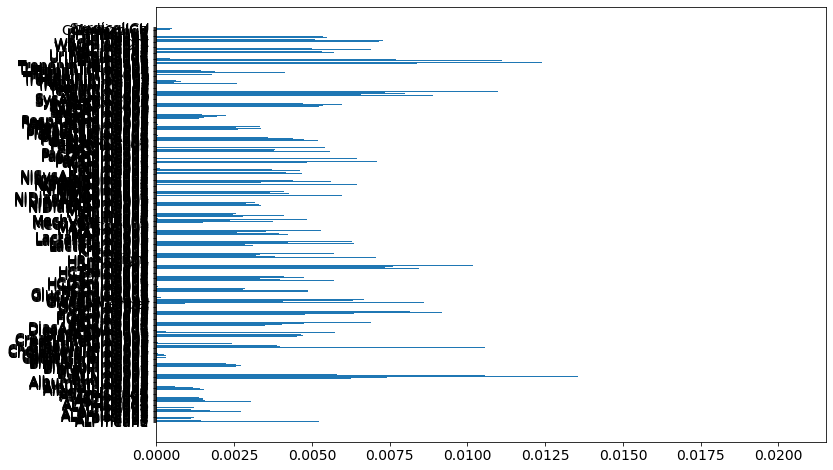

In [ ]:
plt.barh(new_names, rf.feature_importances_)

In [ ]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(new_names[sorted_idx], rf.feature_importances_[sorted_idx], width = 0.)
plt.xlabel("Random Forest Feature Importance")

TypeError: ignored

In [ ]:
pip install shap

     |████████████████████████████████| 358kB 2.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491626 sha256=ad9ac18daa73a2a042699f753fd03c548108022f43252f771669a03bd1f08c7a
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

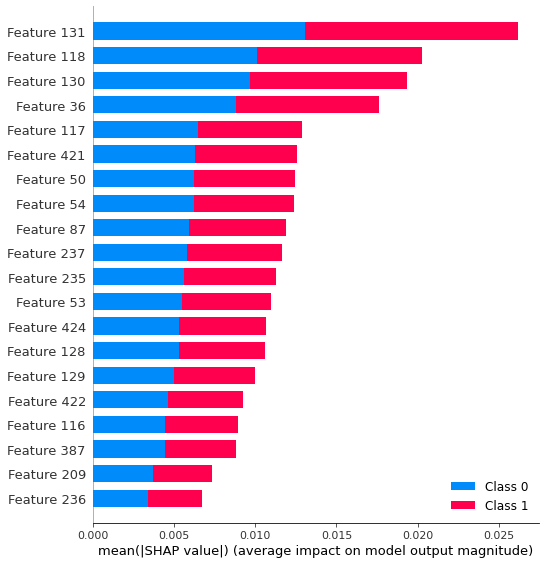

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

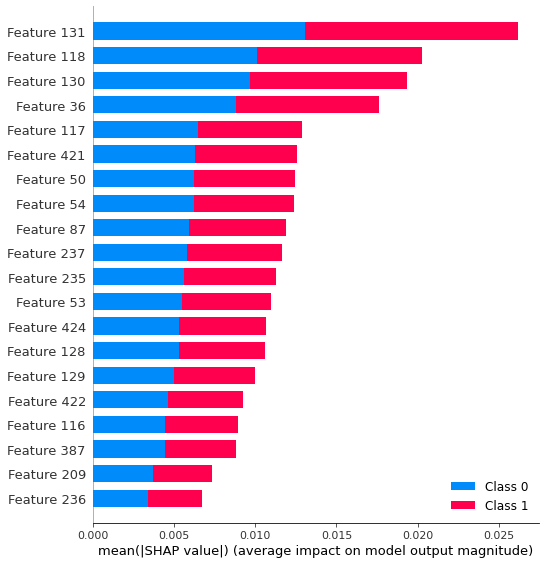

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Basic Analysis

In [ ]:
fi = pd.DataFrame({'feature': list(df_final.columns),
                   'importance': clf.feature_importances_}).\
                    sort_values('importance', ascending = False)


In [ ]:
fi

,feature,importance
71,GCSmean5,0.022468
70,GCSmean4,0.015401
18,Age,0.015397
26,BUNmean0,0.014554
29,BUNmean3,0.013409
...,...,...
200,SaO2mean6,0.000000
179,PaO2mean6,0.000000
249,pHmean6,0.000000
116,Lactatemean6,0.000000


In [ ]:
# one type of cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=3)
n_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.866 (0.008)


In [ ]:
print('test accuracy:', metrics.accuracy_score(y_test, y_pred))
print('test precision:', metrics.precision_score(y_test,y_pred))
print('test f1score:', metrics.f1_score(y_test,y_pred))
print('test auroc:', metrics.roc_auc_score(y_test,y_prob))
print('test recall:', metrics.recall_score(y_test, y_pred))

test accuracy: 0.864
test precision: 0.6666666666666666
test f1score: 0.1904761904761905
test auroc: 0.8314511941848391
test recall: 0.1111111111111111


# Performance and Hyperparameters


In [ ]:
## TODO: write a funciton that calculates the following performance measures:
#     accuracy, F1-Score, AUROC, precision, sensitivity, and specificity.
#
import warnings
warnings.filterwarnings('ignore', category=exceptions.UndefinedMetricWarning)

def calculate_performance(clf_trained, X, y_true, metric='accuracy'):
    """
    Calculates the performance metric as evaluated on the true labels
    y_true versus the predicted scores from clf_trained and X.
    Input:
        clf_trained: a fitted instance of sklearn estimator
        X : (n,d) np.array containing features
        y_true: (n,) np.array containing true labels
        metric: string specifying the performance metric (default='accuracy'
                 other options: 'f1-score', 'auroc', 'precision', 'sensitivity',
                 and 'specificity')
    Returns:
        the performance measure as a float
    """
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    if metric.lower() == 'accuracy':
        return metrics.accuracy_score(y_true, y_pred)
    elif metric.lower() == 'auroc':
        return metrics.roc_auc_score(y_true, y_prob)
    elif metric.lower() == 'f1_score' or metric.lower() == 'f1-score':
        return metrics.f1_score(y_true, y_pred)
    elif metric.lower() == 'precision':
        return metrics.precision_score(y_true, y_pred)
    elif metric.lower() == 'sensitivity':
        if tp + fn > 0:
            return tp / (tp+fn)
        else:
            return 0.0
    elif metric.lower() == 'specificity':
        if tn + fp > 0:
            return tn / (tn+fp)
        else:
            return 0.0
    else:
        raise NotImplementedError

In [ ]:
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

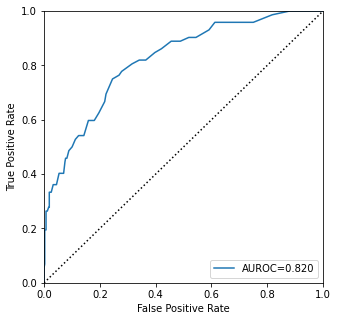

In [ ]:
# TODO: Plot ROC curve and calculate AUROC score
# ROC curve
fig, ax = plt.subplots(figsize=(5, 5))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='AUROC={:.3f}'.format(metrics.auc(fpr, tpr)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1], [0,1], 'k:')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
#Took 150 minutes to run
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
clf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.5min


KeyboardInterrupt: ignored

In [ ]:
clf_random.best_params_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

In [ ]:
best_random = clf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = base_model, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
#Takes like 15 minutes
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

In [ ]:
# View accuracy score
metrics.accuracy_score(y_test, y_pred)

In [ ]:
import seaborn as sns

# Get and reshape confusion matrix data
matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(12,12))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Dead', 'Alive']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
# View the classification report for test data and predictions
print(metrics.classification_report(y_test, y_pred))